# LMM

In [1]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
from torch.distributions import constraints
import torch.distributions as dist
import torch.optim as optim
import matplotlib.pyplot as plt

class SpatialLMM():
    '''
    Linear Mixed Model (LMM)
    
    Parameters
    ----------
    grid_size : (int) The number of locations in the grid
    variance : (float) The variance of the random effects
    '''
    def __init__(self, grid_size, variance,design_X, design_Z, covariance_matrix=None):
        

        self.grid_size = grid_size
        self.num_locations = grid_size ** 2

        self.num_regression_covariates = 3

        self.variance = variance 

        self.covariance_matrix = covariance_matrix

        self.design_X = design_X
        self.design_Z = design_Z



    def linear_predictor(self, beta):
        '''
        Computes the linear predictor (X*Beta).
        '''
        linear_pred = torch.matmul(self.design_X, beta)
        return linear_pred
    
    def generate_covariance_matrix(self):
        '''
        Creates a covariance matrix for random effects. Uses the pairwise distances between 
        the locations to get the covariance matrix.
        '''
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = self.variance * torch.exp(-(pairwise_distances))
        return covariance_matrix

    def random_effects(self, covariance_matrix):
        '''
        Computes the random effects (Z*u).
        '''
        # Sample u from a multivariate normal distribution
        u_dist = dist.MultivariateNormal(torch.zeros(self.grid_size**2), covariance_matrix=covariance_matrix)
        u = u_dist.sample()

        # Compute random effects
        rand_effects = torch.matmul(self.design_Z, u)
        return rand_effects

    def forward(self, beta):
        ''' 
        Should be:  X*Beta + Z*u only
        '''

        # Get the linear predictor (X*Beta)
        linear_pred = self.linear_predictor(beta)

        # Sample random effects (Z*u)
        rand_eff = self.random_effects(self.covariance_matrix)
        
        #error term
        error_term = torch.normal(0, 1, size=rand_eff.shape)

        # Combine fixed and random effects
        total_effects = linear_pred + rand_eff + error_term

        return total_effects


    
'''
Fixing True Parameters
'''
choose_beta = torch.tensor((3., 1., -1.))
choose_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1) 
choose_design_Z = torch.eye(choose_grid_size**2)

spatial_lmm = SpatialLMM(grid_size=choose_grid_size,
                    variance=choose_variance,
                    design_X=choose_design_X, 
                    design_Z=choose_design_Z)
spatial_lmm.covariance_matrix = spatial_lmm.generate_covariance_matrix()
num_real_samples = 500
num_fake_samples = 500


'''
Scoring Rule Inference. Choice here is Energy Score, using the unbiased estimate.
'''
def Energy_Score(beta, observations_y, simulations_Y):

	m = len(simulations_Y)

	# First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
	diff_Y_y = torch.pow(
		torch.norm(
			(observations_y.unsqueeze(1) -
			simulations_Y.unsqueeze(0)).float(),
			dim=2,keepdim=True).reshape(-1,1),
		beta)

	# Second part |Y-Y'|. 2* because pdist counts only once.
	diff_Y_Y = 2 * torch.pow(
		nn.functional.pdist(simulations_Y),
		beta)
	Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
	return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1,1), fake_samples[i].view(-1,1))
    return out / (len(real_samples) + len(fake_samples)) 

#fix Energy Score Beta = 1
SR_beta = 1.0

'''
real samples from fixed parameters, (original_beta, original_variance) 500 times
'''
torch.manual_seed(42)
real_samples = [spatial_lmm.forward(choose_beta) for i in range(num_real_samples)]


'''
Initialise
'''
theta_historyLMM1 = []
loss_historyLMM1 = []
beta_infer = torch.tensor([0.,0.,0.], requires_grad=True)
optimizer = optim.Adam([beta_infer], lr=0.05) 


from tqdm import tqdm

for epoch in tqdm(range(1000)):
    torch.manual_seed(42)
    fake_samples = [spatial_lmm.forward(beta_infer) for i in range(num_fake_samples)]
    energy_loss = SR_eval(SR_beta, real_samples, fake_samples) # Energy Score loss

    
    energy_loss.backward()
    optimizer.step()
    print('grad:', beta_infer.grad) 
    optimizer.zero_grad()    # Backpropagation

    with torch.no_grad():
        # Print optimization step
        theta_historyLMM1.append(beta_infer.clone())
        loss_historyLMM1.append(energy_loss.item())
        print(f"Epoch {epoch + 1}/{1000}, Energy Loss: {energy_loss.item()}, Beta Coefficients: {beta_infer}")


C:\Users\rikhi\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 1/1000 [00:00<10:36,  1.57it/s]

grad: tensor([-0.9149, -0.0708,  0.1646])
Epoch 1/1000, Energy Loss: 2.7627344131469727, Beta Coefficients: tensor([ 0.0500,  0.0500, -0.0500], requires_grad=True)


  0%|          | 2/1000 [00:01<09:38,  1.72it/s]

grad: tensor([-0.9067, -0.0981,  0.1675])
Epoch 2/1000, Energy Loss: 2.693645477294922, Beta Coefficients: tensor([ 0.1000,  0.0998, -0.1000], requires_grad=True)


  0%|          | 3/1000 [00:01<08:59,  1.85it/s]

grad: tensor([-0.9016, -0.1114,  0.1918])
Epoch 3/1000, Energy Loss: 2.63588809967041, Beta Coefficients: tensor([ 0.1500,  0.1497, -0.1502], requires_grad=True)


  0%|          | 4/1000 [00:02<09:13,  1.80it/s]

grad: tensor([-0.8944, -0.1290,  0.2147])
Epoch 4/1000, Energy Loss: 2.5919675827026367, Beta Coefficients: tensor([ 0.1999,  0.1998, -0.2005], requires_grad=True)


  0%|          | 5/1000 [00:02<08:51,  1.87it/s]

grad: tensor([-0.8867, -0.1441,  0.2355])
Epoch 5/1000, Energy Loss: 2.536900281906128, Beta Coefficients: tensor([ 0.2498,  0.2502, -0.2510], requires_grad=True)


  1%|          | 6/1000 [00:03<08:42,  1.90it/s]

grad: tensor([-0.8782, -0.1571,  0.2478])
Epoch 6/1000, Energy Loss: 2.4840664863586426, Beta Coefficients: tensor([ 0.2997,  0.3008, -0.3018], requires_grad=True)


  1%|          | 7/1000 [00:03<09:05,  1.82it/s]

grad: tensor([-0.8678, -0.1693,  0.2494])
Epoch 7/1000, Energy Loss: 2.411526918411255, Beta Coefficients: tensor([ 0.3495,  0.3518, -0.3527], requires_grad=True)


  1%|          | 8/1000 [00:04<09:15,  1.79it/s]

grad: tensor([-0.8559, -0.1807,  0.2602])
Epoch 8/1000, Energy Loss: 2.3435590267181396, Beta Coefficients: tensor([ 0.3993,  0.4031, -0.4039], requires_grad=True)


  1%|          | 9/1000 [00:04<09:06,  1.81it/s]

grad: tensor([-0.8477, -0.1867,  0.2656])
Epoch 9/1000, Energy Loss: 2.297269821166992, Beta Coefficients: tensor([ 0.4489,  0.4547, -0.4553], requires_grad=True)


  1%|          | 10/1000 [00:05<10:43,  1.54it/s]

grad: tensor([-0.8326, -0.1946,  0.2772])
Epoch 10/1000, Energy Loss: 2.2338578701019287, Beta Coefficients: tensor([ 0.4985,  0.5067, -0.5069], requires_grad=True)


  1%|          | 11/1000 [00:06<11:03,  1.49it/s]

grad: tensor([-0.8136, -0.2064,  0.2785])
Epoch 11/1000, Energy Loss: 2.1482291221618652, Beta Coefficients: tensor([ 0.5478,  0.5590, -0.5587], requires_grad=True)


  1%|          | 12/1000 [00:07<10:54,  1.51it/s]

grad: tensor([-0.8038, -0.2024,  0.2876])
Epoch 12/1000, Energy Loss: 2.097282886505127, Beta Coefficients: tensor([ 0.5971,  0.6116, -0.6108], requires_grad=True)


  1%|▏         | 13/1000 [00:07<10:52,  1.51it/s]

grad: tensor([-0.7876, -0.2022,  0.2800])
Epoch 13/1000, Energy Loss: 2.023982048034668, Beta Coefficients: tensor([ 0.6461,  0.6645, -0.6630], requires_grad=True)


  1%|▏         | 14/1000 [00:08<10:33,  1.56it/s]

grad: tensor([-0.7653, -0.1988,  0.2789])
Epoch 14/1000, Energy Loss: 1.9578417539596558, Beta Coefficients: tensor([ 0.6950,  0.7174, -0.7152], requires_grad=True)


  2%|▏         | 15/1000 [00:08<09:58,  1.65it/s]

grad: tensor([-0.7476, -0.1960,  0.2736])
Epoch 15/1000, Energy Loss: 1.893235206604004, Beta Coefficients: tensor([ 0.7435,  0.7704, -0.7675], requires_grad=True)


  2%|▏         | 16/1000 [00:09<09:09,  1.79it/s]

grad: tensor([-0.7274, -0.1954,  0.2639])
Epoch 16/1000, Energy Loss: 1.8237627744674683, Beta Coefficients: tensor([ 0.7918,  0.8235, -0.8196], requires_grad=True)


  2%|▏         | 17/1000 [00:09<08:37,  1.90it/s]

grad: tensor([-0.7057, -0.1863,  0.2635])
Epoch 17/1000, Energy Loss: 1.7580851316452026, Beta Coefficients: tensor([ 0.8398,  0.8764, -0.8717], requires_grad=True)


  2%|▏         | 18/1000 [00:10<08:18,  1.97it/s]

grad: tensor([-0.6815, -0.1780,  0.2500])
Epoch 18/1000, Energy Loss: 1.7004128694534302, Beta Coefficients: tensor([ 0.8873,  0.9291, -0.9235], requires_grad=True)


  2%|▏         | 19/1000 [00:10<08:35,  1.90it/s]

grad: tensor([-0.6628, -0.1725,  0.2438])
Epoch 19/1000, Energy Loss: 1.6467443704605103, Beta Coefficients: tensor([ 0.9344,  0.9815, -0.9750], requires_grad=True)


  2%|▏         | 20/1000 [00:11<08:39,  1.89it/s]

grad: tensor([-0.6489, -0.1635,  0.2376])
Epoch 20/1000, Energy Loss: 1.6262508630752563, Beta Coefficients: tensor([ 0.9812,  1.0335, -1.0262], requires_grad=True)


  2%|▏         | 21/1000 [00:12<08:46,  1.86it/s]

grad: tensor([-0.6341, -0.1601,  0.2331])
Epoch 21/1000, Energy Loss: 1.5830754041671753, Beta Coefficients: tensor([ 1.0275,  1.0850, -1.0770], requires_grad=True)


  2%|▏         | 22/1000 [00:12<08:53,  1.83it/s]

grad: tensor([-0.6082, -0.1476,  0.2140])
Epoch 22/1000, Energy Loss: 1.525867223739624, Beta Coefficients: tensor([ 1.0733,  1.1359, -1.1273], requires_grad=True)


  2%|▏         | 23/1000 [00:13<08:48,  1.85it/s]

grad: tensor([-0.5787, -0.1339,  0.1995])
Epoch 23/1000, Energy Loss: 1.4625306129455566, Beta Coefficients: tensor([ 1.1186,  1.1860, -1.1769], requires_grad=True)


  2%|▏         | 24/1000 [00:13<08:49,  1.84it/s]

grad: tensor([-0.5605, -0.1220,  0.1899])
Epoch 24/1000, Energy Loss: 1.4279154539108276, Beta Coefficients: tensor([ 1.1632,  1.2350, -1.2257], requires_grad=True)


  2%|▎         | 25/1000 [00:14<08:49,  1.84it/s]

grad: tensor([-0.5345, -0.1108,  0.1762])
Epoch 25/1000, Energy Loss: 1.3828489780426025, Beta Coefficients: tensor([ 1.2073,  1.2829, -1.2736], requires_grad=True)


  3%|▎         | 26/1000 [00:14<08:49,  1.84it/s]

grad: tensor([-0.5174, -0.1043,  0.1641])
Epoch 26/1000, Energy Loss: 1.3516079187393188, Beta Coefficients: tensor([ 1.2506,  1.3296, -1.3206], requires_grad=True)


  3%|▎         | 27/1000 [00:15<08:56,  1.81it/s]

grad: tensor([-0.4870, -0.0921,  0.1472])
Epoch 27/1000, Energy Loss: 1.3040317296981812, Beta Coefficients: tensor([ 1.2933,  1.3750, -1.3663], requires_grad=True)


  3%|▎         | 28/1000 [00:15<08:36,  1.88it/s]

grad: tensor([-0.4786, -0.0838,  0.1433])
Epoch 28/1000, Energy Loss: 1.2910774946212769, Beta Coefficients: tensor([ 1.3353,  1.4188, -1.4110], requires_grad=True)


  3%|▎         | 29/1000 [00:16<08:31,  1.90it/s]

grad: tensor([-0.4512, -0.0716,  0.1303])
Epoch 29/1000, Energy Loss: 1.252228021621704, Beta Coefficients: tensor([ 1.3764,  1.4611, -1.4544], requires_grad=True)


  3%|▎         | 30/1000 [00:16<08:11,  1.97it/s]

grad: tensor([-0.4308, -0.0624,  0.1145])
Epoch 30/1000, Energy Loss: 1.2177222967147827, Beta Coefficients: tensor([ 1.4168,  1.5016, -1.4965], requires_grad=True)


  3%|▎         | 31/1000 [00:17<08:02,  2.01it/s]

grad: tensor([-0.4124, -0.0553,  0.1055])
Epoch 31/1000, Energy Loss: 1.193840503692627, Beta Coefficients: tensor([ 1.4564,  1.5403, -1.5371], requires_grad=True)


  3%|▎         | 32/1000 [00:17<08:06,  1.99it/s]

grad: tensor([-0.3951, -0.0488,  0.0939])
Epoch 32/1000, Energy Loss: 1.1746265888214111, Beta Coefficients: tensor([ 1.4952,  1.5771, -1.5762], requires_grad=True)


  3%|▎         | 33/1000 [00:18<07:53,  2.04it/s]

grad: tensor([-0.3809, -0.0429,  0.0867])
Epoch 33/1000, Energy Loss: 1.166666865348816, Beta Coefficients: tensor([ 1.5331,  1.6122, -1.6137], requires_grad=True)


  3%|▎         | 34/1000 [00:18<07:45,  2.08it/s]

grad: tensor([-0.3594, -0.0334,  0.0744])
Epoch 34/1000, Energy Loss: 1.1349895000457764, Beta Coefficients: tensor([ 1.5702,  1.6453, -1.6497], requires_grad=True)


  4%|▎         | 35/1000 [00:19<07:46,  2.07it/s]

grad: tensor([-0.3440, -0.0254,  0.0681])
Epoch 35/1000, Energy Loss: 1.1200816631317139, Beta Coefficients: tensor([ 1.6063,  1.6763, -1.6840], requires_grad=True)


  4%|▎         | 36/1000 [00:19<07:46,  2.07it/s]

grad: tensor([-0.3322, -0.0204,  0.0599])
Epoch 36/1000, Energy Loss: 1.1031701564788818, Beta Coefficients: tensor([ 1.6417,  1.7053, -1.7167], requires_grad=True)


  4%|▎         | 37/1000 [00:20<07:47,  2.06it/s]

grad: tensor([-0.3191, -0.0189,  0.0532])
Epoch 37/1000, Energy Loss: 1.1001700162887573, Beta Coefficients: tensor([ 1.6762,  1.7323, -1.7477], requires_grad=True)


  4%|▍         | 38/1000 [00:20<07:47,  2.06it/s]

grad: tensor([-0.3099, -0.0154,  0.0471])
Epoch 38/1000, Energy Loss: 1.0915532112121582, Beta Coefficients: tensor([ 1.7099,  1.7576, -1.7772], requires_grad=True)


  4%|▍         | 39/1000 [00:21<07:37,  2.10it/s]

grad: tensor([-0.2882, -0.0052,  0.0354])
Epoch 39/1000, Energy Loss: 1.0739085674285889, Beta Coefficients: tensor([ 1.7427,  1.7807, -1.8048], requires_grad=True)


  4%|▍         | 40/1000 [00:21<08:07,  1.97it/s]

grad: tensor([-0.2788, -0.0051,  0.0271])
Epoch 40/1000, Energy Loss: 1.0616109371185303, Beta Coefficients: tensor([ 1.7746,  1.8020, -1.8307], requires_grad=True)


  4%|▍         | 41/1000 [00:22<08:16,  1.93it/s]

grad: tensor([-0.2608,  0.0025,  0.0221])
Epoch 41/1000, Energy Loss: 1.0463261604309082, Beta Coefficients: tensor([ 1.8057,  1.8212, -1.8548], requires_grad=True)


  4%|▍         | 42/1000 [00:22<08:34,  1.86it/s]

grad: tensor([-0.2542,  0.0031,  0.0176])
Epoch 42/1000, Energy Loss: 1.0425915718078613, Beta Coefficients: tensor([ 1.8359,  1.8386, -1.8772], requires_grad=True)


  4%|▍         | 43/1000 [00:23<08:51,  1.80it/s]

grad: tensor([-0.2297,  0.0076,  0.0031])
Epoch 43/1000, Energy Loss: 1.0266907215118408, Beta Coefficients: tensor([ 1.8652,  1.8541, -1.8976], requires_grad=True)


  4%|▍         | 44/1000 [00:23<08:37,  1.85it/s]

grad: tensor([-0.2253,  0.0098,  0.0018])
Epoch 44/1000, Energy Loss: 1.0217814445495605, Beta Coefficients: tensor([ 1.8936,  1.8679, -1.9163], requires_grad=True)


  4%|▍         | 45/1000 [00:24<08:29,  1.87it/s]

grad: tensor([-0.2257,  0.0086,  0.0025])
Epoch 45/1000, Energy Loss: 1.0229380130767822, Beta Coefficients: tensor([ 1.9213,  1.8800, -1.9333], requires_grad=True)


  5%|▍         | 46/1000 [00:24<08:20,  1.91it/s]

grad: tensor([-0.2190,  0.0145, -0.0015])
Epoch 46/1000, Energy Loss: 1.0252236127853394, Beta Coefficients: tensor([ 1.9482,  1.8905, -1.9488], requires_grad=True)


  5%|▍         | 47/1000 [00:25<08:15,  1.93it/s]

grad: tensor([-0.2010,  0.0155, -0.0090])
Epoch 47/1000, Energy Loss: 1.0039525032043457, Beta Coefficients: tensor([ 1.9743,  1.8993, -1.9626], requires_grad=True)


  5%|▍         | 48/1000 [00:25<08:12,  1.93it/s]

grad: tensor([-0.2012,  0.0156, -0.0103])
Epoch 48/1000, Energy Loss: 1.0108528137207031, Beta Coefficients: tensor([ 1.9997,  1.9068, -1.9748], requires_grad=True)


  5%|▍         | 49/1000 [00:26<07:53,  2.01it/s]

grad: tensor([-0.1993,  0.0177, -0.0125])
Epoch 49/1000, Energy Loss: 1.0112298727035522, Beta Coefficients: tensor([ 2.0244,  1.9128, -1.9856], requires_grad=True)


  5%|▌         | 50/1000 [00:26<07:43,  2.05it/s]

grad: tensor([-0.1873,  0.0203, -0.0156])
Epoch 50/1000, Energy Loss: 1.0004171133041382, Beta Coefficients: tensor([ 2.0484,  1.9174, -1.9950], requires_grad=True)


  5%|▌         | 51/1000 [00:27<07:46,  2.03it/s]

grad: tensor([-0.1737,  0.0210, -0.0230])
Epoch 51/1000, Energy Loss: 0.9958165287971497, Beta Coefficients: tensor([ 2.0717,  1.9207, -2.0028], requires_grad=True)


  5%|▌         | 52/1000 [00:27<07:54,  2.00it/s]

grad: tensor([-0.1737,  0.0222, -0.0241])
Epoch 52/1000, Energy Loss: 0.9944100975990295, Beta Coefficients: tensor([ 2.0944,  1.9227, -2.0093], requires_grad=True)


  5%|▌         | 53/1000 [00:28<07:59,  1.98it/s]

grad: tensor([-0.1539,  0.0237, -0.0302])
Epoch 53/1000, Energy Loss: 0.9849540591239929, Beta Coefficients: tensor([ 2.1163,  1.9236, -2.0142], requires_grad=True)


  5%|▌         | 54/1000 [00:28<08:04,  1.95it/s]

grad: tensor([-0.1509,  0.0245, -0.0311])
Epoch 54/1000, Energy Loss: 0.9776628017425537, Beta Coefficients: tensor([ 2.1375,  1.9233, -2.0178], requires_grad=True)


  6%|▌         | 55/1000 [00:29<07:59,  1.97it/s]

grad: tensor([-0.1488,  0.0240, -0.0320])
Epoch 55/1000, Energy Loss: 0.9777859449386597, Beta Coefficients: tensor([ 2.1581,  1.9220, -2.0201], requires_grad=True)


  6%|▌         | 56/1000 [00:29<08:07,  1.94it/s]

grad: tensor([-0.1462,  0.0248, -0.0352])
Epoch 56/1000, Energy Loss: 0.9820855855941772, Beta Coefficients: tensor([ 2.1781,  1.9197, -2.0212], requires_grad=True)


  6%|▌         | 57/1000 [00:30<07:55,  1.98it/s]

grad: tensor([-0.1388,  0.0272, -0.0331])
Epoch 57/1000, Energy Loss: 0.9745320677757263, Beta Coefficients: tensor([ 2.1975,  1.9164, -2.0212], requires_grad=True)


  6%|▌         | 58/1000 [00:30<07:56,  1.98it/s]

grad: tensor([-0.1324,  0.0281, -0.0373])
Epoch 58/1000, Energy Loss: 0.9724093079566956, Beta Coefficients: tensor([ 2.2163,  1.9121, -2.0200], requires_grad=True)


  6%|▌         | 59/1000 [00:31<07:53,  1.99it/s]

grad: tensor([-0.1287,  0.0285, -0.0388])
Epoch 59/1000, Energy Loss: 0.9657511115074158, Beta Coefficients: tensor([ 2.2346,  1.9069, -2.0178], requires_grad=True)


  6%|▌         | 60/1000 [00:31<07:30,  2.09it/s]

grad: tensor([-0.1274,  0.0271, -0.0383])
Epoch 60/1000, Energy Loss: 0.9633243083953857, Beta Coefficients: tensor([ 2.2523,  1.9010, -2.0145], requires_grad=True)


  6%|▌         | 61/1000 [00:32<08:04,  1.94it/s]

grad: tensor([-0.1142,  0.0292, -0.0426])
Epoch 61/1000, Energy Loss: 0.958432674407959, Beta Coefficients: tensor([ 2.2694,  1.8943, -2.0103], requires_grad=True)


  6%|▌         | 62/1000 [00:32<08:04,  1.94it/s]

grad: tensor([-0.1138,  0.0269, -0.0441])
Epoch 62/1000, Energy Loss: 0.9581644535064697, Beta Coefficients: tensor([ 2.2861,  1.8870, -2.0051], requires_grad=True)


  6%|▋         | 63/1000 [00:33<07:48,  2.00it/s]

grad: tensor([-0.1126,  0.0251, -0.0432])
Epoch 63/1000, Energy Loss: 0.9578012824058533, Beta Coefficients: tensor([ 2.3022,  1.8791, -1.9990], requires_grad=True)


  6%|▋         | 64/1000 [00:33<07:38,  2.04it/s]

grad: tensor([-0.1101,  0.0287, -0.0418])
Epoch 64/1000, Energy Loss: 0.9566505551338196, Beta Coefficients: tensor([ 2.3179,  1.8707, -1.9921], requires_grad=True)


  6%|▋         | 65/1000 [00:34<07:41,  2.02it/s]

grad: tensor([-0.1096,  0.0265, -0.0426])
Epoch 65/1000, Energy Loss: 0.9550222158432007, Beta Coefficients: tensor([ 2.3332,  1.8618, -1.9845], requires_grad=True)


  7%|▋         | 66/1000 [00:34<07:38,  2.04it/s]

grad: tensor([-0.1108,  0.0252, -0.0414])
Epoch 66/1000, Energy Loss: 0.9575026631355286, Beta Coefficients: tensor([ 2.3481,  1.8525, -1.9763], requires_grad=True)


  7%|▋         | 67/1000 [00:35<07:37,  2.04it/s]

grad: tensor([-0.1013,  0.0273, -0.0426])
Epoch 67/1000, Energy Loss: 0.9513436555862427, Beta Coefficients: tensor([ 2.3626,  1.8427, -1.9675], requires_grad=True)


  7%|▋         | 68/1000 [00:35<07:55,  1.96it/s]

grad: tensor([-0.0955,  0.0265, -0.0454])
Epoch 68/1000, Energy Loss: 0.9556105136871338, Beta Coefficients: tensor([ 2.3767,  1.8326, -1.9580], requires_grad=True)


  7%|▋         | 69/1000 [00:36<08:05,  1.92it/s]

grad: tensor([-0.0980,  0.0270, -0.0431])
Epoch 69/1000, Energy Loss: 0.9447808861732483, Beta Coefficients: tensor([ 2.3905,  1.8221, -1.9480], requires_grad=True)


  7%|▋         | 70/1000 [00:37<08:06,  1.91it/s]

grad: tensor([-0.0907,  0.0274, -0.0439])
Epoch 70/1000, Energy Loss: 0.9428810477256775, Beta Coefficients: tensor([ 2.4039,  1.8113, -1.9374], requires_grad=True)


  7%|▋         | 71/1000 [00:37<08:36,  1.80it/s]

grad: tensor([-0.0894,  0.0270, -0.0436])
Epoch 71/1000, Energy Loss: 0.9369841814041138, Beta Coefficients: tensor([ 2.4169,  1.8001, -1.9264], requires_grad=True)


  7%|▋         | 72/1000 [00:38<08:52,  1.74it/s]

grad: tensor([-0.0958,  0.0263, -0.0403])
Epoch 72/1000, Energy Loss: 0.9458941221237183, Beta Coefficients: tensor([ 2.4296,  1.7887, -1.9151], requires_grad=True)


  7%|▋         | 73/1000 [00:38<09:03,  1.70it/s]

grad: tensor([-0.0921,  0.0251, -0.0422])
Epoch 73/1000, Energy Loss: 0.9381011128425598, Beta Coefficients: tensor([ 2.4421,  1.7771, -1.9034], requires_grad=True)


  7%|▋         | 74/1000 [00:39<09:38,  1.60it/s]

grad: tensor([-0.0754,  0.0276, -0.0435])
Epoch 74/1000, Energy Loss: 0.9358279705047607, Beta Coefficients: tensor([ 2.4542,  1.7651, -1.8913], requires_grad=True)


  8%|▊         | 75/1000 [00:40<09:24,  1.64it/s]

grad: tensor([-0.0848,  0.0253, -0.0437])
Epoch 75/1000, Energy Loss: 0.934269905090332, Beta Coefficients: tensor([ 2.4661,  1.7531, -1.8789], requires_grad=True)


  8%|▊         | 76/1000 [00:40<09:13,  1.67it/s]

grad: tensor([-0.0883,  0.0254, -0.0381])
Epoch 76/1000, Energy Loss: 0.9344715476036072, Beta Coefficients: tensor([ 2.4777,  1.7408, -1.8664], requires_grad=True)


  8%|▊         | 77/1000 [00:41<08:53,  1.73it/s]

grad: tensor([-0.0720,  0.0283, -0.0413])
Epoch 77/1000, Energy Loss: 0.930965006351471, Beta Coefficients: tensor([ 2.4890,  1.7283, -1.8536], requires_grad=True)


  8%|▊         | 78/1000 [00:41<08:46,  1.75it/s]

grad: tensor([-0.0828,  0.0235, -0.0404])
Epoch 78/1000, Energy Loss: 0.9312094449996948, Beta Coefficients: tensor([ 2.5002,  1.7157, -1.8405], requires_grad=True)


  8%|▊         | 79/1000 [00:42<08:46,  1.75it/s]

grad: tensor([-0.0822,  0.0243, -0.0383])
Epoch 79/1000, Energy Loss: 0.9279446601867676, Beta Coefficients: tensor([ 2.5111,  1.7031, -1.8274], requires_grad=True)


  8%|▊         | 80/1000 [00:42<08:28,  1.81it/s]

grad: tensor([-0.0770,  0.0252, -0.0371])
Epoch 80/1000, Energy Loss: 0.9232273697853088, Beta Coefficients: tensor([ 2.5218,  1.6903, -1.8142], requires_grad=True)


  8%|▊         | 81/1000 [00:43<08:11,  1.87it/s]

grad: tensor([-0.0726,  0.0230, -0.0373])
Epoch 81/1000, Energy Loss: 0.9205441474914551, Beta Coefficients: tensor([ 2.5323,  1.6775, -1.8010], requires_grad=True)


  8%|▊         | 82/1000 [00:43<08:13,  1.86it/s]

grad: tensor([-0.0637,  0.0240, -0.0376])
Epoch 82/1000, Energy Loss: 0.9246706366539001, Beta Coefficients: tensor([ 2.5425,  1.6647, -1.7876], requires_grad=True)


  8%|▊         | 83/1000 [00:44<08:07,  1.88it/s]

grad: tensor([-0.0563,  0.0222, -0.0385])
Epoch 83/1000, Energy Loss: 0.9210610389709473, Beta Coefficients: tensor([ 2.5523,  1.6519, -1.7741], requires_grad=True)


  8%|▊         | 84/1000 [00:45<08:27,  1.81it/s]

grad: tensor([-0.0714,  0.0220, -0.0369])
Epoch 84/1000, Energy Loss: 0.9209282994270325, Beta Coefficients: tensor([ 2.5620,  1.6391, -1.7606], requires_grad=True)


  8%|▊         | 85/1000 [00:45<08:28,  1.80it/s]

grad: tensor([-0.0676,  0.0238, -0.0351])
Epoch 85/1000, Energy Loss: 0.9194748401641846, Beta Coefficients: tensor([ 2.5715,  1.6262, -1.7471], requires_grad=True)


  9%|▊         | 86/1000 [00:46<08:19,  1.83it/s]

grad: tensor([-0.0676,  0.0204, -0.0345])
Epoch 86/1000, Energy Loss: 0.914182722568512, Beta Coefficients: tensor([ 2.5809,  1.6135, -1.7335], requires_grad=True)


  9%|▊         | 87/1000 [00:46<08:31,  1.78it/s]

grad: tensor([-0.0467,  0.0221, -0.0391])
Epoch 87/1000, Energy Loss: 0.9134263396263123, Beta Coefficients: tensor([ 2.5899,  1.6007, -1.7199], requires_grad=True)


  9%|▉         | 88/1000 [00:47<08:17,  1.83it/s]

grad: tensor([-0.0624,  0.0232, -0.0323])
Epoch 88/1000, Energy Loss: 0.9173868894577026, Beta Coefficients: tensor([ 2.5987,  1.5879, -1.7063], requires_grad=True)


  9%|▉         | 89/1000 [00:47<08:09,  1.86it/s]

grad: tensor([-0.0549,  0.0205, -0.0336])
Epoch 89/1000, Energy Loss: 0.9150533676147461, Beta Coefficients: tensor([ 2.6074,  1.5752, -1.6928], requires_grad=True)


  9%|▉         | 90/1000 [00:48<08:00,  1.89it/s]

grad: tensor([-0.0614,  0.0212, -0.0293])
Epoch 90/1000, Energy Loss: 0.9086134433746338, Beta Coefficients: tensor([ 2.6159,  1.5625, -1.6795], requires_grad=True)


  9%|▉         | 91/1000 [00:48<07:52,  1.92it/s]

grad: tensor([-0.0600,  0.0179, -0.0336])
Epoch 91/1000, Energy Loss: 0.911479115486145, Beta Coefficients: tensor([ 2.6242,  1.5500, -1.6661], requires_grad=True)


  9%|▉         | 92/1000 [00:49<07:44,  1.96it/s]

grad: tensor([-0.0668,  0.0168, -0.0275])
Epoch 92/1000, Energy Loss: 0.9079239368438721, Beta Coefficients: tensor([ 2.6326,  1.5378, -1.6530], requires_grad=True)


  9%|▉         | 93/1000 [00:49<07:45,  1.95it/s]

grad: tensor([-0.0586,  0.0172, -0.0279])
Epoch 93/1000, Energy Loss: 0.9142233729362488, Beta Coefficients: tensor([ 2.6408,  1.5257, -1.6401], requires_grad=True)


  9%|▉         | 94/1000 [00:50<07:46,  1.94it/s]

grad: tensor([-0.0584,  0.0178, -0.0258])
Epoch 94/1000, Energy Loss: 0.9061941504478455, Beta Coefficients: tensor([ 2.6489,  1.5138, -1.6274], requires_grad=True)


 10%|▉         | 95/1000 [00:50<07:41,  1.96it/s]

grad: tensor([-0.0560,  0.0166, -0.0260])
Epoch 95/1000, Energy Loss: 0.9109137058258057, Beta Coefficients: tensor([ 2.6569,  1.5021, -1.6150], requires_grad=True)


 10%|▉         | 96/1000 [00:51<07:59,  1.88it/s]

grad: tensor([-0.0498,  0.0177, -0.0269])
Epoch 96/1000, Energy Loss: 0.9071576595306396, Beta Coefficients: tensor([ 2.6648,  1.4905, -1.6027], requires_grad=True)


 10%|▉         | 97/1000 [00:51<08:10,  1.84it/s]

grad: tensor([-0.0499,  0.0161, -0.0267])
Epoch 97/1000, Energy Loss: 0.9040985703468323, Beta Coefficients: tensor([ 2.6724,  1.4790, -1.5905], requires_grad=True)


 10%|▉         | 98/1000 [00:52<08:02,  1.87it/s]

grad: tensor([-0.0544,  0.0153, -0.0239])
Epoch 98/1000, Energy Loss: 0.9055699706077576, Beta Coefficients: tensor([ 2.6800,  1.4678, -1.5785], requires_grad=True)


 10%|▉         | 99/1000 [00:53<08:05,  1.85it/s]

grad: tensor([-0.0519,  0.0149, -0.0240])
Epoch 99/1000, Energy Loss: 0.904118001461029, Beta Coefficients: tensor([ 2.6875,  1.4568, -1.5668], requires_grad=True)


 10%|█         | 100/1000 [00:53<08:05,  1.85it/s]

grad: tensor([-0.0406,  0.0163, -0.0258])
Epoch 100/1000, Energy Loss: 0.9061558246612549, Beta Coefficients: tensor([ 2.6947,  1.4458, -1.5551], requires_grad=True)


 10%|█         | 101/1000 [00:54<08:20,  1.80it/s]

grad: tensor([-0.0407,  0.0135, -0.0217])
Epoch 101/1000, Energy Loss: 0.9007056951522827, Beta Coefficients: tensor([ 2.7018,  1.4351, -1.5437], requires_grad=True)


 10%|█         | 102/1000 [00:54<08:43,  1.72it/s]

grad: tensor([-0.0533,  0.0126, -0.0190])
Epoch 102/1000, Energy Loss: 0.9018217921257019, Beta Coefficients: tensor([ 2.7088,  1.4247, -1.5326], requires_grad=True)


 10%|█         | 103/1000 [00:55<08:47,  1.70it/s]

grad: tensor([-0.0491,  0.0117, -0.0207])
Epoch 103/1000, Energy Loss: 0.8981845378875732, Beta Coefficients: tensor([ 2.7157,  1.4146, -1.5218], requires_grad=True)


 10%|█         | 104/1000 [00:55<08:34,  1.74it/s]

grad: tensor([-0.0403,  0.0151, -0.0221])
Epoch 104/1000, Energy Loss: 0.899151623249054, Beta Coefficients: tensor([ 2.7225,  1.4046, -1.5111], requires_grad=True)


 10%|█         | 105/1000 [00:56<08:17,  1.80it/s]

grad: tensor([-0.0458,  0.0104, -0.0179])
Epoch 105/1000, Energy Loss: 0.9006723761558533, Beta Coefficients: tensor([ 2.7292,  1.3948, -1.5007], requires_grad=True)


 11%|█         | 106/1000 [00:56<07:57,  1.87it/s]

grad: tensor([-0.0415,  0.0115, -0.0169])
Epoch 106/1000, Energy Loss: 0.9018495082855225, Beta Coefficients: tensor([ 2.7357,  1.3854, -1.4906], requires_grad=True)


 11%|█         | 107/1000 [00:57<07:48,  1.91it/s]

grad: tensor([-0.0344,  0.0126, -0.0191])
Epoch 107/1000, Energy Loss: 0.896307110786438, Beta Coefficients: tensor([ 2.7421,  1.3760, -1.4807], requires_grad=True)


 11%|█         | 108/1000 [00:57<07:44,  1.92it/s]

grad: tensor([-0.0382,  0.0124, -0.0168])
Epoch 108/1000, Energy Loss: 0.8973768949508667, Beta Coefficients: tensor([ 2.7483,  1.3668, -1.4711], requires_grad=True)


 11%|█         | 109/1000 [00:58<07:43,  1.92it/s]

grad: tensor([-0.0399,  0.0087, -0.0150])
Epoch 109/1000, Energy Loss: 0.9002984762191772, Beta Coefficients: tensor([ 2.7545,  1.3580, -1.4617], requires_grad=True)


 11%|█         | 110/1000 [00:59<07:46,  1.91it/s]

grad: tensor([-0.0307,  0.0123, -0.0154])
Epoch 110/1000, Energy Loss: 0.8954148888587952, Beta Coefficients: tensor([ 2.7604,  1.3492, -1.4527], requires_grad=True)


 11%|█         | 111/1000 [00:59<07:51,  1.89it/s]

grad: tensor([-0.0401,  0.0065, -0.0149])
Epoch 111/1000, Energy Loss: 0.896124005317688, Beta Coefficients: tensor([ 2.7663,  1.3409, -1.4438], requires_grad=True)


 11%|█         | 112/1000 [01:00<07:53,  1.88it/s]

grad: tensor([-0.0359,  0.0102, -0.0130])
Epoch 112/1000, Energy Loss: 0.8967835307121277, Beta Coefficients: tensor([ 2.7720,  1.3327, -1.4353], requires_grad=True)


 11%|█▏        | 113/1000 [01:00<07:48,  1.89it/s]

grad: tensor([-0.0338,  0.0073, -0.0121])
Epoch 113/1000, Energy Loss: 0.8909255266189575, Beta Coefficients: tensor([ 2.7777,  1.3249, -1.4271], requires_grad=True)


 11%|█▏        | 114/1000 [01:01<07:37,  1.94it/s]

grad: tensor([-0.0386,  0.0063, -0.0123])
Epoch 114/1000, Energy Loss: 0.8907564878463745, Beta Coefficients: tensor([ 2.7832,  1.3174, -1.4191], requires_grad=True)


 12%|█▏        | 115/1000 [01:01<07:38,  1.93it/s]

grad: tensor([-0.0470,  0.0078, -0.0077])
Epoch 115/1000, Energy Loss: 0.8969113230705261, Beta Coefficients: tensor([ 2.7889,  1.3101, -1.4116], requires_grad=True)


 12%|█▏        | 116/1000 [01:02<07:46,  1.90it/s]

grad: tensor([-0.0288,  0.0062, -0.0125])
Epoch 116/1000, Energy Loss: 0.8936913013458252, Beta Coefficients: tensor([ 2.7944,  1.3032, -1.4043], requires_grad=True)


 12%|█▏        | 117/1000 [01:02<07:53,  1.86it/s]

grad: tensor([-0.0355,  0.0075, -0.0113])
Epoch 117/1000, Energy Loss: 0.8976296782493591, Beta Coefficients: tensor([ 2.7998,  1.2964, -1.3971], requires_grad=True)


 12%|█▏        | 118/1000 [01:03<08:00,  1.83it/s]

grad: tensor([-0.0264,  0.0071, -0.0098])
Epoch 118/1000, Energy Loss: 0.8905211091041565, Beta Coefficients: tensor([ 2.8051,  1.2899, -1.3903], requires_grad=True)


 12%|█▏        | 119/1000 [01:03<07:59,  1.84it/s]

grad: tensor([-0.0281,  0.0041, -0.0094])
Epoch 119/1000, Energy Loss: 0.89558345079422, Beta Coefficients: tensor([ 2.8102,  1.2837, -1.3837], requires_grad=True)


 12%|█▏        | 120/1000 [01:04<08:04,  1.82it/s]

grad: tensor([-0.0294,  0.0059, -0.0086])
Epoch 120/1000, Energy Loss: 0.8939176201820374, Beta Coefficients: tensor([ 2.8152,  1.2777, -1.3774], requires_grad=True)


 12%|█▏        | 121/1000 [01:04<08:01,  1.83it/s]

grad: tensor([-0.0241,  0.0034, -0.0078])
Epoch 121/1000, Energy Loss: 0.8935569524765015, Beta Coefficients: tensor([ 2.8200,  1.2721, -1.3713], requires_grad=True)


 12%|█▏        | 122/1000 [01:05<07:53,  1.85it/s]

grad: tensor([-0.0223,  0.0060, -0.0094])
Epoch 122/1000, Energy Loss: 0.8907095789909363, Beta Coefficients: tensor([ 2.8247,  1.2666, -1.3654], requires_grad=True)


 12%|█▏        | 123/1000 [01:06<08:19,  1.76it/s]

grad: tensor([-0.0155,  0.0070, -0.0106])
Epoch 123/1000, Energy Loss: 0.8908820748329163, Beta Coefficients: tensor([ 2.8291,  1.2612, -1.3596], requires_grad=True)


 12%|█▏        | 124/1000 [01:06<08:14,  1.77it/s]

grad: tensor([-0.0239,  0.0020, -0.0073])
Epoch 124/1000, Energy Loss: 0.8882666230201721, Beta Coefficients: tensor([ 2.8335,  1.2561, -1.3540], requires_grad=True)


 12%|█▎        | 125/1000 [01:07<08:02,  1.82it/s]

grad: tensor([-0.0169,  0.0062, -0.0100])
Epoch 125/1000, Energy Loss: 0.8944180011749268, Beta Coefficients: tensor([ 2.8376,  1.2512, -1.3486], requires_grad=True)


 13%|█▎        | 126/1000 [01:07<07:54,  1.84it/s]

grad: tensor([-0.0224,  0.0047, -0.0092])
Epoch 126/1000, Energy Loss: 0.8865714073181152, Beta Coefficients: tensor([ 2.8416,  1.2464, -1.3432], requires_grad=True)


 13%|█▎        | 127/1000 [01:08<07:49,  1.86it/s]

grad: tensor([-0.0278,  0.0018, -0.0073])
Epoch 127/1000, Energy Loss: 0.8937831521034241, Beta Coefficients: tensor([ 2.8457,  1.2420, -1.3381], requires_grad=True)


 13%|█▎        | 128/1000 [01:08<07:33,  1.92it/s]

grad: tensor([-0.0317,  0.0016, -0.0019])
Epoch 128/1000, Energy Loss: 0.8946033716201782, Beta Coefficients: tensor([ 2.8497,  1.2378, -1.3333], requires_grad=True)


 13%|█▎        | 129/1000 [01:09<07:32,  1.92it/s]

grad: tensor([-0.0111,  0.0029, -0.0075])
Epoch 129/1000, Energy Loss: 0.8886934518814087, Beta Coefficients: tensor([ 2.8536,  1.2339, -1.3287], requires_grad=True)


 13%|█▎        | 130/1000 [01:09<08:15,  1.76it/s]

grad: tensor([-0.0066,  0.0013, -0.0083])
Epoch 130/1000, Energy Loss: 0.8901380300521851, Beta Coefficients: tensor([ 2.8571,  1.2303, -1.3241], requires_grad=True)


 13%|█▎        | 131/1000 [01:10<08:17,  1.75it/s]

grad: tensor([-0.0137,  0.0025, -0.0043])
Epoch 131/1000, Energy Loss: 0.8880294561386108, Beta Coefficients: tensor([ 2.8605,  1.2268, -1.3198], requires_grad=True)


 13%|█▎        | 132/1000 [01:11<08:04,  1.79it/s]

grad: tensor([-0.0174,  0.0020, -0.0056])
Epoch 132/1000, Energy Loss: 0.8907977342605591, Beta Coefficients: tensor([ 2.8638,  1.2236, -1.3157], requires_grad=True)


 13%|█▎        | 133/1000 [01:11<08:15,  1.75it/s]

grad: tensor([-0.0210,  0.0003, -0.0073])
Epoch 133/1000, Energy Loss: 0.8922377824783325, Beta Coefficients: tensor([ 2.8671,  1.2206, -1.3116], requires_grad=True)


 13%|█▎        | 134/1000 [01:12<08:08,  1.77it/s]

grad: tensor([-1.7517e-02,  7.6190e-05, -3.4435e-03])
Epoch 134/1000, Energy Loss: 0.8932833671569824, Beta Coefficients: tensor([ 2.8703,  1.2180, -1.3077], requires_grad=True)


 14%|█▎        | 135/1000 [01:12<08:10,  1.76it/s]

grad: tensor([-0.0231, -0.0006, -0.0016])
Epoch 135/1000, Energy Loss: 0.8941025733947754, Beta Coefficients: tensor([ 2.8736,  1.2156, -1.3042], requires_grad=True)


 14%|█▎        | 136/1000 [01:13<08:36,  1.67it/s]

grad: tensor([-0.0017,  0.0019, -0.0051])
Epoch 136/1000, Energy Loss: 0.8944233655929565, Beta Coefficients: tensor([ 2.8765,  1.2133, -1.3007], requires_grad=True)


 14%|█▎        | 137/1000 [01:13<08:33,  1.68it/s]

grad: tensor([-0.0227,  0.0003, -0.0018])
Epoch 137/1000, Energy Loss: 0.8905384540557861, Beta Coefficients: tensor([ 2.8795,  1.2112, -1.2975], requires_grad=True)


 14%|█▍        | 138/1000 [01:14<08:12,  1.75it/s]

grad: tensor([-0.0178,  0.0027, -0.0022])
Epoch 138/1000, Energy Loss: 0.8874695301055908, Beta Coefficients: tensor([ 2.8824,  1.2092, -1.2945], requires_grad=True)


 14%|█▍        | 139/1000 [01:15<07:53,  1.82it/s]

grad: tensor([-0.0052,  0.0022, -0.0039])
Epoch 139/1000, Energy Loss: 0.8880661725997925, Beta Coefficients: tensor([ 2.8851,  1.2071, -1.2916], requires_grad=True)


 14%|█▍        | 140/1000 [01:15<07:40,  1.87it/s]

grad: tensor([-0.0087,  0.0009, -0.0049])
Epoch 140/1000, Energy Loss: 0.8940349817276001, Beta Coefficients: tensor([ 2.8877,  1.2053, -1.2888], requires_grad=True)


 14%|█▍        | 141/1000 [01:16<07:29,  1.91it/s]

grad: tensor([-0.0207,  0.0011,  0.0006])
Epoch 141/1000, Energy Loss: 0.8897507786750793, Beta Coefficients: tensor([ 2.8904,  1.2035, -1.2863], requires_grad=True)


 14%|█▍        | 142/1000 [01:16<07:12,  1.98it/s]

grad: tensor([-0.0065,  0.0011, -0.0049])
Epoch 142/1000, Energy Loss: 0.8898183107376099, Beta Coefficients: tensor([ 2.8928,  1.2018, -1.2838], requires_grad=True)


 14%|█▍        | 143/1000 [01:16<06:47,  2.10it/s]

grad: tensor([-0.0150,  0.0021, -0.0033])
Epoch 143/1000, Energy Loss: 0.8906779289245605, Beta Coefficients: tensor([ 2.8953,  1.2001, -1.2813], requires_grad=True)


 14%|█▍        | 144/1000 [01:17<06:36,  2.16it/s]

grad: tensor([-0.0029,  0.0008, -0.0068])
Epoch 144/1000, Energy Loss: 0.8898147344589233, Beta Coefficients: tensor([ 2.8976,  1.1985, -1.2788], requires_grad=True)


 14%|█▍        | 145/1000 [01:17<06:29,  2.19it/s]

grad: tensor([-0.0055,  0.0016, -0.0040])
Epoch 145/1000, Energy Loss: 0.8874832987785339, Beta Coefficients: tensor([ 2.8997,  1.1970, -1.2763], requires_grad=True)


 15%|█▍        | 146/1000 [01:18<06:15,  2.27it/s]

grad: tensor([-0.0155, -0.0013, -0.0003])
Epoch 146/1000, Energy Loss: 0.8912212252616882, Beta Coefficients: tensor([ 2.9018,  1.1957, -1.2741], requires_grad=True)


 15%|█▍        | 147/1000 [01:18<06:11,  2.30it/s]

grad: tensor([-0.0030,  0.0024, -0.0020])
Epoch 147/1000, Energy Loss: 0.8888566493988037, Beta Coefficients: tensor([ 2.9038,  1.1944, -1.2720], requires_grad=True)


 15%|█▍        | 148/1000 [01:19<06:13,  2.28it/s]

grad: tensor([-0.0047,  0.0002, -0.0038])
Epoch 148/1000, Energy Loss: 0.8918391466140747, Beta Coefficients: tensor([ 2.9057,  1.1932, -1.2699], requires_grad=True)


 15%|█▍        | 149/1000 [01:19<06:18,  2.25it/s]

grad: tensor([-0.0041,  0.0007, -0.0040])
Epoch 149/1000, Energy Loss: 0.8911933302879333, Beta Coefficients: tensor([ 2.9074,  1.1920, -1.2678], requires_grad=True)


 15%|█▌        | 150/1000 [01:19<06:13,  2.28it/s]

grad: tensor([-0.0135, -0.0003,  0.0011])
Epoch 150/1000, Energy Loss: 0.8925589919090271, Beta Coefficients: tensor([ 2.9092,  1.1910, -1.2659], requires_grad=True)


 15%|█▌        | 151/1000 [01:20<06:18,  2.24it/s]

grad: tensor([-0.0037,  0.0025, -0.0012])
Epoch 151/1000, Energy Loss: 0.8932135105133057, Beta Coefficients: tensor([ 2.9108,  1.1899, -1.2642], requires_grad=True)


 15%|█▌        | 152/1000 [01:20<06:26,  2.20it/s]

grad: tensor([-0.0069, -0.0013, -0.0034])
Epoch 152/1000, Energy Loss: 0.8877862691879272, Beta Coefficients: tensor([ 2.9124,  1.1890, -1.2625], requires_grad=True)


 15%|█▌        | 153/1000 [01:21<06:22,  2.21it/s]

grad: tensor([ 0.0075,  0.0005, -0.0044])
Epoch 153/1000, Energy Loss: 0.8925846219062805, Beta Coefficients: tensor([ 2.9137,  1.1881, -1.2607], requires_grad=True)


 15%|█▌        | 154/1000 [01:21<06:42,  2.10it/s]

grad: tensor([-0.0012,  0.0031, -0.0068])
Epoch 154/1000, Energy Loss: 0.8851584792137146, Beta Coefficients: tensor([ 2.9150,  1.1871, -1.2588], requires_grad=True)


 16%|█▌        | 155/1000 [01:22<06:54,  2.04it/s]

grad: tensor([ 0.0002,  0.0032, -0.0064])
Epoch 155/1000, Energy Loss: 0.8857706785202026, Beta Coefficients: tensor([ 2.9160,  1.1860, -1.2567], requires_grad=True)


 16%|█▌        | 156/1000 [01:22<07:10,  1.96it/s]

grad: tensor([-0.0021,  0.0014, -0.0031])
Epoch 156/1000, Energy Loss: 0.8885597586631775, Beta Coefficients: tensor([ 2.9171,  1.1848, -1.2547], requires_grad=True)


 16%|█▌        | 157/1000 [01:23<06:57,  2.02it/s]

grad: tensor([-0.0136, -0.0002, -0.0012])
Epoch 157/1000, Energy Loss: 0.8936511874198914, Beta Coefficients: tensor([ 2.9182,  1.1838, -1.2528], requires_grad=True)


 16%|█▌        | 158/1000 [01:23<07:00,  2.00it/s]

grad: tensor([ 0.0035,  0.0029, -0.0032])
Epoch 158/1000, Energy Loss: 0.8850721120834351, Beta Coefficients: tensor([ 2.9192,  1.1827, -1.2510], requires_grad=True)


 16%|█▌        | 159/1000 [01:24<06:58,  2.01it/s]

grad: tensor([-0.0061,  0.0001, -0.0003])
Epoch 159/1000, Energy Loss: 0.8875100016593933, Beta Coefficients: tensor([ 2.9201,  1.1817, -1.2493], requires_grad=True)


 16%|█▌        | 160/1000 [01:24<06:42,  2.09it/s]

grad: tensor([-0.0077, -0.0045, -0.0013])
Epoch 160/1000, Energy Loss: 0.8888779878616333, Beta Coefficients: tensor([ 2.9211,  1.1811, -1.2477], requires_grad=True)


 16%|█▌        | 161/1000 [01:25<06:36,  2.12it/s]

grad: tensor([ 0.0154,  0.0014, -0.0053])
Epoch 161/1000, Energy Loss: 0.8930673599243164, Beta Coefficients: tensor([ 2.9218,  1.1804, -1.2460], requires_grad=True)


 16%|█▌        | 162/1000 [01:25<06:27,  2.16it/s]

grad: tensor([-0.0068, -0.0005, -0.0006])
Epoch 162/1000, Energy Loss: 0.8912987112998962, Beta Coefficients: tensor([ 2.9225,  1.1799, -1.2444], requires_grad=True)


 16%|█▋        | 163/1000 [01:26<06:14,  2.23it/s]

grad: tensor([-0.0037, -0.0011, -0.0008])
Epoch 163/1000, Energy Loss: 0.8938573598861694, Beta Coefficients: tensor([ 2.9232,  1.1795, -1.2429], requires_grad=True)


 16%|█▋        | 164/1000 [01:26<06:15,  2.22it/s]

grad: tensor([-6.0352e-03, -6.9736e-05, -2.2600e-03])
Epoch 164/1000, Energy Loss: 0.8888954520225525, Beta Coefficients: tensor([ 2.9239,  1.1791, -1.2415], requires_grad=True)


 16%|█▋        | 165/1000 [01:26<06:04,  2.29it/s]

grad: tensor([-0.0039,  0.0002, -0.0012])
Epoch 165/1000, Energy Loss: 0.8862249851226807, Beta Coefficients: tensor([ 2.9246,  1.1788, -1.2401], requires_grad=True)


 17%|█▋        | 166/1000 [01:27<05:50,  2.38it/s]

grad: tensor([-0.0057, -0.0001,  0.0003])
Epoch 166/1000, Energy Loss: 0.8864403367042542, Beta Coefficients: tensor([ 2.9253,  1.1785, -1.2389], requires_grad=True)


 17%|█▋        | 167/1000 [01:27<05:33,  2.50it/s]

grad: tensor([ 0.0016, -0.0008, -0.0006])
Epoch 167/1000, Energy Loss: 0.8920466899871826, Beta Coefficients: tensor([ 2.9259,  1.1783, -1.2378], requires_grad=True)


 17%|█▋        | 168/1000 [01:28<05:35,  2.48it/s]

grad: tensor([-0.0121, -0.0010,  0.0025])
Epoch 168/1000, Energy Loss: 0.8895334005355835, Beta Coefficients: tensor([ 2.9267,  1.1782, -1.2369], requires_grad=True)


 17%|█▋        | 169/1000 [01:28<05:37,  2.47it/s]

grad: tensor([ 0.0045,  0.0006, -0.0003])
Epoch 169/1000, Energy Loss: 0.8902203440666199, Beta Coefficients: tensor([ 2.9273,  1.1780, -1.2361], requires_grad=True)


 17%|█▋        | 170/1000 [01:28<05:28,  2.53it/s]

grad: tensor([-0.0012, -0.0032, -0.0006])
Epoch 170/1000, Energy Loss: 0.8913018107414246, Beta Coefficients: tensor([ 2.9279,  1.1782, -1.2354], requires_grad=True)


 17%|█▋        | 171/1000 [01:29<05:22,  2.57it/s]

grad: tensor([ 0.0071, -0.0002, -0.0045])
Epoch 171/1000, Energy Loss: 0.8890707492828369, Beta Coefficients: tensor([ 2.9283,  1.1783, -1.2344], requires_grad=True)


 17%|█▋        | 172/1000 [01:29<05:24,  2.55it/s]

grad: tensor([ 0.0023, -0.0017, -0.0057])
Epoch 172/1000, Energy Loss: 0.8867090940475464, Beta Coefficients: tensor([ 2.9286,  1.1785, -1.2333], requires_grad=True)


 17%|█▋        | 173/1000 [01:30<05:14,  2.63it/s]

grad: tensor([-0.0016, -0.0011, -0.0019])
Epoch 173/1000, Energy Loss: 0.8890657424926758, Beta Coefficients: tensor([ 2.9290,  1.1788, -1.2322], requires_grad=True)


 17%|█▋        | 174/1000 [01:30<05:15,  2.62it/s]

grad: tensor([-0.0134,  0.0005,  0.0017])
Epoch 174/1000, Energy Loss: 0.8944163918495178, Beta Coefficients: tensor([ 2.9295,  1.1791, -1.2313], requires_grad=True)


 18%|█▊        | 175/1000 [01:30<05:29,  2.50it/s]

grad: tensor([-0.0114, -0.0008, -0.0003])
Epoch 175/1000, Energy Loss: 0.8874339461326599, Beta Coefficients: tensor([ 2.9301,  1.1793, -1.2304], requires_grad=True)


 18%|█▊        | 176/1000 [01:31<05:44,  2.39it/s]

grad: tensor([-0.0025, -0.0005, -0.0006])
Epoch 176/1000, Energy Loss: 0.8857035040855408, Beta Coefficients: tensor([ 2.9307,  1.1796, -1.2296], requires_grad=True)


 18%|█▊        | 177/1000 [01:31<05:35,  2.45it/s]

grad: tensor([ 0.0004, -0.0005, -0.0016])
Epoch 177/1000, Energy Loss: 0.8931119441986084, Beta Coefficients: tensor([ 2.9313,  1.1799, -1.2288], requires_grad=True)


 18%|█▊        | 178/1000 [01:32<05:28,  2.50it/s]

grad: tensor([-0.0013, -0.0010, -0.0010])
Epoch 178/1000, Energy Loss: 0.8901655673980713, Beta Coefficients: tensor([ 2.9318,  1.1803, -1.2280], requires_grad=True)


 18%|█▊        | 179/1000 [01:32<05:29,  2.50it/s]

grad: tensor([-4.4801e-05,  1.5362e-03, -3.5498e-03])
Epoch 179/1000, Energy Loss: 0.8820586204528809, Beta Coefficients: tensor([ 2.9323,  1.1805, -1.2271], requires_grad=True)


 18%|█▊        | 180/1000 [01:32<05:22,  2.54it/s]

grad: tensor([-0.0084, -0.0012,  0.0022])
Epoch 180/1000, Energy Loss: 0.8945794105529785, Beta Coefficients: tensor([ 2.9328,  1.1807, -1.2264], requires_grad=True)


 18%|█▊        | 181/1000 [01:33<05:23,  2.53it/s]

grad: tensor([-0.0057, -0.0020, -0.0016])
Epoch 181/1000, Energy Loss: 0.8921815752983093, Beta Coefficients: tensor([ 2.9334,  1.1811, -1.2257], requires_grad=True)


 18%|█▊        | 182/1000 [01:33<05:27,  2.50it/s]

grad: tensor([ 0.0058, -0.0004, -0.0001])
Epoch 182/1000, Energy Loss: 0.8860554695129395, Beta Coefficients: tensor([ 2.9339,  1.1815, -1.2251], requires_grad=True)


 18%|█▊        | 183/1000 [01:34<05:18,  2.57it/s]

grad: tensor([ 0.0050,  0.0009, -0.0026])
Epoch 183/1000, Energy Loss: 0.8888682723045349, Beta Coefficients: tensor([ 2.9342,  1.1818, -1.2243], requires_grad=True)


 18%|█▊        | 184/1000 [01:34<05:13,  2.60it/s]

grad: tensor([ 0.0047, -0.0012,  0.0010])
Epoch 184/1000, Energy Loss: 0.8903612494468689, Beta Coefficients: tensor([ 2.9344,  1.1822, -1.2237], requires_grad=True)


 18%|█▊        | 185/1000 [01:34<05:14,  2.59it/s]

grad: tensor([-0.0046, -0.0021, -0.0005])
Epoch 185/1000, Energy Loss: 0.8877338171005249, Beta Coefficients: tensor([ 2.9347,  1.1827, -1.2231], requires_grad=True)


 19%|█▊        | 186/1000 [01:35<05:09,  2.63it/s]

grad: tensor([-0.0013, -0.0018, -0.0022])
Epoch 186/1000, Energy Loss: 0.8883740901947021, Beta Coefficients: tensor([ 2.9349,  1.1833, -1.2225], requires_grad=True)


 19%|█▊        | 187/1000 [01:35<05:08,  2.63it/s]

grad: tensor([ 0.0044, -0.0012, -0.0016])
Epoch 187/1000, Energy Loss: 0.8894527554512024, Beta Coefficients: tensor([ 2.9351,  1.1839, -1.2218], requires_grad=True)


 19%|█▉        | 188/1000 [01:35<05:13,  2.59it/s]

grad: tensor([-0.0031, -0.0006,  0.0011])
Epoch 188/1000, Energy Loss: 0.8902775049209595, Beta Coefficients: tensor([ 2.9353,  1.1845, -1.2213], requires_grad=True)


 19%|█▉        | 189/1000 [01:36<05:09,  2.62it/s]

grad: tensor([-0.0107, -0.0027,  0.0022])
Epoch 189/1000, Energy Loss: 0.8963720798492432, Beta Coefficients: tensor([ 2.9357,  1.1853, -1.2209], requires_grad=True)


 19%|█▉        | 190/1000 [01:36<05:11,  2.60it/s]

grad: tensor([ 0.0020, -0.0036, -0.0006])
Epoch 190/1000, Energy Loss: 0.8899264335632324, Beta Coefficients: tensor([ 2.9360,  1.1863, -1.2206], requires_grad=True)


 19%|█▉        | 191/1000 [01:37<05:09,  2.61it/s]

grad: tensor([ 0.0019, -0.0014, -0.0007])
Epoch 191/1000, Energy Loss: 0.8896586298942566, Beta Coefficients: tensor([ 2.9362,  1.1873, -1.2202], requires_grad=True)


 19%|█▉        | 192/1000 [01:37<05:08,  2.62it/s]

grad: tensor([-0.0007, -0.0014, -0.0006])
Epoch 192/1000, Energy Loss: 0.890271782875061, Beta Coefficients: tensor([ 2.9364,  1.1883, -1.2198], requires_grad=True)


 19%|█▉        | 193/1000 [01:37<05:03,  2.66it/s]

grad: tensor([ 0.0012, -0.0026,  0.0009])
Epoch 193/1000, Energy Loss: 0.8885493874549866, Beta Coefficients: tensor([ 2.9366,  1.1895, -1.2196], requires_grad=True)


 19%|█▉        | 194/1000 [01:38<05:03,  2.66it/s]

grad: tensor([ 0.0114,  0.0007, -0.0027])
Epoch 194/1000, Energy Loss: 0.8918783068656921, Beta Coefficients: tensor([ 2.9365,  1.1905, -1.2191], requires_grad=True)


 20%|█▉        | 195/1000 [01:38<05:08,  2.61it/s]

grad: tensor([-0.0005, -0.0020, -0.0008])
Epoch 195/1000, Energy Loss: 0.8956183791160583, Beta Coefficients: tensor([ 2.9365,  1.1915, -1.2187], requires_grad=True)


 20%|█▉        | 196/1000 [01:38<05:02,  2.65it/s]

grad: tensor([ 0.0035,  0.0008, -0.0028])
Epoch 196/1000, Energy Loss: 0.8873835206031799, Beta Coefficients: tensor([ 2.9364,  1.1924, -1.2182], requires_grad=True)


 20%|█▉        | 197/1000 [01:39<04:59,  2.68it/s]

grad: tensor([ 0.0045, -0.0011,  0.0011])
Epoch 197/1000, Energy Loss: 0.8938642144203186, Beta Coefficients: tensor([ 2.9363,  1.1933, -1.2178], requires_grad=True)


 20%|█▉        | 198/1000 [01:39<05:04,  2.63it/s]

grad: tensor([-0.0049, -0.0008, -0.0007])
Epoch 198/1000, Energy Loss: 0.885755181312561, Beta Coefficients: tensor([ 2.9362,  1.1941, -1.2174], requires_grad=True)


 20%|█▉        | 199/1000 [01:40<04:57,  2.70it/s]

grad: tensor([ 0.0068, -0.0030, -0.0055])
Epoch 199/1000, Energy Loss: 0.8913519978523254, Beta Coefficients: tensor([ 2.9361,  1.1952, -1.2167], requires_grad=True)


 20%|██        | 200/1000 [01:40<04:54,  2.71it/s]

grad: tensor([ 0.0056, -0.0012, -0.0031])
Epoch 200/1000, Energy Loss: 0.891365647315979, Beta Coefficients: tensor([ 2.9358,  1.1962, -1.2159], requires_grad=True)


 20%|██        | 201/1000 [01:40<04:55,  2.70it/s]

grad: tensor([-1.9968e-03,  3.2357e-05,  2.0204e-04])
Epoch 201/1000, Energy Loss: 0.8867313861846924, Beta Coefficients: tensor([ 2.9357,  1.1972, -1.2152], requires_grad=True)


 20%|██        | 202/1000 [01:41<04:54,  2.71it/s]

grad: tensor([-0.0060,  0.0004, -0.0017])
Epoch 202/1000, Energy Loss: 0.8902506828308105, Beta Coefficients: tensor([ 2.9356,  1.1980, -1.2145], requires_grad=True)


 20%|██        | 203/1000 [01:41<05:21,  2.48it/s]

grad: tensor([ 0.0041, -0.0007, -0.0006])
Epoch 203/1000, Energy Loss: 0.8884755373001099, Beta Coefficients: tensor([ 2.9355,  1.1988, -1.2138], requires_grad=True)


 20%|██        | 204/1000 [01:42<05:39,  2.34it/s]

grad: tensor([-0.0011,  0.0004,  0.0022])
Epoch 204/1000, Energy Loss: 0.8884720206260681, Beta Coefficients: tensor([ 2.9354,  1.1994, -1.2133], requires_grad=True)


 20%|██        | 205/1000 [01:42<05:57,  2.22it/s]

grad: tensor([ 0.0019,  0.0011, -0.0026])
Epoch 205/1000, Energy Loss: 0.8905105590820312, Beta Coefficients: tensor([ 2.9352,  1.2000, -1.2127], requires_grad=True)


 21%|██        | 206/1000 [01:43<06:01,  2.20it/s]

grad: tensor([-0.0127, -0.0009,  0.0022])
Epoch 206/1000, Energy Loss: 0.8903673887252808, Beta Coefficients: tensor([ 2.9354,  1.2005, -1.2122], requires_grad=True)


 21%|██        | 207/1000 [01:43<05:47,  2.28it/s]

grad: tensor([-0.0018, -0.0036,  0.0016])
Epoch 207/1000, Energy Loss: 0.8929661512374878, Beta Coefficients: tensor([ 2.9355,  1.2013, -1.2120], requires_grad=True)


 21%|██        | 208/1000 [01:43<05:26,  2.43it/s]

grad: tensor([-0.0095, -0.0004,  0.0032])
Epoch 208/1000, Energy Loss: 0.8949074745178223, Beta Coefficients: tensor([ 2.9358,  1.2021, -1.2119], requires_grad=True)


 21%|██        | 209/1000 [01:44<05:11,  2.54it/s]

grad: tensor([-0.0100, -0.0028,  0.0022])
Epoch 209/1000, Energy Loss: 0.8960505723953247, Beta Coefficients: tensor([ 2.9362,  1.2030, -1.2120], requires_grad=True)


 21%|██        | 210/1000 [01:44<05:08,  2.56it/s]

grad: tensor([-0.0021,  0.0010, -0.0007])
Epoch 210/1000, Energy Loss: 0.8887668251991272, Beta Coefficients: tensor([ 2.9367,  1.2038, -1.2120], requires_grad=True)


 21%|██        | 211/1000 [01:44<05:00,  2.62it/s]

grad: tensor([-0.0023, -0.0004,  0.0002])
Epoch 211/1000, Energy Loss: 0.8923089504241943, Beta Coefficients: tensor([ 2.9371,  1.2045, -1.2120], requires_grad=True)


 21%|██        | 212/1000 [01:45<04:59,  2.63it/s]

grad: tensor([ 0.0030,  0.0003, -0.0018])
Epoch 212/1000, Energy Loss: 0.8942185640335083, Beta Coefficients: tensor([ 2.9374,  1.2051, -1.2120], requires_grad=True)


 21%|██▏       | 213/1000 [01:45<04:58,  2.63it/s]

grad: tensor([ 0.0041,  0.0008, -0.0036])
Epoch 213/1000, Energy Loss: 0.889527440071106, Beta Coefficients: tensor([ 2.9377,  1.2056, -1.2117], requires_grad=True)


 21%|██▏       | 214/1000 [01:46<04:53,  2.68it/s]

grad: tensor([-6.7008e-03,  7.6851e-05,  1.6376e-03])
Epoch 214/1000, Energy Loss: 0.8918873071670532, Beta Coefficients: tensor([ 2.9380,  1.2060, -1.2115], requires_grad=True)


 22%|██▏       | 215/1000 [01:46<04:51,  2.70it/s]

grad: tensor([ 0.0038, -0.0005, -0.0024])
Epoch 215/1000, Energy Loss: 0.8896241784095764, Beta Coefficients: tensor([ 2.9382,  1.2065, -1.2112], requires_grad=True)


 22%|██▏       | 216/1000 [01:46<04:52,  2.68it/s]

grad: tensor([-0.0024,  0.0003, -0.0003])
Epoch 216/1000, Energy Loss: 0.8915371894836426, Beta Coefficients: tensor([ 2.9385,  1.2068, -1.2110], requires_grad=True)


 22%|██▏       | 217/1000 [01:47<04:49,  2.71it/s]

grad: tensor([ 0.0108,  0.0004, -0.0042])
Epoch 217/1000, Energy Loss: 0.8891145586967468, Beta Coefficients: tensor([ 2.9385,  1.2071, -1.2105], requires_grad=True)


 22%|██▏       | 218/1000 [01:47<04:55,  2.65it/s]

grad: tensor([-3.2704e-03, -5.7045e-05, -2.0099e-03])
Epoch 218/1000, Energy Loss: 0.8888830542564392, Beta Coefficients: tensor([ 2.9386,  1.2074, -1.2099], requires_grad=True)


 22%|██▏       | 219/1000 [01:47<04:50,  2.68it/s]

grad: tensor([-0.0022, -0.0005, -0.0022])
Epoch 219/1000, Energy Loss: 0.8874520659446716, Beta Coefficients: tensor([ 2.9387,  1.2077, -1.2093], requires_grad=True)


 22%|██▏       | 220/1000 [01:48<04:49,  2.69it/s]

grad: tensor([ 0.0034,  0.0006, -0.0026])
Epoch 220/1000, Energy Loss: 0.8863338232040405, Beta Coefficients: tensor([ 2.9387,  1.2079, -1.2085], requires_grad=True)


 22%|██▏       | 221/1000 [01:48<04:52,  2.67it/s]

grad: tensor([ 0.0052,  0.0007, -0.0055])
Epoch 221/1000, Energy Loss: 0.8877791166305542, Beta Coefficients: tensor([ 2.9387,  1.2080, -1.2075], requires_grad=True)


 22%|██▏       | 222/1000 [01:49<04:49,  2.68it/s]

grad: tensor([ 0.0023, -0.0019, -0.0038])
Epoch 222/1000, Energy Loss: 0.8897015452384949, Beta Coefficients: tensor([ 2.9386,  1.2083, -1.2064], requires_grad=True)


 22%|██▏       | 223/1000 [01:49<04:45,  2.72it/s]

grad: tensor([-0.0074, -0.0013, -0.0009])
Epoch 223/1000, Energy Loss: 0.8907645344734192, Beta Coefficients: tensor([ 2.9386,  1.2087, -1.2053], requires_grad=True)


 22%|██▏       | 224/1000 [01:49<04:48,  2.69it/s]

grad: tensor([ 0.0088, -0.0002, -0.0023])
Epoch 224/1000, Energy Loss: 0.88657546043396, Beta Coefficients: tensor([ 2.9385,  1.2090, -1.2042], requires_grad=True)


 22%|██▎       | 225/1000 [01:50<04:43,  2.74it/s]

grad: tensor([ 0.0037, -0.0009,  0.0013])
Epoch 225/1000, Energy Loss: 0.8914564847946167, Beta Coefficients: tensor([ 2.9384,  1.2094, -1.2033], requires_grad=True)


 23%|██▎       | 226/1000 [01:50<04:45,  2.71it/s]

grad: tensor([-0.0005,  0.0015, -0.0022])
Epoch 226/1000, Energy Loss: 0.8921717405319214, Beta Coefficients: tensor([ 2.9382,  1.2097, -1.2023], requires_grad=True)


 23%|██▎       | 227/1000 [01:50<04:44,  2.71it/s]

grad: tensor([-0.0081, -0.0017,  0.0003])
Epoch 227/1000, Energy Loss: 0.8907997012138367, Beta Coefficients: tensor([ 2.9382,  1.2100, -1.2015], requires_grad=True)


 23%|██▎       | 228/1000 [01:51<04:42,  2.73it/s]

grad: tensor([ 0.0031, -0.0005, -0.0027])
Epoch 228/1000, Energy Loss: 0.8913038372993469, Beta Coefficients: tensor([ 2.9382,  1.2104, -1.2006], requires_grad=True)


 23%|██▎       | 229/1000 [01:51<05:00,  2.56it/s]

grad: tensor([-0.0025, -0.0014,  0.0002])
Epoch 229/1000, Energy Loss: 0.8904029130935669, Beta Coefficients: tensor([ 2.9382,  1.2109, -1.1997], requires_grad=True)


 23%|██▎       | 230/1000 [01:52<04:51,  2.64it/s]

grad: tensor([-0.0062,  0.0004,  0.0017])
Epoch 230/1000, Energy Loss: 0.8928645253181458, Beta Coefficients: tensor([ 2.9383,  1.2112, -1.1991], requires_grad=True)


 23%|██▎       | 231/1000 [01:52<04:50,  2.65it/s]

grad: tensor([-0.0047,  0.0006,  0.0004])
Epoch 231/1000, Energy Loss: 0.8914165496826172, Beta Coefficients: tensor([ 2.9385,  1.2115, -1.1985], requires_grad=True)


 23%|██▎       | 232/1000 [01:52<04:46,  2.68it/s]

grad: tensor([-0.0003, -0.0009, -0.0003])
Epoch 232/1000, Energy Loss: 0.889641523361206, Beta Coefficients: tensor([ 2.9387,  1.2119, -1.1980], requires_grad=True)


 23%|██▎       | 233/1000 [01:53<04:43,  2.71it/s]

grad: tensor([ 0.0102,  0.0010, -0.0022])
Epoch 233/1000, Energy Loss: 0.890455424785614, Beta Coefficients: tensor([ 2.9387,  1.2121, -1.1974], requires_grad=True)


 23%|██▎       | 234/1000 [01:53<04:45,  2.68it/s]

grad: tensor([-0.0020, -0.0020,  0.0005])
Epoch 234/1000, Energy Loss: 0.8928903341293335, Beta Coefficients: tensor([ 2.9387,  1.2125, -1.1969], requires_grad=True)


 24%|██▎       | 235/1000 [01:53<04:44,  2.68it/s]

grad: tensor([ 0.0058, -0.0008, -0.0024])
Epoch 235/1000, Energy Loss: 0.8886644840240479, Beta Coefficients: tensor([ 2.9386,  1.2129, -1.1963], requires_grad=True)


 24%|██▎       | 236/1000 [01:54<04:40,  2.73it/s]

grad: tensor([ 0.0081,  0.0011, -0.0020])
Epoch 236/1000, Energy Loss: 0.8945674300193787, Beta Coefficients: tensor([ 2.9384,  1.2132, -1.1956], requires_grad=True)


 24%|██▎       | 237/1000 [01:54<04:41,  2.71it/s]

grad: tensor([ 5.5040e-04, -1.9692e-03, -1.3620e-05])
Epoch 237/1000, Energy Loss: 0.8874625563621521, Beta Coefficients: tensor([ 2.9382,  1.2136, -1.1950], requires_grad=True)


 24%|██▍       | 238/1000 [01:54<04:41,  2.71it/s]

grad: tensor([ 0.0033, -0.0005, -0.0030])
Epoch 238/1000, Energy Loss: 0.8921083211898804, Beta Coefficients: tensor([ 2.9379,  1.2140, -1.1942], requires_grad=True)


 24%|██▍       | 239/1000 [01:55<04:39,  2.72it/s]

grad: tensor([ 0.0062, -0.0006, -0.0022])
Epoch 239/1000, Energy Loss: 0.8899677395820618, Beta Coefficients: tensor([ 2.9375,  1.2145, -1.1934], requires_grad=True)


 24%|██▍       | 240/1000 [01:55<04:43,  2.68it/s]

grad: tensor([ 0.0003, -0.0005,  0.0013])
Epoch 240/1000, Energy Loss: 0.8865797519683838, Beta Coefficients: tensor([ 2.9372,  1.2150, -1.1927], requires_grad=True)


 24%|██▍       | 241/1000 [01:56<04:44,  2.66it/s]

grad: tensor([3.3600e-03, 6.6575e-05, 1.1201e-03])
Epoch 241/1000, Energy Loss: 0.8887742161750793, Beta Coefficients: tensor([ 2.9368,  1.2154, -1.1922], requires_grad=True)


 24%|██▍       | 242/1000 [01:56<04:43,  2.67it/s]

grad: tensor([ 0.0013, -0.0015, -0.0019])
Epoch 242/1000, Energy Loss: 0.8973302841186523, Beta Coefficients: tensor([ 2.9365,  1.2159, -1.1916], requires_grad=True)


 24%|██▍       | 243/1000 [01:56<04:44,  2.66it/s]

grad: tensor([-0.0106, -0.0006, -0.0003])
Epoch 243/1000, Energy Loss: 0.8876675367355347, Beta Coefficients: tensor([ 2.9364,  1.2164, -1.1911], requires_grad=True)


 24%|██▍       | 244/1000 [01:57<04:57,  2.54it/s]

grad: tensor([ 0.0038, -0.0007, -0.0013])
Epoch 244/1000, Energy Loss: 0.8869596719741821, Beta Coefficients: tensor([ 2.9362,  1.2169, -1.1905], requires_grad=True)


 24%|██▍       | 245/1000 [01:57<05:16,  2.39it/s]

grad: tensor([ 0.0014,  0.0002, -0.0028])
Epoch 245/1000, Energy Loss: 0.8848324418067932, Beta Coefficients: tensor([ 2.9360,  1.2174, -1.1898], requires_grad=True)


 25%|██▍       | 246/1000 [01:58<05:29,  2.29it/s]

grad: tensor([ 0.0006,  0.0004, -0.0024])
Epoch 246/1000, Energy Loss: 0.8850906491279602, Beta Coefficients: tensor([ 2.9358,  1.2177, -1.1890], requires_grad=True)


 25%|██▍       | 247/1000 [01:58<05:37,  2.23it/s]

grad: tensor([ 0.0091, -0.0004, -0.0055])
Epoch 247/1000, Energy Loss: 0.888742983341217, Beta Coefficients: tensor([ 2.9355,  1.2181, -1.1880], requires_grad=True)


 25%|██▍       | 248/1000 [01:59<05:35,  2.24it/s]

grad: tensor([ 0.0138, -0.0007, -0.0017])
Epoch 248/1000, Energy Loss: 0.8884087800979614, Beta Coefficients: tensor([ 2.9349,  1.2185, -1.1869], requires_grad=True)


 25%|██▍       | 249/1000 [01:59<05:22,  2.33it/s]

grad: tensor([-8.9599e-05, -1.7140e-03, -1.7746e-03])
Epoch 249/1000, Energy Loss: 0.8903290629386902, Beta Coefficients: tensor([ 2.9344,  1.2190, -1.1858], requires_grad=True)


 25%|██▌       | 250/1000 [01:59<05:08,  2.43it/s]

grad: tensor([-0.0048, -0.0019,  0.0002])
Epoch 250/1000, Energy Loss: 0.8887657523155212, Beta Coefficients: tensor([ 2.9340,  1.2197, -1.1849], requires_grad=True)


 25%|██▌       | 251/1000 [02:00<05:02,  2.48it/s]

grad: tensor([-0.0021,  0.0002, -0.0028])
Epoch 251/1000, Energy Loss: 0.8881405591964722, Beta Coefficients: tensor([ 2.9337,  1.2203, -1.1838], requires_grad=True)


 25%|██▌       | 252/1000 [02:00<04:56,  2.53it/s]

grad: tensor([0.0033, 0.0008, 0.0004])
Epoch 252/1000, Energy Loss: 0.8925164937973022, Beta Coefficients: tensor([ 2.9334,  1.2207, -1.1829], requires_grad=True)


 25%|██▌       | 253/1000 [02:01<04:48,  2.59it/s]

grad: tensor([-0.0090, -0.0011,  0.0009])
Epoch 253/1000, Energy Loss: 0.8897429704666138, Beta Coefficients: tensor([ 2.9333,  1.2212, -1.1822], requires_grad=True)


 25%|██▌       | 254/1000 [02:01<04:41,  2.65it/s]

grad: tensor([-0.0002, -0.0009,  0.0008])
Epoch 254/1000, Energy Loss: 0.891172468662262, Beta Coefficients: tensor([ 2.9332,  1.2218, -1.1815], requires_grad=True)


 26%|██▌       | 255/1000 [02:01<04:39,  2.67it/s]

grad: tensor([-0.0048, -0.0012,  0.0010])
Epoch 255/1000, Energy Loss: 0.8862142562866211, Beta Coefficients: tensor([ 2.9332,  1.2224, -1.1810], requires_grad=True)


 26%|██▌       | 256/1000 [02:02<04:37,  2.68it/s]

grad: tensor([ 0.0017, -0.0006, -0.0013])
Epoch 256/1000, Energy Loss: 0.8934795260429382, Beta Coefficients: tensor([ 2.9332,  1.2230, -1.1805], requires_grad=True)


 26%|██▌       | 257/1000 [02:02<04:36,  2.69it/s]

grad: tensor([-3.5840e-04, -4.4752e-04, -4.4674e-05])
Epoch 257/1000, Energy Loss: 0.8929758667945862, Beta Coefficients: tensor([ 2.9331,  1.2236, -1.1800], requires_grad=True)


 26%|██▌       | 258/1000 [02:02<04:21,  2.83it/s]

grad: tensor([-0.0033, -0.0034,  0.0025])
Epoch 258/1000, Energy Loss: 0.8886421322822571, Beta Coefficients: tensor([ 2.9332,  1.2244, -1.1797], requires_grad=True)


 26%|██▌       | 259/1000 [02:03<04:24,  2.80it/s]

grad: tensor([ 0.0012, -0.0011, -0.0005])
Epoch 259/1000, Energy Loss: 0.8930960893630981, Beta Coefficients: tensor([ 2.9332,  1.2253, -1.1794], requires_grad=True)


 26%|██▌       | 260/1000 [02:03<04:28,  2.76it/s]

grad: tensor([ 0.0009, -0.0016,  0.0003])
Epoch 260/1000, Energy Loss: 0.8894720673561096, Beta Coefficients: tensor([ 2.9332,  1.2263, -1.1792], requires_grad=True)


 26%|██▌       | 261/1000 [02:03<04:32,  2.71it/s]

grad: tensor([-0.0136, -0.0017,  0.0017])
Epoch 261/1000, Energy Loss: 0.891015887260437, Beta Coefficients: tensor([ 2.9335,  1.2273, -1.1791], requires_grad=True)


 26%|██▌       | 262/1000 [02:04<04:31,  2.72it/s]

grad: tensor([-0.0110, -0.0034,  0.0025])
Epoch 262/1000, Energy Loss: 0.8897525072097778, Beta Coefficients: tensor([ 2.9340,  1.2286, -1.1792], requires_grad=True)


 26%|██▋       | 263/1000 [02:04<04:32,  2.70it/s]

grad: tensor([-0.0016,  0.0005, -0.0024])
Epoch 263/1000, Energy Loss: 0.8908376693725586, Beta Coefficients: tensor([ 2.9344,  1.2296, -1.1791], requires_grad=True)


 26%|██▋       | 264/1000 [02:05<04:30,  2.72it/s]

grad: tensor([-0.0079,  0.0007,  0.0032])
Epoch 264/1000, Energy Loss: 0.8906612992286682, Beta Coefficients: tensor([ 2.9350,  1.2306, -1.1792], requires_grad=True)


 26%|██▋       | 265/1000 [02:05<04:33,  2.69it/s]

grad: tensor([-0.0014, -0.0004,  0.0008])
Epoch 265/1000, Energy Loss: 0.8882098197937012, Beta Coefficients: tensor([ 2.9355,  1.2314, -1.1794], requires_grad=True)


 27%|██▋       | 266/1000 [02:05<04:31,  2.70it/s]

grad: tensor([ 7.2576e-03, -1.3325e-03, -6.3052e-05])
Epoch 266/1000, Energy Loss: 0.888925313949585, Beta Coefficients: tensor([ 2.9359,  1.2323, -1.1795], requires_grad=True)


 27%|██▋       | 267/1000 [02:06<04:25,  2.76it/s]

grad: tensor([-0.0056, -0.0012,  0.0011])
Epoch 267/1000, Energy Loss: 0.8890073895454407, Beta Coefficients: tensor([ 2.9363,  1.2333, -1.1797], requires_grad=True)


 27%|██▋       | 268/1000 [02:06<04:33,  2.67it/s]

grad: tensor([ 0.0021, -0.0009, -0.0001])
Epoch 268/1000, Energy Loss: 0.8934146761894226, Beta Coefficients: tensor([ 2.9366,  1.2342, -1.1799], requires_grad=True)


 27%|██▋       | 269/1000 [02:06<04:36,  2.64it/s]

grad: tensor([ 0.0079, -0.0006, -0.0023])
Epoch 269/1000, Energy Loss: 0.8944321274757385, Beta Coefficients: tensor([ 2.9368,  1.2351, -1.1799], requires_grad=True)


 27%|██▋       | 270/1000 [02:07<04:33,  2.66it/s]

grad: tensor([ 0.0008, -0.0014, -0.0009])
Epoch 270/1000, Energy Loss: 0.8874625563621521, Beta Coefficients: tensor([ 2.9369,  1.2361, -1.1799], requires_grad=True)


 27%|██▋       | 271/1000 [02:07<04:33,  2.67it/s]

grad: tensor([-0.0074, -0.0008,  0.0015])
Epoch 271/1000, Energy Loss: 0.886707603931427, Beta Coefficients: tensor([ 2.9371,  1.2370, -1.1799], requires_grad=True)


 27%|██▋       | 272/1000 [02:08<04:31,  2.68it/s]

grad: tensor([ 0.0024, -0.0013, -0.0014])
Epoch 272/1000, Energy Loss: 0.8875489234924316, Beta Coefficients: tensor([ 2.9373,  1.2380, -1.1799], requires_grad=True)


 27%|██▋       | 273/1000 [02:08<04:36,  2.63it/s]

grad: tensor([-0.0025, -0.0006, -0.0018])
Epoch 273/1000, Energy Loss: 0.8885731101036072, Beta Coefficients: tensor([ 2.9375,  1.2389, -1.1797], requires_grad=True)


 27%|██▋       | 274/1000 [02:08<04:26,  2.72it/s]

grad: tensor([-0.0053, -0.0027, -0.0011])
Epoch 274/1000, Energy Loss: 0.885984480381012, Beta Coefficients: tensor([ 2.9378,  1.2401, -1.1795], requires_grad=True)


 28%|██▊       | 275/1000 [02:09<04:15,  2.84it/s]

grad: tensor([ 0.0033, -0.0014,  0.0003])
Epoch 275/1000, Energy Loss: 0.8878383636474609, Beta Coefficients: tensor([ 2.9380,  1.2412, -1.1793], requires_grad=True)


 28%|██▊       | 276/1000 [02:09<04:23,  2.74it/s]

grad: tensor([0.0049, 0.0018, 0.0011])
Epoch 276/1000, Energy Loss: 0.8889848589897156, Beta Coefficients: tensor([ 2.9381,  1.2421, -1.1792], requires_grad=True)


 28%|██▊       | 277/1000 [02:09<04:23,  2.74it/s]

grad: tensor([ 0.0016, -0.0004, -0.0006])
Epoch 277/1000, Energy Loss: 0.8859281539916992, Beta Coefficients: tensor([ 2.9381,  1.2429, -1.1791], requires_grad=True)


 28%|██▊       | 278/1000 [02:10<04:21,  2.76it/s]

grad: tensor([ 0.0093,  0.0023, -0.0003])
Epoch 278/1000, Energy Loss: 0.8895074725151062, Beta Coefficients: tensor([ 2.9380,  1.2434, -1.1790], requires_grad=True)


 28%|██▊       | 279/1000 [02:10<04:26,  2.70it/s]

grad: tensor([ 0.0007, -0.0025,  0.0008])
Epoch 279/1000, Energy Loss: 0.8897689580917358, Beta Coefficients: tensor([ 2.9378,  1.2441, -1.1789], requires_grad=True)


 28%|██▊       | 280/1000 [02:10<04:23,  2.73it/s]

grad: tensor([ 0.0018,  0.0010, -0.0004])
Epoch 280/1000, Energy Loss: 0.890059769153595, Beta Coefficients: tensor([ 2.9377,  1.2447, -1.1788], requires_grad=True)


 28%|██▊       | 281/1000 [02:11<04:22,  2.74it/s]

grad: tensor([-0.0006,  0.0006,  0.0009])
Epoch 281/1000, Energy Loss: 0.8903864622116089, Beta Coefficients: tensor([ 2.9375,  1.2451, -1.1788], requires_grad=True)


 28%|██▊       | 282/1000 [02:11<04:25,  2.71it/s]

grad: tensor([ 0.0077,  0.0018, -0.0020])
Epoch 282/1000, Energy Loss: 0.8904058337211609, Beta Coefficients: tensor([ 2.9372,  1.2453, -1.1787], requires_grad=True)


 28%|██▊       | 283/1000 [02:12<04:23,  2.72it/s]

grad: tensor([-0.0006, -0.0011, -0.0015])
Epoch 283/1000, Energy Loss: 0.8941786289215088, Beta Coefficients: tensor([ 2.9370,  1.2456, -1.1784], requires_grad=True)


 28%|██▊       | 284/1000 [02:12<04:22,  2.72it/s]

grad: tensor([ 0.0017, -0.0025,  0.0015])
Epoch 284/1000, Energy Loss: 0.8963361978530884, Beta Coefficients: tensor([ 2.9367,  1.2461, -1.1783], requires_grad=True)


 28%|██▊       | 285/1000 [02:12<04:22,  2.73it/s]

grad: tensor([ 0.0020,  0.0022, -0.0008])
Epoch 285/1000, Energy Loss: 0.8881483674049377, Beta Coefficients: tensor([ 2.9364,  1.2463, -1.1782], requires_grad=True)


 29%|██▊       | 286/1000 [02:13<04:25,  2.69it/s]

grad: tensor([-0.0018, -0.0013,  0.0017])
Epoch 286/1000, Energy Loss: 0.8911214470863342, Beta Coefficients: tensor([ 2.9362,  1.2467, -1.1781], requires_grad=True)


 29%|██▊       | 287/1000 [02:13<04:48,  2.47it/s]

grad: tensor([-0.0091, -0.0026,  0.0029])
Epoch 287/1000, Energy Loss: 0.8967210650444031, Beta Coefficients: tensor([ 2.9362,  1.2473, -1.1783], requires_grad=True)


 29%|██▉       | 288/1000 [02:14<05:00,  2.37it/s]

grad: tensor([ 0.0090,  0.0029, -0.0031])
Epoch 288/1000, Energy Loss: 0.8893676996231079, Beta Coefficients: tensor([ 2.9360,  1.2475, -1.1782], requires_grad=True)


 29%|██▉       | 289/1000 [02:14<05:13,  2.27it/s]

grad: tensor([-0.0035,  0.0022, -0.0001])
Epoch 289/1000, Energy Loss: 0.8892465233802795, Beta Coefficients: tensor([ 2.9359,  1.2475, -1.1782], requires_grad=True)


 29%|██▉       | 290/1000 [02:15<05:17,  2.24it/s]

grad: tensor([ 0.0056, -0.0005, -0.0013])
Epoch 290/1000, Energy Loss: 0.8877736926078796, Beta Coefficients: tensor([ 2.9357,  1.2475, -1.1780], requires_grad=True)


 29%|██▉       | 291/1000 [02:15<05:04,  2.33it/s]

grad: tensor([ 0.0020, -0.0005,  0.0019])
Epoch 291/1000, Energy Loss: 0.8906790614128113, Beta Coefficients: tensor([ 2.9355,  1.2476, -1.1780], requires_grad=True)


 29%|██▉       | 292/1000 [02:15<04:52,  2.42it/s]

grad: tensor([0.0016, 0.0001, 0.0016])
Epoch 292/1000, Energy Loss: 0.8906762003898621, Beta Coefficients: tensor([ 2.9352,  1.2477, -1.1781], requires_grad=True)


 29%|██▉       | 293/1000 [02:16<04:44,  2.49it/s]

grad: tensor([-0.0063, -0.0002,  0.0013])
Epoch 293/1000, Energy Loss: 0.8876432180404663, Beta Coefficients: tensor([ 2.9352,  1.2478, -1.1783], requires_grad=True)


 29%|██▉       | 294/1000 [02:16<04:39,  2.52it/s]

grad: tensor([-0.0127, -0.0030,  0.0035])
Epoch 294/1000, Energy Loss: 0.8916015625, Beta Coefficients: tensor([ 2.9354,  1.2482, -1.1788], requires_grad=True)


 30%|██▉       | 295/1000 [02:16<04:33,  2.58it/s]

grad: tensor([ 0.0084, -0.0010, -0.0032])
Epoch 295/1000, Energy Loss: 0.8902937173843384, Beta Coefficients: tensor([ 2.9354,  1.2486, -1.1789], requires_grad=True)


 30%|██▉       | 296/1000 [02:17<04:28,  2.62it/s]

grad: tensor([0.0009, 0.0007, 0.0019])
Epoch 296/1000, Energy Loss: 0.8939206600189209, Beta Coefficients: tensor([ 2.9353,  1.2490, -1.1792], requires_grad=True)


 30%|██▉       | 297/1000 [02:17<04:25,  2.65it/s]

grad: tensor([ 9.7920e-04, -2.0596e-03,  4.6883e-06])
Epoch 297/1000, Energy Loss: 0.8903976678848267, Beta Coefficients: tensor([ 2.9353,  1.2495, -1.1794], requires_grad=True)


 30%|██▉       | 298/1000 [02:18<04:22,  2.68it/s]

grad: tensor([-0.0017,  0.0012, -0.0007])
Epoch 298/1000, Energy Loss: 0.8930627703666687, Beta Coefficients: tensor([ 2.9353,  1.2499, -1.1796], requires_grad=True)


 30%|██▉       | 299/1000 [02:18<04:19,  2.70it/s]

grad: tensor([-1.7088e-03, -4.7432e-05, -2.7054e-03])
Epoch 299/1000, Energy Loss: 0.8871079683303833, Beta Coefficients: tensor([ 2.9353,  1.2502, -1.1796], requires_grad=True)


 30%|███       | 300/1000 [02:18<04:19,  2.70it/s]

grad: tensor([-0.0103, -0.0013,  0.0017])
Epoch 300/1000, Energy Loss: 0.8885435461997986, Beta Coefficients: tensor([ 2.9356,  1.2506, -1.1796], requires_grad=True)


 30%|███       | 301/1000 [02:19<04:19,  2.69it/s]

grad: tensor([-5.2800e-03, -2.1898e-03,  9.5193e-05])
Epoch 301/1000, Energy Loss: 0.8917852640151978, Beta Coefficients: tensor([ 2.9359,  1.2512, -1.1797], requires_grad=True)


 30%|███       | 302/1000 [02:19<04:45,  2.44it/s]

grad: tensor([ 0.0076, -0.0022, -0.0020])
Epoch 302/1000, Energy Loss: 0.8966564536094666, Beta Coefficients: tensor([ 2.9361,  1.2520, -1.1797], requires_grad=True)


 30%|███       | 303/1000 [02:20<04:37,  2.51it/s]

grad: tensor([-0.0060, -0.0010,  0.0011])
Epoch 303/1000, Energy Loss: 0.8935232758522034, Beta Coefficients: tensor([ 2.9364,  1.2529, -1.1797], requires_grad=True)


 30%|███       | 304/1000 [02:20<04:29,  2.58it/s]

grad: tensor([0.0059, 0.0018, 0.0009])
Epoch 304/1000, Energy Loss: 0.8895670771598816, Beta Coefficients: tensor([ 2.9365,  1.2534, -1.1798], requires_grad=True)


 30%|███       | 305/1000 [02:20<04:25,  2.62it/s]

grad: tensor([-0.0124, -0.0014,  0.0002])
Epoch 305/1000, Energy Loss: 0.8858805298805237, Beta Coefficients: tensor([ 2.9368,  1.2540, -1.1799], requires_grad=True)


 31%|███       | 306/1000 [02:21<04:20,  2.66it/s]

grad: tensor([-6.2080e-04, -1.3527e-03, -5.4771e-06])
Epoch 306/1000, Energy Loss: 0.8906528353691101, Beta Coefficients: tensor([ 2.9372,  1.2548, -1.1800], requires_grad=True)


 31%|███       | 307/1000 [02:21<04:22,  2.64it/s]

grad: tensor([-7.7312e-03, -6.4187e-04, -4.5621e-05])
Epoch 307/1000, Energy Loss: 0.8893279433250427, Beta Coefficients: tensor([ 2.9377,  1.2555, -1.1800], requires_grad=True)


 31%|███       | 308/1000 [02:21<04:22,  2.63it/s]

grad: tensor([ 0.0056,  0.0005, -0.0022])
Epoch 308/1000, Energy Loss: 0.8900637030601501, Beta Coefficients: tensor([ 2.9380,  1.2561, -1.1799], requires_grad=True)


 31%|███       | 309/1000 [02:22<04:36,  2.50it/s]

grad: tensor([-0.0019, -0.0020, -0.0013])
Epoch 309/1000, Energy Loss: 0.8920095562934875, Beta Coefficients: tensor([ 2.9383,  1.2569, -1.1797], requires_grad=True)


 31%|███       | 310/1000 [02:22<04:30,  2.55it/s]

grad: tensor([-0.0020, -0.0023,  0.0027])
Epoch 310/1000, Energy Loss: 0.8984842896461487, Beta Coefficients: tensor([ 2.9386,  1.2578, -1.1798], requires_grad=True)


 31%|███       | 311/1000 [02:23<04:30,  2.55it/s]

grad: tensor([-0.0021,  0.0002, -0.0002])
Epoch 311/1000, Energy Loss: 0.8970320224761963, Beta Coefficients: tensor([ 2.9390,  1.2586, -1.1798], requires_grad=True)


 31%|███       | 312/1000 [02:23<04:28,  2.56it/s]

grad: tensor([ 0.0016, -0.0011, -0.0003])
Epoch 312/1000, Energy Loss: 0.8929070830345154, Beta Coefficients: tensor([ 2.9393,  1.2595, -1.1798], requires_grad=True)


 31%|███▏      | 313/1000 [02:23<04:18,  2.66it/s]

grad: tensor([-0.0099, -0.0023,  0.0011])
Epoch 313/1000, Energy Loss: 0.887969970703125, Beta Coefficients: tensor([ 2.9397,  1.2605, -1.1799], requires_grad=True)


 31%|███▏      | 314/1000 [02:24<04:25,  2.59it/s]

grad: tensor([-0.0139, -0.0021,  0.0006])
Epoch 314/1000, Energy Loss: 0.8901517391204834, Beta Coefficients: tensor([ 2.9405,  1.2617, -1.1800], requires_grad=True)


 32%|███▏      | 315/1000 [02:24<04:32,  2.52it/s]

grad: tensor([ 0.0051,  0.0011, -0.0024])
Epoch 315/1000, Energy Loss: 0.8865978717803955, Beta Coefficients: tensor([ 2.9410,  1.2626, -1.1799], requires_grad=True)


 32%|███▏      | 316/1000 [02:25<04:24,  2.59it/s]

grad: tensor([ 0.0060,  0.0007, -0.0051])
Epoch 316/1000, Energy Loss: 0.887168824672699, Beta Coefficients: tensor([ 2.9414,  1.2634, -1.1794], requires_grad=True)


 32%|███▏      | 317/1000 [02:25<04:25,  2.57it/s]

grad: tensor([-0.0068, -0.0029, -0.0010])
Epoch 317/1000, Energy Loss: 0.8915398120880127, Beta Coefficients: tensor([ 2.9419,  1.2644, -1.1790], requires_grad=True)


 32%|███▏      | 318/1000 [02:25<04:23,  2.59it/s]

grad: tensor([0.0061, 0.0038, 0.0005])
Epoch 318/1000, Energy Loss: 0.8889585733413696, Beta Coefficients: tensor([ 2.9422,  1.2649, -1.1786], requires_grad=True)


 32%|███▏      | 319/1000 [02:26<04:15,  2.67it/s]

grad: tensor([ 0.0067,  0.0024, -0.0023])
Epoch 319/1000, Energy Loss: 0.8855742812156677, Beta Coefficients: tensor([ 2.9423,  1.2650, -1.1780], requires_grad=True)


 32%|███▏      | 320/1000 [02:26<04:08,  2.74it/s]

grad: tensor([ 0.0089,  0.0003, -0.0020])
Epoch 320/1000, Energy Loss: 0.8918229341506958, Beta Coefficients: tensor([ 2.9422,  1.2651, -1.1774], requires_grad=True)


 32%|███▏      | 321/1000 [02:26<04:12,  2.69it/s]

grad: tensor([-0.0009, -0.0002, -0.0015])
Epoch 321/1000, Energy Loss: 0.8871048092842102, Beta Coefficients: tensor([ 2.9421,  1.2653, -1.1767], requires_grad=True)


 32%|███▏      | 322/1000 [02:27<04:09,  2.72it/s]

grad: tensor([-0.0032, -0.0003, -0.0014])
Epoch 322/1000, Energy Loss: 0.8902419805526733, Beta Coefficients: tensor([ 2.9421,  1.2654, -1.1760], requires_grad=True)


 32%|███▏      | 323/1000 [02:27<04:20,  2.60it/s]

grad: tensor([-0.0026,  0.0001,  0.0014])
Epoch 323/1000, Energy Loss: 0.8905383348464966, Beta Coefficients: tensor([ 2.9422,  1.2655, -1.1755], requires_grad=True)


 32%|███▏      | 324/1000 [02:28<04:22,  2.57it/s]

grad: tensor([-0.0002, -0.0009, -0.0002])
Epoch 324/1000, Energy Loss: 0.892919659614563, Beta Coefficients: tensor([ 2.9423,  1.2658, -1.1750], requires_grad=True)


 32%|███▎      | 325/1000 [02:28<04:18,  2.62it/s]

grad: tensor([-0.0024,  0.0015, -0.0005])
Epoch 325/1000, Energy Loss: 0.8912971019744873, Beta Coefficients: tensor([ 2.9424,  1.2658, -1.1745], requires_grad=True)


 33%|███▎      | 326/1000 [02:28<04:02,  2.78it/s]

grad: tensor([ 3.8144e-03,  1.1497e-05, -2.2510e-03])
Epoch 326/1000, Energy Loss: 0.8954588174819946, Beta Coefficients: tensor([ 2.9424,  1.2658, -1.1738], requires_grad=True)


 33%|███▎      | 327/1000 [02:29<04:04,  2.75it/s]

grad: tensor([-0.0041, -0.0003,  0.0008])
Epoch 327/1000, Energy Loss: 0.8937159776687622, Beta Coefficients: tensor([ 2.9425,  1.2659, -1.1734], requires_grad=True)


 33%|███▎      | 328/1000 [02:29<04:36,  2.43it/s]

grad: tensor([ 0.0057, -0.0006, -0.0005])
Epoch 328/1000, Energy Loss: 0.8917984962463379, Beta Coefficients: tensor([ 2.9425,  1.2660, -1.1729], requires_grad=True)


 33%|███▎      | 329/1000 [02:30<05:06,  2.19it/s]

grad: tensor([ 0.0087,  0.0017, -0.0035])
Epoch 329/1000, Energy Loss: 0.8912931084632874, Beta Coefficients: tensor([ 2.9422,  1.2659, -1.1722], requires_grad=True)


 33%|███▎      | 330/1000 [02:30<05:24,  2.07it/s]

grad: tensor([-0.0090, -0.0013, -0.0011])
Epoch 330/1000, Energy Loss: 0.8892538547515869, Beta Coefficients: tensor([ 2.9422,  1.2659, -1.1715], requires_grad=True)


 33%|███▎      | 331/1000 [02:31<05:27,  2.05it/s]

grad: tensor([-0.0033, -0.0007,  0.0006])
Epoch 331/1000, Energy Loss: 0.8942498564720154, Beta Coefficients: tensor([ 2.9423,  1.2661, -1.1709], requires_grad=True)


 33%|███▎      | 332/1000 [02:31<05:12,  2.14it/s]

grad: tensor([-0.0024,  0.0010, -0.0029])
Epoch 332/1000, Energy Loss: 0.8906704783439636, Beta Coefficients: tensor([ 2.9425,  1.2661, -1.1701], requires_grad=True)


 33%|███▎      | 333/1000 [02:32<04:48,  2.31it/s]

grad: tensor([ 9.6000e-03, -3.0337e-05, -2.4914e-03])
Epoch 333/1000, Energy Loss: 0.8864110708236694, Beta Coefficients: tensor([ 2.9423,  1.2661, -1.1692], requires_grad=True)


 33%|███▎      | 334/1000 [02:32<04:37,  2.40it/s]

grad: tensor([-0.0026, -0.0001,  0.0019])
Epoch 334/1000, Energy Loss: 0.8908128142356873, Beta Coefficients: tensor([ 2.9423,  1.2661, -1.1686], requires_grad=True)


 34%|███▎      | 335/1000 [02:32<04:55,  2.25it/s]

grad: tensor([0.0027, 0.0005, 0.0018])
Epoch 335/1000, Energy Loss: 0.8893190026283264, Beta Coefficients: tensor([ 2.9422,  1.2661, -1.1682], requires_grad=True)


 34%|███▎      | 336/1000 [02:33<04:56,  2.24it/s]

grad: tensor([-6.5920e-04, -5.9270e-04, -1.8372e-05])
Epoch 336/1000, Energy Loss: 0.8874656558036804, Beta Coefficients: tensor([ 2.9421,  1.2661, -1.1678], requires_grad=True)


 34%|███▎      | 337/1000 [02:33<04:48,  2.30it/s]

grad: tensor([ 1.7088e-03,  1.0144e-03, -3.8209e-05])
Epoch 337/1000, Energy Loss: 0.8881875872612, Beta Coefficients: tensor([ 2.9420,  1.2660, -1.1674], requires_grad=True)


 34%|███▍      | 338/1000 [02:34<04:35,  2.40it/s]

grad: tensor([-0.0037, -0.0002, -0.0028])
Epoch 338/1000, Energy Loss: 0.8862733244895935, Beta Coefficients: tensor([ 2.9420,  1.2660, -1.1668], requires_grad=True)


 34%|███▍      | 339/1000 [02:34<04:25,  2.49it/s]

grad: tensor([-0.0027,  0.0001, -0.0026])
Epoch 339/1000, Energy Loss: 0.8895544409751892, Beta Coefficients: tensor([ 2.9421,  1.2659, -1.1662], requires_grad=True)


 34%|███▍      | 340/1000 [02:34<04:18,  2.55it/s]

grad: tensor([ 0.0013,  0.0011, -0.0010])
Epoch 340/1000, Energy Loss: 0.8910030126571655, Beta Coefficients: tensor([ 2.9421,  1.2657, -1.1655], requires_grad=True)


 34%|███▍      | 341/1000 [02:35<04:14,  2.59it/s]

grad: tensor([ 0.0014, -0.0013,  0.0004])
Epoch 341/1000, Energy Loss: 0.888927161693573, Beta Coefficients: tensor([ 2.9421,  1.2657, -1.1649], requires_grad=True)


 34%|███▍      | 342/1000 [02:35<04:13,  2.60it/s]

grad: tensor([-0.0007,  0.0002,  0.0015])
Epoch 342/1000, Energy Loss: 0.8926340937614441, Beta Coefficients: tensor([ 2.9421,  1.2657, -1.1644], requires_grad=True)


 34%|███▍      | 343/1000 [02:35<04:08,  2.65it/s]

grad: tensor([ 0.0133, -0.0007, -0.0013])
Epoch 343/1000, Energy Loss: 0.8926140666007996, Beta Coefficients: tensor([ 2.9418,  1.2657, -1.1639], requires_grad=True)


 34%|███▍      | 344/1000 [02:36<04:03,  2.69it/s]

grad: tensor([0.0052, 0.0021, 0.0006])
Epoch 344/1000, Energy Loss: 0.8886659145355225, Beta Coefficients: tensor([ 2.9414,  1.2655, -1.1636], requires_grad=True)


 34%|███▍      | 345/1000 [02:36<04:05,  2.66it/s]

grad: tensor([ 0.0134,  0.0022, -0.0026])
Epoch 345/1000, Energy Loss: 0.8906187415122986, Beta Coefficients: tensor([ 2.9407,  1.2651, -1.1630], requires_grad=True)


 35%|███▍      | 346/1000 [02:37<04:03,  2.68it/s]

grad: tensor([0.0068, 0.0017, 0.0008])
Epoch 346/1000, Energy Loss: 0.8936008810997009, Beta Coefficients: tensor([ 2.9399,  1.2645, -1.1626], requires_grad=True)


 35%|███▍      | 347/1000 [02:37<04:10,  2.60it/s]

grad: tensor([ 7.0400e-04,  1.4410e-03, -7.2190e-05])
Epoch 347/1000, Energy Loss: 0.8891473412513733, Beta Coefficients: tensor([ 2.9392,  1.2638, -1.1622], requires_grad=True)


 35%|███▍      | 348/1000 [02:37<04:12,  2.58it/s]

grad: tensor([ 0.0056,  0.0018, -0.0040])
Epoch 348/1000, Energy Loss: 0.8894133567810059, Beta Coefficients: tensor([ 2.9384,  1.2630, -1.1615], requires_grad=True)


 35%|███▍      | 349/1000 [02:38<04:04,  2.66it/s]

grad: tensor([-0.0024, -0.0015,  0.0024])
Epoch 349/1000, Energy Loss: 0.88893723487854, Beta Coefficients: tensor([ 2.9378,  1.2624, -1.1611], requires_grad=True)


 35%|███▌      | 350/1000 [02:38<04:05,  2.64it/s]

grad: tensor([ 0.0137, -0.0007, -0.0018])
Epoch 350/1000, Energy Loss: 0.8919517397880554, Beta Coefficients: tensor([ 2.9369,  1.2620, -1.1605], requires_grad=True)


 35%|███▌      | 351/1000 [02:39<04:04,  2.66it/s]

grad: tensor([ 0.0033, -0.0007, -0.0014])
Epoch 351/1000, Energy Loss: 0.8923025727272034, Beta Coefficients: tensor([ 2.9360,  1.2617, -1.1600], requires_grad=True)


 35%|███▌      | 352/1000 [02:39<04:03,  2.66it/s]

grad: tensor([-0.0015, -0.0020,  0.0018])
Epoch 352/1000, Energy Loss: 0.8934468030929565, Beta Coefficients: tensor([ 2.9352,  1.2616, -1.1596], requires_grad=True)


 35%|███▌      | 353/1000 [02:39<04:09,  2.59it/s]

grad: tensor([-0.0037, -0.0022,  0.0012])
Epoch 353/1000, Energy Loss: 0.8928373456001282, Beta Coefficients: tensor([ 2.9346,  1.2618, -1.1593], requires_grad=True)


 35%|███▌      | 354/1000 [02:40<04:10,  2.58it/s]

grad: tensor([-1.8304e-03, -1.0694e-03, -9.2088e-05])
Epoch 354/1000, Energy Loss: 0.889471173286438, Beta Coefficients: tensor([ 2.9341,  1.2622, -1.1591], requires_grad=True)


 36%|███▌      | 355/1000 [02:40<04:07,  2.61it/s]

grad: tensor([8.4480e-04, 1.5356e-05, 6.1269e-04])
Epoch 355/1000, Energy Loss: 0.894004762172699, Beta Coefficients: tensor([ 2.9336,  1.2624, -1.1589], requires_grad=True)


 36%|███▌      | 356/1000 [02:40<04:03,  2.65it/s]

grad: tensor([-0.0095, -0.0032,  0.0016])
Epoch 356/1000, Energy Loss: 0.8881093263626099, Beta Coefficients: tensor([ 2.9334,  1.2631, -1.1589], requires_grad=True)


 36%|███▌      | 357/1000 [02:41<04:02,  2.65it/s]

grad: tensor([ 0.0114, -0.0003, -0.0015])
Epoch 357/1000, Energy Loss: 0.891089916229248, Beta Coefficients: tensor([ 2.9329,  1.2637, -1.1588], requires_grad=True)


 36%|███▌      | 358/1000 [02:41<03:59,  2.68it/s]

grad: tensor([-0.0072, -0.0017,  0.0024])
Epoch 358/1000, Energy Loss: 0.8889171481132507, Beta Coefficients: tensor([ 2.9327,  1.2645, -1.1588], requires_grad=True)


 36%|███▌      | 359/1000 [02:42<03:57,  2.70it/s]

grad: tensor([ 0.0028, -0.0011, -0.0006])
Epoch 359/1000, Energy Loss: 0.8919472098350525, Beta Coefficients: tensor([ 2.9324,  1.2653, -1.1589], requires_grad=True)


 36%|███▌      | 360/1000 [02:42<03:54,  2.73it/s]

grad: tensor([0.0022, 0.0003, 0.0013])
Epoch 360/1000, Energy Loss: 0.8904368281364441, Beta Coefficients: tensor([ 2.9321,  1.2660, -1.1590], requires_grad=True)


 36%|███▌      | 361/1000 [02:42<03:51,  2.76it/s]

grad: tensor([-0.0099, -0.0004,  0.0038])
Epoch 361/1000, Energy Loss: 0.8893958330154419, Beta Coefficients: tensor([ 2.9321,  1.2666, -1.1594], requires_grad=True)


 36%|███▌      | 362/1000 [02:43<03:51,  2.75it/s]

grad: tensor([-0.0017, -0.0021,  0.0002])
Epoch 362/1000, Energy Loss: 0.8916544914245605, Beta Coefficients: tensor([ 2.9321,  1.2675, -1.1598], requires_grad=True)


 36%|███▋      | 363/1000 [02:43<03:55,  2.70it/s]

grad: tensor([-0.0030, -0.0014, -0.0001])
Epoch 363/1000, Energy Loss: 0.8909370303153992, Beta Coefficients: tensor([ 2.9322,  1.2684, -1.1601], requires_grad=True)


 36%|███▋      | 364/1000 [02:43<03:53,  2.72it/s]

grad: tensor([ 0.0058,  0.0016, -0.0006])
Epoch 364/1000, Energy Loss: 0.892505407333374, Beta Coefficients: tensor([ 2.9321,  1.2691, -1.1604], requires_grad=True)


 36%|███▋      | 365/1000 [02:44<03:43,  2.85it/s]

grad: tensor([-0.0080, -0.0022,  0.0021])
Epoch 365/1000, Energy Loss: 0.8922687768936157, Beta Coefficients: tensor([ 2.9322,  1.2699, -1.1608], requires_grad=True)


 37%|███▋      | 366/1000 [02:44<03:56,  2.68it/s]

grad: tensor([ 0.0027,  0.0002, -0.0031])
Epoch 366/1000, Energy Loss: 0.8907798528671265, Beta Coefficients: tensor([ 2.9323,  1.2707, -1.1609], requires_grad=True)


 37%|███▋      | 367/1000 [02:44<03:53,  2.72it/s]

grad: tensor([-0.0020, -0.0011,  0.0005])
Epoch 367/1000, Energy Loss: 0.8904515504837036, Beta Coefficients: tensor([ 2.9324,  1.2715, -1.1610], requires_grad=True)


 37%|███▋      | 368/1000 [02:45<04:16,  2.46it/s]

grad: tensor([-0.0019, -0.0011,  0.0006])
Epoch 368/1000, Energy Loss: 0.8944258689880371, Beta Coefficients: tensor([ 2.9325,  1.2723, -1.1612], requires_grad=True)


 37%|███▋      | 369/1000 [02:45<04:35,  2.29it/s]

grad: tensor([ 0.0097, -0.0008, -0.0029])
Epoch 369/1000, Energy Loss: 0.8915879130363464, Beta Coefficients: tensor([ 2.9324,  1.2732, -1.1611], requires_grad=True)


 37%|███▋      | 370/1000 [02:46<04:49,  2.18it/s]

grad: tensor([-0.0079, -0.0007,  0.0023])
Epoch 370/1000, Energy Loss: 0.8876273036003113, Beta Coefficients: tensor([ 2.9325,  1.2741, -1.1612], requires_grad=True)


 37%|███▋      | 371/1000 [02:46<04:58,  2.11it/s]

grad: tensor([-0.0024, -0.0009,  0.0028])
Epoch 371/1000, Energy Loss: 0.8936094641685486, Beta Coefficients: tensor([ 2.9326,  1.2750, -1.1616], requires_grad=True)


 37%|███▋      | 372/1000 [02:47<04:48,  2.18it/s]

grad: tensor([ 0.0005,  0.0007, -0.0015])
Epoch 372/1000, Energy Loss: 0.8889744281768799, Beta Coefficients: tensor([ 2.9328,  1.2757, -1.1617], requires_grad=True)


 37%|███▋      | 373/1000 [02:47<04:28,  2.33it/s]

grad: tensor([ 0.0081,  0.0018, -0.0032])
Epoch 373/1000, Energy Loss: 0.8917490243911743, Beta Coefficients: tensor([ 2.9327,  1.2762, -1.1616], requires_grad=True)


 37%|███▋      | 374/1000 [02:48<04:15,  2.45it/s]

grad: tensor([ 0.0006,  0.0012, -0.0011])
Epoch 374/1000, Energy Loss: 0.8832395076751709, Beta Coefficients: tensor([ 2.9326,  1.2764, -1.1615], requires_grad=True)


 38%|███▊      | 375/1000 [02:48<04:07,  2.52it/s]

grad: tensor([ 0.0004,  0.0016, -0.0017])
Epoch 375/1000, Energy Loss: 0.8852976560592651, Beta Coefficients: tensor([ 2.9324,  1.2765, -1.1612], requires_grad=True)


 38%|███▊      | 376/1000 [02:48<04:03,  2.56it/s]

grad: tensor([ 0.0032,  0.0005, -0.0027])
Epoch 376/1000, Energy Loss: 0.8860594034194946, Beta Coefficients: tensor([ 2.9323,  1.2764, -1.1607], requires_grad=True)


 38%|███▊      | 377/1000 [02:49<03:56,  2.63it/s]

grad: tensor([-0.0021,  0.0002,  0.0012])
Epoch 377/1000, Energy Loss: 0.8950746655464172, Beta Coefficients: tensor([ 2.9322,  1.2764, -1.1603], requires_grad=True)


 38%|███▊      | 378/1000 [02:49<03:56,  2.63it/s]

grad: tensor([-0.0049, -0.0002,  0.0018])
Epoch 378/1000, Energy Loss: 0.8935534954071045, Beta Coefficients: tensor([ 2.9322,  1.2763, -1.1602], requires_grad=True)


 38%|███▊      | 379/1000 [02:49<03:49,  2.71it/s]

grad: tensor([-0.0086, -0.0005,  0.0007])
Epoch 379/1000, Energy Loss: 0.8915762305259705, Beta Coefficients: tensor([ 2.9324,  1.2764, -1.1601], requires_grad=True)


 38%|███▊      | 380/1000 [02:50<03:55,  2.63it/s]

grad: tensor([-0.0005,  0.0005, -0.0008])
Epoch 380/1000, Energy Loss: 0.8906380534172058, Beta Coefficients: tensor([ 2.9327,  1.2764, -1.1599], requires_grad=True)


 38%|███▊      | 381/1000 [02:50<03:55,  2.63it/s]

grad: tensor([ 0.0060,  0.0013, -0.0021])
Epoch 381/1000, Energy Loss: 0.8852071166038513, Beta Coefficients: tensor([ 2.9327,  1.2762, -1.1596], requires_grad=True)


 38%|███▊      | 382/1000 [02:51<03:48,  2.70it/s]

grad: tensor([ 0.0161,  0.0017, -0.0030])
Epoch 382/1000, Energy Loss: 0.8867688775062561, Beta Coefficients: tensor([ 2.9324,  1.2758, -1.1591], requires_grad=True)


 38%|███▊      | 383/1000 [02:51<03:38,  2.83it/s]

grad: tensor([-0.0009,  0.0010,  0.0003])
Epoch 383/1000, Energy Loss: 0.8867667317390442, Beta Coefficients: tensor([ 2.9321,  1.2754, -1.1586], requires_grad=True)


 38%|███▊      | 384/1000 [02:51<03:43,  2.76it/s]

grad: tensor([ 0.0003, -0.0015,  0.0006])
Epoch 384/1000, Energy Loss: 0.8921634554862976, Beta Coefficients: tensor([ 2.9318,  1.2751, -1.1583], requires_grad=True)


 38%|███▊      | 385/1000 [02:52<03:51,  2.66it/s]

grad: tensor([-0.0156,  0.0023,  0.0017])
Epoch 385/1000, Energy Loss: 0.8898096680641174, Beta Coefficients: tensor([ 2.9319,  1.2746, -1.1581], requires_grad=True)


 39%|███▊      | 386/1000 [02:52<04:07,  2.48it/s]

grad: tensor([ 0.0037,  0.0034, -0.0030])
Epoch 386/1000, Energy Loss: 0.8876588940620422, Beta Coefficients: tensor([ 2.9320,  1.2738, -1.1577], requires_grad=True)


 39%|███▊      | 387/1000 [02:53<04:09,  2.46it/s]

grad: tensor([-0.0053,  0.0007,  0.0012])
Epoch 387/1000, Energy Loss: 0.8933054804801941, Beta Coefficients: tensor([ 2.9322,  1.2729, -1.1575], requires_grad=True)


 39%|███▉      | 388/1000 [02:53<04:12,  2.43it/s]

grad: tensor([-0.0104, -0.0011, -0.0004])
Epoch 388/1000, Energy Loss: 0.887609601020813, Beta Coefficients: tensor([ 2.9326,  1.2723, -1.1572], requires_grad=True)


 39%|███▉      | 389/1000 [02:53<04:24,  2.31it/s]

grad: tensor([-0.0003,  0.0019,  0.0003])
Epoch 389/1000, Energy Loss: 0.884735643863678, Beta Coefficients: tensor([ 2.9330,  1.2714, -1.1570], requires_grad=True)


 39%|███▉      | 390/1000 [02:54<04:23,  2.32it/s]

grad: tensor([ 0.0072, -0.0006, -0.0021])
Epoch 390/1000, Energy Loss: 0.8892481923103333, Beta Coefficients: tensor([ 2.9331,  1.2708, -1.1566], requires_grad=True)


 39%|███▉      | 391/1000 [02:54<04:11,  2.42it/s]

grad: tensor([0.0008, 0.0007, 0.0023])
Epoch 391/1000, Energy Loss: 0.897147536277771, Beta Coefficients: tensor([ 2.9332,  1.2701, -1.1565], requires_grad=True)


 39%|███▉      | 392/1000 [02:55<04:04,  2.49it/s]

grad: tensor([ 0.0035, -0.0015, -0.0001])
Epoch 392/1000, Energy Loss: 0.8905978798866272, Beta Coefficients: tensor([ 2.9333,  1.2697, -1.1563], requires_grad=True)


 39%|███▉      | 393/1000 [02:55<04:00,  2.53it/s]

grad: tensor([-0.0048, -0.0047,  0.0003])
Epoch 393/1000, Energy Loss: 0.8950993418693542, Beta Coefficients: tensor([ 2.9334,  1.2699, -1.1562], requires_grad=True)


 39%|███▉      | 394/1000 [02:55<03:52,  2.61it/s]

grad: tensor([0.0067, 0.0019, 0.0007])
Epoch 394/1000, Energy Loss: 0.889820396900177, Beta Coefficients: tensor([ 2.9334,  1.2698, -1.1562], requires_grad=True)


 40%|███▉      | 395/1000 [02:56<03:49,  2.64it/s]

grad: tensor([-0.0018, -0.0026,  0.0019])
Epoch 395/1000, Energy Loss: 0.896084189414978, Beta Coefficients: tensor([ 2.9334,  1.2701, -1.1563], requires_grad=True)


 40%|███▉      | 396/1000 [02:56<03:50,  2.62it/s]

grad: tensor([-2.0352e-03,  9.3478e-05,  1.0231e-03])
Epoch 396/1000, Energy Loss: 0.8894968628883362, Beta Coefficients: tensor([ 2.9334,  1.2703, -1.1565], requires_grad=True)


 40%|███▉      | 397/1000 [02:56<03:46,  2.66it/s]

grad: tensor([ 0.0072,  0.0013, -0.0019])
Epoch 397/1000, Energy Loss: 0.8866537809371948, Beta Coefficients: tensor([ 2.9333,  1.2704, -1.1565], requires_grad=True)


 40%|███▉      | 398/1000 [02:57<03:58,  2.53it/s]

grad: tensor([-0.0044, -0.0008,  0.0018])
Epoch 398/1000, Energy Loss: 0.8905211091041565, Beta Coefficients: tensor([ 2.9333,  1.2705, -1.1567], requires_grad=True)


 40%|███▉      | 399/1000 [02:57<04:05,  2.45it/s]

grad: tensor([-0.0080, -0.0001,  0.0037])
Epoch 399/1000, Energy Loss: 0.8880180716514587, Beta Coefficients: tensor([ 2.9335,  1.2706, -1.1572], requires_grad=True)


 40%|████      | 400/1000 [02:58<03:54,  2.56it/s]

grad: tensor([-0.0021, -0.0002, -0.0010])
Epoch 400/1000, Energy Loss: 0.8901440501213074, Beta Coefficients: tensor([ 2.9337,  1.2708, -1.1575], requires_grad=True)


 40%|████      | 401/1000 [02:58<03:51,  2.59it/s]

grad: tensor([-0.0144, -0.0009,  0.0018])
Epoch 401/1000, Energy Loss: 0.8885276913642883, Beta Coefficients: tensor([ 2.9343,  1.2710, -1.1580], requires_grad=True)


 40%|████      | 402/1000 [02:58<03:45,  2.65it/s]

grad: tensor([-0.0054, -0.0023,  0.0016])
Epoch 402/1000, Energy Loss: 0.8925392627716064, Beta Coefficients: tensor([ 2.9350,  1.2715, -1.1585], requires_grad=True)


 40%|████      | 403/1000 [02:59<03:41,  2.70it/s]

grad: tensor([ 0.0034, -0.0024, -0.0021])
Epoch 403/1000, Energy Loss: 0.8844851851463318, Beta Coefficients: tensor([ 2.9355,  1.2723, -1.1588], requires_grad=True)


 40%|████      | 404/1000 [02:59<03:44,  2.65it/s]

grad: tensor([ 0.0043, -0.0009, -0.0003])
Epoch 404/1000, Energy Loss: 0.8943694829940796, Beta Coefficients: tensor([ 2.9358,  1.2731, -1.1591], requires_grad=True)


 40%|████      | 405/1000 [03:00<03:42,  2.67it/s]

grad: tensor([-0.0079,  0.0013,  0.0009])
Epoch 405/1000, Energy Loss: 0.8883927464485168, Beta Coefficients: tensor([ 2.9364,  1.2737, -1.1594], requires_grad=True)


 41%|████      | 406/1000 [03:00<03:39,  2.71it/s]

grad: tensor([-0.0030, -0.0010,  0.0013])
Epoch 406/1000, Energy Loss: 0.8950253129005432, Beta Coefficients: tensor([ 2.9369,  1.2743, -1.1598], requires_grad=True)


 41%|████      | 407/1000 [03:00<03:38,  2.71it/s]

grad: tensor([-0.0084, -0.0005,  0.0022])
Epoch 407/1000, Energy Loss: 0.8914907574653625, Beta Coefficients: tensor([ 2.9376,  1.2749, -1.1603], requires_grad=True)


 41%|████      | 408/1000 [03:01<03:36,  2.74it/s]

grad: tensor([-0.0077,  0.0006,  0.0010])
Epoch 408/1000, Energy Loss: 0.8900905251502991, Beta Coefficients: tensor([ 2.9385,  1.2754, -1.1609], requires_grad=True)


 41%|████      | 409/1000 [03:01<03:56,  2.50it/s]

grad: tensor([ 0.0018,  0.0020, -0.0005])
Epoch 409/1000, Energy Loss: 0.8905405402183533, Beta Coefficients: tensor([ 2.9392,  1.2756, -1.1614], requires_grad=True)


 41%|████      | 410/1000 [03:02<04:08,  2.38it/s]

grad: tensor([-0.0066, -0.0006,  0.0007])
Epoch 410/1000, Energy Loss: 0.8926377296447754, Beta Coefficients: tensor([ 2.9400,  1.2759, -1.1619], requires_grad=True)


 41%|████      | 411/1000 [03:02<04:14,  2.32it/s]

grad: tensor([-0.0025, -0.0003,  0.0020])
Epoch 411/1000, Energy Loss: 0.8953309655189514, Beta Coefficients: tensor([ 2.9408,  1.2761, -1.1625], requires_grad=True)


 41%|████      | 412/1000 [03:03<04:33,  2.15it/s]

grad: tensor([ 0.0024, -0.0011, -0.0036])
Epoch 412/1000, Energy Loss: 0.8900221586227417, Beta Coefficients: tensor([ 2.9415,  1.2765, -1.1627], requires_grad=True)


 41%|████▏     | 413/1000 [03:03<04:23,  2.22it/s]

grad: tensor([ 0.0059,  0.0022, -0.0030])
Epoch 413/1000, Energy Loss: 0.8816766738891602, Beta Coefficients: tensor([ 2.9419,  1.2765, -1.1627], requires_grad=True)


 41%|████▏     | 414/1000 [03:03<04:06,  2.38it/s]

grad: tensor([ 0.0055,  0.0013, -0.0041])
Epoch 414/1000, Energy Loss: 0.8901458978652954, Beta Coefficients: tensor([ 2.9422,  1.2764, -1.1623], requires_grad=True)


 42%|████▏     | 415/1000 [03:04<03:57,  2.47it/s]

grad: tensor([0.0018, 0.0007, 0.0011])
Epoch 415/1000, Energy Loss: 0.8959304690361023, Beta Coefficients: tensor([ 2.9423,  1.2762, -1.1620], requires_grad=True)


 42%|████▏     | 416/1000 [03:04<03:54,  2.49it/s]

grad: tensor([-2.5602e-05, -1.6353e-03, -9.0511e-04])
Epoch 416/1000, Energy Loss: 0.8939585089683533, Beta Coefficients: tensor([ 2.9425,  1.2763, -1.1617], requires_grad=True)


 42%|████▏     | 417/1000 [03:04<03:45,  2.58it/s]

grad: tensor([ 0.0025,  0.0009, -0.0014])
Epoch 417/1000, Energy Loss: 0.8885508179664612, Beta Coefficients: tensor([ 2.9426,  1.2762, -1.1613], requires_grad=True)


 42%|████▏     | 418/1000 [03:05<03:41,  2.63it/s]

grad: tensor([-7.3984e-03, -6.4315e-04, -4.3280e-06])
Epoch 418/1000, Energy Loss: 0.8903986215591431, Beta Coefficients: tensor([ 2.9428,  1.2762, -1.1609], requires_grad=True)


 42%|████▏     | 419/1000 [03:05<03:38,  2.66it/s]

grad: tensor([ 0.0060,  0.0019, -0.0009])
Epoch 419/1000, Energy Loss: 0.8872604966163635, Beta Coefficients: tensor([ 2.9429,  1.2759, -1.1605], requires_grad=True)


 42%|████▏     | 420/1000 [03:06<03:35,  2.69it/s]

grad: tensor([ 0.0007,  0.0021, -0.0012])
Epoch 420/1000, Energy Loss: 0.8873956203460693, Beta Coefficients: tensor([ 2.9430,  1.2755, -1.1601], requires_grad=True)


 42%|████▏     | 421/1000 [03:06<03:32,  2.73it/s]

grad: tensor([ 0.0109,  0.0004, -0.0025])
Epoch 421/1000, Energy Loss: 0.8843644857406616, Beta Coefficients: tensor([ 2.9427,  1.2750, -1.1594], requires_grad=True)


 42%|████▏     | 422/1000 [03:06<03:32,  2.72it/s]

grad: tensor([ 0.0162,  0.0007, -0.0005])
Epoch 422/1000, Energy Loss: 0.8956368565559387, Beta Coefficients: tensor([ 2.9421,  1.2744, -1.1588], requires_grad=True)


 42%|████▏     | 423/1000 [03:07<03:30,  2.74it/s]

grad: tensor([-0.0084, -0.0014,  0.0031])
Epoch 423/1000, Energy Loss: 0.8990180492401123, Beta Coefficients: tensor([ 2.9417,  1.2741, -1.1585], requires_grad=True)


 42%|████▏     | 424/1000 [03:07<03:27,  2.77it/s]

grad: tensor([-0.0031,  0.0006,  0.0007])
Epoch 424/1000, Energy Loss: 0.8859923481941223, Beta Coefficients: tensor([ 2.9415,  1.2738, -1.1583], requires_grad=True)


 42%|████▎     | 425/1000 [03:07<03:29,  2.75it/s]

grad: tensor([-0.0010,  0.0002, -0.0020])
Epoch 425/1000, Energy Loss: 0.8863917589187622, Beta Coefficients: tensor([ 2.9413,  1.2734, -1.1580], requires_grad=True)


 43%|████▎     | 426/1000 [03:08<03:27,  2.76it/s]

grad: tensor([-0.0048,  0.0014, -0.0015])
Epoch 426/1000, Energy Loss: 0.8879870176315308, Beta Coefficients: tensor([ 2.9413,  1.2729, -1.1575], requires_grad=True)


 43%|████▎     | 427/1000 [03:08<03:27,  2.76it/s]

grad: tensor([ 2.1760e-04, -8.0668e-05, -6.2262e-04])
Epoch 427/1000, Energy Loss: 0.893109917640686, Beta Coefficients: tensor([ 2.9412,  1.2725, -1.1571], requires_grad=True)


 43%|████▎     | 428/1000 [03:08<03:28,  2.75it/s]

grad: tensor([ 5.1712e-03,  1.6073e-05, -1.7150e-04])
Epoch 428/1000, Energy Loss: 0.8889990448951721, Beta Coefficients: tensor([ 2.9410,  1.2721, -1.1566], requires_grad=True)


 43%|████▎     | 429/1000 [03:09<03:27,  2.75it/s]

grad: tensor([ 1.9202e-05, -1.0259e-03,  4.0068e-04])
Epoch 429/1000, Energy Loss: 0.8905973434448242, Beta Coefficients: tensor([ 2.9409,  1.2719, -1.1563], requires_grad=True)


 43%|████▎     | 430/1000 [03:09<03:34,  2.66it/s]

grad: tensor([-0.0106, -0.0009,  0.0029])
Epoch 430/1000, Energy Loss: 0.8871552348136902, Beta Coefficients: tensor([ 2.9410,  1.2718, -1.1562], requires_grad=True)


 43%|████▎     | 431/1000 [03:10<03:33,  2.67it/s]

grad: tensor([0.0047, 0.0017, 0.0020])
Epoch 431/1000, Energy Loss: 0.8896148800849915, Beta Coefficients: tensor([ 2.9410,  1.2715, -1.1563], requires_grad=True)


 43%|████▎     | 432/1000 [03:10<03:32,  2.67it/s]

grad: tensor([-0.0006, -0.0003, -0.0007])
Epoch 432/1000, Energy Loss: 0.8863295316696167, Beta Coefficients: tensor([ 2.9410,  1.2713, -1.1564], requires_grad=True)


 43%|████▎     | 433/1000 [03:10<03:30,  2.69it/s]

grad: tensor([ 0.0025, -0.0008,  0.0012])
Epoch 433/1000, Energy Loss: 0.8945894837379456, Beta Coefficients: tensor([ 2.9410,  1.2712, -1.1565], requires_grad=True)


 43%|████▎     | 434/1000 [03:11<03:30,  2.69it/s]

grad: tensor([ 0.0051, -0.0006,  0.0004])
Epoch 434/1000, Energy Loss: 0.8919381499290466, Beta Coefficients: tensor([ 2.9408,  1.2711, -1.1567], requires_grad=True)


 44%|████▎     | 435/1000 [03:11<03:31,  2.68it/s]

grad: tensor([ 0.0029, -0.0012, -0.0017])
Epoch 435/1000, Energy Loss: 0.8897398114204407, Beta Coefficients: tensor([ 2.9406,  1.2713, -1.1567], requires_grad=True)


 44%|████▎     | 436/1000 [03:11<03:27,  2.71it/s]

grad: tensor([-0.0014, -0.0013,  0.0014])
Epoch 436/1000, Energy Loss: 0.8920074105262756, Beta Coefficients: tensor([ 2.9404,  1.2716, -1.1568], requires_grad=True)


 44%|████▎     | 437/1000 [03:12<03:26,  2.73it/s]

grad: tensor([ 0.0025, -0.0012, -0.0008])
Epoch 437/1000, Energy Loss: 0.8945239782333374, Beta Coefficients: tensor([ 2.9401,  1.2720, -1.1569], requires_grad=True)


 44%|████▍     | 438/1000 [03:12<03:25,  2.74it/s]

grad: tensor([-0.0081,  0.0010, -0.0008])
Epoch 438/1000, Energy Loss: 0.8857324123382568, Beta Coefficients: tensor([ 2.9401,  1.2723, -1.1568], requires_grad=True)


 44%|████▍     | 439/1000 [03:13<03:25,  2.73it/s]

grad: tensor([-0.0042,  0.0011, -0.0016])
Epoch 439/1000, Energy Loss: 0.8877217173576355, Beta Coefficients: tensor([ 2.9403,  1.2724, -1.1567], requires_grad=True)


 44%|████▍     | 440/1000 [03:13<03:26,  2.72it/s]

grad: tensor([ 0.0043, -0.0007, -0.0006])
Epoch 440/1000, Energy Loss: 0.8919571042060852, Beta Coefficients: tensor([ 2.9403,  1.2725, -1.1564], requires_grad=True)


 44%|████▍     | 441/1000 [03:13<03:24,  2.74it/s]

grad: tensor([-0.0008,  0.0013, -0.0002])
Epoch 441/1000, Energy Loss: 0.8849217295646667, Beta Coefficients: tensor([ 2.9403,  1.2725, -1.1562], requires_grad=True)


 44%|████▍     | 442/1000 [03:14<03:24,  2.73it/s]

grad: tensor([-0.0016, -0.0023,  0.0004])
Epoch 442/1000, Energy Loss: 0.8926538825035095, Beta Coefficients: tensor([ 2.9403,  1.2728, -1.1561], requires_grad=True)


 44%|████▍     | 443/1000 [03:14<03:24,  2.73it/s]

grad: tensor([ 0.0051,  0.0006, -0.0036])
Epoch 443/1000, Energy Loss: 0.8873894810676575, Beta Coefficients: tensor([ 2.9403,  1.2730, -1.1556], requires_grad=True)


 44%|████▍     | 444/1000 [03:14<03:22,  2.75it/s]

grad: tensor([ 0.0030,  0.0004, -0.0022])
Epoch 444/1000, Energy Loss: 0.8860873579978943, Beta Coefficients: tensor([ 2.9401,  1.2731, -1.1550], requires_grad=True)


 44%|████▍     | 445/1000 [03:15<03:23,  2.73it/s]

grad: tensor([-0.0070, -0.0021,  0.0021])
Epoch 445/1000, Energy Loss: 0.8919655680656433, Beta Coefficients: tensor([ 2.9401,  1.2735, -1.1546], requires_grad=True)


 45%|████▍     | 446/1000 [03:15<03:28,  2.66it/s]

grad: tensor([-0.0007, -0.0002,  0.0001])
Epoch 446/1000, Energy Loss: 0.8862159252166748, Beta Coefficients: tensor([ 2.9402,  1.2739, -1.1543], requires_grad=True)


 45%|████▍     | 447/1000 [03:16<03:24,  2.70it/s]

grad: tensor([ 0.0031, -0.0027,  0.0001])
Epoch 447/1000, Energy Loss: 0.8889395594596863, Beta Coefficients: tensor([ 2.9402,  1.2746, -1.1540], requires_grad=True)


 45%|████▍     | 448/1000 [03:16<03:26,  2.68it/s]

grad: tensor([-0.0006,  0.0002, -0.0005])
Epoch 448/1000, Energy Loss: 0.8918361663818359, Beta Coefficients: tensor([ 2.9402,  1.2752, -1.1537], requires_grad=True)


 45%|████▍     | 449/1000 [03:16<03:27,  2.65it/s]

grad: tensor([ 0.0088, -0.0005,  0.0017])
Epoch 449/1000, Energy Loss: 0.8934242129325867, Beta Coefficients: tensor([ 2.9399,  1.2759, -1.1536], requires_grad=True)


 45%|████▌     | 450/1000 [03:17<03:25,  2.68it/s]

grad: tensor([-0.0013, -0.0017,  0.0004])
Epoch 450/1000, Energy Loss: 0.8913685083389282, Beta Coefficients: tensor([ 2.9397,  1.2766, -1.1536], requires_grad=True)


 45%|████▌     | 451/1000 [03:17<03:40,  2.49it/s]

grad: tensor([-0.0095, -0.0007, -0.0012])
Epoch 451/1000, Energy Loss: 0.8850791454315186, Beta Coefficients: tensor([ 2.9398,  1.2775, -1.1534], requires_grad=True)


 45%|████▌     | 452/1000 [03:18<03:50,  2.37it/s]

grad: tensor([ 0.0027, -0.0033, -0.0026])
Epoch 452/1000, Energy Loss: 0.8954816460609436, Beta Coefficients: tensor([ 2.9398,  1.2786, -1.1530], requires_grad=True)


 45%|████▌     | 453/1000 [03:18<03:58,  2.29it/s]

grad: tensor([-0.0067, -0.0009,  0.0004])
Epoch 453/1000, Energy Loss: 0.8904001116752625, Beta Coefficients: tensor([ 2.9400,  1.2798, -1.1527], requires_grad=True)


 45%|████▌     | 454/1000 [03:18<04:00,  2.27it/s]

grad: tensor([-6.4704e-03, -5.6371e-04, -3.9248e-05])
Epoch 454/1000, Energy Loss: 0.8860473036766052, Beta Coefficients: tensor([ 2.9404,  1.2810, -1.1524], requires_grad=True)


 46%|████▌     | 455/1000 [03:19<03:58,  2.29it/s]

grad: tensor([-0.0076, -0.0043,  0.0014])
Epoch 455/1000, Energy Loss: 0.8950071930885315, Beta Coefficients: tensor([ 2.9409,  1.2826, -1.1523], requires_grad=True)


 46%|████▌     | 456/1000 [03:19<03:44,  2.42it/s]

grad: tensor([ 0.0022, -0.0002,  0.0020])
Epoch 456/1000, Energy Loss: 0.8950800895690918, Beta Coefficients: tensor([ 2.9413,  1.2841, -1.1523], requires_grad=True)


 46%|████▌     | 457/1000 [03:20<03:34,  2.53it/s]

grad: tensor([ 0.0067,  0.0007, -0.0031])
Epoch 457/1000, Energy Loss: 0.8896641731262207, Beta Coefficients: tensor([ 2.9415,  1.2853, -1.1521], requires_grad=True)


 46%|████▌     | 458/1000 [03:20<03:33,  2.54it/s]

grad: tensor([-0.0053,  0.0005,  0.0011])
Epoch 458/1000, Energy Loss: 0.8885608911514282, Beta Coefficients: tensor([ 2.9418,  1.2863, -1.1520], requires_grad=True)


 46%|████▌     | 459/1000 [03:20<03:26,  2.62it/s]

grad: tensor([-0.0021, -0.0010,  0.0010])
Epoch 459/1000, Energy Loss: 0.8970588445663452, Beta Coefficients: tensor([ 2.9422,  1.2874, -1.1520], requires_grad=True)


 46%|████▌     | 460/1000 [03:21<03:20,  2.69it/s]

grad: tensor([ 0.0104,  0.0039, -0.0043])
Epoch 460/1000, Energy Loss: 0.8837639689445496, Beta Coefficients: tensor([ 2.9422,  1.2879, -1.1516], requires_grad=True)


 46%|████▌     | 461/1000 [03:21<03:19,  2.70it/s]

grad: tensor([-0.0014, -0.0003, -0.0007])
Epoch 461/1000, Energy Loss: 0.8885259628295898, Beta Coefficients: tensor([ 2.9423,  1.2883, -1.1512], requires_grad=True)


 46%|████▌     | 462/1000 [03:21<03:19,  2.70it/s]

grad: tensor([-0.0048, -0.0018,  0.0017])
Epoch 462/1000, Energy Loss: 0.8962264657020569, Beta Coefficients: tensor([ 2.9425,  1.2889, -1.1510], requires_grad=True)


 46%|████▋     | 463/1000 [03:22<03:19,  2.69it/s]

grad: tensor([ 0.0027, -0.0004, -0.0013])
Epoch 463/1000, Energy Loss: 0.8933835625648499, Beta Coefficients: tensor([ 2.9425,  1.2896, -1.1507], requires_grad=True)


 46%|████▋     | 464/1000 [03:22<03:18,  2.70it/s]

grad: tensor([ 0.0075,  0.0023, -0.0012])
Epoch 464/1000, Energy Loss: 0.8896271586418152, Beta Coefficients: tensor([ 2.9424,  1.2898, -1.1503], requires_grad=True)


 46%|████▋     | 465/1000 [03:23<03:17,  2.71it/s]

grad: tensor([ 4.9024e-03, -1.1271e-04,  1.1183e-05])
Epoch 465/1000, Energy Loss: 0.8850710988044739, Beta Coefficients: tensor([ 2.9422,  1.2901, -1.1499], requires_grad=True)


 47%|████▋     | 466/1000 [03:23<03:18,  2.69it/s]

grad: tensor([-0.0031,  0.0005,  0.0018])
Epoch 466/1000, Energy Loss: 0.888276994228363, Beta Coefficients: tensor([ 2.9420,  1.2902, -1.1498], requires_grad=True)


 47%|████▋     | 467/1000 [03:23<03:15,  2.73it/s]

grad: tensor([-0.0028, -0.0010, -0.0020])
Epoch 467/1000, Energy Loss: 0.8936914801597595, Beta Coefficients: tensor([ 2.9420,  1.2905, -1.1495], requires_grad=True)


 47%|████▋     | 468/1000 [03:24<03:15,  2.72it/s]

grad: tensor([-0.0054, -0.0021,  0.0006])
Epoch 468/1000, Energy Loss: 0.8920286297798157, Beta Coefficients: tensor([ 2.9421,  1.2910, -1.1492], requires_grad=True)


 47%|████▋     | 469/1000 [03:24<03:22,  2.62it/s]

grad: tensor([ 0.0058,  0.0011, -0.0002])
Epoch 469/1000, Energy Loss: 0.8881698846817017, Beta Coefficients: tensor([ 2.9420,  1.2914, -1.1490], requires_grad=True)


 47%|████▋     | 470/1000 [03:24<03:19,  2.66it/s]

grad: tensor([ 0.0042,  0.0002, -0.0025])
Epoch 470/1000, Energy Loss: 0.8869061470031738, Beta Coefficients: tensor([ 2.9418,  1.2917, -1.1486], requires_grad=True)


 47%|████▋     | 471/1000 [03:25<03:16,  2.70it/s]

grad: tensor([-4.7296e-03, -1.8884e-03, -5.0908e-05])
Epoch 471/1000, Energy Loss: 0.8918588161468506, Beta Coefficients: tensor([ 2.9418,  1.2922, -1.1482], requires_grad=True)


 47%|████▋     | 472/1000 [03:25<03:20,  2.64it/s]

grad: tensor([ 0.0002,  0.0003, -0.0019])
Epoch 472/1000, Energy Loss: 0.8857146501541138, Beta Coefficients: tensor([ 2.9418,  1.2926, -1.1476], requires_grad=True)


 47%|████▋     | 473/1000 [03:26<03:16,  2.68it/s]

grad: tensor([ 0.0021,  0.0040, -0.0010])
Epoch 473/1000, Energy Loss: 0.8873258829116821, Beta Coefficients: tensor([ 2.9417,  1.2924, -1.1470], requires_grad=True)


 47%|████▋     | 474/1000 [03:26<03:14,  2.70it/s]

grad: tensor([ 0.0092,  0.0010, -0.0025])
Epoch 474/1000, Energy Loss: 0.892450749874115, Beta Coefficients: tensor([ 2.9414,  1.2921, -1.1463], requires_grad=True)


 48%|████▊     | 475/1000 [03:26<03:15,  2.68it/s]

grad: tensor([-0.0106, -0.0007,  0.0013])
Epoch 475/1000, Energy Loss: 0.8901576995849609, Beta Coefficients: tensor([ 2.9414,  1.2919, -1.1457], requires_grad=True)


 48%|████▊     | 476/1000 [03:27<03:13,  2.71it/s]

grad: tensor([-0.0032,  0.0013, -0.0001])
Epoch 476/1000, Energy Loss: 0.889035165309906, Beta Coefficients: tensor([ 2.9415,  1.2916, -1.1452], requires_grad=True)


 48%|████▊     | 477/1000 [03:27<03:14,  2.69it/s]

grad: tensor([ 0.0121,  0.0022, -0.0011])
Epoch 477/1000, Energy Loss: 0.8965423107147217, Beta Coefficients: tensor([ 2.9412,  1.2910, -1.1446], requires_grad=True)


 48%|████▊     | 478/1000 [03:27<03:12,  2.71it/s]

grad: tensor([-0.0021,  0.0014,  0.0007])
Epoch 478/1000, Energy Loss: 0.8905870318412781, Beta Coefficients: tensor([ 2.9410,  1.2902, -1.1442], requires_grad=True)


 48%|████▊     | 479/1000 [03:28<03:11,  2.72it/s]

grad: tensor([ 0.0015, -0.0022, -0.0002])
Epoch 479/1000, Energy Loss: 0.8897522687911987, Beta Coefficients: tensor([ 2.9408,  1.2899, -1.1437], requires_grad=True)


 48%|████▊     | 480/1000 [03:28<03:14,  2.67it/s]

grad: tensor([0.0022, 0.0010, 0.0010])
Epoch 480/1000, Energy Loss: 0.886947751045227, Beta Coefficients: tensor([ 2.9405,  1.2894, -1.1434], requires_grad=True)


 48%|████▊     | 481/1000 [03:29<03:15,  2.65it/s]

grad: tensor([ 4.4798e-05, -2.4803e-03,  5.8156e-04])
Epoch 481/1000, Energy Loss: 0.8938900232315063, Beta Coefficients: tensor([ 2.9403,  1.2893, -1.1432], requires_grad=True)


 48%|████▊     | 482/1000 [03:29<03:12,  2.68it/s]

grad: tensor([ 0.0039, -0.0017, -0.0008])
Epoch 482/1000, Energy Loss: 0.8885762095451355, Beta Coefficients: tensor([ 2.9400,  1.2895, -1.1430], requires_grad=True)


 48%|████▊     | 483/1000 [03:29<03:09,  2.73it/s]

grad: tensor([-0.0053, -0.0016, -0.0017])
Epoch 483/1000, Energy Loss: 0.8908569812774658, Beta Coefficients: tensor([ 2.9399,  1.2899, -1.1426], requires_grad=True)


 48%|████▊     | 484/1000 [03:30<03:06,  2.77it/s]

grad: tensor([ 0.0108,  0.0007, -0.0008])
Epoch 484/1000, Energy Loss: 0.8958116173744202, Beta Coefficients: tensor([ 2.9394,  1.2901, -1.1422], requires_grad=True)


 48%|████▊     | 485/1000 [03:30<03:07,  2.75it/s]

grad: tensor([ 4.4864e-03,  3.8975e-05, -3.4891e-03])
Epoch 485/1000, Energy Loss: 0.8866045475006104, Beta Coefficients: tensor([ 2.9389,  1.2904, -1.1414], requires_grad=True)


 49%|████▊     | 486/1000 [03:30<03:06,  2.76it/s]

grad: tensor([ 0.0026, -0.0023,  0.0008])
Epoch 486/1000, Energy Loss: 0.8933212161064148, Beta Coefficients: tensor([ 2.9384,  1.2909, -1.1409], requires_grad=True)


 49%|████▊     | 487/1000 [03:31<03:04,  2.77it/s]

grad: tensor([ 0.0024, -0.0017,  0.0006])
Epoch 487/1000, Energy Loss: 0.8926834464073181, Beta Coefficients: tensor([ 2.9378,  1.2916, -1.1404], requires_grad=True)


 49%|████▉     | 488/1000 [03:31<03:08,  2.71it/s]

grad: tensor([-0.0065,  0.0005,  0.0009])
Epoch 488/1000, Energy Loss: 0.8882543444633484, Beta Coefficients: tensor([ 2.9375,  1.2922, -1.1401], requires_grad=True)


 49%|████▉     | 489/1000 [03:31<03:11,  2.67it/s]

grad: tensor([-0.0015, -0.0007, -0.0029])
Epoch 489/1000, Energy Loss: 0.8906905651092529, Beta Coefficients: tensor([ 2.9372,  1.2928, -1.1395], requires_grad=True)


 49%|████▉     | 490/1000 [03:32<03:08,  2.70it/s]

grad: tensor([-0.0069,  0.0006, -0.0015])
Epoch 490/1000, Energy Loss: 0.8879186511039734, Beta Coefficients: tensor([ 2.9372,  1.2932, -1.1389], requires_grad=True)


 49%|████▉     | 491/1000 [03:32<03:07,  2.71it/s]

grad: tensor([-0.0088, -0.0021,  0.0030])
Epoch 491/1000, Energy Loss: 0.893276572227478, Beta Coefficients: tensor([ 2.9375,  1.2940, -1.1385], requires_grad=True)


 49%|████▉     | 492/1000 [03:33<03:06,  2.72it/s]

grad: tensor([-0.0064, -0.0014,  0.0018])
Epoch 492/1000, Energy Loss: 0.8861204981803894, Beta Coefficients: tensor([ 2.9379,  1.2948, -1.1384], requires_grad=True)


 49%|████▉     | 493/1000 [03:33<03:17,  2.56it/s]

grad: tensor([-0.0051, -0.0003,  0.0016])
Epoch 493/1000, Energy Loss: 0.8873708844184875, Beta Coefficients: tensor([ 2.9384,  1.2956, -1.1385], requires_grad=True)


 49%|████▉     | 494/1000 [03:33<03:29,  2.41it/s]

grad: tensor([-0.0045,  0.0002, -0.0007])
Epoch 494/1000, Energy Loss: 0.8929421305656433, Beta Coefficients: tensor([ 2.9390,  1.2963, -1.1385], requires_grad=True)


 50%|████▉     | 495/1000 [03:34<03:40,  2.29it/s]

grad: tensor([-0.0084, -0.0004,  0.0010])
Epoch 495/1000, Energy Loss: 0.8893892168998718, Beta Coefficients: tensor([ 2.9398,  1.2970, -1.1386], requires_grad=True)


 50%|████▉     | 496/1000 [03:34<03:42,  2.27it/s]

grad: tensor([ 0.0086,  0.0009, -0.0013])
Epoch 496/1000, Energy Loss: 0.8876933455467224, Beta Coefficients: tensor([ 2.9402,  1.2974, -1.1385], requires_grad=True)


 50%|████▉     | 497/1000 [03:35<03:56,  2.13it/s]

grad: tensor([0.0006, 0.0025, 0.0019])
Epoch 497/1000, Energy Loss: 0.8907682299613953, Beta Coefficients: tensor([ 2.9406,  1.2975, -1.1386], requires_grad=True)


 50%|████▉     | 498/1000 [03:35<03:42,  2.25it/s]

grad: tensor([-0.0094, -0.0013,  0.0023])
Epoch 498/1000, Energy Loss: 0.8892935514450073, Beta Coefficients: tensor([ 2.9413,  1.2978, -1.1390], requires_grad=True)


 50%|████▉     | 499/1000 [03:36<03:31,  2.37it/s]

grad: tensor([-0.0009, -0.0006, -0.0013])
Epoch 499/1000, Energy Loss: 0.8883957862854004, Beta Coefficients: tensor([ 2.9419,  1.2981, -1.1392], requires_grad=True)


 50%|█████     | 500/1000 [03:36<03:26,  2.42it/s]

grad: tensor([-0.0042, -0.0003, -0.0004])
Epoch 500/1000, Energy Loss: 0.8900937438011169, Beta Coefficients: tensor([ 2.9425,  1.2984, -1.1393], requires_grad=True)


 50%|█████     | 501/1000 [03:36<03:18,  2.51it/s]

grad: tensor([ 0.0039,  0.0026, -0.0041])
Epoch 501/1000, Energy Loss: 0.8815855979919434, Beta Coefficients: tensor([ 2.9430,  1.2983, -1.1390], requires_grad=True)


 50%|█████     | 502/1000 [03:37<03:13,  2.57it/s]

grad: tensor([-0.0080, -0.0038,  0.0012])
Epoch 502/1000, Energy Loss: 0.8913928866386414, Beta Coefficients: tensor([ 2.9437,  1.2988, -1.1389], requires_grad=True)


 50%|█████     | 503/1000 [03:37<03:10,  2.61it/s]

grad: tensor([-0.0083, -0.0003,  0.0013])
Epoch 503/1000, Energy Loss: 0.8889987468719482, Beta Coefficients: tensor([ 2.9445,  1.2993, -1.1388], requires_grad=True)


 50%|█████     | 504/1000 [03:38<03:05,  2.67it/s]

grad: tensor([ 0.0035,  0.0004, -0.0023])
Epoch 504/1000, Energy Loss: 0.8897826671600342, Beta Coefficients: tensor([ 2.9452,  1.2997, -1.1386], requires_grad=True)


 50%|█████     | 505/1000 [03:38<03:03,  2.70it/s]

grad: tensor([-0.0010,  0.0002,  0.0007])
Epoch 505/1000, Energy Loss: 0.888541042804718, Beta Coefficients: tensor([ 2.9458,  1.3000, -1.1385], requires_grad=True)


 51%|█████     | 506/1000 [03:38<03:00,  2.73it/s]

grad: tensor([ 0.0115,  0.0031, -0.0019])
Epoch 506/1000, Energy Loss: 0.8884920477867126, Beta Coefficients: tensor([ 2.9460,  1.2998, -1.1382], requires_grad=True)


 51%|█████     | 507/1000 [03:39<02:58,  2.76it/s]

grad: tensor([-0.0002, -0.0003, -0.0017])
Epoch 507/1000, Energy Loss: 0.8924217820167542, Beta Coefficients: tensor([ 2.9462,  1.2997, -1.1377], requires_grad=True)


 51%|█████     | 508/1000 [03:39<02:59,  2.74it/s]

grad: tensor([-0.0005,  0.0005, -0.0027])
Epoch 508/1000, Energy Loss: 0.8876335024833679, Beta Coefficients: tensor([ 2.9464,  1.2995, -1.1371], requires_grad=True)


 51%|█████     | 509/1000 [03:39<02:58,  2.74it/s]

grad: tensor([0.0029, 0.0001, 0.0021])
Epoch 509/1000, Energy Loss: 0.8903688192367554, Beta Coefficients: tensor([ 2.9465,  1.2993, -1.1367], requires_grad=True)


 51%|█████     | 510/1000 [03:40<02:54,  2.81it/s]

grad: tensor([-0.0030, -0.0016, -0.0002])
Epoch 510/1000, Energy Loss: 0.8899866342544556, Beta Coefficients: tensor([ 2.9467,  1.2994, -1.1363], requires_grad=True)


 51%|█████     | 511/1000 [03:40<02:59,  2.73it/s]

grad: tensor([-8.2240e-04, -1.8841e-03, -1.2150e-05])
Epoch 511/1000, Energy Loss: 0.8976911902427673, Beta Coefficients: tensor([ 2.9469,  1.2997, -1.1360], requires_grad=True)


 51%|█████     | 512/1000 [03:40<02:57,  2.75it/s]

grad: tensor([ 8.4864e-03,  5.5188e-05, -3.4644e-03])
Epoch 512/1000, Energy Loss: 0.8910239934921265, Beta Coefficients: tensor([ 2.9468,  1.3000, -1.1353], requires_grad=True)


 51%|█████▏    | 513/1000 [03:41<02:54,  2.78it/s]

grad: tensor([-0.0045, -0.0001, -0.0002])
Epoch 513/1000, Energy Loss: 0.89246666431427, Beta Coefficients: tensor([ 2.9469,  1.3003, -1.1347], requires_grad=True)


 51%|█████▏    | 514/1000 [03:41<03:01,  2.68it/s]

grad: tensor([-0.0057,  0.0019,  0.0020])
Epoch 514/1000, Energy Loss: 0.8888980150222778, Beta Coefficients: tensor([ 2.9471,  1.3003, -1.1344], requires_grad=True)


 52%|█████▏    | 515/1000 [03:42<02:57,  2.73it/s]

grad: tensor([ 0.0038,  0.0014, -0.0009])
Epoch 515/1000, Energy Loss: 0.8869925141334534, Beta Coefficients: tensor([ 2.9472,  1.3001, -1.1340], requires_grad=True)


 52%|█████▏    | 516/1000 [03:42<02:56,  2.74it/s]

grad: tensor([ 0.0098, -0.0016, -0.0022])
Epoch 516/1000, Energy Loss: 0.8888987898826599, Beta Coefficients: tensor([ 2.9469,  1.3001, -1.1334], requires_grad=True)


 52%|█████▏    | 517/1000 [03:42<02:55,  2.75it/s]

grad: tensor([-0.0027,  0.0002,  0.0035])
Epoch 517/1000, Energy Loss: 0.8912569284439087, Beta Coefficients: tensor([ 2.9468,  1.3001, -1.1332], requires_grad=True)


 52%|█████▏    | 518/1000 [03:43<02:55,  2.75it/s]

grad: tensor([-0.0085, -0.0004, -0.0001])
Epoch 518/1000, Energy Loss: 0.8890329599380493, Beta Coefficients: tensor([ 2.9470,  1.3002, -1.1331], requires_grad=True)


 52%|█████▏    | 519/1000 [03:43<02:55,  2.75it/s]

grad: tensor([ 0.0012, -0.0008, -0.0022])
Epoch 519/1000, Energy Loss: 0.8937682509422302, Beta Coefficients: tensor([ 2.9471,  1.3004, -1.1327], requires_grad=True)


 52%|█████▏    | 520/1000 [03:43<02:52,  2.78it/s]

grad: tensor([ 0.0041,  0.0009, -0.0040])
Epoch 520/1000, Energy Loss: 0.8828222751617432, Beta Coefficients: tensor([ 2.9470,  1.3004, -1.1320], requires_grad=True)


 52%|█████▏    | 521/1000 [03:44<02:56,  2.71it/s]

grad: tensor([ 0.0138,  0.0006, -0.0040])
Epoch 521/1000, Energy Loss: 0.8896697759628296, Beta Coefficients: tensor([ 2.9466,  1.3003, -1.1309], requires_grad=True)


 52%|█████▏    | 522/1000 [03:44<03:00,  2.64it/s]

grad: tensor([-0.0042, -0.0009,  0.0007])
Epoch 522/1000, Energy Loss: 0.8952570557594299, Beta Coefficients: tensor([ 2.9463,  1.3004, -1.1300], requires_grad=True)


 52%|█████▏    | 523/1000 [03:44<02:57,  2.69it/s]

grad: tensor([-2.7776e-03,  1.5952e-05,  2.7358e-03])
Epoch 523/1000, Energy Loss: 0.8926891088485718, Beta Coefficients: tensor([ 2.9461,  1.3004, -1.1295], requires_grad=True)


 52%|█████▏    | 524/1000 [03:45<02:54,  2.72it/s]

grad: tensor([-0.0036,  0.0001, -0.0018])
Epoch 524/1000, Energy Loss: 0.8865899443626404, Beta Coefficients: tensor([ 2.9461,  1.3005, -1.1289], requires_grad=True)


 52%|█████▎    | 525/1000 [03:45<02:53,  2.74it/s]

grad: tensor([ 0.0095,  0.0016, -0.0004])
Epoch 525/1000, Energy Loss: 0.8858354091644287, Beta Coefficients: tensor([ 2.9458,  1.3003, -1.1283], requires_grad=True)


 53%|█████▎    | 526/1000 [03:46<02:51,  2.76it/s]

grad: tensor([ 0.0080, -0.0017, -0.0013])
Epoch 526/1000, Energy Loss: 0.8876195549964905, Beta Coefficients: tensor([ 2.9452,  1.3003, -1.1276], requires_grad=True)


 53%|█████▎    | 527/1000 [03:46<02:49,  2.79it/s]

grad: tensor([-0.0090, -0.0015,  0.0024])
Epoch 527/1000, Energy Loss: 0.890088677406311, Beta Coefficients: tensor([ 2.9450,  1.3006, -1.1272], requires_grad=True)


 53%|█████▎    | 528/1000 [03:46<02:50,  2.77it/s]

grad: tensor([0.0026, 0.0001, 0.0004])
Epoch 528/1000, Energy Loss: 0.8910720944404602, Beta Coefficients: tensor([ 2.9448,  1.3009, -1.1269], requires_grad=True)


 53%|█████▎    | 529/1000 [03:47<02:53,  2.71it/s]

grad: tensor([-0.0011,  0.0008, -0.0013])
Epoch 529/1000, Energy Loss: 0.8919074535369873, Beta Coefficients: tensor([ 2.9445,  1.3010, -1.1265], requires_grad=True)


 53%|█████▎    | 530/1000 [03:47<02:52,  2.73it/s]

grad: tensor([ 0.0009, -0.0003,  0.0004])
Epoch 530/1000, Energy Loss: 0.8914910554885864, Beta Coefficients: tensor([ 2.9443,  1.3011, -1.1262], requires_grad=True)


 53%|█████▎    | 531/1000 [03:47<02:50,  2.75it/s]

grad: tensor([ 0.0063,  0.0002, -0.0015])
Epoch 531/1000, Energy Loss: 0.8901659250259399, Beta Coefficients: tensor([ 2.9439,  1.3012, -1.1257], requires_grad=True)


 53%|█████▎    | 532/1000 [03:48<02:49,  2.77it/s]

grad: tensor([ 0.0030, -0.0002, -0.0030])
Epoch 532/1000, Energy Loss: 0.8868924975395203, Beta Coefficients: tensor([ 2.9435,  1.3013, -1.1250], requires_grad=True)


 53%|█████▎    | 533/1000 [03:48<02:50,  2.73it/s]

grad: tensor([-0.0029, -0.0016,  0.0021])
Epoch 533/1000, Energy Loss: 0.892331063747406, Beta Coefficients: tensor([ 2.9432,  1.3016, -1.1246], requires_grad=True)


 53%|█████▎    | 534/1000 [03:48<02:50,  2.74it/s]

grad: tensor([ 0.0074, -0.0002,  0.0005])
Epoch 534/1000, Energy Loss: 0.89394611120224, Beta Coefficients: tensor([ 2.9427,  1.3020, -1.1243], requires_grad=True)


 54%|█████▎    | 535/1000 [03:49<03:02,  2.55it/s]

grad: tensor([ 0.0074,  0.0008, -0.0019])
Epoch 535/1000, Energy Loss: 0.8890226483345032, Beta Coefficients: tensor([ 2.9420,  1.3022, -1.1238], requires_grad=True)


 54%|█████▎    | 536/1000 [03:49<03:13,  2.39it/s]

grad: tensor([-0.0086, -0.0006,  0.0019])
Epoch 536/1000, Energy Loss: 0.8896953463554382, Beta Coefficients: tensor([ 2.9416,  1.3024, -1.1236], requires_grad=True)


 54%|█████▎    | 537/1000 [03:50<03:21,  2.29it/s]

grad: tensor([-0.0015, -0.0020,  0.0016])
Epoch 537/1000, Energy Loss: 0.8914238810539246, Beta Coefficients: tensor([ 2.9414,  1.3030, -1.1235], requires_grad=True)


 54%|█████▍    | 538/1000 [03:50<03:26,  2.24it/s]

grad: tensor([-3.8528e-03, -7.4496e-05, -4.9489e-04])
Epoch 538/1000, Energy Loss: 0.8930560946464539, Beta Coefficients: tensor([ 2.9412,  1.3035, -1.1234], requires_grad=True)


 54%|█████▍    | 539/1000 [03:51<03:23,  2.26it/s]

grad: tensor([-0.0064, -0.0011,  0.0006])
Epoch 539/1000, Energy Loss: 0.8880918025970459, Beta Coefficients: tensor([ 2.9413,  1.3041, -1.1234], requires_grad=True)


 54%|█████▍    | 540/1000 [03:51<03:13,  2.37it/s]

grad: tensor([-0.0057,  0.0006,  0.0010])
Epoch 540/1000, Energy Loss: 0.8861103653907776, Beta Coefficients: tensor([ 2.9416,  1.3046, -1.1234], requires_grad=True)


 54%|█████▍    | 541/1000 [03:52<03:06,  2.46it/s]

grad: tensor([-0.0047,  0.0002,  0.0016])
Epoch 541/1000, Energy Loss: 0.8903090953826904, Beta Coefficients: tensor([ 2.9420,  1.3049, -1.1237], requires_grad=True)


 54%|█████▍    | 542/1000 [03:52<03:02,  2.52it/s]

grad: tensor([ 0.0062, -0.0005, -0.0011])
Epoch 542/1000, Energy Loss: 0.8924353122711182, Beta Coefficients: tensor([ 2.9421,  1.3054, -1.1238], requires_grad=True)


 54%|█████▍    | 543/1000 [03:52<02:56,  2.59it/s]

grad: tensor([ 0.0029, -0.0004, -0.0009])
Epoch 543/1000, Energy Loss: 0.8911259174346924, Beta Coefficients: tensor([ 2.9422,  1.3058, -1.1238], requires_grad=True)


 54%|█████▍    | 544/1000 [03:53<02:51,  2.65it/s]

grad: tensor([ 1.9072e-03,  1.3201e-03, -8.5316e-05])
Epoch 544/1000, Energy Loss: 0.892822802066803, Beta Coefficients: tensor([ 2.9421,  1.3060, -1.1238], requires_grad=True)


 55%|█████▍    | 545/1000 [03:53<02:48,  2.70it/s]

grad: tensor([-0.0054, -0.0022,  0.0011])
Epoch 545/1000, Energy Loss: 0.8965723514556885, Beta Coefficients: tensor([ 2.9423,  1.3066, -1.1239], requires_grad=True)


 55%|█████▍    | 546/1000 [03:53<02:46,  2.72it/s]

grad: tensor([-0.0010,  0.0014, -0.0041])
Epoch 546/1000, Energy Loss: 0.8909751176834106, Beta Coefficients: tensor([ 2.9424,  1.3068, -1.1235], requires_grad=True)


 55%|█████▍    | 547/1000 [03:54<02:44,  2.76it/s]

grad: tensor([-0.0068, -0.0011,  0.0004])
Epoch 547/1000, Energy Loss: 0.8872221112251282, Beta Coefficients: tensor([ 2.9428,  1.3072, -1.1233], requires_grad=True)


 55%|█████▍    | 548/1000 [03:54<02:45,  2.73it/s]

grad: tensor([ 0.0090, -0.0006, -0.0002])
Epoch 548/1000, Energy Loss: 0.8904438018798828, Beta Coefficients: tensor([ 2.9428,  1.3077, -1.1230], requires_grad=True)


 55%|█████▍    | 549/1000 [03:54<02:45,  2.72it/s]

grad: tensor([-0.0028,  0.0013,  0.0013])
Epoch 549/1000, Energy Loss: 0.8912555575370789, Beta Coefficients: tensor([ 2.9430,  1.3079, -1.1229], requires_grad=True)


 55%|█████▌    | 550/1000 [03:55<02:51,  2.62it/s]

grad: tensor([0.0009, 0.0002, 0.0009])
Epoch 550/1000, Energy Loss: 0.8947010636329651, Beta Coefficients: tensor([ 2.9431,  1.3080, -1.1229], requires_grad=True)


 55%|█████▌    | 551/1000 [03:55<02:52,  2.60it/s]

grad: tensor([-0.0062, -0.0011,  0.0019])
Epoch 551/1000, Energy Loss: 0.8902624249458313, Beta Coefficients: tensor([ 2.9433,  1.3083, -1.1232], requires_grad=True)


 55%|█████▌    | 552/1000 [03:56<02:47,  2.67it/s]

grad: tensor([-0.0082, -0.0003,  0.0030])
Epoch 552/1000, Energy Loss: 0.8910043835639954, Beta Coefficients: tensor([ 2.9438,  1.3086, -1.1237], requires_grad=True)


 55%|█████▌    | 553/1000 [03:56<02:47,  2.67it/s]

grad: tensor([ 0.0030,  0.0021, -0.0016])
Epoch 553/1000, Energy Loss: 0.8835312128067017, Beta Coefficients: tensor([ 2.9442,  1.3086, -1.1239], requires_grad=True)


 55%|█████▌    | 554/1000 [03:56<02:48,  2.64it/s]

grad: tensor([-4.5376e-03, -9.3763e-05,  6.0809e-04])
Epoch 554/1000, Energy Loss: 0.8869516849517822, Beta Coefficients: tensor([ 2.9447,  1.3086, -1.1243], requires_grad=True)


 56%|█████▌    | 555/1000 [03:57<02:48,  2.64it/s]

grad: tensor([ 7.5392e-03, -3.4166e-04,  9.1738e-05])
Epoch 555/1000, Energy Loss: 0.886488676071167, Beta Coefficients: tensor([ 2.9448,  1.3086, -1.1246], requires_grad=True)


 56%|█████▌    | 556/1000 [03:57<02:55,  2.53it/s]

grad: tensor([ 0.0076,  0.0024, -0.0012])
Epoch 556/1000, Energy Loss: 0.8910171985626221, Beta Coefficients: tensor([ 2.9448,  1.3083, -1.1247], requires_grad=True)


 56%|█████▌    | 557/1000 [03:58<02:54,  2.54it/s]

grad: tensor([ 6.5184e-03, -1.9952e-05, -5.3812e-04])
Epoch 557/1000, Energy Loss: 0.891592800617218, Beta Coefficients: tensor([ 2.9445,  1.3080, -1.1248], requires_grad=True)


 56%|█████▌    | 558/1000 [03:58<02:51,  2.58it/s]

grad: tensor([-0.0005,  0.0010, -0.0007])
Epoch 558/1000, Energy Loss: 0.8924790024757385, Beta Coefficients: tensor([ 2.9442,  1.3075, -1.1248], requires_grad=True)


 56%|█████▌    | 559/1000 [03:58<02:47,  2.63it/s]

grad: tensor([-0.0016,  0.0006,  0.0009])
Epoch 559/1000, Energy Loss: 0.8907475471496582, Beta Coefficients: tensor([ 2.9441,  1.3070, -1.1248], requires_grad=True)


 56%|█████▌    | 560/1000 [03:59<02:44,  2.67it/s]

grad: tensor([-0.0061, -0.0003,  0.0011])
Epoch 560/1000, Energy Loss: 0.8878077268600464, Beta Coefficients: tensor([ 2.9441,  1.3066, -1.1250], requires_grad=True)


 56%|█████▌    | 561/1000 [03:59<02:44,  2.66it/s]

grad: tensor([-0.0083, -0.0004, -0.0008])
Epoch 561/1000, Energy Loss: 0.8871504664421082, Beta Coefficients: tensor([ 2.9444,  1.3064, -1.1251], requires_grad=True)


 56%|█████▌    | 562/1000 [03:59<02:44,  2.67it/s]

grad: tensor([-2.0160e-03,  9.1212e-05,  1.5635e-04])
Epoch 562/1000, Energy Loss: 0.8884243369102478, Beta Coefficients: tensor([ 2.9448,  1.3061, -1.1252], requires_grad=True)


 56%|█████▋    | 563/1000 [04:00<02:43,  2.68it/s]

grad: tensor([ 0.0104,  0.0004, -0.0020])
Epoch 563/1000, Energy Loss: 0.8971128463745117, Beta Coefficients: tensor([ 2.9448,  1.3058, -1.1251], requires_grad=True)


 56%|█████▋    | 564/1000 [04:00<02:44,  2.65it/s]

grad: tensor([ 0.0087, -0.0016, -0.0010])
Epoch 564/1000, Energy Loss: 0.8888219594955444, Beta Coefficients: tensor([ 2.9445,  1.3057, -1.1249], requires_grad=True)


 56%|█████▋    | 565/1000 [04:01<02:45,  2.63it/s]

grad: tensor([ 0.0109,  0.0002, -0.0024])
Epoch 565/1000, Energy Loss: 0.8876586556434631, Beta Coefficients: tensor([ 2.9438,  1.3057, -1.1244], requires_grad=True)


 57%|█████▋    | 566/1000 [04:01<02:39,  2.71it/s]

grad: tensor([ 0.0065, -0.0003, -0.0008])
Epoch 566/1000, Energy Loss: 0.8934102654457092, Beta Coefficients: tensor([ 2.9431,  1.3057, -1.1239], requires_grad=True)


 57%|█████▋    | 567/1000 [04:01<02:38,  2.73it/s]

grad: tensor([-0.0021,  0.0010,  0.0003])
Epoch 567/1000, Energy Loss: 0.8835592865943909, Beta Coefficients: tensor([ 2.9425,  1.3055, -1.1235], requires_grad=True)


 57%|█████▋    | 568/1000 [04:02<02:36,  2.76it/s]

grad: tensor([-0.0056, -0.0016,  0.0024])
Epoch 568/1000, Energy Loss: 0.890853226184845, Beta Coefficients: tensor([ 2.9421,  1.3056, -1.1234], requires_grad=True)


 57%|█████▋    | 569/1000 [04:02<02:36,  2.76it/s]

grad: tensor([-2.7776e-03, -3.4558e-04,  3.4817e-05])
Epoch 569/1000, Energy Loss: 0.8925918340682983, Beta Coefficients: tensor([ 2.9418,  1.3057, -1.1233], requires_grad=True)


 57%|█████▋    | 570/1000 [04:02<02:34,  2.78it/s]

grad: tensor([ 0.0070,  0.0009, -0.0004])
Epoch 570/1000, Energy Loss: 0.8885155320167542, Beta Coefficients: tensor([ 2.9414,  1.3057, -1.1231], requires_grad=True)


 57%|█████▋    | 571/1000 [04:03<02:34,  2.78it/s]

grad: tensor([-0.0019, -0.0003,  0.0020])
Epoch 571/1000, Energy Loss: 0.88573157787323, Beta Coefficients: tensor([ 2.9410,  1.3058, -1.1232], requires_grad=True)


 57%|█████▋    | 572/1000 [04:03<02:37,  2.72it/s]

grad: tensor([-0.0062,  0.0003,  0.0005])
Epoch 572/1000, Energy Loss: 0.8873487114906311, Beta Coefficients: tensor([ 2.9409,  1.3058, -1.1234], requires_grad=True)


 57%|█████▋    | 573/1000 [04:03<02:33,  2.78it/s]

grad: tensor([-0.0032, -0.0010,  0.0008])
Epoch 573/1000, Energy Loss: 0.8891497254371643, Beta Coefficients: tensor([ 2.9409,  1.3059, -1.1236], requires_grad=True)


 57%|█████▋    | 574/1000 [04:04<02:35,  2.74it/s]

grad: tensor([ 1.0560e-03,  7.4860e-05, -1.2704e-03])
Epoch 574/1000, Energy Loss: 0.8890632390975952, Beta Coefficients: tensor([ 2.9409,  1.3060, -1.1236], requires_grad=True)


 57%|█████▊    | 575/1000 [04:04<02:36,  2.72it/s]

grad: tensor([0.0050, 0.0011, 0.0011])
Epoch 575/1000, Energy Loss: 0.8890321850776672, Beta Coefficients: tensor([ 2.9407,  1.3060, -1.1238], requires_grad=True)


 58%|█████▊    | 576/1000 [04:05<02:35,  2.72it/s]

grad: tensor([-6.8480e-04,  4.0651e-04, -6.1208e-05])
Epoch 576/1000, Energy Loss: 0.8932700753211975, Beta Coefficients: tensor([ 2.9406,  1.3058, -1.1239], requires_grad=True)


 58%|█████▊    | 577/1000 [04:05<02:41,  2.61it/s]

grad: tensor([ 2.5600e-03, -1.2059e-03, -2.0197e-05])
Epoch 577/1000, Energy Loss: 0.8900676369667053, Beta Coefficients: tensor([ 2.9403,  1.3059, -1.1240], requires_grad=True)


 58%|█████▊    | 578/1000 [04:05<02:51,  2.46it/s]

grad: tensor([-0.0031,  0.0014,  0.0010])
Epoch 578/1000, Energy Loss: 0.89665687084198, Beta Coefficients: tensor([ 2.9402,  1.3058, -1.1242], requires_grad=True)


 58%|█████▊    | 579/1000 [04:06<02:58,  2.36it/s]

grad: tensor([0.0015, 0.0015, 0.0020])
Epoch 579/1000, Energy Loss: 0.887141227722168, Beta Coefficients: tensor([ 2.9401,  1.3054, -1.1246], requires_grad=True)


 58%|█████▊    | 580/1000 [04:06<03:02,  2.30it/s]

grad: tensor([-0.0026, -0.0003, -0.0006])
Epoch 580/1000, Energy Loss: 0.8892658948898315, Beta Coefficients: tensor([ 2.9401,  1.3051, -1.1250], requires_grad=True)


 58%|█████▊    | 581/1000 [04:07<03:08,  2.22it/s]

grad: tensor([-0.0037,  0.0001,  0.0027])
Epoch 581/1000, Energy Loss: 0.8945019245147705, Beta Coefficients: tensor([ 2.9402,  1.3048, -1.1255], requires_grad=True)


 58%|█████▊    | 582/1000 [04:07<02:58,  2.34it/s]

grad: tensor([-0.0019, -0.0018,  0.0036])
Epoch 582/1000, Energy Loss: 0.8938258290290833, Beta Coefficients: tensor([ 2.9403,  1.3049, -1.1264], requires_grad=True)


 58%|█████▊    | 583/1000 [04:08<02:52,  2.42it/s]

grad: tensor([-0.0022, -0.0006,  0.0002])
Epoch 583/1000, Energy Loss: 0.8952964544296265, Beta Coefficients: tensor([ 2.9405,  1.3050, -1.1273], requires_grad=True)


 58%|█████▊    | 584/1000 [04:08<02:47,  2.48it/s]

grad: tensor([ 0.0079,  0.0027, -0.0041])
Epoch 584/1000, Energy Loss: 0.8860802054405212, Beta Coefficients: tensor([ 2.9404,  1.3047, -1.1276], requires_grad=True)


 58%|█████▊    | 585/1000 [04:08<02:42,  2.56it/s]

grad: tensor([-0.0014,  0.0008, -0.0003])
Epoch 585/1000, Energy Loss: 0.8908253312110901, Beta Coefficients: tensor([ 2.9404,  1.3043, -1.1278], requires_grad=True)


 59%|█████▊    | 586/1000 [04:09<02:38,  2.61it/s]

grad: tensor([0.0030, 0.0023, 0.0021])
Epoch 586/1000, Energy Loss: 0.887788712978363, Beta Coefficients: tensor([ 2.9403,  1.3035, -1.1283], requires_grad=True)


 59%|█████▊    | 587/1000 [04:09<02:38,  2.61it/s]

grad: tensor([ 0.0107, -0.0019,  0.0002])
Epoch 587/1000, Energy Loss: 0.8867678046226501, Beta Coefficients: tensor([ 2.9398,  1.3032, -1.1287], requires_grad=True)


 59%|█████▉    | 588/1000 [04:09<02:34,  2.66it/s]

grad: tensor([ 0.0075,  0.0004, -0.0025])
Epoch 588/1000, Energy Loss: 0.8855998516082764, Beta Coefficients: tensor([ 2.9392,  1.3028, -1.1288], requires_grad=True)


 59%|█████▉    | 589/1000 [04:10<02:32,  2.70it/s]

grad: tensor([0.0009, 0.0013, 0.0011])
Epoch 589/1000, Energy Loss: 0.8915928602218628, Beta Coefficients: tensor([ 2.9385,  1.3022, -1.1291], requires_grad=True)


 59%|█████▉    | 590/1000 [04:10<02:32,  2.68it/s]

grad: tensor([-0.0124, -0.0008,  0.0023])
Epoch 590/1000, Energy Loss: 0.8950675129890442, Beta Coefficients: tensor([ 2.9384,  1.3018, -1.1295], requires_grad=True)


 59%|█████▉    | 591/1000 [04:11<02:30,  2.72it/s]

grad: tensor([1.1264e-03, 3.1765e-03, 1.4914e-05])
Epoch 591/1000, Energy Loss: 0.8888591527938843, Beta Coefficients: tensor([ 2.9382,  1.3009, -1.1299], requires_grad=True)


 59%|█████▉    | 592/1000 [04:11<02:26,  2.79it/s]

grad: tensor([-0.0007, -0.0016,  0.0019])
Epoch 592/1000, Energy Loss: 0.8934340476989746, Beta Coefficients: tensor([ 2.9381,  1.3004, -1.1305], requires_grad=True)


 59%|█████▉    | 593/1000 [04:11<02:26,  2.78it/s]

grad: tensor([-0.0082, -0.0015,  0.0020])
Epoch 593/1000, Energy Loss: 0.8931893706321716, Beta Coefficients: tensor([ 2.9382,  1.3002, -1.1312], requires_grad=True)


 59%|█████▉    | 594/1000 [04:12<02:23,  2.84it/s]

grad: tensor([0.0005, 0.0013, 0.0006])
Epoch 594/1000, Energy Loss: 0.8920466303825378, Beta Coefficients: tensor([ 2.9383,  1.2998, -1.1320], requires_grad=True)


 60%|█████▉    | 595/1000 [04:12<02:23,  2.81it/s]

grad: tensor([-0.0063, -0.0002, -0.0007])
Epoch 595/1000, Energy Loss: 0.8893150091171265, Beta Coefficients: tensor([ 2.9386,  1.2994, -1.1326], requires_grad=True)


 60%|█████▉    | 596/1000 [04:12<02:23,  2.81it/s]

grad: tensor([ 0.0074,  0.0016, -0.0010])
Epoch 596/1000, Energy Loss: 0.8911344408988953, Beta Coefficients: tensor([ 2.9387,  1.2989, -1.1330], requires_grad=True)


 60%|█████▉    | 597/1000 [04:13<02:23,  2.80it/s]

grad: tensor([-0.0032,  0.0005, -0.0003])
Epoch 597/1000, Energy Loss: 0.8879915475845337, Beta Coefficients: tensor([ 2.9388,  1.2983, -1.1333], requires_grad=True)


 60%|█████▉    | 598/1000 [04:13<02:26,  2.75it/s]

grad: tensor([-0.0074,  0.0003,  0.0028])
Epoch 598/1000, Energy Loss: 0.8873798251152039, Beta Coefficients: tensor([ 2.9392,  1.2977, -1.1339], requires_grad=True)


 60%|█████▉    | 599/1000 [04:13<02:28,  2.71it/s]

grad: tensor([-0.0085, -0.0016,  0.0022])
Epoch 599/1000, Energy Loss: 0.8924469351768494, Beta Coefficients: tensor([ 2.9398,  1.2974, -1.1347], requires_grad=True)


 60%|██████    | 600/1000 [04:14<02:26,  2.72it/s]

grad: tensor([-0.0020, -0.0004,  0.0006])
Epoch 600/1000, Energy Loss: 0.8911092877388, Beta Coefficients: tensor([ 2.9404,  1.2973, -1.1355], requires_grad=True)


 60%|██████    | 601/1000 [04:14<02:27,  2.71it/s]

grad: tensor([-0.0028,  0.0012,  0.0016])
Epoch 601/1000, Energy Loss: 0.8914790749549866, Beta Coefficients: tensor([ 2.9411,  1.2969, -1.1364], requires_grad=True)


 60%|██████    | 602/1000 [04:15<02:27,  2.70it/s]

grad: tensor([ 0.0004, -0.0014, -0.0005])
Epoch 602/1000, Energy Loss: 0.890009880065918, Beta Coefficients: tensor([ 2.9417,  1.2968, -1.1371], requires_grad=True)


 60%|██████    | 603/1000 [04:15<02:25,  2.73it/s]

grad: tensor([0.0007, 0.0005, 0.0025])
Epoch 603/1000, Energy Loss: 0.8886744379997253, Beta Coefficients: tensor([ 2.9422,  1.2967, -1.1380], requires_grad=True)


 60%|██████    | 604/1000 [04:15<02:27,  2.68it/s]

grad: tensor([ 0.0082,  0.0013, -0.0013])
Epoch 604/1000, Energy Loss: 0.891096293926239, Beta Coefficients: tensor([ 2.9423,  1.2963, -1.1387], requires_grad=True)


 60%|██████    | 605/1000 [04:16<02:28,  2.67it/s]

grad: tensor([ 0.0045,  0.0014, -0.0033])
Epoch 605/1000, Energy Loss: 0.8898229598999023, Beta Coefficients: tensor([ 2.9423,  1.2957, -1.1390], requires_grad=True)


 61%|██████    | 606/1000 [04:16<02:26,  2.69it/s]

grad: tensor([-0.0043,  0.0003,  0.0003])
Epoch 606/1000, Energy Loss: 0.8904051184654236, Beta Coefficients: tensor([ 2.9425,  1.2952, -1.1393], requires_grad=True)


 61%|██████    | 607/1000 [04:16<02:24,  2.73it/s]

grad: tensor([-0.0017, -0.0014,  0.0003])
Epoch 607/1000, Energy Loss: 0.8926472067832947, Beta Coefficients: tensor([ 2.9427,  1.2949, -1.1395], requires_grad=True)


 61%|██████    | 608/1000 [04:17<02:26,  2.67it/s]

grad: tensor([-0.0001,  0.0008, -0.0011])
Epoch 608/1000, Energy Loss: 0.8898013830184937, Beta Coefficients: tensor([ 2.9429,  1.2945, -1.1397], requires_grad=True)


 61%|██████    | 609/1000 [04:17<02:25,  2.68it/s]

grad: tensor([ 0.0003,  0.0005, -0.0039])
Epoch 609/1000, Energy Loss: 0.8865677714347839, Beta Coefficients: tensor([ 2.9430,  1.2941, -1.1394], requires_grad=True)


 61%|██████    | 610/1000 [04:17<02:21,  2.75it/s]

grad: tensor([0.0055, 0.0009, 0.0004])
Epoch 610/1000, Energy Loss: 0.8891448974609375, Beta Coefficients: tensor([ 2.9429,  1.2936, -1.1391], requires_grad=True)


 61%|██████    | 611/1000 [04:18<02:25,  2.68it/s]

grad: tensor([-0.0020, -0.0002, -0.0011])
Epoch 611/1000, Energy Loss: 0.8891188502311707, Beta Coefficients: tensor([ 2.9430,  1.2932, -1.1388], requires_grad=True)


 61%|██████    | 612/1000 [04:18<02:29,  2.60it/s]

grad: tensor([-0.0052,  0.0029,  0.0027])
Epoch 612/1000, Energy Loss: 0.8863018155097961, Beta Coefficients: tensor([ 2.9432,  1.2923, -1.1388], requires_grad=True)


 61%|██████▏   | 613/1000 [04:19<02:26,  2.63it/s]

grad: tensor([ 0.0002,  0.0016, -0.0005])
Epoch 613/1000, Energy Loss: 0.8895103335380554, Beta Coefficients: tensor([ 2.9433,  1.2912, -1.1387], requires_grad=True)


 61%|██████▏   | 614/1000 [04:19<02:29,  2.59it/s]

grad: tensor([-0.0081,  0.0025,  0.0010])
Epoch 614/1000, Energy Loss: 0.8885504603385925, Beta Coefficients: tensor([ 2.9438,  1.2899, -1.1387], requires_grad=True)


 62%|██████▏   | 615/1000 [04:19<02:26,  2.64it/s]

grad: tensor([ 0.0066, -0.0001, -0.0002])
Epoch 615/1000, Energy Loss: 0.896452009677887, Beta Coefficients: tensor([ 2.9439,  1.2887, -1.1388], requires_grad=True)


 62%|██████▏   | 616/1000 [04:20<02:24,  2.66it/s]

grad: tensor([ 0.0025, -0.0010,  0.0025])
Epoch 616/1000, Energy Loss: 0.8962959051132202, Beta Coefficients: tensor([ 2.9440,  1.2878, -1.1391], requires_grad=True)


 62%|██████▏   | 617/1000 [04:20<02:31,  2.52it/s]

grad: tensor([-0.0003,  0.0010, -0.0010])
Epoch 617/1000, Energy Loss: 0.8918606638908386, Beta Coefficients: tensor([ 2.9440,  1.2868, -1.1392], requires_grad=True)


 62%|██████▏   | 618/1000 [04:21<02:31,  2.52it/s]

grad: tensor([-0.0009,  0.0016,  0.0009])
Epoch 618/1000, Energy Loss: 0.8891840577125549, Beta Coefficients: tensor([ 2.9441,  1.2856, -1.1394], requires_grad=True)


 62%|██████▏   | 619/1000 [04:21<02:37,  2.42it/s]

grad: tensor([-0.0019, -0.0021, -0.0008])
Epoch 619/1000, Energy Loss: 0.8897427916526794, Beta Coefficients: tensor([ 2.9443,  1.2849, -1.1396], requires_grad=True)


 62%|██████▏   | 620/1000 [04:22<02:46,  2.28it/s]

grad: tensor([0.0066, 0.0006, 0.0007])
Epoch 620/1000, Energy Loss: 0.8907994627952576, Beta Coefficients: tensor([ 2.9442,  1.2842, -1.1397], requires_grad=True)


 62%|██████▏   | 621/1000 [04:22<02:49,  2.24it/s]

grad: tensor([-0.0007, -0.0010, -0.0015])
Epoch 621/1000, Energy Loss: 0.8862400054931641, Beta Coefficients: tensor([ 2.9441,  1.2837, -1.1397], requires_grad=True)


 62%|██████▏   | 622/1000 [04:23<02:53,  2.18it/s]

grad: tensor([-0.0020, -0.0001, -0.0004])
Epoch 622/1000, Energy Loss: 0.8887487053871155, Beta Coefficients: tensor([ 2.9441,  1.2833, -1.1397], requires_grad=True)


 62%|██████▏   | 623/1000 [04:23<03:01,  2.08it/s]

grad: tensor([ 0.0047, -0.0020,  0.0008])
Epoch 623/1000, Energy Loss: 0.8926814198493958, Beta Coefficients: tensor([ 2.9440,  1.2833, -1.1397], requires_grad=True)


 62%|██████▏   | 624/1000 [04:23<02:51,  2.19it/s]

grad: tensor([ 7.0592e-03,  3.9623e-04, -4.9692e-05])
Epoch 624/1000, Energy Loss: 0.894839882850647, Beta Coefficients: tensor([ 2.9436,  1.2832, -1.1398], requires_grad=True)


 62%|██████▎   | 625/1000 [04:24<02:48,  2.23it/s]

grad: tensor([-0.0058, -0.0017,  0.0016])
Epoch 625/1000, Energy Loss: 0.8918138146400452, Beta Coefficients: tensor([ 2.9434,  1.2834, -1.1400], requires_grad=True)


 63%|██████▎   | 626/1000 [04:24<02:42,  2.30it/s]

grad: tensor([ 0.0038, -0.0012, -0.0022])
Epoch 626/1000, Energy Loss: 0.8921896815299988, Beta Coefficients: tensor([ 2.9432,  1.2837, -1.1399], requires_grad=True)


 63%|██████▎   | 627/1000 [04:25<02:34,  2.42it/s]

grad: tensor([ 0.0044,  0.0014, -0.0014])
Epoch 627/1000, Energy Loss: 0.891547679901123, Beta Coefficients: tensor([ 2.9428,  1.2838, -1.1397], requires_grad=True)


 63%|██████▎   | 628/1000 [04:25<02:31,  2.45it/s]

grad: tensor([0.0006, 0.0002, 0.0002])
Epoch 628/1000, Energy Loss: 0.8909382224082947, Beta Coefficients: tensor([ 2.9424,  1.2839, -1.1395], requires_grad=True)


 63%|██████▎   | 629/1000 [04:25<02:28,  2.50it/s]

grad: tensor([-3.2448e-03, -5.6819e-05,  7.6122e-04])
Epoch 629/1000, Energy Loss: 0.8906046152114868, Beta Coefficients: tensor([ 2.9422,  1.2840, -1.1394], requires_grad=True)


 63%|██████▎   | 630/1000 [04:26<02:24,  2.56it/s]

grad: tensor([-0.0039, -0.0003,  0.0023])
Epoch 630/1000, Energy Loss: 0.8893618583679199, Beta Coefficients: tensor([ 2.9422,  1.2841, -1.1396], requires_grad=True)


 63%|██████▎   | 631/1000 [04:26<02:23,  2.57it/s]

grad: tensor([ 0.0032, -0.0006,  0.0002])
Epoch 631/1000, Energy Loss: 0.8919772505760193, Beta Coefficients: tensor([ 2.9420,  1.2843, -1.1398], requires_grad=True)


 63%|██████▎   | 632/1000 [04:27<02:22,  2.58it/s]

grad: tensor([ 0.0060, -0.0013,  0.0003])
Epoch 632/1000, Energy Loss: 0.8903341889381409, Beta Coefficients: tensor([ 2.9416,  1.2846, -1.1401], requires_grad=True)


 63%|██████▎   | 633/1000 [04:27<02:19,  2.64it/s]

grad: tensor([ 0.0005, -0.0010, -0.0010])
Epoch 633/1000, Energy Loss: 0.8891335129737854, Beta Coefficients: tensor([ 2.9413,  1.2852, -1.1401], requires_grad=True)


 63%|██████▎   | 634/1000 [04:27<02:17,  2.66it/s]

grad: tensor([-0.0052, -0.0034,  0.0037])
Epoch 634/1000, Energy Loss: 0.894359290599823, Beta Coefficients: tensor([ 2.9412,  1.2862, -1.1406], requires_grad=True)


 64%|██████▎   | 635/1000 [04:28<02:15,  2.70it/s]

grad: tensor([ 0.0028, -0.0008, -0.0018])
Epoch 635/1000, Energy Loss: 0.8924130201339722, Beta Coefficients: tensor([ 2.9410,  1.2873, -1.1409], requires_grad=True)


 64%|██████▎   | 636/1000 [04:28<02:15,  2.68it/s]

grad: tensor([ 0.0031,  0.0016, -0.0008])
Epoch 636/1000, Energy Loss: 0.8900095820426941, Beta Coefficients: tensor([ 2.9407,  1.2880, -1.1410], requires_grad=True)


 64%|██████▎   | 637/1000 [04:28<02:15,  2.67it/s]

grad: tensor([0.0011, 0.0021, 0.0004])
Epoch 637/1000, Energy Loss: 0.8874443769454956, Beta Coefficients: tensor([ 2.9403,  1.2883, -1.1411], requires_grad=True)


 64%|██████▍   | 638/1000 [04:29<02:14,  2.69it/s]

grad: tensor([-0.0104, -0.0003,  0.0003])
Epoch 638/1000, Energy Loss: 0.8895598649978638, Beta Coefficients: tensor([ 2.9404,  1.2885, -1.1413], requires_grad=True)


 64%|██████▍   | 639/1000 [04:29<02:15,  2.65it/s]

grad: tensor([-0.0037,  0.0014, -0.0002])
Epoch 639/1000, Energy Loss: 0.8881556391716003, Beta Coefficients: tensor([ 2.9406,  1.2886, -1.1415], requires_grad=True)


 64%|██████▍   | 640/1000 [04:30<02:16,  2.64it/s]

grad: tensor([-0.0029,  0.0008, -0.0023])
Epoch 640/1000, Energy Loss: 0.8865822553634644, Beta Coefficients: tensor([ 2.9409,  1.2885, -1.1413], requires_grad=True)


 64%|██████▍   | 641/1000 [04:30<02:17,  2.61it/s]

grad: tensor([ 0.0047,  0.0024, -0.0019])
Epoch 641/1000, Energy Loss: 0.8879198431968689, Beta Coefficients: tensor([ 2.9410,  1.2879, -1.1410], requires_grad=True)


 64%|██████▍   | 642/1000 [04:30<02:14,  2.67it/s]

grad: tensor([-0.0081, -0.0011,  0.0044])
Epoch 642/1000, Energy Loss: 0.8915405869483948, Beta Coefficients: tensor([ 2.9414,  1.2877, -1.1412], requires_grad=True)


 64%|██████▍   | 643/1000 [04:31<02:12,  2.70it/s]

grad: tensor([-0.0044, -0.0007, -0.0010])
Epoch 643/1000, Energy Loss: 0.8871800303459167, Beta Coefficients: tensor([ 2.9419,  1.2875, -1.1412], requires_grad=True)


 64%|██████▍   | 644/1000 [04:31<02:13,  2.66it/s]

grad: tensor([ 0.0004, -0.0037,  0.0017])
Epoch 644/1000, Energy Loss: 0.8964884281158447, Beta Coefficients: tensor([ 2.9423,  1.2881, -1.1415], requires_grad=True)


 64%|██████▍   | 645/1000 [04:31<02:13,  2.66it/s]

grad: tensor([ 0.0032, -0.0014, -0.0022])
Epoch 645/1000, Energy Loss: 0.8931342363357544, Beta Coefficients: tensor([ 2.9426,  1.2887, -1.1415], requires_grad=True)


 65%|██████▍   | 646/1000 [04:32<02:11,  2.70it/s]

grad: tensor([-0.0008, -0.0009,  0.0032])
Epoch 646/1000, Energy Loss: 0.8939455151557922, Beta Coefficients: tensor([ 2.9428,  1.2895, -1.1418], requires_grad=True)


 65%|██████▍   | 647/1000 [04:32<02:12,  2.66it/s]

grad: tensor([-0.0147, -0.0006,  0.0018])
Epoch 647/1000, Energy Loss: 0.8900723457336426, Beta Coefficients: tensor([ 2.9436,  1.2903, -1.1424], requires_grad=True)


 65%|██████▍   | 648/1000 [04:32<02:09,  2.72it/s]

grad: tensor([0.0003, 0.0017, 0.0002])
Epoch 648/1000, Energy Loss: 0.8892228007316589, Beta Coefficients: tensor([ 2.9443,  1.2907, -1.1428], requires_grad=True)


 65%|██████▍   | 649/1000 [04:33<02:08,  2.73it/s]

grad: tensor([ 0.0019,  0.0019, -0.0011])
Epoch 649/1000, Energy Loss: 0.8912315964698792, Beta Coefficients: tensor([ 2.9448,  1.2908, -1.1432], requires_grad=True)


 65%|██████▌   | 650/1000 [04:33<02:08,  2.73it/s]

grad: tensor([-0.0132, -0.0029,  0.0045])
Epoch 650/1000, Energy Loss: 0.8969936370849609, Beta Coefficients: tensor([ 2.9457,  1.2914, -1.1440], requires_grad=True)


 65%|██████▌   | 651/1000 [04:34<02:06,  2.76it/s]

grad: tensor([-0.0095, -0.0003,  0.0008])
Epoch 651/1000, Energy Loss: 0.8916327357292175, Beta Coefficients: tensor([ 2.9469,  1.2919, -1.1448], requires_grad=True)


 65%|██████▌   | 652/1000 [04:34<02:06,  2.76it/s]

grad: tensor([-0.0010,  0.0008, -0.0019])
Epoch 652/1000, Energy Loss: 0.8898595571517944, Beta Coefficients: tensor([ 2.9480,  1.2922, -1.1453], requires_grad=True)


 65%|██████▌   | 653/1000 [04:34<02:05,  2.76it/s]

grad: tensor([ 0.0082, -0.0010, -0.0012])
Epoch 653/1000, Energy Loss: 0.8899401426315308, Beta Coefficients: tensor([ 2.9487,  1.2927, -1.1456], requires_grad=True)


 65%|██████▌   | 654/1000 [04:35<02:05,  2.76it/s]

grad: tensor([ 0.0166,  0.0025, -0.0020])
Epoch 654/1000, Energy Loss: 0.888733446598053, Beta Coefficients: tensor([ 2.9488,  1.2927, -1.1457], requires_grad=True)


 66%|██████▌   | 655/1000 [04:35<02:06,  2.73it/s]

grad: tensor([ 0.0106,  0.0020, -0.0015])
Epoch 655/1000, Energy Loss: 0.88798987865448, Beta Coefficients: tensor([ 2.9485,  1.2924, -1.1456], requires_grad=True)


 66%|██████▌   | 656/1000 [04:35<02:04,  2.76it/s]

grad: tensor([-0.0044, -0.0002,  0.0013])
Epoch 656/1000, Energy Loss: 0.8939194083213806, Beta Coefficients: tensor([ 2.9483,  1.2921, -1.1456], requires_grad=True)


 66%|██████▌   | 657/1000 [04:36<02:05,  2.73it/s]

grad: tensor([1.8816e-03, 2.7634e-05, 1.9746e-03])
Epoch 657/1000, Energy Loss: 0.896628201007843, Beta Coefficients: tensor([ 2.9481,  1.2918, -1.1459], requires_grad=True)


 66%|██████▌   | 658/1000 [04:36<02:06,  2.70it/s]

grad: tensor([ 5.1136e-03, -7.9652e-05, -4.8843e-04])
Epoch 658/1000, Energy Loss: 0.8908148407936096, Beta Coefficients: tensor([ 2.9478,  1.2916, -1.1461], requires_grad=True)


 66%|██████▌   | 659/1000 [04:37<02:06,  2.70it/s]

grad: tensor([-9.4016e-03, -3.4586e-05,  1.3634e-03])
Epoch 659/1000, Energy Loss: 0.8916181325912476, Beta Coefficients: tensor([ 2.9478,  1.2914, -1.1464], requires_grad=True)


 66%|██████▌   | 660/1000 [04:37<02:12,  2.57it/s]

grad: tensor([-4.2112e-03,  1.1148e-03,  3.8585e-05])
Epoch 660/1000, Energy Loss: 0.8928711414337158, Beta Coefficients: tensor([ 2.9480,  1.2910, -1.1467], requires_grad=True)


 66%|██████▌   | 661/1000 [04:37<02:21,  2.39it/s]

grad: tensor([0.0035, 0.0004, 0.0001])
Epoch 661/1000, Energy Loss: 0.8864375948905945, Beta Coefficients: tensor([ 2.9480,  1.2906, -1.1470], requires_grad=True)


 66%|██████▌   | 662/1000 [04:38<02:28,  2.28it/s]

grad: tensor([ 0.0017, -0.0011, -0.0005])
Epoch 662/1000, Energy Loss: 0.8895165920257568, Beta Coefficients: tensor([ 2.9480,  1.2905, -1.1472], requires_grad=True)


 66%|██████▋   | 663/1000 [04:38<02:33,  2.19it/s]

grad: tensor([-0.0016,  0.0006, -0.0002])
Epoch 663/1000, Energy Loss: 0.8912245035171509, Beta Coefficients: tensor([ 2.9480,  1.2902, -1.1474], requires_grad=True)


 66%|██████▋   | 664/1000 [04:39<02:32,  2.20it/s]

grad: tensor([0.0037, 0.0005, 0.0002])
Epoch 664/1000, Energy Loss: 0.8868986964225769, Beta Coefficients: tensor([ 2.9479,  1.2899, -1.1475], requires_grad=True)


 66%|██████▋   | 665/1000 [04:39<02:23,  2.34it/s]

grad: tensor([-0.0049, -0.0012, -0.0002])
Epoch 665/1000, Energy Loss: 0.886154294013977, Beta Coefficients: tensor([ 2.9479,  1.2898, -1.1476], requires_grad=True)


 67%|██████▋   | 666/1000 [04:40<02:17,  2.42it/s]

grad: tensor([-0.0015, -0.0002, -0.0017])
Epoch 666/1000, Energy Loss: 0.8878577351570129, Beta Coefficients: tensor([ 2.9481,  1.2897, -1.1476], requires_grad=True)


 67%|██████▋   | 667/1000 [04:40<02:15,  2.47it/s]

grad: tensor([ 0.0071, -0.0022, -0.0008])
Epoch 667/1000, Energy Loss: 0.8903777003288269, Beta Coefficients: tensor([ 2.9479,  1.2901, -1.1474], requires_grad=True)


 67%|██████▋   | 668/1000 [04:40<02:10,  2.55it/s]

grad: tensor([-0.0035, -0.0010, -0.0005])
Epoch 668/1000, Energy Loss: 0.8898486495018005, Beta Coefficients: tensor([ 2.9479,  1.2906, -1.1472], requires_grad=True)


 67%|██████▋   | 669/1000 [04:41<02:06,  2.62it/s]

grad: tensor([ 0.0083,  0.0012, -0.0029])
Epoch 669/1000, Energy Loss: 0.8911720514297485, Beta Coefficients: tensor([ 2.9476,  1.2908, -1.1466], requires_grad=True)


 67%|██████▋   | 670/1000 [04:41<02:06,  2.61it/s]

grad: tensor([ 0.0027,  0.0015, -0.0012])
Epoch 670/1000, Energy Loss: 0.887302815914154, Beta Coefficients: tensor([ 2.9472,  1.2907, -1.1460], requires_grad=True)


 67%|██████▋   | 671/1000 [04:41<02:03,  2.66it/s]

grad: tensor([-0.0037,  0.0002, -0.0004])
Epoch 671/1000, Energy Loss: 0.8858274817466736, Beta Coefficients: tensor([ 2.9470,  1.2906, -1.1454], requires_grad=True)


 67%|██████▋   | 672/1000 [04:42<02:02,  2.67it/s]

grad: tensor([-0.0018, -0.0004,  0.0023])
Epoch 672/1000, Energy Loss: 0.8957552909851074, Beta Coefficients: tensor([ 2.9469,  1.2906, -1.1451], requires_grad=True)


 67%|██████▋   | 673/1000 [04:42<02:00,  2.71it/s]

grad: tensor([ 0.0075,  0.0002, -0.0011])
Epoch 673/1000, Energy Loss: 0.8942046761512756, Beta Coefficients: tensor([ 2.9465,  1.2906, -1.1447], requires_grad=True)


 67%|██████▋   | 674/1000 [04:43<02:00,  2.70it/s]

grad: tensor([ 6.2464e-03, -1.4512e-05, -3.3229e-03])
Epoch 674/1000, Energy Loss: 0.8864701986312866, Beta Coefficients: tensor([ 2.9460,  1.2905, -1.1440], requires_grad=True)


 68%|██████▊   | 675/1000 [04:43<02:01,  2.67it/s]

grad: tensor([-0.0025, -0.0016, -0.0014])
Epoch 675/1000, Energy Loss: 0.8877044916152954, Beta Coefficients: tensor([ 2.9456,  1.2908, -1.1432], requires_grad=True)


 68%|██████▊   | 676/1000 [04:43<02:00,  2.68it/s]

grad: tensor([-0.0064,  0.0016,  0.0014])
Epoch 676/1000, Energy Loss: 0.8866711258888245, Beta Coefficients: tensor([ 2.9454,  1.2907, -1.1426], requires_grad=True)


 68%|██████▊   | 677/1000 [04:44<01:58,  2.71it/s]

grad: tensor([ 0.0053, -0.0006, -0.0011])
Epoch 677/1000, Energy Loss: 0.8890743255615234, Beta Coefficients: tensor([ 2.9451,  1.2908, -1.1419], requires_grad=True)


 68%|██████▊   | 678/1000 [04:44<02:07,  2.53it/s]

grad: tensor([0.0126, 0.0008, 0.0006])
Epoch 678/1000, Energy Loss: 0.8889499306678772, Beta Coefficients: tensor([ 2.9443,  1.2907, -1.1414], requires_grad=True)


 68%|██████▊   | 679/1000 [04:45<02:04,  2.59it/s]

grad: tensor([-0.0050,  0.0006,  0.0010])
Epoch 679/1000, Energy Loss: 0.8875919580459595, Beta Coefficients: tensor([ 2.9438,  1.2905, -1.1411], requires_grad=True)


 68%|██████▊   | 680/1000 [04:45<02:05,  2.55it/s]

grad: tensor([-1.6800e-03, -7.8708e-05, -2.4349e-03])
Epoch 680/1000, Energy Loss: 0.8863449096679688, Beta Coefficients: tensor([ 2.9435,  1.2904, -1.1405], requires_grad=True)


 68%|██████▊   | 681/1000 [04:45<02:04,  2.55it/s]

grad: tensor([-0.0034, -0.0005,  0.0028])
Epoch 681/1000, Energy Loss: 0.8864111304283142, Beta Coefficients: tensor([ 2.9432,  1.2903, -1.1402], requires_grad=True)


 68%|██████▊   | 682/1000 [04:46<02:01,  2.63it/s]

grad: tensor([ 0.0019, -0.0011,  0.0001])
Epoch 682/1000, Energy Loss: 0.8902586102485657, Beta Coefficients: tensor([ 2.9430,  1.2904, -1.1401], requires_grad=True)


 68%|██████▊   | 683/1000 [04:46<02:00,  2.63it/s]

grad: tensor([ 0.0050, -0.0017, -0.0004])
Epoch 683/1000, Energy Loss: 0.8895097970962524, Beta Coefficients: tensor([ 2.9425,  1.2909, -1.1399], requires_grad=True)


 68%|██████▊   | 684/1000 [04:46<02:00,  2.61it/s]

grad: tensor([-0.0096, -0.0040,  0.0015])
Epoch 684/1000, Energy Loss: 0.8832479119300842, Beta Coefficients: tensor([ 2.9425,  1.2920, -1.1399], requires_grad=True)


 68%|██████▊   | 685/1000 [04:47<02:01,  2.59it/s]

grad: tensor([ 0.0029, -0.0003, -0.0007])
Epoch 685/1000, Energy Loss: 0.8891441822052002, Beta Coefficients: tensor([ 2.9424,  1.2930, -1.1398], requires_grad=True)


 69%|██████▊   | 686/1000 [04:47<01:57,  2.66it/s]

grad: tensor([-0.0031, -0.0007,  0.0006])
Epoch 686/1000, Energy Loss: 0.8865545988082886, Beta Coefficients: tensor([ 2.9424,  1.2941, -1.1398], requires_grad=True)


 69%|██████▊   | 687/1000 [04:48<01:57,  2.66it/s]

grad: tensor([-0.0062, -0.0019,  0.0007])
Epoch 687/1000, Energy Loss: 0.8844283223152161, Beta Coefficients: tensor([ 2.9426,  1.2954, -1.1398], requires_grad=True)


 69%|██████▉   | 688/1000 [04:48<01:57,  2.66it/s]

grad: tensor([-0.0022,  0.0015, -0.0028])
Epoch 688/1000, Energy Loss: 0.8856397271156311, Beta Coefficients: tensor([ 2.9429,  1.2963, -1.1395], requires_grad=True)


 69%|██████▉   | 689/1000 [04:48<01:53,  2.73it/s]

grad: tensor([-0.0018, -0.0001, -0.0003])
Epoch 689/1000, Energy Loss: 0.8903606534004211, Beta Coefficients: tensor([ 2.9432,  1.2971, -1.1393], requires_grad=True)


 69%|██████▉   | 690/1000 [04:49<01:52,  2.75it/s]

grad: tensor([-0.0069, -0.0014,  0.0017])
Epoch 690/1000, Energy Loss: 0.88638836145401, Beta Coefficients: tensor([ 2.9437,  1.2982, -1.1392], requires_grad=True)


 69%|██████▉   | 691/1000 [04:49<01:55,  2.68it/s]

grad: tensor([-0.0021,  0.0006,  0.0001])
Epoch 691/1000, Energy Loss: 0.8904079794883728, Beta Coefficients: tensor([ 2.9443,  1.2990, -1.1392], requires_grad=True)


 69%|██████▉   | 692/1000 [04:49<01:52,  2.74it/s]

grad: tensor([-6.3974e-06, -6.0900e-04, -2.3658e-03])
Epoch 692/1000, Energy Loss: 0.8883750438690186, Beta Coefficients: tensor([ 2.9448,  1.2998, -1.1389], requires_grad=True)


 69%|██████▉   | 693/1000 [04:50<01:52,  2.72it/s]

grad: tensor([ 0.0094,  0.0020, -0.0010])
Epoch 693/1000, Energy Loss: 0.8868705630302429, Beta Coefficients: tensor([ 2.9449,  1.3002, -1.1385], requires_grad=True)


 69%|██████▉   | 694/1000 [04:50<01:55,  2.64it/s]

grad: tensor([0.0013, 0.0005, 0.0010])
Epoch 694/1000, Energy Loss: 0.8912147283554077, Beta Coefficients: tensor([ 2.9449,  1.3005, -1.1382], requires_grad=True)


 70%|██████▉   | 695/1000 [04:51<01:54,  2.66it/s]

grad: tensor([-0.0074, -0.0015, -0.0002])
Epoch 695/1000, Energy Loss: 0.8908947110176086, Beta Coefficients: tensor([ 2.9453,  1.3010, -1.1380], requires_grad=True)


 70%|██████▉   | 696/1000 [04:51<01:53,  2.67it/s]

grad: tensor([ 0.0068, -0.0004,  0.0006])
Epoch 696/1000, Energy Loss: 0.8911494612693787, Beta Coefficients: tensor([ 2.9453,  1.3015, -1.1378], requires_grad=True)


 70%|██████▉   | 697/1000 [04:51<01:53,  2.68it/s]

grad: tensor([-0.0006, -0.0024,  0.0017])
Epoch 697/1000, Energy Loss: 0.8933162093162537, Beta Coefficients: tensor([ 2.9454,  1.3024, -1.1379], requires_grad=True)


 70%|██████▉   | 698/1000 [04:52<01:51,  2.71it/s]

grad: tensor([ 0.0057,  0.0023, -0.0009])
Epoch 698/1000, Energy Loss: 0.8882834911346436, Beta Coefficients: tensor([ 2.9452,  1.3028, -1.1379], requires_grad=True)


 70%|██████▉   | 699/1000 [04:52<01:51,  2.69it/s]

grad: tensor([-0.0047, -0.0018,  0.0009])
Epoch 699/1000, Energy Loss: 0.8881233930587769, Beta Coefficients: tensor([ 2.9452,  1.3035, -1.1379], requires_grad=True)


 70%|███████   | 700/1000 [04:52<01:50,  2.72it/s]

grad: tensor([ 0.0117,  0.0013, -0.0005])
Epoch 700/1000, Energy Loss: 0.8923545479774475, Beta Coefficients: tensor([ 2.9448,  1.3038, -1.1379], requires_grad=True)


 70%|███████   | 701/1000 [04:53<01:51,  2.67it/s]

grad: tensor([ 0.0086, -0.0004, -0.0024])
Epoch 701/1000, Energy Loss: 0.8922022581100464, Beta Coefficients: tensor([ 2.9441,  1.3042, -1.1377], requires_grad=True)


 70%|███████   | 702/1000 [04:53<02:01,  2.46it/s]

grad: tensor([0.0009, 0.0017, 0.0014])
Epoch 702/1000, Energy Loss: 0.890383243560791, Beta Coefficients: tensor([ 2.9435,  1.3043, -1.1376], requires_grad=True)


 70%|███████   | 703/1000 [04:54<02:09,  2.30it/s]

grad: tensor([ 0.0043,  0.0005, -0.0007])
Epoch 703/1000, Energy Loss: 0.8842794895172119, Beta Coefficients: tensor([ 2.9427,  1.3042, -1.1374], requires_grad=True)


 70%|███████   | 704/1000 [04:54<02:14,  2.20it/s]

grad: tensor([ 0.0071, -0.0012, -0.0011])
Epoch 704/1000, Energy Loss: 0.8931438326835632, Beta Coefficients: tensor([ 2.9418,  1.3044, -1.1371], requires_grad=True)


 70%|███████   | 705/1000 [04:55<02:16,  2.16it/s]

grad: tensor([ 0.0024,  0.0002, -0.0013])
Epoch 705/1000, Energy Loss: 0.888814389705658, Beta Coefficients: tensor([ 2.9409,  1.3045, -1.1367], requires_grad=True)


 71%|███████   | 706/1000 [04:55<02:10,  2.26it/s]

grad: tensor([ 0.0032,  0.0011, -0.0031])
Epoch 706/1000, Energy Loss: 0.8871755003929138, Beta Coefficients: tensor([ 2.9399,  1.3044, -1.1359], requires_grad=True)


 71%|███████   | 707/1000 [04:55<02:03,  2.37it/s]

grad: tensor([-8.7360e-03, -1.2507e-03,  2.0680e-05])
Epoch 707/1000, Energy Loss: 0.8935500979423523, Beta Coefficients: tensor([ 2.9394,  1.3045, -1.1352], requires_grad=True)


 71%|███████   | 708/1000 [04:56<01:58,  2.46it/s]

grad: tensor([-0.0026, -0.0020,  0.0017])
Epoch 708/1000, Energy Loss: 0.8905816078186035, Beta Coefficients: tensor([ 2.9390,  1.3050, -1.1348], requires_grad=True)


 71%|███████   | 709/1000 [04:56<01:54,  2.54it/s]

grad: tensor([ 7.6736e-03, -2.1040e-03, -4.9312e-05])
Epoch 709/1000, Energy Loss: 0.8954789042472839, Beta Coefficients: tensor([ 2.9384,  1.3059, -1.1345], requires_grad=True)


 71%|███████   | 710/1000 [04:57<01:52,  2.59it/s]

grad: tensor([-0.0084,  0.0012,  0.0015])
Epoch 710/1000, Energy Loss: 0.8867461085319519, Beta Coefficients: tensor([ 2.9381,  1.3064, -1.1343], requires_grad=True)


 71%|███████   | 711/1000 [04:57<01:52,  2.58it/s]

grad: tensor([-0.0037, -0.0004,  0.0013])
Epoch 711/1000, Energy Loss: 0.891025185585022, Beta Coefficients: tensor([ 2.9380,  1.3070, -1.1343], requires_grad=True)


 71%|███████   | 712/1000 [04:57<01:49,  2.63it/s]

grad: tensor([-0.0097, -0.0014, -0.0013])
Epoch 712/1000, Energy Loss: 0.8894105553627014, Beta Coefficients: tensor([ 2.9383,  1.3077, -1.1342], requires_grad=True)


 71%|███████▏  | 713/1000 [04:58<01:48,  2.65it/s]

grad: tensor([0.0035, 0.0012, 0.0008])
Epoch 713/1000, Energy Loss: 0.8904901146888733, Beta Coefficients: tensor([ 2.9384,  1.3082, -1.1342], requires_grad=True)


 71%|███████▏  | 714/1000 [04:58<01:49,  2.62it/s]

grad: tensor([-0.0025,  0.0003,  0.0024])
Epoch 714/1000, Energy Loss: 0.8927251696586609, Beta Coefficients: tensor([ 2.9386,  1.3086, -1.1344], requires_grad=True)


 72%|███████▏  | 715/1000 [04:58<01:46,  2.67it/s]

grad: tensor([-0.0073, -0.0001,  0.0036])
Epoch 715/1000, Energy Loss: 0.8883656859397888, Beta Coefficients: tensor([ 2.9391,  1.3089, -1.1351], requires_grad=True)


 72%|███████▏  | 716/1000 [04:59<01:53,  2.50it/s]

grad: tensor([ 4.9920e-03,  3.5499e-04, -4.8736e-05])
Epoch 716/1000, Energy Loss: 0.8907223343849182, Beta Coefficients: tensor([ 2.9393,  1.3092, -1.1357], requires_grad=True)


 72%|███████▏  | 717/1000 [04:59<01:51,  2.54it/s]

grad: tensor([ 0.0032,  0.0007, -0.0014])
Epoch 717/1000, Energy Loss: 0.8949906826019287, Beta Coefficients: tensor([ 2.9394,  1.3093, -1.1361], requires_grad=True)


 72%|███████▏  | 718/1000 [05:00<01:48,  2.61it/s]

grad: tensor([-0.0105, -0.0017,  0.0017])
Epoch 718/1000, Energy Loss: 0.8952644467353821, Beta Coefficients: tensor([ 2.9399,  1.3097, -1.1367], requires_grad=True)


 72%|███████▏  | 719/1000 [05:00<01:48,  2.59it/s]

grad: tensor([-5.4720e-03,  4.8703e-06,  7.1605e-04])
Epoch 719/1000, Energy Loss: 0.8933624029159546, Beta Coefficients: tensor([ 2.9405,  1.3101, -1.1373], requires_grad=True)


 72%|███████▏  | 720/1000 [05:00<01:47,  2.60it/s]

grad: tensor([-0.0103,  0.0029, -0.0011])
Epoch 720/1000, Energy Loss: 0.8886040449142456, Beta Coefficients: tensor([ 2.9414,  1.3099, -1.1377], requires_grad=True)


 72%|███████▏  | 721/1000 [05:01<01:46,  2.63it/s]

grad: tensor([ 0.0041, -0.0005, -0.0013])
Epoch 721/1000, Energy Loss: 0.8880857229232788, Beta Coefficients: tensor([ 2.9422,  1.3098, -1.1378], requires_grad=True)


 72%|███████▏  | 722/1000 [05:01<01:46,  2.62it/s]

grad: tensor([ 0.0034, -0.0008, -0.0004])
Epoch 722/1000, Energy Loss: 0.8936887383460999, Beta Coefficients: tensor([ 2.9427,  1.3098, -1.1380], requires_grad=True)


 72%|███████▏  | 723/1000 [05:02<01:46,  2.60it/s]

grad: tensor([ 0.0030,  0.0015, -0.0001])
Epoch 723/1000, Energy Loss: 0.8915601968765259, Beta Coefficients: tensor([ 2.9430,  1.3096, -1.1380], requires_grad=True)


 72%|███████▏  | 724/1000 [05:02<01:44,  2.63it/s]

grad: tensor([ 0.0107, -0.0004, -0.0052])
Epoch 724/1000, Energy Loss: 0.8910489678382874, Beta Coefficients: tensor([ 2.9429,  1.3095, -1.1375], requires_grad=True)


 72%|███████▎  | 725/1000 [05:02<01:42,  2.69it/s]

grad: tensor([ 0.0055,  0.0010, -0.0029])
Epoch 725/1000, Energy Loss: 0.8881941437721252, Beta Coefficients: tensor([ 2.9426,  1.3092, -1.1366], requires_grad=True)


 73%|███████▎  | 726/1000 [05:03<01:42,  2.69it/s]

grad: tensor([-0.0017,  0.0001, -0.0005])
Epoch 726/1000, Energy Loss: 0.8892759680747986, Beta Coefficients: tensor([ 2.9424,  1.3089, -1.1357], requires_grad=True)


 73%|███████▎  | 727/1000 [05:03<01:44,  2.61it/s]

grad: tensor([ 0.0019, -0.0008, -0.0011])
Epoch 727/1000, Energy Loss: 0.8887783288955688, Beta Coefficients: tensor([ 2.9422,  1.3088, -1.1348], requires_grad=True)


 73%|███████▎  | 728/1000 [05:03<01:43,  2.64it/s]

grad: tensor([ 0.0012,  0.0016, -0.0016])
Epoch 728/1000, Energy Loss: 0.8898055553436279, Beta Coefficients: tensor([ 2.9419,  1.3084, -1.1338], requires_grad=True)


 73%|███████▎  | 729/1000 [05:04<01:42,  2.65it/s]

grad: tensor([ 0.0019,  0.0007, -0.0032])
Epoch 729/1000, Energy Loss: 0.8899096250534058, Beta Coefficients: tensor([ 2.9416,  1.3079, -1.1325], requires_grad=True)


 73%|███████▎  | 730/1000 [05:04<01:42,  2.63it/s]

grad: tensor([ 0.0019,  0.0002, -0.0002])
Epoch 730/1000, Energy Loss: 0.8866798877716064, Beta Coefficients: tensor([ 2.9412,  1.3074, -1.1313], requires_grad=True)


 73%|███████▎  | 731/1000 [05:05<01:40,  2.67it/s]

grad: tensor([-0.0007, -0.0002,  0.0003])
Epoch 731/1000, Energy Loss: 0.8891652226448059, Beta Coefficients: tensor([ 2.9409,  1.3070, -1.1303], requires_grad=True)


 73%|███████▎  | 732/1000 [05:05<01:38,  2.72it/s]

grad: tensor([-0.0014, -0.0003,  0.0015])
Epoch 732/1000, Energy Loss: 0.8870786428451538, Beta Coefficients: tensor([ 2.9407,  1.3067, -1.1295], requires_grad=True)


 73%|███████▎  | 733/1000 [05:05<01:37,  2.73it/s]

grad: tensor([ 0.0065,  0.0007, -0.0028])
Epoch 733/1000, Energy Loss: 0.8903244733810425, Beta Coefficients: tensor([ 2.9403,  1.3063, -1.1285], requires_grad=True)


 73%|███████▎  | 734/1000 [05:06<01:36,  2.77it/s]

grad: tensor([-0.0044,  0.0017,  0.0010])
Epoch 734/1000, Energy Loss: 0.8925317525863647, Beta Coefficients: tensor([ 2.9400,  1.3057, -1.1277], requires_grad=True)


 74%|███████▎  | 735/1000 [05:06<01:37,  2.72it/s]

grad: tensor([-0.0014, -0.0007,  0.0020])
Epoch 735/1000, Energy Loss: 0.8902588486671448, Beta Coefficients: tensor([ 2.9399,  1.3052, -1.1272], requires_grad=True)


 74%|███████▎  | 736/1000 [05:06<01:37,  2.71it/s]

grad: tensor([-0.0009, -0.0011,  0.0007])
Epoch 736/1000, Energy Loss: 0.8870803117752075, Beta Coefficients: tensor([ 2.9398,  1.3050, -1.1269], requires_grad=True)


 74%|███████▎  | 737/1000 [05:07<01:37,  2.70it/s]

grad: tensor([-0.0068,  0.0005,  0.0012])
Epoch 737/1000, Energy Loss: 0.8869234323501587, Beta Coefficients: tensor([ 2.9399,  1.3047, -1.1267], requires_grad=True)


 74%|███████▍  | 738/1000 [05:07<01:38,  2.67it/s]

grad: tensor([-0.0023, -0.0014, -0.0009])
Epoch 738/1000, Energy Loss: 0.8869826793670654, Beta Coefficients: tensor([ 2.9402,  1.3047, -1.1265], requires_grad=True)


 74%|███████▍  | 739/1000 [05:08<01:38,  2.64it/s]

grad: tensor([-0.0017,  0.0006, -0.0020])
Epoch 739/1000, Energy Loss: 0.8861234784126282, Beta Coefficients: tensor([ 2.9404,  1.3046, -1.1260], requires_grad=True)


 74%|███████▍  | 740/1000 [05:08<01:37,  2.66it/s]

grad: tensor([ 0.0022,  0.0018, -0.0004])
Epoch 740/1000, Energy Loss: 0.8887794017791748, Beta Coefficients: tensor([ 2.9406,  1.3041, -1.1255], requires_grad=True)


 74%|███████▍  | 741/1000 [05:08<01:36,  2.69it/s]

grad: tensor([-0.0119, -0.0008,  0.0017])
Epoch 741/1000, Energy Loss: 0.8869117498397827, Beta Coefficients: tensor([ 2.9412,  1.3039, -1.1253], requires_grad=True)


 74%|███████▍  | 742/1000 [05:09<01:35,  2.70it/s]

grad: tensor([-9.0880e-03, -4.4701e-05,  2.5701e-03])
Epoch 742/1000, Energy Loss: 0.8893390893936157, Beta Coefficients: tensor([ 2.9421,  1.3037, -1.1255], requires_grad=True)


 74%|███████▍  | 743/1000 [05:09<01:43,  2.48it/s]

grad: tensor([-0.0082, -0.0028,  0.0032])
Epoch 743/1000, Energy Loss: 0.8942072987556458, Beta Coefficients: tensor([ 2.9433,  1.3040, -1.1260], requires_grad=True)


 74%|███████▍  | 744/1000 [05:10<01:48,  2.35it/s]

grad: tensor([-0.0023, -0.0019,  0.0014])
Epoch 744/1000, Energy Loss: 0.8884961009025574, Beta Coefficients: tensor([ 2.9444,  1.3047, -1.1266], requires_grad=True)


 74%|███████▍  | 745/1000 [05:10<01:54,  2.23it/s]

grad: tensor([-0.0058, -0.0012, -0.0009])
Epoch 745/1000, Energy Loss: 0.8887158036231995, Beta Coefficients: tensor([ 2.9456,  1.3055, -1.1271], requires_grad=True)


 75%|███████▍  | 746/1000 [05:11<01:56,  2.17it/s]

grad: tensor([0.0024, 0.0009, 0.0002])
Epoch 746/1000, Energy Loss: 0.888250470161438, Beta Coefficients: tensor([ 2.9466,  1.3061, -1.1276], requires_grad=True)


 75%|███████▍  | 747/1000 [05:11<01:55,  2.20it/s]

grad: tensor([-0.0044, -0.0006, -0.0010])
Epoch 747/1000, Energy Loss: 0.8858358263969421, Beta Coefficients: tensor([ 2.9477,  1.3067, -1.1278], requires_grad=True)


 75%|███████▍  | 748/1000 [05:11<01:48,  2.33it/s]

grad: tensor([ 0.0025,  0.0013, -0.0003])
Epoch 748/1000, Energy Loss: 0.8904974460601807, Beta Coefficients: tensor([ 2.9485,  1.3070, -1.1281], requires_grad=True)


 75%|███████▍  | 749/1000 [05:12<01:43,  2.44it/s]

grad: tensor([-0.0073, -0.0010,  0.0015])
Epoch 749/1000, Energy Loss: 0.8957544565200806, Beta Coefficients: tensor([ 2.9496,  1.3075, -1.1284], requires_grad=True)


 75%|███████▌  | 750/1000 [05:12<01:40,  2.49it/s]

grad: tensor([ 0.0030, -0.0003, -0.0009])
Epoch 750/1000, Energy Loss: 0.895721971988678, Beta Coefficients: tensor([ 2.9505,  1.3079, -1.1287], requires_grad=True)


 75%|███████▌  | 751/1000 [05:13<01:37,  2.56it/s]

grad: tensor([-0.0011, -0.0004, -0.0020])
Epoch 751/1000, Energy Loss: 0.8940758109092712, Beta Coefficients: tensor([ 2.9513,  1.3085, -1.1286], requires_grad=True)


 75%|███████▌  | 752/1000 [05:13<01:35,  2.60it/s]

grad: tensor([0.0107, 0.0017, 0.0004])
Epoch 752/1000, Energy Loss: 0.888624906539917, Beta Coefficients: tensor([ 2.9516,  1.3086, -1.1286], requires_grad=True)


 75%|███████▌  | 753/1000 [05:13<01:33,  2.65it/s]

grad: tensor([ 0.0136,  0.0009, -0.0002])
Epoch 753/1000, Energy Loss: 0.8935859799385071, Beta Coefficients: tensor([ 2.9513,  1.3085, -1.1286], requires_grad=True)


 75%|███████▌  | 754/1000 [05:14<01:31,  2.70it/s]

grad: tensor([ 0.0045,  0.0001, -0.0010])
Epoch 754/1000, Energy Loss: 0.8898452520370483, Beta Coefficients: tensor([ 2.9509,  1.3085, -1.1285], requires_grad=True)


 76%|███████▌  | 755/1000 [05:14<01:30,  2.71it/s]

grad: tensor([ 0.0053,  0.0022, -0.0026])
Epoch 755/1000, Energy Loss: 0.8873618245124817, Beta Coefficients: tensor([ 2.9504,  1.3080, -1.1280], requires_grad=True)


 76%|███████▌  | 756/1000 [05:14<01:30,  2.70it/s]

grad: tensor([ 6.8096e-03, -3.2912e-04, -5.9191e-05])
Epoch 756/1000, Energy Loss: 0.89410001039505, Beta Coefficients: tensor([ 2.9496,  1.3077, -1.1276], requires_grad=True)


 76%|███████▌  | 757/1000 [05:15<01:30,  2.69it/s]

grad: tensor([-0.0013,  0.0022,  0.0011])
Epoch 757/1000, Energy Loss: 0.8879627585411072, Beta Coefficients: tensor([ 2.9489,  1.3069, -1.1273], requires_grad=True)


 76%|███████▌  | 758/1000 [05:15<01:32,  2.63it/s]

grad: tensor([-7.1808e-03,  7.6453e-04, -2.2902e-05])
Epoch 758/1000, Energy Loss: 0.8855305910110474, Beta Coefficients: tensor([ 2.9486,  1.3061, -1.1271], requires_grad=True)


 76%|███████▌  | 759/1000 [05:15<01:31,  2.62it/s]

grad: tensor([ 0.0091,  0.0001, -0.0013])
Epoch 759/1000, Energy Loss: 0.891049861907959, Beta Coefficients: tensor([ 2.9480,  1.3053, -1.1267], requires_grad=True)


 76%|███████▌  | 760/1000 [05:16<01:31,  2.63it/s]

grad: tensor([-0.0019,  0.0010,  0.0001])
Epoch 760/1000, Energy Loss: 0.8897241353988647, Beta Coefficients: tensor([ 2.9475,  1.3045, -1.1264], requires_grad=True)


 76%|███████▌  | 761/1000 [05:16<01:28,  2.69it/s]

grad: tensor([ 0.0011, -0.0010, -0.0004])
Epoch 761/1000, Energy Loss: 0.8912737369537354, Beta Coefficients: tensor([ 2.9470,  1.3039, -1.1260], requires_grad=True)


 76%|███████▌  | 762/1000 [05:17<01:28,  2.69it/s]

grad: tensor([ 0.0060,  0.0010, -0.0015])
Epoch 762/1000, Energy Loss: 0.8872937560081482, Beta Coefficients: tensor([ 2.9464,  1.3032, -1.1255], requires_grad=True)


 76%|███████▋  | 763/1000 [05:17<01:30,  2.61it/s]

grad: tensor([-8.0448e-03,  5.5387e-06, -1.9632e-04])
Epoch 763/1000, Energy Loss: 0.8900778293609619, Beta Coefficients: tensor([ 2.9461,  1.3025, -1.1251], requires_grad=True)


 76%|███████▋  | 764/1000 [05:17<01:31,  2.59it/s]

grad: tensor([-0.0033, -0.0020,  0.0006])
Epoch 764/1000, Energy Loss: 0.8967226147651672, Beta Coefficients: tensor([ 2.9459,  1.3023, -1.1247], requires_grad=True)


 76%|███████▋  | 765/1000 [05:18<01:29,  2.64it/s]

grad: tensor([-0.0006, -0.0002,  0.0017])
Epoch 765/1000, Energy Loss: 0.8893175721168518, Beta Coefficients: tensor([ 2.9458,  1.3022, -1.1246], requires_grad=True)


 77%|███████▋  | 766/1000 [05:18<01:28,  2.64it/s]

grad: tensor([ 0.0022, -0.0020,  0.0018])
Epoch 766/1000, Energy Loss: 0.8977499008178711, Beta Coefficients: tensor([ 2.9457,  1.3024, -1.1247], requires_grad=True)


 77%|███████▋  | 767/1000 [05:18<01:27,  2.66it/s]

grad: tensor([-0.0061,  0.0004,  0.0008])
Epoch 767/1000, Energy Loss: 0.892848551273346, Beta Coefficients: tensor([ 2.9458,  1.3026, -1.1250], requires_grad=True)


 77%|███████▋  | 768/1000 [05:19<01:26,  2.69it/s]

grad: tensor([0.0046, 0.0008, 0.0002])
Epoch 768/1000, Energy Loss: 0.888860821723938, Beta Coefficients: tensor([ 2.9457,  1.3026, -1.1252], requires_grad=True)


 77%|███████▋  | 769/1000 [05:19<01:26,  2.67it/s]

grad: tensor([ 0.0137,  0.0006, -0.0033])
Epoch 769/1000, Energy Loss: 0.8897550702095032, Beta Coefficients: tensor([ 2.9450,  1.3025, -1.1250], requires_grad=True)


 77%|███████▋  | 770/1000 [05:20<01:24,  2.71it/s]

grad: tensor([ 0.0047, -0.0017, -0.0018])
Epoch 770/1000, Energy Loss: 0.8934677839279175, Beta Coefficients: tensor([ 2.9443,  1.3027, -1.1246], requires_grad=True)


 77%|███████▋  | 771/1000 [05:20<01:24,  2.71it/s]

grad: tensor([-0.0009, -0.0012,  0.0002])
Epoch 771/1000, Energy Loss: 0.8892265558242798, Beta Coefficients: tensor([ 2.9436,  1.3031, -1.1242], requires_grad=True)


 77%|███████▋  | 772/1000 [05:20<01:23,  2.72it/s]

grad: tensor([ 0.0042, -0.0016, -0.0003])
Epoch 772/1000, Energy Loss: 0.8911163210868835, Beta Coefficients: tensor([ 2.9429,  1.3038, -1.1238], requires_grad=True)


 77%|███████▋  | 773/1000 [05:21<01:23,  2.73it/s]

grad: tensor([ 0.0016, -0.0008,  0.0009])
Epoch 773/1000, Energy Loss: 0.894240140914917, Beta Coefficients: tensor([ 2.9421,  1.3046, -1.1236], requires_grad=True)


 77%|███████▋  | 774/1000 [05:21<01:23,  2.71it/s]

grad: tensor([-0.0086, -0.0020,  0.0017])
Epoch 774/1000, Energy Loss: 0.8926964998245239, Beta Coefficients: tensor([ 2.9418,  1.3056, -1.1237], requires_grad=True)


 78%|███████▊  | 775/1000 [05:21<01:22,  2.72it/s]

grad: tensor([-0.0032, -0.0023, -0.0004])
Epoch 775/1000, Energy Loss: 0.894321084022522, Beta Coefficients: tensor([ 2.9416,  1.3071, -1.1236], requires_grad=True)


 78%|███████▊  | 776/1000 [05:22<01:21,  2.74it/s]

grad: tensor([-0.0082, -0.0008,  0.0021])
Epoch 776/1000, Energy Loss: 0.8901343941688538, Beta Coefficients: tensor([ 2.9418,  1.3085, -1.1239], requires_grad=True)


 78%|███████▊  | 777/1000 [05:22<01:22,  2.70it/s]

grad: tensor([-4.6464e-03, -8.3807e-05, -2.8852e-04])
Epoch 777/1000, Energy Loss: 0.8868454098701477, Beta Coefficients: tensor([ 2.9422,  1.3098, -1.1241], requires_grad=True)


 78%|███████▊  | 778/1000 [05:23<01:21,  2.72it/s]

grad: tensor([ 0.0045,  0.0015, -0.0017])
Epoch 778/1000, Energy Loss: 0.8863041996955872, Beta Coefficients: tensor([ 2.9423,  1.3107, -1.1240], requires_grad=True)


 78%|███████▊  | 779/1000 [05:23<01:20,  2.74it/s]

grad: tensor([-0.0027,  0.0022,  0.0015])
Epoch 779/1000, Energy Loss: 0.8895900249481201, Beta Coefficients: tensor([ 2.9425,  1.3111, -1.1242], requires_grad=True)


 78%|███████▊  | 780/1000 [05:23<01:20,  2.74it/s]

grad: tensor([ 1.0925e-02, -4.5107e-04, -1.6110e-05])
Epoch 780/1000, Energy Loss: 0.890880823135376, Beta Coefficients: tensor([ 2.9423,  1.3115, -1.1243], requires_grad=True)


 78%|███████▊  | 781/1000 [05:24<01:19,  2.75it/s]

grad: tensor([ 0.0027,  0.0005, -0.0033])
Epoch 781/1000, Energy Loss: 0.883685290813446, Beta Coefficients: tensor([ 2.9420,  1.3117, -1.1240], requires_grad=True)


 78%|███████▊  | 782/1000 [05:24<01:23,  2.61it/s]

grad: tensor([-0.0131, -0.0014,  0.0037])
Epoch 782/1000, Energy Loss: 0.8908085227012634, Beta Coefficients: tensor([ 2.9422,  1.3123, -1.1242], requires_grad=True)


 78%|███████▊  | 783/1000 [05:24<01:21,  2.67it/s]

grad: tensor([-0.0080, -0.0031,  0.0035])
Epoch 783/1000, Energy Loss: 0.8934443593025208, Beta Coefficients: tensor([ 2.9427,  1.3134, -1.1249], requires_grad=True)


 78%|███████▊  | 784/1000 [05:25<01:22,  2.62it/s]

grad: tensor([-0.0080, -0.0029,  0.0015])
Epoch 784/1000, Energy Loss: 0.889561653137207, Beta Coefficients: tensor([ 2.9435,  1.3149, -1.1256], requires_grad=True)


 78%|███████▊  | 785/1000 [05:25<01:28,  2.44it/s]

grad: tensor([-1.1968e-03,  9.3448e-05,  2.7217e-04])
Epoch 785/1000, Energy Loss: 0.8928617835044861, Beta Coefficients: tensor([ 2.9443,  1.3163, -1.1264], requires_grad=True)


 79%|███████▊  | 786/1000 [05:26<01:30,  2.36it/s]

grad: tensor([ 0.0021, -0.0034, -0.0008])
Epoch 786/1000, Energy Loss: 0.8903422951698303, Beta Coefficients: tensor([ 2.9449,  1.3182, -1.1269], requires_grad=True)


 79%|███████▊  | 787/1000 [05:26<01:34,  2.25it/s]

grad: tensor([-0.0044, -0.0022,  0.0002])
Epoch 787/1000, Energy Loss: 0.8924010992050171, Beta Coefficients: tensor([ 2.9456,  1.3203, -1.1275], requires_grad=True)


 79%|███████▉  | 788/1000 [05:27<01:36,  2.20it/s]

grad: tensor([ 0.0007,  0.0011, -0.0018])
Epoch 788/1000, Energy Loss: 0.8861511945724487, Beta Coefficients: tensor([ 2.9463,  1.3220, -1.1277], requires_grad=True)


 79%|███████▉  | 789/1000 [05:27<01:37,  2.17it/s]

grad: tensor([ 0.0055,  0.0020, -0.0026])
Epoch 789/1000, Energy Loss: 0.8830084800720215, Beta Coefficients: tensor([ 2.9466,  1.3232, -1.1275], requires_grad=True)


 79%|███████▉  | 790/1000 [05:28<01:29,  2.34it/s]

grad: tensor([ 0.0129,  0.0039, -0.0033])
Epoch 790/1000, Energy Loss: 0.8879795670509338, Beta Coefficients: tensor([ 2.9464,  1.3235, -1.1270], requires_grad=True)


 79%|███████▉  | 791/1000 [05:28<01:25,  2.44it/s]

grad: tensor([0.0008, 0.0029, 0.0003])
Epoch 791/1000, Energy Loss: 0.888433039188385, Beta Coefficients: tensor([ 2.9462,  1.3232, -1.1265], requires_grad=True)


 79%|███████▉  | 792/1000 [05:28<01:22,  2.52it/s]

grad: tensor([-0.0005,  0.0006,  0.0019])
Epoch 792/1000, Energy Loss: 0.8945021629333496, Beta Coefficients: tensor([ 2.9460,  1.3228, -1.1263], requires_grad=True)


 79%|███████▉  | 793/1000 [05:29<01:20,  2.57it/s]

grad: tensor([ 1.6384e-03, -4.3577e-05, -6.9476e-04])
Epoch 793/1000, Energy Loss: 0.8884391188621521, Beta Coefficients: tensor([ 2.9458,  1.3224, -1.1261], requires_grad=True)


 79%|███████▉  | 794/1000 [05:29<01:19,  2.58it/s]

grad: tensor([ 0.0007,  0.0022, -0.0020])
Epoch 794/1000, Energy Loss: 0.8924545049667358, Beta Coefficients: tensor([ 2.9455,  1.3216, -1.1256], requires_grad=True)


 80%|███████▉  | 795/1000 [05:29<01:18,  2.63it/s]

grad: tensor([ 0.0058,  0.0004, -0.0041])
Epoch 795/1000, Energy Loss: 0.8870111107826233, Beta Coefficients: tensor([ 2.9451,  1.3209, -1.1246], requires_grad=True)


 80%|███████▉  | 796/1000 [05:30<01:15,  2.70it/s]

grad: tensor([-0.0004,  0.0005, -0.0024])
Epoch 796/1000, Energy Loss: 0.8902713060379028, Beta Coefficients: tensor([ 2.9447,  1.3201, -1.1234], requires_grad=True)


 80%|███████▉  | 797/1000 [05:30<01:16,  2.66it/s]

grad: tensor([ 0.0098,  0.0023, -0.0019])
Epoch 797/1000, Energy Loss: 0.8888051509857178, Beta Coefficients: tensor([ 2.9440,  1.3189, -1.1221], requires_grad=True)


 80%|███████▉  | 798/1000 [05:30<01:15,  2.69it/s]

grad: tensor([ 0.0049,  0.0008, -0.0011])
Epoch 798/1000, Energy Loss: 0.8903379440307617, Beta Coefficients: tensor([ 2.9431,  1.3177, -1.1207], requires_grad=True)


 80%|███████▉  | 799/1000 [05:31<01:14,  2.70it/s]

grad: tensor([ 0.0064,  0.0014, -0.0009])
Epoch 799/1000, Energy Loss: 0.8931133151054382, Beta Coefficients: tensor([ 2.9420,  1.3164, -1.1193], requires_grad=True)


 80%|████████  | 800/1000 [05:31<01:14,  2.70it/s]

grad: tensor([-0.0111, -0.0025,  0.0025])
Epoch 800/1000, Energy Loss: 0.8870417475700378, Beta Coefficients: tensor([ 2.9416,  1.3156, -1.1184], requires_grad=True)


 80%|████████  | 801/1000 [05:32<01:12,  2.73it/s]

grad: tensor([-0.0009,  0.0015, -0.0002])
Epoch 801/1000, Energy Loss: 0.8882791996002197, Beta Coefficients: tensor([ 2.9411,  1.3147, -1.1176], requires_grad=True)


 80%|████████  | 802/1000 [05:32<01:13,  2.71it/s]

grad: tensor([-0.0054, -0.0003,  0.0008])
Epoch 802/1000, Energy Loss: 0.8881717324256897, Beta Coefficients: tensor([ 2.9410,  1.3139, -1.1170], requires_grad=True)


 80%|████████  | 803/1000 [05:32<01:12,  2.71it/s]

grad: tensor([-0.0088, -0.0020,  0.0013])
Epoch 803/1000, Energy Loss: 0.8927084803581238, Beta Coefficients: tensor([ 2.9412,  1.3136, -1.1166], requires_grad=True)


 80%|████████  | 804/1000 [05:33<01:12,  2.69it/s]

grad: tensor([ 0.0036,  0.0002, -0.0011])
Epoch 804/1000, Energy Loss: 0.8905645608901978, Beta Coefficients: tensor([ 2.9413,  1.3132, -1.1161], requires_grad=True)


 80%|████████  | 805/1000 [05:33<01:12,  2.69it/s]

grad: tensor([ 0.0004,  0.0006, -0.0014])
Epoch 805/1000, Energy Loss: 0.8897110223770142, Beta Coefficients: tensor([ 2.9413,  1.3128, -1.1154], requires_grad=True)


 81%|████████  | 806/1000 [05:34<01:29,  2.17it/s]

grad: tensor([-0.0003,  0.0002, -0.0021])
Epoch 806/1000, Energy Loss: 0.8860971331596375, Beta Coefficients: tensor([ 2.9414,  1.3124, -1.1145], requires_grad=True)


 81%|████████  | 807/1000 [05:34<01:45,  1.83it/s]

grad: tensor([ 0.0002, -0.0016,  0.0012])
Epoch 807/1000, Energy Loss: 0.8906464576721191, Beta Coefficients: tensor([ 2.9414,  1.3123, -1.1139], requires_grad=True)


 81%|████████  | 808/1000 [05:36<02:39,  1.21it/s]

grad: tensor([-0.0171, -0.0027,  0.0027])
Epoch 808/1000, Energy Loss: 0.8922035098075867, Beta Coefficients: tensor([ 2.9422,  1.3128, -1.1137], requires_grad=True)


 81%|████████  | 809/1000 [05:37<03:06,  1.03it/s]

grad: tensor([-2.8288e-03, -1.1409e-03, -6.2341e-06])
Epoch 809/1000, Energy Loss: 0.8928928971290588, Beta Coefficients: tensor([ 2.9429,  1.3135, -1.1135], requires_grad=True)


 81%|████████  | 810/1000 [05:38<03:00,  1.05it/s]

grad: tensor([ 0.0034,  0.0016, -0.0012])
Epoch 810/1000, Energy Loss: 0.8870673179626465, Beta Coefficients: tensor([ 2.9435,  1.3138, -1.1132], requires_grad=True)


 81%|████████  | 811/1000 [05:39<02:45,  1.14it/s]

grad: tensor([-0.0011,  0.0028, -0.0016])
Epoch 811/1000, Energy Loss: 0.88579922914505, Beta Coefficients: tensor([ 2.9441,  1.3135, -1.1127], requires_grad=True)


 81%|████████  | 812/1000 [05:40<02:31,  1.24it/s]

grad: tensor([0.0024, 0.0002, 0.0018])
Epoch 812/1000, Energy Loss: 0.8944265842437744, Beta Coefficients: tensor([ 2.9445,  1.3132, -1.1125], requires_grad=True)


 81%|████████▏ | 813/1000 [05:40<02:16,  1.37it/s]

grad: tensor([-0.0048, -0.0022,  0.0007])
Epoch 813/1000, Energy Loss: 0.8906081914901733, Beta Coefficients: tensor([ 2.9450,  1.3133, -1.1124], requires_grad=True)


 81%|████████▏ | 814/1000 [05:41<02:02,  1.52it/s]

grad: tensor([-5.3888e-03, -2.0282e-05,  3.6205e-03])
Epoch 814/1000, Energy Loss: 0.890425980091095, Beta Coefficients: tensor([ 2.9457,  1.3135, -1.1128], requires_grad=True)


 82%|████████▏ | 815/1000 [05:41<02:00,  1.54it/s]

grad: tensor([-0.0022, -0.0023,  0.0017])
Epoch 815/1000, Energy Loss: 0.8895674347877502, Beta Coefficients: tensor([ 2.9465,  1.3141, -1.1134], requires_grad=True)


 82%|████████▏ | 816/1000 [05:42<01:55,  1.60it/s]

grad: tensor([ 0.0052,  0.0010, -0.0019])
Epoch 816/1000, Energy Loss: 0.8867328763008118, Beta Coefficients: tensor([ 2.9469,  1.3144, -1.1136], requires_grad=True)


 82%|████████▏ | 817/1000 [05:42<01:50,  1.66it/s]

grad: tensor([-0.0049, -0.0004,  0.0012])
Epoch 817/1000, Energy Loss: 0.8914243578910828, Beta Coefficients: tensor([ 2.9475,  1.3148, -1.1141], requires_grad=True)


 82%|████████▏ | 818/1000 [05:43<01:48,  1.67it/s]

grad: tensor([ 0.0009, -0.0009, -0.0028])
Epoch 818/1000, Energy Loss: 0.8896692991256714, Beta Coefficients: tensor([ 2.9480,  1.3154, -1.1140], requires_grad=True)


 82%|████████▏ | 819/1000 [05:43<01:42,  1.77it/s]

grad: tensor([-0.0009,  0.0017,  0.0013])
Epoch 819/1000, Energy Loss: 0.8879496455192566, Beta Coefficients: tensor([ 2.9485,  1.3155, -1.1142], requires_grad=True)


 82%|████████▏ | 820/1000 [05:44<01:34,  1.90it/s]

grad: tensor([-0.0017,  0.0001,  0.0005])
Epoch 820/1000, Energy Loss: 0.8863469362258911, Beta Coefficients: tensor([ 2.9490,  1.3156, -1.1144], requires_grad=True)


 82%|████████▏ | 821/1000 [05:44<01:28,  2.03it/s]

grad: tensor([ 0.0081,  0.0017, -0.0001])
Epoch 821/1000, Energy Loss: 0.8864671587944031, Beta Coefficients: tensor([ 2.9492,  1.3154, -1.1146], requires_grad=True)


 82%|████████▏ | 822/1000 [05:45<01:24,  2.12it/s]

grad: tensor([ 0.0051, -0.0001, -0.0015])
Epoch 822/1000, Energy Loss: 0.8877951502799988, Beta Coefficients: tensor([ 2.9491,  1.3152, -1.1146], requires_grad=True)


 82%|████████▏ | 823/1000 [05:45<01:21,  2.16it/s]

grad: tensor([-0.0031, -0.0006, -0.0024])
Epoch 823/1000, Energy Loss: 0.8875237703323364, Beta Coefficients: tensor([ 2.9491,  1.3151, -1.1142], requires_grad=True)


 82%|████████▏ | 824/1000 [05:46<01:18,  2.23it/s]

grad: tensor([0.0036, 0.0009, 0.0012])
Epoch 824/1000, Energy Loss: 0.8929343819618225, Beta Coefficients: tensor([ 2.9490,  1.3149, -1.1140], requires_grad=True)


 82%|████████▎ | 825/1000 [05:46<01:17,  2.27it/s]

grad: tensor([ 0.0174,  0.0026, -0.0015])
Epoch 825/1000, Energy Loss: 0.8873940110206604, Beta Coefficients: tensor([ 2.9482,  1.3142, -1.1136], requires_grad=True)


 83%|████████▎ | 826/1000 [05:46<01:16,  2.26it/s]

grad: tensor([ 0.0009,  0.0017, -0.0018])
Epoch 826/1000, Energy Loss: 0.8886999487876892, Beta Coefficients: tensor([ 2.9474,  1.3132, -1.1131], requires_grad=True)


 83%|████████▎ | 827/1000 [05:47<01:15,  2.28it/s]

grad: tensor([-0.0077,  0.0016,  0.0005])
Epoch 827/1000, Energy Loss: 0.8847461938858032, Beta Coefficients: tensor([ 2.9470,  1.3119, -1.1126], requires_grad=True)


 83%|████████▎ | 828/1000 [05:47<01:15,  2.29it/s]

grad: tensor([0.0092, 0.0002, 0.0011])
Epoch 828/1000, Energy Loss: 0.8940739631652832, Beta Coefficients: tensor([ 2.9463,  1.3108, -1.1124], requires_grad=True)


 83%|████████▎ | 829/1000 [05:48<01:14,  2.28it/s]

grad: tensor([-0.0048, -0.0020,  0.0024])
Epoch 829/1000, Energy Loss: 0.8954883217811584, Beta Coefficients: tensor([ 2.9459,  1.3101, -1.1125], requires_grad=True)


 83%|████████▎ | 830/1000 [05:48<01:18,  2.17it/s]

grad: tensor([ 0.0007, -0.0002,  0.0014])
Epoch 830/1000, Energy Loss: 0.8914161920547485, Beta Coefficients: tensor([ 2.9454,  1.3096, -1.1127], requires_grad=True)


 83%|████████▎ | 831/1000 [05:49<01:20,  2.10it/s]

grad: tensor([ 0.0040, -0.0008,  0.0017])
Epoch 831/1000, Energy Loss: 0.8948880434036255, Beta Coefficients: tensor([ 2.9449,  1.3092, -1.1132], requires_grad=True)


 83%|████████▎ | 832/1000 [05:49<01:20,  2.08it/s]

grad: tensor([ 1.5361e-04, -2.2767e-03, -5.6422e-05])
Epoch 832/1000, Energy Loss: 0.8916023969650269, Beta Coefficients: tensor([ 2.9444,  1.3094, -1.1137], requires_grad=True)


 83%|████████▎ | 833/1000 [05:50<01:18,  2.12it/s]

grad: tensor([-8.6848e-03,  1.0043e-05,  2.7396e-04])
Epoch 833/1000, Energy Loss: 0.888195812702179, Beta Coefficients: tensor([ 2.9443,  1.3096, -1.1141], requires_grad=True)


 83%|████████▎ | 834/1000 [05:50<01:16,  2.18it/s]

grad: tensor([-3.1168e-03,  3.4876e-05,  3.1232e-04])
Epoch 834/1000, Energy Loss: 0.8880236744880676, Beta Coefficients: tensor([ 2.9443,  1.3097, -1.1146], requires_grad=True)


 84%|████████▎ | 835/1000 [05:51<01:13,  2.23it/s]

grad: tensor([-0.0020, -0.0019,  0.0021])
Epoch 835/1000, Energy Loss: 0.895740807056427, Beta Coefficients: tensor([ 2.9444,  1.3102, -1.1152], requires_grad=True)


 84%|████████▎ | 836/1000 [05:51<01:15,  2.17it/s]

grad: tensor([-3.1998e-05, -2.1705e-03, -7.0511e-04])
Epoch 836/1000, Energy Loss: 0.8935245871543884, Beta Coefficients: tensor([ 2.9445,  1.3111, -1.1157], requires_grad=True)


 84%|████████▎ | 837/1000 [05:51<01:14,  2.19it/s]

grad: tensor([-0.0019, -0.0011,  0.0011])
Epoch 837/1000, Energy Loss: 0.8910354375839233, Beta Coefficients: tensor([ 2.9447,  1.3121, -1.1164], requires_grad=True)


 84%|████████▍ | 838/1000 [05:52<01:15,  2.15it/s]

grad: tensor([ 5.5680e-03, -4.4177e-05, -2.2884e-03])
Epoch 838/1000, Energy Loss: 0.8874882459640503, Beta Coefficients: tensor([ 2.9447,  1.3131, -1.1166], requires_grad=True)


 84%|████████▍ | 839/1000 [05:52<01:12,  2.22it/s]

grad: tensor([-0.0009,  0.0006, -0.0016])
Epoch 839/1000, Energy Loss: 0.8857109546661377, Beta Coefficients: tensor([ 2.9446,  1.3138, -1.1166], requires_grad=True)


 84%|████████▍ | 840/1000 [05:53<01:09,  2.29it/s]

grad: tensor([-0.0008,  0.0003, -0.0002])
Epoch 840/1000, Energy Loss: 0.8866519331932068, Beta Coefficients: tensor([ 2.9447,  1.3144, -1.1166], requires_grad=True)


 84%|████████▍ | 841/1000 [05:53<01:09,  2.30it/s]

grad: tensor([ 7.6798e-05, -2.2147e-03, -1.7767e-03])
Epoch 841/1000, Energy Loss: 0.8926757574081421, Beta Coefficients: tensor([ 2.9447,  1.3154, -1.1163], requires_grad=True)


 84%|████████▍ | 842/1000 [05:54<01:07,  2.35it/s]

grad: tensor([ 0.0010, -0.0013, -0.0020])
Epoch 842/1000, Energy Loss: 0.8886884450912476, Beta Coefficients: tensor([ 2.9446,  1.3165, -1.1157], requires_grad=True)


 84%|████████▍ | 843/1000 [05:54<01:06,  2.37it/s]

grad: tensor([ 0.0042,  0.0009, -0.0010])
Epoch 843/1000, Energy Loss: 0.8866113424301147, Beta Coefficients: tensor([ 2.9444,  1.3174, -1.1151], requires_grad=True)


 84%|████████▍ | 844/1000 [05:54<01:05,  2.36it/s]

grad: tensor([-0.0036,  0.0003,  0.0001])
Epoch 844/1000, Energy Loss: 0.8889042139053345, Beta Coefficients: tensor([ 2.9444,  1.3181, -1.1146], requires_grad=True)


 84%|████████▍ | 845/1000 [05:55<01:04,  2.40it/s]

grad: tensor([ 0.0064,  0.0024, -0.0010])
Epoch 845/1000, Energy Loss: 0.8886439204216003, Beta Coefficients: tensor([ 2.9441,  1.3182, -1.1140], requires_grad=True)


 85%|████████▍ | 846/1000 [05:55<01:03,  2.41it/s]

grad: tensor([-8.0064e-03,  6.1812e-05,  6.8562e-04])
Epoch 846/1000, Energy Loss: 0.8885351419448853, Beta Coefficients: tensor([ 2.9442,  1.3183, -1.1135], requires_grad=True)


 85%|████████▍ | 847/1000 [05:56<01:02,  2.44it/s]

grad: tensor([ 0.0002, -0.0023,  0.0023])
Epoch 847/1000, Energy Loss: 0.8898500204086304, Beta Coefficients: tensor([ 2.9442,  1.3189, -1.1134], requires_grad=True)


 85%|████████▍ | 848/1000 [05:56<01:02,  2.43it/s]

grad: tensor([ 0.0014,  0.0002, -0.0016])
Epoch 848/1000, Energy Loss: 0.8921011686325073, Beta Coefficients: tensor([ 2.9442,  1.3194, -1.1131], requires_grad=True)


 85%|████████▍ | 849/1000 [05:56<01:01,  2.45it/s]

grad: tensor([-0.0167,  0.0004,  0.0025])
Epoch 849/1000, Energy Loss: 0.8889281749725342, Beta Coefficients: tensor([ 2.9449,  1.3198, -1.1131], requires_grad=True)


 85%|████████▌ | 850/1000 [05:57<01:03,  2.35it/s]

grad: tensor([-6.6880e-03, -3.8476e-05, -8.9424e-04])
Epoch 850/1000, Energy Loss: 0.8844192028045654, Beta Coefficients: tensor([ 2.9458,  1.3201, -1.1131], requires_grad=True)


 85%|████████▌ | 851/1000 [05:57<01:07,  2.22it/s]

grad: tensor([-0.0010,  0.0002, -0.0010])
Epoch 851/1000, Energy Loss: 0.8956635594367981, Beta Coefficients: tensor([ 2.9467,  1.3203, -1.1129], requires_grad=True)


 85%|████████▌ | 852/1000 [05:58<01:10,  2.09it/s]

grad: tensor([ 0.0037,  0.0026, -0.0020])
Epoch 852/1000, Energy Loss: 0.8934023976325989, Beta Coefficients: tensor([ 2.9473,  1.3200, -1.1124], requires_grad=True)


 85%|████████▌ | 853/1000 [05:58<01:11,  2.06it/s]

grad: tensor([ 0.0026,  0.0007, -0.0009])
Epoch 853/1000, Energy Loss: 0.8902388215065002, Beta Coefficients: tensor([ 2.9477,  1.3195, -1.1119], requires_grad=True)


 85%|████████▌ | 854/1000 [05:59<01:12,  2.03it/s]

grad: tensor([ 0.0077,  0.0032, -0.0023])
Epoch 854/1000, Energy Loss: 0.8840503096580505, Beta Coefficients: tensor([ 2.9478,  1.3185, -1.1111], requires_grad=True)


 86%|████████▌ | 855/1000 [05:59<01:07,  2.15it/s]

grad: tensor([-0.0021, -0.0029,  0.0014])
Epoch 855/1000, Energy Loss: 0.885520875453949, Beta Coefficients: tensor([ 2.9480,  1.3181, -1.1106], requires_grad=True)


 86%|████████▌ | 856/1000 [06:00<01:04,  2.23it/s]

grad: tensor([-0.0011, -0.0004,  0.0010])
Epoch 856/1000, Energy Loss: 0.8869243264198303, Beta Coefficients: tensor([ 2.9482,  1.3179, -1.1102], requires_grad=True)


 86%|████████▌ | 857/1000 [06:00<01:02,  2.28it/s]

grad: tensor([ 0.0004,  0.0002, -0.0001])
Epoch 857/1000, Energy Loss: 0.8855458498001099, Beta Coefficients: tensor([ 2.9483,  1.3177, -1.1099], requires_grad=True)


 86%|████████▌ | 858/1000 [06:01<01:00,  2.33it/s]

grad: tensor([ 0.0047, -0.0009, -0.0014])
Epoch 858/1000, Energy Loss: 0.8864514827728271, Beta Coefficients: tensor([ 2.9483,  1.3176, -1.1094], requires_grad=True)


 86%|████████▌ | 859/1000 [06:01<00:59,  2.37it/s]

grad: tensor([ 0.0005, -0.0005,  0.0006])
Epoch 859/1000, Energy Loss: 0.8924646377563477, Beta Coefficients: tensor([ 2.9482,  1.3177, -1.1091], requires_grad=True)


 86%|████████▌ | 860/1000 [06:01<00:58,  2.41it/s]

grad: tensor([ 0.0006, -0.0003,  0.0040])
Epoch 860/1000, Energy Loss: 0.893069863319397, Beta Coefficients: tensor([ 2.9481,  1.3178, -1.1093], requires_grad=True)


 86%|████████▌ | 861/1000 [06:02<00:57,  2.42it/s]

grad: tensor([ 0.0096,  0.0013, -0.0014])
Epoch 861/1000, Energy Loss: 0.889877200126648, Beta Coefficients: tensor([ 2.9476,  1.3177, -1.1094], requires_grad=True)


 86%|████████▌ | 862/1000 [06:02<00:55,  2.47it/s]

grad: tensor([ 0.0007, -0.0017, -0.0002])
Epoch 862/1000, Energy Loss: 0.8884246349334717, Beta Coefficients: tensor([ 2.9471,  1.3179, -1.1094], requires_grad=True)


 86%|████████▋ | 863/1000 [06:03<00:55,  2.45it/s]

grad: tensor([ 0.0072, -0.0002, -0.0009])
Epoch 863/1000, Energy Loss: 0.8894771933555603, Beta Coefficients: tensor([ 2.9464,  1.3181, -1.1092], requires_grad=True)


 86%|████████▋ | 864/1000 [06:03<00:55,  2.44it/s]

grad: tensor([ 0.0057,  0.0005, -0.0020])
Epoch 864/1000, Energy Loss: 0.8880255222320557, Beta Coefficients: tensor([ 2.9455,  1.3182, -1.1088], requires_grad=True)


 86%|████████▋ | 865/1000 [06:03<00:54,  2.47it/s]

grad: tensor([-0.0080, -0.0013,  0.0023])
Epoch 865/1000, Energy Loss: 0.888508677482605, Beta Coefficients: tensor([ 2.9450,  1.3186, -1.1088], requires_grad=True)


 87%|████████▋ | 866/1000 [06:04<00:54,  2.48it/s]

grad: tensor([ 0.0019, -0.0013, -0.0034])
Epoch 866/1000, Energy Loss: 0.8863867521286011, Beta Coefficients: tensor([ 2.9445,  1.3192, -1.1083], requires_grad=True)


 87%|████████▋ | 867/1000 [06:04<00:53,  2.48it/s]

grad: tensor([ 0.0067,  0.0013, -0.0024])
Epoch 867/1000, Energy Loss: 0.8866736888885498, Beta Coefficients: tensor([ 2.9437,  1.3195, -1.1075], requires_grad=True)


 87%|████████▋ | 868/1000 [06:05<00:52,  2.54it/s]

grad: tensor([-0.0028,  0.0007,  0.0016])
Epoch 868/1000, Energy Loss: 0.8866768479347229, Beta Coefficients: tensor([ 2.9432,  1.3195, -1.1070], requires_grad=True)


 87%|████████▋ | 869/1000 [06:05<00:52,  2.51it/s]

grad: tensor([0.0064, 0.0006, 0.0008])
Epoch 869/1000, Energy Loss: 0.892125129699707, Beta Coefficients: tensor([ 2.9424,  1.3195, -1.1066], requires_grad=True)


 87%|████████▋ | 870/1000 [06:06<00:57,  2.24it/s]

grad: tensor([-0.0138, -0.0019,  0.0026])
Epoch 870/1000, Energy Loss: 0.8883735537528992, Beta Coefficients: tensor([ 2.9423,  1.3198, -1.1067], requires_grad=True)


 87%|████████▋ | 871/1000 [06:06<00:56,  2.28it/s]

grad: tensor([-0.0129, -0.0009,  0.0022])
Epoch 871/1000, Energy Loss: 0.8833133578300476, Beta Coefficients: tensor([ 2.9427,  1.3203, -1.1071], requires_grad=True)


 87%|████████▋ | 872/1000 [06:06<00:54,  2.34it/s]

grad: tensor([0.0047, 0.0002, 0.0016])
Epoch 872/1000, Energy Loss: 0.8879503011703491, Beta Coefficients: tensor([ 2.9430,  1.3207, -1.1077], requires_grad=True)


 87%|████████▋ | 873/1000 [06:07<00:53,  2.36it/s]

grad: tensor([-5.7280e-03,  1.5624e-03, -2.2610e-05])
Epoch 873/1000, Energy Loss: 0.8908006548881531, Beta Coefficients: tensor([ 2.9434,  1.3208, -1.1082], requires_grad=True)


 87%|████████▋ | 874/1000 [06:07<00:52,  2.40it/s]

grad: tensor([-0.0064,  0.0002,  0.0020])
Epoch 874/1000, Energy Loss: 0.8926164507865906, Beta Coefficients: tensor([ 2.9441,  1.3207, -1.1089], requires_grad=True)


 88%|████████▊ | 875/1000 [06:08<00:51,  2.44it/s]

grad: tensor([-0.0136, -0.0012,  0.0025])
Epoch 875/1000, Energy Loss: 0.8896517753601074, Beta Coefficients: tensor([ 2.9453,  1.3210, -1.1099], requires_grad=True)


 88%|████████▊ | 876/1000 [06:08<00:51,  2.41it/s]

grad: tensor([-0.0007,  0.0003,  0.0006])
Epoch 876/1000, Energy Loss: 0.8922340869903564, Beta Coefficients: tensor([ 2.9464,  1.3212, -1.1109], requires_grad=True)


 88%|████████▊ | 877/1000 [06:09<00:52,  2.35it/s]

grad: tensor([ 0.0011, -0.0014,  0.0018])
Epoch 877/1000, Energy Loss: 0.8966138362884521, Beta Coefficients: tensor([ 2.9474,  1.3216, -1.1121], requires_grad=True)


 88%|████████▊ | 878/1000 [06:09<00:53,  2.29it/s]

grad: tensor([ 0.0077,  0.0012, -0.0005])
Epoch 878/1000, Energy Loss: 0.890317976474762, Beta Coefficients: tensor([ 2.9479,  1.3217, -1.1131], requires_grad=True)


 88%|████████▊ | 879/1000 [06:09<00:53,  2.26it/s]

grad: tensor([ 0.0069, -0.0005, -0.0003])
Epoch 879/1000, Energy Loss: 0.8912913203239441, Beta Coefficients: tensor([ 2.9481,  1.3220, -1.1139], requires_grad=True)


 88%|████████▊ | 880/1000 [06:10<00:51,  2.33it/s]

grad: tensor([ 0.0059,  0.0013, -0.0017])
Epoch 880/1000, Energy Loss: 0.8872758746147156, Beta Coefficients: tensor([ 2.9480,  1.3219, -1.1144], requires_grad=True)


 88%|████████▊ | 881/1000 [06:10<00:50,  2.35it/s]

grad: tensor([ 0.0041, -0.0004, -0.0014])
Epoch 881/1000, Energy Loss: 0.8850431442260742, Beta Coefficients: tensor([ 2.9477,  1.3219, -1.1147], requires_grad=True)


 88%|████████▊ | 882/1000 [06:11<00:49,  2.37it/s]

grad: tensor([ 0.0134,  0.0005, -0.0023])
Epoch 882/1000, Energy Loss: 0.8905849456787109, Beta Coefficients: tensor([ 2.9469,  1.3218, -1.1146], requires_grad=True)


 88%|████████▊ | 883/1000 [06:11<00:48,  2.43it/s]

grad: tensor([ 0.0142, -0.0010, -0.0046])
Epoch 883/1000, Energy Loss: 0.8896895051002502, Beta Coefficients: tensor([ 2.9455,  1.3220, -1.1138], requires_grad=True)


 88%|████████▊ | 884/1000 [06:11<00:46,  2.48it/s]

grad: tensor([-0.0095, -0.0014,  0.0012])
Epoch 884/1000, Energy Loss: 0.89137864112854, Beta Coefficients: tensor([ 2.9447,  1.3224, -1.1133], requires_grad=True)


 88%|████████▊ | 885/1000 [06:12<00:46,  2.48it/s]

grad: tensor([ 0.0104,  0.0029, -0.0024])
Epoch 885/1000, Energy Loss: 0.8873538374900818, Beta Coefficients: tensor([ 2.9435,  1.3221, -1.1125], requires_grad=True)


 89%|████████▊ | 886/1000 [06:12<00:46,  2.48it/s]

grad: tensor([ 0.0039,  0.0005, -0.0012])
Epoch 886/1000, Energy Loss: 0.8929840326309204, Beta Coefficients: tensor([ 2.9423,  1.3218, -1.1116], requires_grad=True)


 89%|████████▊ | 887/1000 [06:13<00:44,  2.54it/s]

grad: tensor([ 0.0024,  0.0010, -0.0028])
Epoch 887/1000, Energy Loss: 0.8936954736709595, Beta Coefficients: tensor([ 2.9410,  1.3213, -1.1104], requires_grad=True)


 89%|████████▉ | 888/1000 [06:13<00:45,  2.46it/s]

grad: tensor([-0.0039, -0.0011,  0.0010])
Epoch 888/1000, Energy Loss: 0.8916285037994385, Beta Coefficients: tensor([ 2.9401,  1.3210, -1.1094], requires_grad=True)


 89%|████████▉ | 889/1000 [06:14<00:47,  2.32it/s]

grad: tensor([-0.0014, -0.0001, -0.0013])
Epoch 889/1000, Energy Loss: 0.886676549911499, Beta Coefficients: tensor([ 2.9393,  1.3209, -1.1084], requires_grad=True)


 89%|████████▉ | 890/1000 [06:14<00:50,  2.19it/s]

grad: tensor([ 0.0018, -0.0010, -0.0018])
Epoch 890/1000, Energy Loss: 0.890216588973999, Beta Coefficients: tensor([ 2.9385,  1.3209, -1.1072], requires_grad=True)


 89%|████████▉ | 891/1000 [06:15<00:51,  2.12it/s]

grad: tensor([-2.1120e-04, -6.7380e-04,  7.1239e-05])
Epoch 891/1000, Energy Loss: 0.8882538080215454, Beta Coefficients: tensor([ 2.9379,  1.3211, -1.1061], requires_grad=True)


 89%|████████▉ | 892/1000 [06:15<00:50,  2.13it/s]

grad: tensor([-0.0026, -0.0010,  0.0014])
Epoch 892/1000, Energy Loss: 0.892985463142395, Beta Coefficients: tensor([ 2.9373,  1.3215, -1.1053], requires_grad=True)


 89%|████████▉ | 893/1000 [06:15<00:47,  2.25it/s]

grad: tensor([ 0.0017, -0.0005,  0.0013])
Epoch 893/1000, Energy Loss: 0.8906555771827698, Beta Coefficients: tensor([ 2.9368,  1.3220, -1.1049], requires_grad=True)


 89%|████████▉ | 894/1000 [06:16<00:44,  2.37it/s]

grad: tensor([-0.0021,  0.0009, -0.0014])
Epoch 894/1000, Energy Loss: 0.8860412240028381, Beta Coefficients: tensor([ 2.9364,  1.3222, -1.1042], requires_grad=True)


 90%|████████▉ | 895/1000 [06:16<00:43,  2.42it/s]

grad: tensor([-0.0038, -0.0005, -0.0002])
Epoch 895/1000, Energy Loss: 0.8908992409706116, Beta Coefficients: tensor([ 2.9362,  1.3225, -1.1036], requires_grad=True)


 90%|████████▉ | 896/1000 [06:17<00:41,  2.51it/s]

grad: tensor([ 0.0067, -0.0002,  0.0004])
Epoch 896/1000, Energy Loss: 0.8926249742507935, Beta Coefficients: tensor([ 2.9358,  1.3228, -1.1031], requires_grad=True)


 90%|████████▉ | 897/1000 [06:17<00:40,  2.54it/s]

grad: tensor([-0.0146, -0.0038,  0.0018])
Epoch 897/1000, Energy Loss: 0.8926807641983032, Beta Coefficients: tensor([ 2.9360,  1.3239, -1.1029], requires_grad=True)


 90%|████████▉ | 898/1000 [06:17<00:39,  2.57it/s]

grad: tensor([-0.0157, -0.0016,  0.0050])
Epoch 898/1000, Energy Loss: 0.8928593397140503, Beta Coefficients: tensor([ 2.9369,  1.3252, -1.1035], requires_grad=True)


 90%|████████▉ | 899/1000 [06:18<00:38,  2.63it/s]

grad: tensor([-1.1322e-02, -2.1797e-05,  1.1593e-03])
Epoch 899/1000, Energy Loss: 0.8875505328178406, Beta Coefficients: tensor([ 2.9382,  1.3265, -1.1042], requires_grad=True)


 90%|█████████ | 900/1000 [06:18<00:38,  2.62it/s]

grad: tensor([ 0.0059,  0.0003, -0.0029])
Epoch 900/1000, Energy Loss: 0.8897399306297302, Beta Coefficients: tensor([ 2.9392,  1.3275, -1.1044], requires_grad=True)


 90%|█████████ | 901/1000 [06:18<00:37,  2.63it/s]

grad: tensor([-0.0031, -0.0007,  0.0012])
Epoch 901/1000, Energy Loss: 0.8870859742164612, Beta Coefficients: tensor([ 2.9401,  1.3285, -1.1047], requires_grad=True)


 90%|█████████ | 902/1000 [06:19<00:36,  2.65it/s]

grad: tensor([-0.0091,  0.0002,  0.0013])
Epoch 902/1000, Energy Loss: 0.8903049826622009, Beta Coefficients: tensor([ 2.9414,  1.3295, -1.1052], requires_grad=True)


 90%|█████████ | 903/1000 [06:19<00:36,  2.63it/s]

grad: tensor([ 0.0107,  0.0020, -0.0037])
Epoch 903/1000, Energy Loss: 0.8937314748764038, Beta Coefficients: tensor([ 2.9421,  1.3299, -1.1051], requires_grad=True)


 90%|█████████ | 904/1000 [06:20<00:36,  2.64it/s]

grad: tensor([ 0.0057,  0.0003, -0.0015])
Epoch 904/1000, Energy Loss: 0.89443039894104, Beta Coefficients: tensor([ 2.9424,  1.3302, -1.1048], requires_grad=True)


 90%|█████████ | 905/1000 [06:20<00:36,  2.60it/s]

grad: tensor([-0.0096, -0.0014,  0.0024])
Epoch 905/1000, Energy Loss: 0.8920225501060486, Beta Coefficients: tensor([ 2.9432,  1.3307, -1.1048], requires_grad=True)


 91%|█████████ | 906/1000 [06:20<00:36,  2.61it/s]

grad: tensor([-0.0021, -0.0013,  0.0026])
Epoch 906/1000, Energy Loss: 0.895957887172699, Beta Coefficients: tensor([ 2.9440,  1.3315, -1.1053], requires_grad=True)


 91%|█████████ | 907/1000 [06:21<00:35,  2.62it/s]

grad: tensor([ 0.0010,  0.0017, -0.0025])
Epoch 907/1000, Energy Loss: 0.8878716230392456, Beta Coefficients: tensor([ 2.9446,  1.3319, -1.1053], requires_grad=True)


 91%|█████████ | 908/1000 [06:21<00:35,  2.60it/s]

grad: tensor([0.0017, 0.0002, 0.0032])
Epoch 908/1000, Energy Loss: 0.8938330411911011, Beta Coefficients: tensor([ 2.9451,  1.3321, -1.1058], requires_grad=True)


 91%|█████████ | 909/1000 [06:21<00:34,  2.63it/s]

grad: tensor([-0.0113, -0.0031,  0.0018])
Epoch 909/1000, Energy Loss: 0.8880194425582886, Beta Coefficients: tensor([ 2.9461,  1.3331, -1.1065], requires_grad=True)


 91%|█████████ | 910/1000 [06:22<00:34,  2.61it/s]

grad: tensor([-0.0047, -0.0001,  0.0021])
Epoch 910/1000, Energy Loss: 0.8880953192710876, Beta Coefficients: tensor([ 2.9471,  1.3339, -1.1075], requires_grad=True)


 91%|█████████ | 911/1000 [06:22<00:34,  2.57it/s]

grad: tensor([ 0.0003, -0.0018,  0.0003])
Epoch 911/1000, Energy Loss: 0.8932967782020569, Beta Coefficients: tensor([ 2.9481,  1.3351, -1.1084], requires_grad=True)


 91%|█████████ | 912/1000 [06:23<00:34,  2.54it/s]

grad: tensor([-3.5136e-03,  2.6450e-05, -1.3596e-03])
Epoch 912/1000, Energy Loss: 0.8941522836685181, Beta Coefficients: tensor([ 2.9491,  1.3361, -1.1090], requires_grad=True)


 91%|█████████▏| 913/1000 [06:23<00:34,  2.52it/s]

grad: tensor([0.0002, 0.0023, 0.0014])
Epoch 913/1000, Energy Loss: 0.8891935348510742, Beta Coefficients: tensor([ 2.9500,  1.3366, -1.1097], requires_grad=True)


 91%|█████████▏| 914/1000 [06:23<00:33,  2.54it/s]

grad: tensor([-0.0027,  0.0008, -0.0002])
Epoch 914/1000, Energy Loss: 0.8918023109436035, Beta Coefficients: tensor([ 2.9509,  1.3368, -1.1104], requires_grad=True)


 92%|█████████▏| 915/1000 [06:24<00:35,  2.37it/s]

grad: tensor([ 0.0008,  0.0007, -0.0009])
Epoch 915/1000, Energy Loss: 0.8923900723457336, Beta Coefficients: tensor([ 2.9517,  1.3369, -1.1109], requires_grad=True)


 92%|█████████▏| 916/1000 [06:24<00:34,  2.41it/s]

grad: tensor([ 1.8496e-03, -2.2212e-05,  1.1589e-03])
Epoch 916/1000, Energy Loss: 0.8910204172134399, Beta Coefficients: tensor([ 2.9524,  1.3369, -1.1115], requires_grad=True)


 92%|█████████▏| 917/1000 [06:25<00:33,  2.50it/s]

grad: tensor([-0.0088,  0.0020,  0.0007])
Epoch 917/1000, Energy Loss: 0.89020836353302, Beta Coefficients: tensor([ 2.9534,  1.3365, -1.1121], requires_grad=True)


 92%|█████████▏| 918/1000 [06:25<00:32,  2.54it/s]

grad: tensor([-9.9904e-03, -7.8499e-05, -1.5947e-03])
Epoch 918/1000, Energy Loss: 0.8874210715293884, Beta Coefficients: tensor([ 2.9547,  1.3362, -1.1125], requires_grad=True)


 92%|█████████▏| 919/1000 [06:25<00:31,  2.59it/s]

grad: tensor([0.0051, 0.0010, 0.0002])
Epoch 919/1000, Energy Loss: 0.8905978798866272, Beta Coefficients: tensor([ 2.9557,  1.3356, -1.1128], requires_grad=True)


 92%|█████████▏| 920/1000 [06:26<00:30,  2.62it/s]

grad: tensor([ 0.0126,  0.0022, -0.0026])
Epoch 920/1000, Energy Loss: 0.8872500061988831, Beta Coefficients: tensor([ 2.9560,  1.3347, -1.1127], requires_grad=True)


 92%|█████████▏| 921/1000 [06:26<00:29,  2.66it/s]

grad: tensor([ 0.0053,  0.0022, -0.0006])
Epoch 921/1000, Energy Loss: 0.890312671661377, Beta Coefficients: tensor([ 2.9560,  1.3333, -1.1126], requires_grad=True)


 92%|█████████▏| 922/1000 [06:27<00:29,  2.68it/s]

grad: tensor([-0.0068,  0.0021,  0.0001])
Epoch 922/1000, Energy Loss: 0.8889444470405579, Beta Coefficients: tensor([ 2.9563,  1.3316, -1.1125], requires_grad=True)


 92%|█████████▏| 923/1000 [06:27<00:28,  2.67it/s]

grad: tensor([ 0.0017,  0.0013, -0.0021])
Epoch 923/1000, Energy Loss: 0.8894709944725037, Beta Coefficients: tensor([ 2.9565,  1.3298, -1.1120], requires_grad=True)


 92%|█████████▏| 924/1000 [06:27<00:28,  2.71it/s]

grad: tensor([-1.4976e-03,  4.5545e-05, -4.6627e-04])
Epoch 924/1000, Energy Loss: 0.8922208547592163, Beta Coefficients: tensor([ 2.9568,  1.3282, -1.1116], requires_grad=True)


 92%|█████████▎| 925/1000 [06:28<00:27,  2.70it/s]

grad: tensor([-0.0009,  0.0017, -0.0021])
Epoch 925/1000, Energy Loss: 0.8885502815246582, Beta Coefficients: tensor([ 2.9571,  1.3264, -1.1109], requires_grad=True)


 93%|█████████▎| 926/1000 [06:28<00:27,  2.65it/s]

grad: tensor([0.0088, 0.0015, 0.0005])
Epoch 926/1000, Energy Loss: 0.888448178768158, Beta Coefficients: tensor([ 2.9570,  1.3244, -1.1103], requires_grad=True)


 93%|█████████▎| 927/1000 [06:28<00:26,  2.71it/s]

grad: tensor([ 2.0928e-03,  2.6202e-05, -1.4440e-03])
Epoch 927/1000, Energy Loss: 0.8896394371986389, Beta Coefficients: tensor([ 2.9567,  1.3226, -1.1096], requires_grad=True)


 93%|█████████▎| 928/1000 [06:29<00:26,  2.69it/s]

grad: tensor([ 0.0021, -0.0011, -0.0005])
Epoch 928/1000, Energy Loss: 0.8899291753768921, Beta Coefficients: tensor([ 2.9564,  1.3212, -1.1088], requires_grad=True)


 93%|█████████▎| 929/1000 [06:29<00:29,  2.45it/s]

grad: tensor([ 0.0099,  0.0015, -0.0018])
Epoch 929/1000, Energy Loss: 0.8876104950904846, Beta Coefficients: tensor([ 2.9557,  1.3196, -1.1079], requires_grad=True)


 93%|█████████▎| 930/1000 [06:30<00:29,  2.35it/s]

grad: tensor([ 0.0025, -0.0010, -0.0016])
Epoch 930/1000, Energy Loss: 0.8944641947746277, Beta Coefficients: tensor([ 2.9550,  1.3184, -1.1068], requires_grad=True)


 93%|█████████▎| 931/1000 [06:30<00:30,  2.25it/s]

grad: tensor([-0.0045, -0.0020,  0.0020])
Epoch 931/1000, Energy Loss: 0.8891395926475525, Beta Coefficients: tensor([ 2.9545,  1.3177, -1.1062], requires_grad=True)


 93%|█████████▎| 932/1000 [06:31<00:30,  2.20it/s]

grad: tensor([ 0.0112, -0.0005, -0.0019])
Epoch 932/1000, Energy Loss: 0.8908681869506836, Beta Coefficients: tensor([ 2.9536,  1.3173, -1.1053], requires_grad=True)


 93%|█████████▎| 933/1000 [06:31<00:29,  2.28it/s]

grad: tensor([ 0.0047, -0.0007,  0.0006])
Epoch 933/1000, Energy Loss: 0.8921573162078857, Beta Coefficients: tensor([ 2.9525,  1.3170, -1.1046], requires_grad=True)


 93%|█████████▎| 934/1000 [06:32<00:28,  2.32it/s]

grad: tensor([1.6896e-03, 9.1816e-05, 4.0033e-04])
Epoch 934/1000, Energy Loss: 0.8887078762054443, Beta Coefficients: tensor([ 2.9515,  1.3167, -1.1040], requires_grad=True)


 94%|█████████▎| 935/1000 [06:32<00:28,  2.31it/s]

grad: tensor([ 0.0025, -0.0006,  0.0032])
Epoch 935/1000, Energy Loss: 0.8925652503967285, Beta Coefficients: tensor([ 2.9504,  1.3166, -1.1039], requires_grad=True)


 94%|█████████▎| 936/1000 [06:32<00:27,  2.35it/s]

grad: tensor([-0.0016, -0.0001,  0.0003])
Epoch 936/1000, Energy Loss: 0.8900411128997803, Beta Coefficients: tensor([ 2.9496,  1.3166, -1.1040], requires_grad=True)


 94%|█████████▎| 937/1000 [06:33<00:27,  2.32it/s]

grad: tensor([ 0.0002, -0.0011,  0.0017])
Epoch 937/1000, Energy Loss: 0.8892308473587036, Beta Coefficients: tensor([ 2.9488,  1.3167, -1.1042], requires_grad=True)


 94%|█████████▍| 938/1000 [06:33<00:26,  2.34it/s]

grad: tensor([-0.0031, -0.0028,  0.0006])
Epoch 938/1000, Energy Loss: 0.8921709060668945, Beta Coefficients: tensor([ 2.9482,  1.3175, -1.1046], requires_grad=True)


 94%|█████████▍| 939/1000 [06:34<00:25,  2.39it/s]

grad: tensor([ 3.7184e-03,  6.2198e-04, -1.5240e-05])
Epoch 939/1000, Energy Loss: 0.8892350792884827, Beta Coefficients: tensor([ 2.9475,  1.3181, -1.1048], requires_grad=True)


 94%|█████████▍| 940/1000 [06:34<00:25,  2.37it/s]

grad: tensor([ 0.0091, -0.0009, -0.0032])
Epoch 940/1000, Energy Loss: 0.8856219053268433, Beta Coefficients: tensor([ 2.9465,  1.3188, -1.1046], requires_grad=True)


 94%|█████████▍| 941/1000 [06:34<00:25,  2.32it/s]

grad: tensor([-0.0009, -0.0021, -0.0002])
Epoch 941/1000, Energy Loss: 0.8887907266616821, Beta Coefficients: tensor([ 2.9456,  1.3200, -1.1044], requires_grad=True)


 94%|█████████▍| 942/1000 [06:35<00:25,  2.28it/s]

grad: tensor([ 0.0014, -0.0006,  0.0008])
Epoch 942/1000, Energy Loss: 0.8932973146438599, Beta Coefficients: tensor([ 2.9447,  1.3211, -1.1043], requires_grad=True)


 94%|█████████▍| 943/1000 [06:35<00:25,  2.21it/s]

grad: tensor([-0.0007,  0.0003, -0.0002])
Epoch 943/1000, Energy Loss: 0.8866697549819946, Beta Coefficients: tensor([ 2.9440,  1.3221, -1.1042], requires_grad=True)


 94%|█████████▍| 944/1000 [06:36<00:25,  2.19it/s]

grad: tensor([ 0.0090,  0.0015, -0.0010])
Epoch 944/1000, Energy Loss: 0.8912793397903442, Beta Coefficients: tensor([ 2.9429,  1.3226, -1.1040], requires_grad=True)


 94%|█████████▍| 945/1000 [06:36<00:24,  2.27it/s]

grad: tensor([5.4400e-04, 8.7625e-05, 1.8568e-03])
Epoch 945/1000, Energy Loss: 0.8881291747093201, Beta Coefficients: tensor([ 2.9419,  1.3231, -1.1041], requires_grad=True)


 95%|█████████▍| 946/1000 [06:37<00:23,  2.34it/s]

grad: tensor([-0.0038, -0.0003,  0.0013])
Epoch 946/1000, Energy Loss: 0.886168360710144, Beta Coefficients: tensor([ 2.9412,  1.3235, -1.1043], requires_grad=True)


 95%|█████████▍| 947/1000 [06:37<00:23,  2.30it/s]

grad: tensor([-0.0095, -0.0020,  0.0006])
Epoch 947/1000, Energy Loss: 0.8889814019203186, Beta Coefficients: tensor([ 2.9410,  1.3244, -1.1046], requires_grad=True)


 95%|█████████▍| 948/1000 [06:38<00:22,  2.32it/s]

grad: tensor([ 0.0013, -0.0003,  0.0004])
Epoch 948/1000, Energy Loss: 0.8920919895172119, Beta Coefficients: tensor([ 2.9407,  1.3253, -1.1050], requires_grad=True)


 95%|█████████▍| 949/1000 [06:38<00:23,  2.17it/s]

grad: tensor([ 0.0012, -0.0006, -0.0009])
Epoch 949/1000, Energy Loss: 0.8911505341529846, Beta Coefficients: tensor([ 2.9404,  1.3262, -1.1052], requires_grad=True)


 95%|█████████▌| 950/1000 [06:39<00:23,  2.14it/s]

grad: tensor([-0.0026, -0.0018,  0.0008])
Epoch 950/1000, Energy Loss: 0.8923887014389038, Beta Coefficients: tensor([ 2.9403,  1.3274, -1.1055], requires_grad=True)


 95%|█████████▌| 951/1000 [06:39<00:22,  2.20it/s]

grad: tensor([ 0.0017,  0.0010, -0.0019])
Epoch 951/1000, Energy Loss: 0.8844637870788574, Beta Coefficients: tensor([ 2.9401,  1.3282, -1.1054], requires_grad=True)


 95%|█████████▌| 952/1000 [06:39<00:20,  2.29it/s]

grad: tensor([ 0.0054,  0.0019, -0.0007])
Epoch 952/1000, Energy Loss: 0.8912954926490784, Beta Coefficients: tensor([ 2.9397,  1.3286, -1.1053], requires_grad=True)


 95%|█████████▌| 953/1000 [06:40<00:20,  2.34it/s]

grad: tensor([0.0007, 0.0029, 0.0014])
Epoch 953/1000, Energy Loss: 0.8932370543479919, Beta Coefficients: tensor([ 2.9392,  1.3283, -1.1054], requires_grad=True)


 95%|█████████▌| 954/1000 [06:40<00:19,  2.39it/s]

grad: tensor([ 0.0024, -0.0003, -0.0005])
Epoch 954/1000, Energy Loss: 0.8861930966377258, Beta Coefficients: tensor([ 2.9387,  1.3281, -1.1054], requires_grad=True)


 96%|█████████▌| 955/1000 [06:41<00:18,  2.45it/s]

grad: tensor([-0.0048, -0.0017,  0.0004])
Epoch 955/1000, Energy Loss: 0.893042802810669, Beta Coefficients: tensor([ 2.9385,  1.3283, -1.1054], requires_grad=True)


 96%|█████████▌| 956/1000 [06:41<00:18,  2.41it/s]

grad: tensor([-0.0021, -0.0006, -0.0018])
Epoch 956/1000, Energy Loss: 0.8891870379447937, Beta Coefficients: tensor([ 2.9384,  1.3286, -1.1052], requires_grad=True)


 96%|█████████▌| 957/1000 [06:41<00:18,  2.34it/s]

grad: tensor([-0.0051,  0.0020, -0.0012])
Epoch 957/1000, Energy Loss: 0.8899945020675659, Beta Coefficients: tensor([ 2.9386,  1.3284, -1.1048], requires_grad=True)


 96%|█████████▌| 958/1000 [06:42<00:19,  2.16it/s]

grad: tensor([ 0.0012, -0.0027,  0.0009])
Epoch 958/1000, Energy Loss: 0.8945945501327515, Beta Coefficients: tensor([ 2.9387,  1.3289, -1.1046], requires_grad=True)


 96%|█████████▌| 959/1000 [06:43<00:19,  2.14it/s]

grad: tensor([-0.0029,  0.0012,  0.0012])
Epoch 959/1000, Energy Loss: 0.8885453939437866, Beta Coefficients: tensor([ 2.9389,  1.3290, -1.1046], requires_grad=True)


 96%|█████████▌| 960/1000 [06:43<00:18,  2.22it/s]

grad: tensor([-0.0045,  0.0007,  0.0022])
Epoch 960/1000, Energy Loss: 0.8869143724441528, Beta Coefficients: tensor([ 2.9393,  1.3290, -1.1050], requires_grad=True)


 96%|█████████▌| 961/1000 [06:43<00:17,  2.29it/s]

grad: tensor([-5.7600e-04, -1.6882e-03, -4.9573e-05])
Epoch 961/1000, Energy Loss: 0.8887949585914612, Beta Coefficients: tensor([ 2.9397,  1.3293, -1.1053], requires_grad=True)


 96%|█████████▌| 962/1000 [06:44<00:16,  2.32it/s]

grad: tensor([ 0.0059,  0.0026, -0.0016])
Epoch 962/1000, Energy Loss: 0.8878213167190552, Beta Coefficients: tensor([ 2.9397,  1.3290, -1.1053], requires_grad=True)


 96%|█████████▋| 963/1000 [06:44<00:15,  2.34it/s]

grad: tensor([-0.0106, -0.0031,  0.0010])
Epoch 963/1000, Energy Loss: 0.8907004594802856, Beta Coefficients: tensor([ 2.9403,  1.3295, -1.1055], requires_grad=True)


 96%|█████████▋| 964/1000 [06:45<00:16,  2.22it/s]

grad: tensor([ 0.0008, -0.0015, -0.0003])
Epoch 964/1000, Energy Loss: 0.8939886093139648, Beta Coefficients: tensor([ 2.9408,  1.3303, -1.1056], requires_grad=True)


 96%|█████████▋| 965/1000 [06:45<00:18,  1.88it/s]

grad: tensor([-2.2656e-03, -1.0641e-03, -3.0976e-05])
Epoch 965/1000, Energy Loss: 0.8901711106300354, Beta Coefficients: tensor([ 2.9413,  1.3312, -1.1057], requires_grad=True)


 97%|█████████▋| 966/1000 [06:46<00:19,  1.75it/s]

grad: tensor([-4.1536e-03, -3.9928e-04,  7.3105e-05])
Epoch 966/1000, Energy Loss: 0.8889171481132507, Beta Coefficients: tensor([ 2.9420,  1.3321, -1.1058], requires_grad=True)


 97%|█████████▋| 967/1000 [06:47<00:19,  1.72it/s]

grad: tensor([ 6.6496e-03,  6.7041e-05, -2.5058e-03])
Epoch 967/1000, Energy Loss: 0.8880681395530701, Beta Coefficients: tensor([ 2.9423,  1.3329, -1.1054], requires_grad=True)


 97%|█████████▋| 968/1000 [06:47<00:19,  1.64it/s]

grad: tensor([-0.0045,  0.0014,  0.0036])
Epoch 968/1000, Energy Loss: 0.8914414048194885, Beta Coefficients: tensor([ 2.9427,  1.3333, -1.1057], requires_grad=True)


 97%|█████████▋| 969/1000 [06:48<00:19,  1.62it/s]

grad: tensor([ 0.0003, -0.0009, -0.0011])
Epoch 969/1000, Energy Loss: 0.8932096362113953, Beta Coefficients: tensor([ 2.9432,  1.3339, -1.1058], requires_grad=True)


 97%|█████████▋| 970/1000 [06:49<00:17,  1.69it/s]

grad: tensor([-0.0035,  0.0006,  0.0009])
Epoch 970/1000, Energy Loss: 0.885664165019989, Beta Coefficients: tensor([ 2.9437,  1.3343, -1.1060], requires_grad=True)


 97%|█████████▋| 971/1000 [06:49<00:16,  1.79it/s]

grad: tensor([-0.0071, -0.0010,  0.0010])
Epoch 971/1000, Energy Loss: 0.8883301615715027, Beta Coefficients: tensor([ 2.9445,  1.3349, -1.1064], requires_grad=True)


 97%|█████████▋| 972/1000 [06:49<00:14,  1.89it/s]

grad: tensor([-0.0018,  0.0008,  0.0010])
Epoch 972/1000, Energy Loss: 0.8896071910858154, Beta Coefficients: tensor([ 2.9453,  1.3352, -1.1068], requires_grad=True)


 97%|█████████▋| 973/1000 [06:50<00:13,  2.03it/s]

grad: tensor([0.0082, 0.0004, 0.0002])
Epoch 973/1000, Energy Loss: 0.8904701471328735, Beta Coefficients: tensor([ 2.9457,  1.3354, -1.1073], requires_grad=True)


 97%|█████████▋| 974/1000 [06:50<00:11,  2.20it/s]

grad: tensor([ 0.0023,  0.0035, -0.0019])
Epoch 974/1000, Energy Loss: 0.8885197043418884, Beta Coefficients: tensor([ 2.9459,  1.3348, -1.1074], requires_grad=True)


 98%|█████████▊| 975/1000 [06:51<00:10,  2.29it/s]

grad: tensor([-0.0047,  0.0008, -0.0020])
Epoch 975/1000, Energy Loss: 0.8887734413146973, Beta Coefficients: tensor([ 2.9463,  1.3341, -1.1072], requires_grad=True)


 98%|█████████▊| 976/1000 [06:51<00:10,  2.32it/s]

grad: tensor([ 0.0033,  0.0002, -0.0005])
Epoch 976/1000, Energy Loss: 0.891839861869812, Beta Coefficients: tensor([ 2.9465,  1.3334, -1.1069], requires_grad=True)


 98%|█████████▊| 977/1000 [06:51<00:09,  2.42it/s]

grad: tensor([0.0010, 0.0002, 0.0008])
Epoch 977/1000, Energy Loss: 0.8950771689414978, Beta Coefficients: tensor([ 2.9466,  1.3327, -1.1068], requires_grad=True)


 98%|█████████▊| 978/1000 [06:52<00:09,  2.35it/s]

grad: tensor([-0.0053, -0.0014,  0.0018])
Epoch 978/1000, Energy Loss: 0.8897533416748047, Beta Coefficients: tensor([ 2.9470,  1.3324, -1.1070], requires_grad=True)


 98%|█████████▊| 979/1000 [06:52<00:09,  2.29it/s]

grad: tensor([-0.0075, -0.0018,  0.0031])
Epoch 979/1000, Energy Loss: 0.890729546546936, Beta Coefficients: tensor([ 2.9477,  1.3325, -1.1076], requires_grad=True)


 98%|█████████▊| 980/1000 [06:53<00:08,  2.38it/s]

grad: tensor([-0.0067, -0.0003,  0.0012])
Epoch 980/1000, Energy Loss: 0.8929672241210938, Beta Coefficients: tensor([ 2.9487,  1.3327, -1.1084], requires_grad=True)


 98%|█████████▊| 981/1000 [06:53<00:07,  2.42it/s]

grad: tensor([ 0.0149,  0.0028, -0.0028])
Epoch 981/1000, Energy Loss: 0.8863323330879211, Beta Coefficients: tensor([ 2.9488,  1.3323, -1.1086], requires_grad=True)


 98%|█████████▊| 982/1000 [06:53<00:07,  2.45it/s]

grad: tensor([ 0.0118,  0.0003, -0.0011])
Epoch 982/1000, Energy Loss: 0.8919394612312317, Beta Coefficients: tensor([ 2.9484,  1.3318, -1.1087], requires_grad=True)


 98%|█████████▊| 983/1000 [06:54<00:06,  2.48it/s]

grad: tensor([0.0023, 0.0019, 0.0004])
Epoch 983/1000, Energy Loss: 0.8903230428695679, Beta Coefficients: tensor([ 2.9479,  1.3309, -1.1088], requires_grad=True)


 98%|█████████▊| 984/1000 [06:54<00:07,  2.28it/s]

grad: tensor([ 0.0036, -0.0001,  0.0004])
Epoch 984/1000, Energy Loss: 0.8908841609954834, Beta Coefficients: tensor([ 2.9473,  1.3302, -1.1090], requires_grad=True)


 98%|█████████▊| 985/1000 [06:55<00:06,  2.37it/s]

grad: tensor([ 0.0054, -0.0005, -0.0022])
Epoch 985/1000, Energy Loss: 0.8894397616386414, Beta Coefficients: tensor([ 2.9465,  1.3296, -1.1088], requires_grad=True)


 99%|█████████▊| 986/1000 [06:55<00:05,  2.43it/s]

grad: tensor([ 0.0014, -0.0009, -0.0005])
Epoch 986/1000, Energy Loss: 0.8856614828109741, Beta Coefficients: tensor([ 2.9457,  1.3293, -1.1086], requires_grad=True)


 99%|█████████▊| 987/1000 [06:56<00:05,  2.49it/s]

grad: tensor([-0.0015, -0.0025,  0.0016])
Epoch 987/1000, Energy Loss: 0.8936202526092529, Beta Coefficients: tensor([ 2.9450,  1.3296, -1.1086], requires_grad=True)


 99%|█████████▉| 988/1000 [06:56<00:04,  2.45it/s]

grad: tensor([ 3.6672e-03, -4.9251e-05, -2.6710e-03])
Epoch 988/1000, Energy Loss: 0.8874552845954895, Beta Coefficients: tensor([ 2.9442,  1.3299, -1.1082], requires_grad=True)


 99%|█████████▉| 989/1000 [06:56<00:04,  2.53it/s]

grad: tensor([-0.0051,  0.0002,  0.0034])
Epoch 989/1000, Energy Loss: 0.89105623960495, Beta Coefficients: tensor([ 2.9438,  1.3301, -1.1084], requires_grad=True)


 99%|█████████▉| 990/1000 [06:57<00:03,  2.59it/s]

grad: tensor([-0.0004,  0.0023,  0.0003])
Epoch 990/1000, Energy Loss: 0.8887898921966553, Beta Coefficients: tensor([ 2.9434,  1.3298, -1.1086], requires_grad=True)


 99%|█████████▉| 991/1000 [06:57<00:03,  2.52it/s]

grad: tensor([-0.0043,  0.0012, -0.0002])
Epoch 991/1000, Energy Loss: 0.8893715739250183, Beta Coefficients: tensor([ 2.9433,  1.3292, -1.1087], requires_grad=True)


 99%|█████████▉| 992/1000 [06:58<00:03,  2.55it/s]

grad: tensor([-9.0688e-03,  5.5264e-05,  2.1065e-03])
Epoch 992/1000, Energy Loss: 0.8853684067726135, Beta Coefficients: tensor([ 2.9436,  1.3287, -1.1092], requires_grad=True)


 99%|█████████▉| 993/1000 [06:58<00:02,  2.61it/s]

grad: tensor([-0.0045,  0.0021,  0.0009])
Epoch 993/1000, Energy Loss: 0.8906731009483337, Beta Coefficients: tensor([ 2.9441,  1.3277, -1.1098], requires_grad=True)


 99%|█████████▉| 994/1000 [06:58<00:02,  2.60it/s]

grad: tensor([-0.0032, -0.0012,  0.0021])
Epoch 994/1000, Energy Loss: 0.8949641585350037, Beta Coefficients: tensor([ 2.9447,  1.3270, -1.1106], requires_grad=True)


100%|█████████▉| 995/1000 [06:59<00:01,  2.64it/s]

grad: tensor([ 0.0004,  0.0014, -0.0012])
Epoch 995/1000, Energy Loss: 0.8901675343513489, Beta Coefficients: tensor([ 2.9452,  1.3262, -1.1112], requires_grad=True)


100%|█████████▉| 996/1000 [06:59<00:01,  2.58it/s]

grad: tensor([-0.0060, -0.0015,  0.0017])
Epoch 996/1000, Energy Loss: 0.8889883756637573, Beta Coefficients: tensor([ 2.9460,  1.3257, -1.1120], requires_grad=True)


100%|█████████▉| 997/1000 [06:59<00:01,  2.61it/s]

grad: tensor([-0.0054, -0.0009,  0.0008])
Epoch 997/1000, Energy Loss: 0.888552188873291, Beta Coefficients: tensor([ 2.9469,  1.3255, -1.1128], requires_grad=True)


100%|█████████▉| 998/1000 [07:00<00:00,  2.65it/s]

grad: tensor([-0.0029, -0.0019,  0.0018])
Epoch 998/1000, Energy Loss: 0.8922579288482666, Beta Coefficients: tensor([ 2.9479,  1.3258, -1.1139], requires_grad=True)


100%|█████████▉| 999/1000 [07:00<00:00,  2.61it/s]

grad: tensor([ 0.0063,  0.0010, -0.0026])
Epoch 999/1000, Energy Loss: 0.8890461921691895, Beta Coefficients: tensor([ 2.9485,  1.3258, -1.1144], requires_grad=True)


100%|██████████| 1000/1000 [07:01<00:00,  2.38it/s]

grad: tensor([ 0.0020,  0.0012, -0.0018])
Epoch 1000/1000, Energy Loss: 0.8891641497612, Beta Coefficients: tensor([ 2.9489,  1.3256, -1.1146], requires_grad=True)


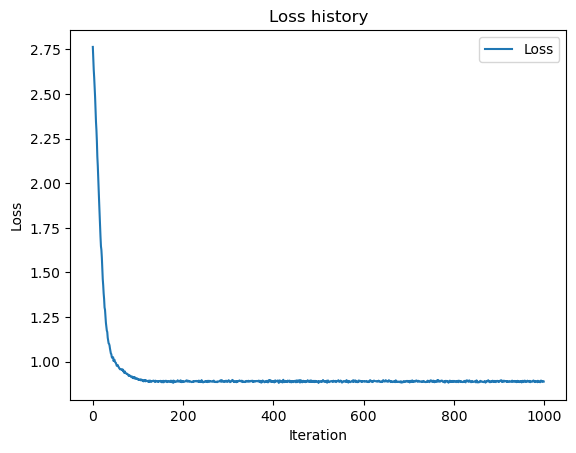

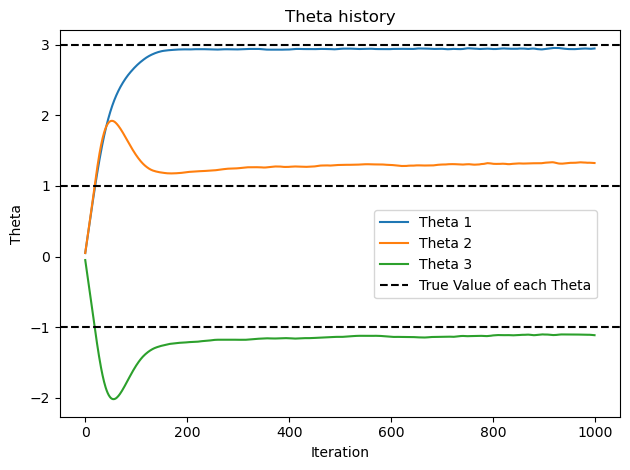

In [2]:
import matplotlib.pyplot as plt

# Convert lists to tensors
theta_historyLMM1_tensor = torch.stack(theta_historyLMM1)
loss_historyLMM1_tensor = torch.tensor(loss_historyLMM1)

# Plot loss history
plt.figure()
plt.plot(loss_historyLMM1_tensor.numpy(), label='Loss')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot theta history
plt.figure()
plt.plot(theta_historyLMM1_tensor[:, 0].numpy(), label='Theta 1')
plt.plot(theta_historyLMM1_tensor[:, 1].numpy(), label='Theta 2')
plt.plot(theta_historyLMM1_tensor[:, 2].numpy(), label='Theta 3')

plt.axhline(y=3, color='black', linestyle='--', label='True Value of each Theta')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=-1, color='black', linestyle='--')

plt.title('Theta history')
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.legend(loc='center', bbox_to_anchor=(0.76, 0.42))  

plt.tight_layout()
plt.show()


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


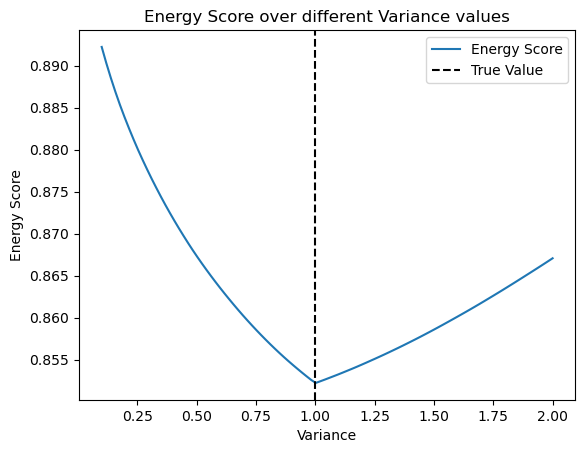

In [8]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
from torch.distributions import constraints
import torch.distributions as dist
import torch.optim as optim
import matplotlib.pyplot as plt

class SpatialLMM():
    '''
    Linear Mixed Model (LMM)
    
    Parameters
    ----------
    grid_size : (int) The number of locations in the grid
    variance : (float) The variance of the random effects
    '''

    def __init__(self, grid_size, variance,design_X, design_Z, covariance_matrix=None):
        

        self.grid_size = grid_size
        self.num_locations = grid_size ** 2

        self.num_regression_covariates = 3

        self.variance = variance  

        self.covariance_matrix = covariance_matrix

        self.design_X = design_X
        self.design_Z = design_Z



    def linear_predictor(self, beta):
        '''
        Computes the linear predictor (X*Beta).
        '''
        linear_pred = torch.matmul(self.design_X, beta)
        return linear_pred
    
    def generate_covariance_matrix(self, variance):
        '''
        Creates a covariance matrix for random effects. Uses the pairwise distances between 
        the locations to get the covariance matrix.
        '''
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = variance * torch.exp(-(pairwise_distances))
         # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)

        return covariance_matrix

    def random_effects(self, covariance_matrix):
        '''
        Computes the random effects (Z*u).
        '''
        # Sample u from a multivariate normal distribution
        u_dist = dist.MultivariateNormal(torch.zeros(self.grid_size**2), covariance_matrix=covariance_matrix)
        u = u_dist.sample()

        # Compute random effects
        rand_effects = torch.matmul(self.design_Z, u)
        return rand_effects

    def forward(self, beta, variance):
        ''' 
        Should be:  X*Beta + Z*u only
        '''
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(variance)
        random_effects_samples = self.random_effects(covariance_matrix)
        error_term = torch.normal(0, 1, size=rand_eff.shape)
        total_effects = linear_pred + random_effects_samples + error_term
        return total_effects


'''
Fixing True Values
'''
choose_beta = torch.tensor((3., 1., -1.))
choose_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1) 
choose_design_Z = torch.eye(choose_grid_size**2)

spatial_lmm = SpatialLMM(grid_size=choose_grid_size,
                    variance=choose_variance,
                    design_X=choose_design_X, 
                    design_Z=choose_design_Z)
spatial_lmm.covariance_matrix = spatial_lmm.generate_covariance_matrix(variance=choose_variance)
num_real_samples = 500
num_fake_samples = 500


'''
Scoring Rule Inference. Choice here is Energy Score.
'''

def Energy_Score(energy_beta, observations_y, simulations_Y):

	m = len(simulations_Y)

	# First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
	diff_Y_y = torch.pow(
		torch.norm(
			(observations_y.unsqueeze(1) -
			simulations_Y.unsqueeze(0)).float(),
			dim=2,keepdim=True).reshape(-1,1),
		energy_beta)

	# Second part |Y-Y'|. 2* because pdist counts only once.
	diff_Y_Y = 2 * torch.pow(
		nn.functional.pdist(simulations_Y),
		energy_beta)
	Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
	return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1,1), fake_samples[i].view(-1,1))
    return out / (len(real_samples) + len(fake_samples)) 


#fix Energy Score Beta = 1
SR_beta = 1.0


'''
real samples (observations) from fixed parameters, (original_beta, original_variance) 500 times
'''

torch.manual_seed(42)  
real_samples = [spatial_lmm.forward(choose_beta, variance=choose_variance) for _ in range(num_real_samples)]
    
SR_E = []
for i in tqdm(torch.linspace(0.1, 2, 100)):
    '''
    fake samples (simulations) from changing parameters, (original_beta, varying variance) 500 times
    '''
    torch.manual_seed(42)  
    fake_samples = [spatial_lmm.forward(choose_beta, variance=i) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(0.1, 2, 100), SR_E , label='Energy Score')

plt.axvline(x=1.0, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance')
plt.ylabel('Energy Score')
plt.title('Energy Score over different Variance values')


plt.show()


# GLMM

In [54]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
from torch.distributions import constraints
import torch.distributions as dist
import torch.optim as optim
import matplotlib.pyplot as plt

class PoissonDistribution:
    def __init__(self):
        pass
    
    def mean(self, linear_predictor):
        '''
        torch.exp( _ ) where _ should be the linear predictor
        '''
        return torch.exp(linear_predictor)
    
    def log_prob(self, value, linear_predictor):
        mean = self.mean(linear_predictor)
        return Poisson(mean).log_prob(value)


class SpatialGLMM():
    '''
    Poisson Spatial Generalized Linear Mixed Model (GLMM)
    
    Parameters
    ----------
    grid_size : (int) The number of locations in the grid
    variance : (float) The variance of the random effects
    '''
    def __init__(self, grid_size, variance,design_X, design_Z, covariance_matrix=None):
        

        self.grid_size = grid_size
        self.num_locations = grid_size ** 2

        self.num_regression_covariates = 3

        self.variance = variance  
        
        self.covariance_matrix = covariance_matrix

        self.poisson_dist = PoissonDistribution()

        self.design_X = design_X
        self.design_Z = design_Z



    def linear_predictor(self, beta):
        '''
        Computes the linear predictor (X*Beta).
        '''
        # Compute linear predictor
        linear_pred = torch.matmul(self.design_X, beta)
        return linear_pred
    
    def generate_covariance_matrix(self):
        '''
        Creates a covariance matrix for random effects. Uses the pairwise distances between 
        the locations to get the covariance matrix.
        '''
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = self.variance * torch.exp(-(pairwise_distances))
        return covariance_matrix

    def random_effects(self, covariance_matrix):
        '''
        Computes the random effects (Z*u).
        '''
        # Sample u from a multivariate normal distribution
        u_dist = dist.MultivariateNormal(torch.zeros(self.grid_size**2), covariance_matrix=covariance_matrix)
        u = u_dist.sample()

        # Compute random effects
        rand_effects = torch.matmul(self.design_Z, u)
        return rand_effects

    def forward(self, beta):
        ''' 
        Should be:  X*Beta + Z*u only
        '''

        # Get the linear predictor (X*Beta)
        linear_pred = self.linear_predictor(beta)

        # Sample random effects (Z*u)
        rand_eff = self.random_effects(self.covariance_matrix)

        # Combine fixed and random effects
        total_effects = linear_pred + rand_eff

        return total_effects


    
'''
Initialise
'''
choose_beta = torch.tensor((3., 1., -1.))
choose_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1) 
choose_design_Z = torch.eye(choose_grid_size**2)

spatial_glmm = SpatialGLMM(grid_size=choose_grid_size,
                    variance=choose_variance,
                    design_X=choose_design_X, 
                    design_Z=choose_design_Z)
spatial_glmm.covariance_matrix = spatial_glmm.generate_covariance_matrix()
num_real_samples = 500
num_fake_samples = 500


'''
Scoring Rule Inference. Choice here is Energy Score.
'''
def Energy_Score_pytorch(beta, observations_y, simulations_Y):

	m = len(simulations_Y)

	# First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
	diff_Y_y = torch.pow(
		torch.norm(
			(observations_y.unsqueeze(1) -
			simulations_Y.unsqueeze(0)).float(),
			dim=2,keepdim=True).reshape(-1,1),
		beta)

	# Second part |Y-Y'|. 2* because pdist counts only once.
	diff_Y_Y = 2 * torch.pow(
		nn.functional.pdist(simulations_Y),
		beta)
	Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
	return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score_pytorch(energy_beta, real_samples[i].view(-1,1), fake_samples[i].view(-1,1))
    return out / (len(real_samples) + len(fake_samples)) 

#fix Energy Score Beta = 1
SR_beta = 1.0



'''
real samples from fixed parameters, (original_beta, original_variance) 500 times
'''
torch.manual_seed(42)
real_samples = [spatial_glmm.forward(choose_beta) for i in range(num_real_samples)]


'''
Initialise
'''
theta_historyGLMM1 = []
loss_historyGLMM1 = []
beta_infer = torch.tensor([0.,0.,0.], requires_grad=True)
optimizer = optim.Adam([beta_infer], lr=0.075)  


from tqdm import tqdm
for epoch in tqdm(range(500)):
    '''
    fake samples (simulations) from changing parameters, (original_beta, varying variance) 500 times
    '''
    torch.manual_seed(42)
    fake_samples = [spatial_glmm.forward(beta_infer) for i in range(num_fake_samples)]
    energy_loss = SR_eval(SR_beta, real_samples, fake_samples)


    energy_loss.backward()
    optimizer.step()
    print('grad:', beta_infer.grad) 
    optimizer.zero_grad()
    with torch.no_grad():
        theta_historyGLMM1.append(beta_infer.clone())
        loss_historyGLMM1.append(energy_loss.item())
        print(f"Epoch {epoch + 1}/{500}, Energy Loss: {energy_loss.item()}, Beta Coefficients: {beta_infer}")


  0%|          | 1/500 [00:00<02:58,  2.79it/s]

grad: tensor([-0.9184, -0.0501,  0.2679])
Epoch 1/500, Energy Loss: 2.8733913898468018, Beta Coefficients: tensor([ 0.0750,  0.0750, -0.0750], requires_grad=True)


  0%|          | 2/500 [00:00<03:25,  2.42it/s]

grad: tensor([-0.9099, -0.0921,  0.2899])
Epoch 2/500, Energy Loss: 2.7778799533843994, Beta Coefficients: tensor([ 0.1500,  0.1480, -0.1501], requires_grad=True)


  1%|          | 3/500 [00:01<03:56,  2.10it/s]

grad: tensor([-0.8936, -0.1382,  0.3120])
Epoch 3/500, Energy Loss: 2.662881851196289, Beta Coefficients: tensor([ 0.2249,  0.2203, -0.2253], requires_grad=True)


  1%|          | 4/500 [00:01<04:24,  1.88it/s]

grad: tensor([-0.8789, -0.1849,  0.3238])
Epoch 4/500, Energy Loss: 2.588815212249756, Beta Coefficients: tensor([ 0.2997,  0.2926, -0.3008], requires_grad=True)


  1%|          | 5/500 [00:02<04:10,  1.98it/s]

grad: tensor([-0.8629, -0.2243,  0.3340])
Epoch 5/500, Energy Loss: 2.5010628700256348, Beta Coefficients: tensor([ 0.3745,  0.3655, -0.3764], requires_grad=True)


  1%|          | 6/500 [00:02<04:06,  2.00it/s]

grad: tensor([-0.8446, -0.2175,  0.3487])
Epoch 6/500, Energy Loss: 2.410029649734497, Beta Coefficients: tensor([ 0.4491,  0.4395, -0.4522], requires_grad=True)


  1%|▏         | 7/500 [00:03<03:47,  2.16it/s]

grad: tensor([-0.8194, -0.2412,  0.3476])
Epoch 7/500, Energy Loss: 2.288329601287842, Beta Coefficients: tensor([ 0.5234,  0.5144, -0.5282], requires_grad=True)


  2%|▏         | 8/500 [00:03<03:38,  2.25it/s]

grad: tensor([-0.7944, -0.2392,  0.3423])
Epoch 8/500, Energy Loss: 2.187082529067993, Beta Coefficients: tensor([ 0.5975,  0.5902, -0.6043], requires_grad=True)


  2%|▏         | 9/500 [00:04<03:51,  2.12it/s]

grad: tensor([-0.7669, -0.2323,  0.3413])
Epoch 9/500, Energy Loss: 2.077624797821045, Beta Coefficients: tensor([ 0.6712,  0.6665, -0.6804], requires_grad=True)


  2%|▏         | 10/500 [00:04<04:00,  2.04it/s]

grad: tensor([-0.7419, -0.2194,  0.3355])
Epoch 10/500, Energy Loss: 1.9993106126785278, Beta Coefficients: tensor([ 0.7445,  0.7431, -0.7565], requires_grad=True)


  2%|▏         | 11/500 [00:05<03:56,  2.07it/s]

grad: tensor([-0.6975, -0.1997,  0.3085])
Epoch 11/500, Energy Loss: 1.87314772605896, Beta Coefficients: tensor([ 0.8172,  0.8196, -0.8322], requires_grad=True)


  2%|▏         | 12/500 [00:05<03:44,  2.17it/s]

grad: tensor([-0.6601, -0.1768,  0.2860])
Epoch 12/500, Energy Loss: 1.778564691543579, Beta Coefficients: tensor([ 0.8892,  0.8955, -0.9072], requires_grad=True)


  3%|▎         | 13/500 [00:06<03:40,  2.20it/s]

grad: tensor([-0.6329, -0.1571,  0.2779])
Epoch 13/500, Energy Loss: 1.708156943321228, Beta Coefficients: tensor([ 0.9605,  0.9703, -0.9817], requires_grad=True)


  3%|▎         | 14/500 [00:06<03:37,  2.23it/s]

grad: tensor([-0.6055, -0.1307,  0.2627])
Epoch 14/500, Energy Loss: 1.6417540311813354, Beta Coefficients: tensor([ 1.0309,  1.0435, -1.0553], requires_grad=True)


  3%|▎         | 15/500 [00:07<03:48,  2.12it/s]

grad: tensor([-0.5613, -0.1063,  0.2390])
Epoch 15/500, Energy Loss: 1.5499147176742554, Beta Coefficients: tensor([ 1.1003,  1.1144, -1.1279], requires_grad=True)


  3%|▎         | 16/500 [00:07<03:42,  2.17it/s]

grad: tensor([-0.5387, -0.0777,  0.2265])
Epoch 16/500, Energy Loss: 1.5199555158615112, Beta Coefficients: tensor([ 1.1686,  1.1824, -1.1994], requires_grad=True)


  3%|▎         | 17/500 [00:07<03:43,  2.16it/s]

grad: tensor([-0.5032, -0.0552,  0.2023])
Epoch 17/500, Energy Loss: 1.4491645097732544, Beta Coefficients: tensor([ 1.2358,  1.2467, -1.2695], requires_grad=True)


  4%|▎         | 18/500 [00:08<03:48,  2.11it/s]

grad: tensor([-0.4733, -0.0343,  0.1843])
Epoch 18/500, Energy Loss: 1.4036651849746704, Beta Coefficients: tensor([ 1.3018,  1.3068, -1.3379], requires_grad=True)


  4%|▍         | 19/500 [00:08<03:43,  2.15it/s]

grad: tensor([-0.4445, -0.0162,  0.1667])
Epoch 19/500, Energy Loss: 1.3588430881500244, Beta Coefficients: tensor([ 1.3664,  1.3623, -1.4046], requires_grad=True)


  4%|▍         | 20/500 [00:09<03:36,  2.21it/s]

grad: tensor([-0.4139,  0.0024,  0.1517])
Epoch 20/500, Energy Loss: 1.3124152421951294, Beta Coefficients: tensor([ 1.4297,  1.4126, -1.4693], requires_grad=True)


  4%|▍         | 21/500 [00:09<03:32,  2.25it/s]

grad: tensor([-0.3858,  0.0212,  0.1362])
Epoch 21/500, Energy Loss: 1.282059669494629, Beta Coefficients: tensor([ 1.4914,  1.4572, -1.5320], requires_grad=True)


  4%|▍         | 22/500 [00:10<03:25,  2.32it/s]

grad: tensor([-0.3624,  0.0326,  0.1203])
Epoch 22/500, Energy Loss: 1.2534972429275513, Beta Coefficients: tensor([ 1.5516,  1.4961, -1.5924], requires_grad=True)


  5%|▍         | 23/500 [00:10<03:22,  2.36it/s]

grad: tensor([-0.3438,  0.0449,  0.1118])
Epoch 23/500, Energy Loss: 1.237231731414795, Beta Coefficients: tensor([ 1.6102,  1.5289, -1.6507], requires_grad=True)


  5%|▍         | 24/500 [00:11<03:27,  2.29it/s]

grad: tensor([-0.3173,  0.0570,  0.0945])
Epoch 24/500, Energy Loss: 1.1993730068206787, Beta Coefficients: tensor([ 1.6673,  1.5555, -1.7065], requires_grad=True)


  5%|▌         | 25/500 [00:11<03:21,  2.36it/s]

grad: tensor([-0.3051,  0.0637,  0.0891])
Epoch 25/500, Energy Loss: 1.1915568113327026, Beta Coefficients: tensor([ 1.7227,  1.5761, -1.7600], requires_grad=True)


  5%|▌         | 26/500 [00:11<03:08,  2.51it/s]

grad: tensor([-0.2797,  0.0713,  0.0762])
Epoch 26/500, Energy Loss: 1.1624329090118408, Beta Coefficients: tensor([ 1.7766,  1.5907, -1.8111], requires_grad=True)


  5%|▌         | 27/500 [00:12<03:01,  2.61it/s]

grad: tensor([-0.2609,  0.0751,  0.0647])
Epoch 27/500, Energy Loss: 1.1488773822784424, Beta Coefficients: tensor([ 1.8287,  1.5998, -1.8597], requires_grad=True)


  6%|▌         | 28/500 [00:12<02:54,  2.71it/s]

grad: tensor([-0.2433,  0.0805,  0.0538])
Epoch 28/500, Energy Loss: 1.131507396697998, Beta Coefficients: tensor([ 1.8791,  1.6033, -1.9056], requires_grad=True)


  6%|▌         | 29/500 [00:12<02:51,  2.75it/s]

grad: tensor([-0.2202,  0.0842,  0.0420])
Epoch 29/500, Energy Loss: 1.1134812831878662, Beta Coefficients: tensor([ 1.9278,  1.6017, -1.9488], requires_grad=True)


  6%|▌         | 30/500 [00:13<02:50,  2.76it/s]

grad: tensor([-0.2169,  0.0828,  0.0401])
Epoch 30/500, Energy Loss: 1.1140002012252808, Beta Coefficients: tensor([ 1.9748,  1.5955, -1.9895], requires_grad=True)


  6%|▌         | 31/500 [00:13<03:16,  2.38it/s]

grad: tensor([-0.1901,  0.0845,  0.0266])
Epoch 31/500, Energy Loss: 1.0949896574020386, Beta Coefficients: tensor([ 2.0201,  1.5850, -2.0274], requires_grad=True)


  6%|▋         | 32/500 [00:14<03:37,  2.15it/s]

grad: tensor([-0.1806,  0.0860,  0.0198])
Epoch 32/500, Energy Loss: 1.0896445512771606, Beta Coefficients: tensor([ 2.0636,  1.5704, -2.0626], requires_grad=True)


  7%|▋         | 33/500 [00:14<03:49,  2.04it/s]

grad: tensor([-0.1571,  0.0856,  0.0064])
Epoch 33/500, Energy Loss: 1.0710445642471313, Beta Coefficients: tensor([ 2.1053,  1.5523, -2.0949], requires_grad=True)


  7%|▋         | 34/500 [00:15<03:58,  1.95it/s]

grad: tensor([-0.1478,  0.0824,  0.0011])
Epoch 34/500, Energy Loss: 1.0684913396835327, Beta Coefficients: tensor([ 2.1452,  1.5309, -2.1244], requires_grad=True)


  7%|▋         | 35/500 [00:15<03:55,  1.98it/s]

grad: tensor([-0.1395,  0.0814, -0.0025])
Epoch 35/500, Energy Loss: 1.0615001916885376, Beta Coefficients: tensor([ 2.1835,  1.5068, -2.1512], requires_grad=True)


  7%|▋         | 36/500 [00:16<04:07,  1.88it/s]

grad: tensor([-0.1228,  0.0789, -0.0116])
Epoch 36/500, Energy Loss: 1.0555857419967651, Beta Coefficients: tensor([ 2.2200,  1.4802, -2.1751], requires_grad=True)


  7%|▋         | 37/500 [00:16<04:04,  1.90it/s]

grad: tensor([-0.1181,  0.0739, -0.0129])
Epoch 37/500, Energy Loss: 1.0507643222808838, Beta Coefficients: tensor([ 2.2548,  1.4516, -2.1964], requires_grad=True)


  8%|▊         | 38/500 [00:17<04:02,  1.91it/s]

grad: tensor([-0.1001,  0.0724, -0.0234])
Epoch 38/500, Energy Loss: 1.0439980030059814, Beta Coefficients: tensor([ 2.2879,  1.4214, -2.2150], requires_grad=True)


  8%|▊         | 39/500 [00:17<03:39,  2.10it/s]

grad: tensor([-0.0862,  0.0668, -0.0300])
Epoch 39/500, Energy Loss: 1.045606255531311, Beta Coefficients: tensor([ 2.3193,  1.3898, -2.2308], requires_grad=True)


  8%|▊         | 40/500 [00:18<03:22,  2.28it/s]

grad: tensor([-0.0827,  0.0603, -0.0286])
Epoch 40/500, Energy Loss: 1.030877709388733, Beta Coefficients: tensor([ 2.3490,  1.3575, -2.2441], requires_grad=True)


  8%|▊         | 41/500 [00:18<03:09,  2.42it/s]

grad: tensor([-0.0690,  0.0620, -0.0389])
Epoch 41/500, Energy Loss: 1.0296663045883179, Beta Coefficients: tensor([ 2.3770,  1.3244, -2.2548], requires_grad=True)


  8%|▊         | 42/500 [00:18<03:01,  2.52it/s]

grad: tensor([-0.0668,  0.0564, -0.0403])
Epoch 42/500, Energy Loss: 1.030216932296753, Beta Coefficients: tensor([ 2.4035,  1.2907, -2.2630], requires_grad=True)


  9%|▊         | 43/500 [00:19<03:04,  2.47it/s]

grad: tensor([-0.0567,  0.0557, -0.0445])
Epoch 43/500, Energy Loss: 1.0229543447494507, Beta Coefficients: tensor([ 2.4284,  1.2567, -2.2687], requires_grad=True)


  9%|▉         | 44/500 [00:19<03:00,  2.52it/s]

grad: tensor([-0.0540,  0.0539, -0.0455])
Epoch 44/500, Energy Loss: 1.0227460861206055, Beta Coefficients: tensor([ 2.4519,  1.2224, -2.2721], requires_grad=True)


  9%|▉         | 45/500 [00:20<03:04,  2.47it/s]

grad: tensor([-0.0449,  0.0488, -0.0497])
Epoch 45/500, Energy Loss: 1.0170537233352661, Beta Coefficients: tensor([ 2.4740,  1.1881, -2.2733], requires_grad=True)


  9%|▉         | 46/500 [00:20<03:06,  2.44it/s]

grad: tensor([-0.0484,  0.0464, -0.0471])
Epoch 46/500, Energy Loss: 1.0158054828643799, Beta Coefficients: tensor([ 2.4948,  1.1540, -2.2725], requires_grad=True)


  9%|▉         | 47/500 [00:20<03:02,  2.49it/s]

grad: tensor([-0.0290,  0.0419, -0.0546])
Epoch 47/500, Energy Loss: 1.0105167627334595, Beta Coefficients: tensor([ 2.5141,  1.1202, -2.2696], requires_grad=True)


 10%|▉         | 48/500 [00:21<03:00,  2.51it/s]

grad: tensor([-0.0266,  0.0407, -0.0552])
Epoch 48/500, Energy Loss: 1.0114182233810425, Beta Coefficients: tensor([ 2.5321,  1.0869, -2.2647], requires_grad=True)


 10%|▉         | 49/500 [00:21<02:51,  2.64it/s]

grad: tensor([-0.0183,  0.0339, -0.0573])
Epoch 49/500, Energy Loss: 1.013612985610962, Beta Coefficients: tensor([ 2.5488,  1.0544, -2.2580], requires_grad=True)


 10%|█         | 50/500 [00:22<02:53,  2.59it/s]

grad: tensor([-0.0185,  0.0353, -0.0559])
Epoch 50/500, Energy Loss: 1.0065594911575317, Beta Coefficients: tensor([ 2.5642,  1.0226, -2.2496], requires_grad=True)


 10%|█         | 51/500 [00:22<02:50,  2.63it/s]

grad: tensor([-0.0048,  0.0291, -0.0587])
Epoch 51/500, Energy Loss: 1.0061951875686646, Beta Coefficients: tensor([ 2.5783,  0.9917, -2.2396], requires_grad=True)


 10%|█         | 52/500 [00:22<02:45,  2.70it/s]

grad: tensor([-0.0006,  0.0263, -0.0604])
Epoch 52/500, Energy Loss: 0.999531626701355, Beta Coefficients: tensor([ 2.5911,  0.9618, -2.2279], requires_grad=True)


 11%|█         | 53/500 [00:23<02:45,  2.70it/s]

grad: tensor([ 0.0040,  0.0233, -0.0609])
Epoch 53/500, Energy Loss: 1.0037388801574707, Beta Coefficients: tensor([ 2.6027,  0.9331, -2.2148], requires_grad=True)


 11%|█         | 54/500 [00:23<02:43,  2.73it/s]

grad: tensor([-0.0036,  0.0207, -0.0562])
Epoch 54/500, Energy Loss: 1.0011460781097412, Beta Coefficients: tensor([ 2.6133,  0.9056, -2.2005], requires_grad=True)


 11%|█         | 55/500 [00:23<02:39,  2.79it/s]

grad: tensor([-0.0077,  0.0219, -0.0535])
Epoch 55/500, Energy Loss: 1.0009307861328125, Beta Coefficients: tensor([ 2.6230,  0.8790, -2.1853], requires_grad=True)


 11%|█         | 56/500 [00:24<02:42,  2.73it/s]

grad: tensor([ 0.0012,  0.0196, -0.0554])
Epoch 56/500, Energy Loss: 0.9931473135948181, Beta Coefficients: tensor([ 2.6318,  0.8536, -2.1691], requires_grad=True)


 11%|█▏        | 57/500 [00:24<02:39,  2.78it/s]

grad: tensor([-0.0059,  0.0205, -0.0503])
Epoch 57/500, Energy Loss: 0.9949890375137329, Beta Coefficients: tensor([ 2.6399,  0.8290, -2.1522], requires_grad=True)


 12%|█▏        | 58/500 [00:24<02:38,  2.79it/s]

grad: tensor([ 0.0074,  0.0144, -0.0527])
Epoch 58/500, Energy Loss: 0.9955447912216187, Beta Coefficients: tensor([ 2.6472,  0.8057, -2.1346], requires_grad=True)


 12%|█▏        | 59/500 [00:25<02:41,  2.73it/s]

grad: tensor([ 0.0040,  0.0144, -0.0481])
Epoch 59/500, Energy Loss: 0.9992729425430298, Beta Coefficients: tensor([ 2.6536,  0.7834, -2.1165], requires_grad=True)


 12%|█▏        | 60/500 [00:25<02:38,  2.77it/s]

grad: tensor([ 0.0077,  0.0157, -0.0503])
Epoch 60/500, Energy Loss: 0.9988150000572205, Beta Coefficients: tensor([ 2.6594,  0.7621, -2.0978], requires_grad=True)


 12%|█▏        | 61/500 [00:26<02:36,  2.80it/s]

grad: tensor([ 0.0164,  0.0109, -0.0492])
Epoch 61/500, Energy Loss: 0.99501633644104, Beta Coefficients: tensor([ 2.6644,  0.7420, -2.0787], requires_grad=True)


 12%|█▏        | 62/500 [00:26<02:35,  2.81it/s]

grad: tensor([-0.0043,  0.0119, -0.0376])
Epoch 62/500, Energy Loss: 0.9907475709915161, Beta Coefficients: tensor([ 2.6689,  0.7228, -2.0597], requires_grad=True)


 13%|█▎        | 63/500 [00:26<02:38,  2.76it/s]

grad: tensor([-0.0041,  0.0097, -0.0401])
Epoch 63/500, Energy Loss: 0.9934629797935486, Beta Coefficients: tensor([ 2.6731,  0.7047, -2.0406], requires_grad=True)


 13%|█▎        | 64/500 [00:27<02:43,  2.67it/s]

grad: tensor([ 0.0071,  0.0082, -0.0390])
Epoch 64/500, Energy Loss: 0.9864318370819092, Beta Coefficients: tensor([ 2.6768,  0.6876, -2.0215], requires_grad=True)


 13%|█▎        | 65/500 [00:27<02:39,  2.72it/s]

grad: tensor([-0.0024,  0.0071, -0.0334])
Epoch 65/500, Energy Loss: 0.9937033653259277, Beta Coefficients: tensor([ 2.6802,  0.6716, -2.0026], requires_grad=True)


 13%|█▎        | 66/500 [00:27<02:37,  2.76it/s]

grad: tensor([-0.0032,  0.0035, -0.0293])
Epoch 66/500, Energy Loss: 0.9895327687263489, Beta Coefficients: tensor([ 2.6834,  0.6568, -1.9842], requires_grad=True)


 13%|█▎        | 67/500 [00:28<02:38,  2.72it/s]

grad: tensor([-0.0068,  0.0059, -0.0300])
Epoch 67/500, Energy Loss: 0.9846045970916748, Beta Coefficients: tensor([ 2.6863,  0.6430, -1.9660], requires_grad=True)


 14%|█▎        | 68/500 [00:28<02:41,  2.68it/s]

grad: tensor([ 0.0064,  0.0016, -0.0304])
Epoch 68/500, Energy Loss: 0.9879827499389648, Beta Coefficients: tensor([ 2.6889,  0.6303, -1.9481], requires_grad=True)


 14%|█▍        | 69/500 [00:29<02:47,  2.57it/s]

grad: tensor([-0.0010,  0.0036, -0.0287])
Epoch 69/500, Energy Loss: 0.9870358109474182, Beta Coefficients: tensor([ 2.6913,  0.6185, -1.9306], requires_grad=True)


 14%|█▍        | 70/500 [00:29<02:54,  2.47it/s]

grad: tensor([-0.0019,  0.0003, -0.0245])
Epoch 70/500, Energy Loss: 0.9851087331771851, Beta Coefficients: tensor([ 2.6934,  0.6077, -1.9135], requires_grad=True)


 14%|█▍        | 71/500 [00:30<03:05,  2.31it/s]

grad: tensor([ 8.9609e-05,  2.1611e-03, -2.4405e-02])
Epoch 71/500, Energy Loss: 0.9869816303253174, Beta Coefficients: tensor([ 2.6954,  0.5978, -1.8968], requires_grad=True)


 14%|█▍        | 72/500 [00:30<03:09,  2.26it/s]

grad: tensor([-0.0006, -0.0007, -0.0205])
Epoch 72/500, Energy Loss: 0.9845149517059326, Beta Coefficients: tensor([ 2.6972,  0.5889, -1.8807], requires_grad=True)


 15%|█▍        | 73/500 [00:30<03:10,  2.24it/s]

grad: tensor([-0.0101, -0.0022, -0.0146])
Epoch 73/500, Energy Loss: 0.9846265316009521, Beta Coefficients: tensor([ 2.6990,  0.5810, -1.8654], requires_grad=True)


 15%|█▍        | 74/500 [00:31<03:05,  2.30it/s]

grad: tensor([ 0.0007, -0.0007, -0.0153])
Epoch 74/500, Energy Loss: 0.9892028570175171, Beta Coefficients: tensor([ 2.7006,  0.5739, -1.8507], requires_grad=True)


 15%|█▌        | 75/500 [00:31<02:54,  2.43it/s]

grad: tensor([-0.0237, -0.0023, -0.0070])
Epoch 75/500, Energy Loss: 0.9805485606193542, Beta Coefficients: tensor([ 2.7026,  0.5677, -1.8371], requires_grad=True)


 15%|█▌        | 76/500 [00:32<02:46,  2.55it/s]

grad: tensor([-0.0081, -0.0028, -0.0138])
Epoch 76/500, Energy Loss: 0.983184814453125, Beta Coefficients: tensor([ 2.7045,  0.5622, -1.8241], requires_grad=True)


 15%|█▌        | 77/500 [00:32<02:40,  2.63it/s]

grad: tensor([-0.0145, -0.0030, -0.0067])
Epoch 77/500, Energy Loss: 0.9850431680679321, Beta Coefficients: tensor([ 2.7065,  0.5576, -1.8120], requires_grad=True)


 16%|█▌        | 78/500 [00:32<02:42,  2.59it/s]

grad: tensor([-0.0149, -0.0047, -0.0047])
Epoch 78/500, Energy Loss: 0.9832161664962769, Beta Coefficients: tensor([ 2.7087,  0.5537, -1.8007], requires_grad=True)


 16%|█▌        | 79/500 [00:33<02:49,  2.49it/s]

grad: tensor([-0.0224, -0.0025, -0.0020])
Epoch 79/500, Energy Loss: 0.9837247133255005, Beta Coefficients: tensor([ 2.7110,  0.5505, -1.7905], requires_grad=True)


 16%|█▌        | 80/500 [00:33<02:54,  2.41it/s]

grad: tensor([-0.0157, -0.0063, -0.0047])
Epoch 80/500, Energy Loss: 0.9835271239280701, Beta Coefficients: tensor([ 2.7135,  0.5480, -1.7809], requires_grad=True)


 16%|█▌        | 81/500 [00:34<02:47,  2.50it/s]

grad: tensor([-0.0097, -0.0073, -0.0018])
Epoch 81/500, Energy Loss: 0.9875688552856445, Beta Coefficients: tensor([ 2.7160,  0.5464, -1.7722], requires_grad=True)


 16%|█▋        | 82/500 [00:34<02:43,  2.56it/s]

grad: tensor([-2.4122e-02, -7.2739e-03, -9.1871e-05])
Epoch 82/500, Energy Loss: 0.9850540161132812, Beta Coefficients: tensor([ 2.7187,  0.5456, -1.7642], requires_grad=True)


 17%|█▋        | 83/500 [00:34<02:37,  2.64it/s]

grad: tensor([-0.0092, -0.0058, -0.0061])
Epoch 83/500, Energy Loss: 0.9821569323539734, Beta Coefficients: tensor([ 2.7213,  0.5454, -1.7567], requires_grad=True)


 17%|█▋        | 84/500 [00:35<02:33,  2.71it/s]

grad: tensor([-0.0112, -0.0074, -0.0002])
Epoch 84/500, Energy Loss: 0.9819796681404114, Beta Coefficients: tensor([ 2.7239,  0.5459, -1.7500], requires_grad=True)


 17%|█▋        | 85/500 [00:35<02:35,  2.67it/s]

grad: tensor([-0.0168, -0.0060, -0.0012])
Epoch 85/500, Energy Loss: 0.9868754744529724, Beta Coefficients: tensor([ 2.7266,  0.5468, -1.7437], requires_grad=True)


 17%|█▋        | 86/500 [00:35<02:31,  2.73it/s]

grad: tensor([-0.0165, -0.0065,  0.0005])
Epoch 86/500, Energy Loss: 0.9843471050262451, Beta Coefficients: tensor([ 2.7295,  0.5482, -1.7381], requires_grad=True)


 17%|█▋        | 87/500 [00:36<02:29,  2.77it/s]

grad: tensor([-0.0091, -0.0044, -0.0027])
Epoch 87/500, Energy Loss: 0.9787877798080444, Beta Coefficients: tensor([ 2.7322,  0.5498, -1.7329], requires_grad=True)


 18%|█▊        | 88/500 [00:36<02:27,  2.80it/s]

grad: tensor([-0.0246, -0.0085,  0.0055])
Epoch 88/500, Energy Loss: 0.9857708811759949, Beta Coefficients: tensor([ 2.7352,  0.5521, -1.7285], requires_grad=True)


 18%|█▊        | 89/500 [00:36<02:28,  2.77it/s]

grad: tensor([-0.0084, -0.0083, -0.0018])
Epoch 89/500, Energy Loss: 0.9832985997200012, Beta Coefficients: tensor([ 2.7381,  0.5549, -1.7244], requires_grad=True)


 18%|█▊        | 90/500 [00:37<02:28,  2.76it/s]

grad: tensor([-0.0167, -0.0099,  0.0036])
Epoch 90/500, Energy Loss: 0.9801206588745117, Beta Coefficients: tensor([ 2.7411,  0.5583, -1.7209], requires_grad=True)


 18%|█▊        | 91/500 [00:37<02:32,  2.67it/s]

grad: tensor([ 0.0023, -0.0107, -0.0045])
Epoch 91/500, Energy Loss: 0.9838980436325073, Beta Coefficients: tensor([ 2.7437,  0.5624, -1.7174], requires_grad=True)


 18%|█▊        | 92/500 [00:38<02:31,  2.69it/s]

grad: tensor([-0.0075, -0.0060, -0.0022])
Epoch 92/500, Energy Loss: 0.9799659848213196, Beta Coefficients: tensor([ 2.7463,  0.5666, -1.7142], requires_grad=True)


 19%|█▊        | 93/500 [00:38<02:30,  2.70it/s]

grad: tensor([-0.0128, -0.0058,  0.0018])
Epoch 93/500, Energy Loss: 0.9864203333854675, Beta Coefficients: tensor([ 2.7489,  0.5709, -1.7114], requires_grad=True)


 19%|█▉        | 94/500 [00:38<02:27,  2.75it/s]

grad: tensor([-0.0103, -0.0090,  0.0021])
Epoch 94/500, Energy Loss: 0.9845525026321411, Beta Coefficients: tensor([ 2.7515,  0.5757, -1.7089], requires_grad=True)


 19%|█▉        | 95/500 [00:39<02:30,  2.70it/s]

grad: tensor([-0.0049, -0.0098, -0.0015])
Epoch 95/500, Energy Loss: 0.9785188436508179, Beta Coefficients: tensor([ 2.7539,  0.5809, -1.7066], requires_grad=True)


 19%|█▉        | 96/500 [00:39<02:28,  2.71it/s]

grad: tensor([-0.0004, -0.0062, -0.0039])
Epoch 96/500, Energy Loss: 0.979788601398468, Beta Coefficients: tensor([ 2.7561,  0.5862, -1.7043], requires_grad=True)


 19%|█▉        | 97/500 [00:39<02:36,  2.58it/s]

grad: tensor([-0.0023, -0.0090, -0.0019])
Epoch 97/500, Energy Loss: 0.9797465801239014, Beta Coefficients: tensor([ 2.7582,  0.5919, -1.7022], requires_grad=True)


 20%|█▉        | 98/500 [00:40<02:36,  2.57it/s]

grad: tensor([-0.0106, -0.0064, -0.0002])
Epoch 98/500, Energy Loss: 0.9909620881080627, Beta Coefficients: tensor([ 2.7603,  0.5976, -1.7002], requires_grad=True)


 20%|█▉        | 99/500 [00:40<02:38,  2.53it/s]

grad: tensor([-0.0075, -0.0085, -0.0015])
Epoch 99/500, Energy Loss: 0.9808008074760437, Beta Coefficients: tensor([ 2.7623,  0.6035, -1.6983], requires_grad=True)


 20%|██        | 100/500 [00:41<02:39,  2.51it/s]

grad: tensor([-0.0066, -0.0057, -0.0002])
Epoch 100/500, Energy Loss: 0.9791925549507141, Beta Coefficients: tensor([ 2.7644,  0.6095, -1.6966], requires_grad=True)


 20%|██        | 101/500 [00:41<02:40,  2.49it/s]

grad: tensor([-0.0035, -0.0102, -0.0031])
Epoch 101/500, Energy Loss: 0.9846584796905518, Beta Coefficients: tensor([ 2.7663,  0.6158, -1.6949], requires_grad=True)


 20%|██        | 102/500 [00:41<02:39,  2.49it/s]

grad: tensor([-0.0056, -0.0083,  0.0002])
Epoch 102/500, Energy Loss: 0.9842401742935181, Beta Coefficients: tensor([ 2.7681,  0.6223, -1.6933], requires_grad=True)


 21%|██        | 103/500 [00:42<02:36,  2.53it/s]

grad: tensor([-0.0007, -0.0088, -0.0067])
Epoch 103/500, Energy Loss: 0.9824739098548889, Beta Coefficients: tensor([ 2.7698,  0.6291, -1.6915], requires_grad=True)


 21%|██        | 104/500 [00:42<02:40,  2.47it/s]

grad: tensor([-0.0032, -0.0100, -0.0046])
Epoch 104/500, Energy Loss: 0.980522096157074, Beta Coefficients: tensor([ 2.7714,  0.6362, -1.6896], requires_grad=True)


 21%|██        | 105/500 [00:43<02:43,  2.42it/s]

grad: tensor([-0.0038, -0.0089, -0.0028])
Epoch 105/500, Energy Loss: 0.982813835144043, Beta Coefficients: tensor([ 2.7730,  0.6435, -1.6878], requires_grad=True)


 21%|██        | 106/500 [00:43<02:41,  2.44it/s]

grad: tensor([-0.0042, -0.0080, -0.0025])
Epoch 106/500, Energy Loss: 0.9827893972396851, Beta Coefficients: tensor([ 2.7744,  0.6508, -1.6859], requires_grad=True)


 21%|██▏       | 107/500 [00:43<02:36,  2.51it/s]

grad: tensor([ 0.0004, -0.0082, -0.0054])
Epoch 107/500, Energy Loss: 0.9829756021499634, Beta Coefficients: tensor([ 2.7758,  0.6583, -1.6839], requires_grad=True)


 22%|██▏       | 108/500 [00:44<02:30,  2.60it/s]

grad: tensor([-0.0166, -0.0073,  0.0014])
Epoch 108/500, Energy Loss: 0.9843320250511169, Beta Coefficients: tensor([ 2.7774,  0.6658, -1.6822], requires_grad=True)


 22%|██▏       | 109/500 [00:44<02:35,  2.52it/s]

grad: tensor([-0.0052, -0.0061, -0.0030])
Epoch 109/500, Energy Loss: 0.9787079691886902, Beta Coefficients: tensor([ 2.7790,  0.6731, -1.6805], requires_grad=True)


 22%|██▏       | 110/500 [00:45<02:37,  2.47it/s]

grad: tensor([-0.0104, -0.0094,  0.0024])
Epoch 110/500, Energy Loss: 0.9869529008865356, Beta Coefficients: tensor([ 2.7806,  0.6808, -1.6791], requires_grad=True)


 22%|██▏       | 111/500 [00:45<02:46,  2.33it/s]

grad: tensor([-0.0024, -0.0070, -0.0079])
Epoch 111/500, Energy Loss: 0.9809167385101318, Beta Coefficients: tensor([ 2.7822,  0.6883, -1.6773], requires_grad=True)


 22%|██▏       | 112/500 [00:46<02:48,  2.30it/s]

grad: tensor([-0.0055, -0.0063, -0.0028])
Epoch 112/500, Energy Loss: 0.981554388999939, Beta Coefficients: tensor([ 2.7837,  0.6958, -1.6755], requires_grad=True)


 23%|██▎       | 113/500 [00:46<02:46,  2.33it/s]

grad: tensor([ 0.0062, -0.0102, -0.0072])
Epoch 113/500, Energy Loss: 0.9824035167694092, Beta Coefficients: tensor([ 2.7850,  0.7036, -1.6735], requires_grad=True)


 23%|██▎       | 114/500 [00:46<02:48,  2.30it/s]

grad: tensor([-0.0050, -0.0062, -0.0018])
Epoch 114/500, Energy Loss: 0.9848693013191223, Beta Coefficients: tensor([ 2.7863,  0.7113, -1.6715], requires_grad=True)


 23%|██▎       | 115/500 [00:47<02:40,  2.39it/s]

grad: tensor([ 0.0005, -0.0079, -0.0049])
Epoch 115/500, Energy Loss: 0.9834905862808228, Beta Coefficients: tensor([ 2.7874,  0.7191, -1.6694], requires_grad=True)


 23%|██▎       | 116/500 [00:47<02:39,  2.41it/s]

grad: tensor([-0.0079, -0.0058, -0.0047])
Epoch 116/500, Energy Loss: 0.9826570749282837, Beta Coefficients: tensor([ 2.7886,  0.7267, -1.6673], requires_grad=True)


 23%|██▎       | 117/500 [00:48<02:32,  2.51it/s]

grad: tensor([-0.0126, -0.0037, -0.0028])
Epoch 117/500, Energy Loss: 0.981188178062439, Beta Coefficients: tensor([ 2.7900,  0.7339, -1.6651], requires_grad=True)


 24%|██▎       | 118/500 [00:48<02:27,  2.59it/s]

grad: tensor([ 0.0029, -0.0069, -0.0078])
Epoch 118/500, Energy Loss: 0.9780758619308472, Beta Coefficients: tensor([ 2.7912,  0.7412, -1.6627], requires_grad=True)


 24%|██▍       | 119/500 [00:48<02:30,  2.54it/s]

grad: tensor([-0.0006, -0.0064, -0.0076])
Epoch 119/500, Energy Loss: 0.9795565009117126, Beta Coefficients: tensor([ 2.7923,  0.7485, -1.6600], requires_grad=True)


 24%|██▍       | 120/500 [00:49<02:34,  2.46it/s]

grad: tensor([-0.0017, -0.0066, -0.0061])
Epoch 120/500, Energy Loss: 0.979875385761261, Beta Coefficients: tensor([ 2.7933,  0.7557, -1.6572], requires_grad=True)


 24%|██▍       | 121/500 [00:49<02:39,  2.38it/s]

grad: tensor([-0.0016, -0.0061, -0.0065])
Epoch 121/500, Energy Loss: 0.981138288974762, Beta Coefficients: tensor([ 2.7943,  0.7629, -1.6543], requires_grad=True)


 24%|██▍       | 122/500 [00:50<02:47,  2.25it/s]

grad: tensor([-0.0044, -0.0051, -0.0040])
Epoch 122/500, Energy Loss: 0.9823453426361084, Beta Coefficients: tensor([ 2.7953,  0.7700, -1.6514], requires_grad=True)


 25%|██▍       | 123/500 [00:50<02:46,  2.27it/s]

grad: tensor([ 0.0007, -0.0061, -0.0058])
Epoch 123/500, Energy Loss: 0.9840781688690186, Beta Coefficients: tensor([ 2.7962,  0.7770, -1.6484], requires_grad=True)


 25%|██▍       | 124/500 [00:51<03:04,  2.04it/s]

grad: tensor([ 0.0013, -0.0042, -0.0093])
Epoch 124/500, Energy Loss: 0.984169602394104, Beta Coefficients: tensor([ 2.7969,  0.7837, -1.6451], requires_grad=True)


 25%|██▌       | 125/500 [00:51<03:00,  2.08it/s]

grad: tensor([-0.0050, -0.0053, -0.0044])
Epoch 125/500, Energy Loss: 0.9750450849533081, Beta Coefficients: tensor([ 2.7977,  0.7904, -1.6418], requires_grad=True)


 25%|██▌       | 126/500 [00:52<02:48,  2.22it/s]

grad: tensor([-0.0142, -0.0046, -0.0035])
Epoch 126/500, Energy Loss: 0.9770974516868591, Beta Coefficients: tensor([ 2.7988,  0.7970, -1.6386], requires_grad=True)


 25%|██▌       | 127/500 [00:52<02:57,  2.10it/s]

grad: tensor([-0.0130, -0.0052, -0.0017])
Epoch 127/500, Energy Loss: 0.9798452854156494, Beta Coefficients: tensor([ 2.8002,  0.8034, -1.6356], requires_grad=True)


 26%|██▌       | 128/500 [00:53<02:55,  2.12it/s]

grad: tensor([-0.0036, -0.0061, -0.0082])
Epoch 128/500, Energy Loss: 0.9796465039253235, Beta Coefficients: tensor([ 2.8014,  0.8100, -1.6323], requires_grad=True)


 26%|██▌       | 129/500 [00:53<02:42,  2.29it/s]

grad: tensor([-0.0058, -0.0055, -0.0068])
Epoch 129/500, Energy Loss: 0.9754025936126709, Beta Coefficients: tensor([ 2.8028,  0.8164, -1.6289], requires_grad=True)


 26%|██▌       | 130/500 [00:53<02:33,  2.41it/s]

grad: tensor([-0.0026, -0.0072, -0.0060])
Epoch 130/500, Energy Loss: 0.9832947850227356, Beta Coefficients: tensor([ 2.8040,  0.8231, -1.6255], requires_grad=True)


 26%|██▌       | 131/500 [00:54<02:25,  2.53it/s]

grad: tensor([-0.0023, -0.0033, -0.0068])
Epoch 131/500, Energy Loss: 0.9782357811927795, Beta Coefficients: tensor([ 2.8052,  0.8294, -1.6219], requires_grad=True)


 26%|██▋       | 132/500 [00:54<02:20,  2.61it/s]

grad: tensor([-0.0079, -0.0031, -0.0062])
Epoch 132/500, Energy Loss: 0.9784281253814697, Beta Coefficients: tensor([ 2.8065,  0.8355, -1.6182], requires_grad=True)


 27%|██▋       | 133/500 [00:54<02:16,  2.68it/s]

grad: tensor([-0.0047, -0.0054, -0.0089])
Epoch 133/500, Energy Loss: 0.9791899919509888, Beta Coefficients: tensor([ 2.8078,  0.8416, -1.6143], requires_grad=True)


 27%|██▋       | 134/500 [00:55<02:18,  2.64it/s]

grad: tensor([ 0.0002, -0.0059, -0.0078])
Epoch 134/500, Energy Loss: 0.9835296869277954, Beta Coefficients: tensor([ 2.8090,  0.8477, -1.6103], requires_grad=True)


 27%|██▋       | 135/500 [00:55<02:17,  2.65it/s]

grad: tensor([-0.0072, -0.0015, -0.0031])
Epoch 135/500, Energy Loss: 0.9768688678741455, Beta Coefficients: tensor([ 2.8102,  0.8535, -1.6064], requires_grad=True)


 27%|██▋       | 136/500 [00:56<02:14,  2.71it/s]

grad: tensor([ 0.0027, -0.0026, -0.0093])
Epoch 136/500, Energy Loss: 0.9807290434837341, Beta Coefficients: tensor([ 2.8113,  0.8590, -1.6023], requires_grad=True)


 27%|██▋       | 137/500 [00:56<02:11,  2.75it/s]

grad: tensor([-0.0093, -0.0036, -0.0063])
Epoch 137/500, Energy Loss: 0.9823854565620422, Beta Coefficients: tensor([ 2.8125,  0.8643, -1.5982], requires_grad=True)


 28%|██▊       | 138/500 [00:56<02:12,  2.74it/s]

grad: tensor([-0.0076, -0.0038, -0.0051])
Epoch 138/500, Energy Loss: 0.9799467325210571, Beta Coefficients: tensor([ 2.8137,  0.8696, -1.5941], requires_grad=True)


 28%|██▊       | 139/500 [00:57<02:13,  2.70it/s]

grad: tensor([-0.0075, -0.0037, -0.0055])
Epoch 139/500, Energy Loss: 0.9732919335365295, Beta Coefficients: tensor([ 2.8151,  0.8747, -1.5900], requires_grad=True)


 28%|██▊       | 140/500 [00:57<02:11,  2.75it/s]

grad: tensor([-0.0015, -0.0063, -0.0075])
Epoch 140/500, Energy Loss: 0.9764372110366821, Beta Coefficients: tensor([ 2.8164,  0.8801, -1.5858], requires_grad=True)


 28%|██▊       | 141/500 [00:57<02:11,  2.73it/s]

grad: tensor([-0.0016, -0.0018, -0.0075])
Epoch 141/500, Energy Loss: 0.9777621626853943, Beta Coefficients: tensor([ 2.8176,  0.8852, -1.5815], requires_grad=True)


 28%|██▊       | 142/500 [00:58<02:19,  2.56it/s]

grad: tensor([-0.0036,  0.0009, -0.0071])
Epoch 142/500, Energy Loss: 0.9829585552215576, Beta Coefficients: tensor([ 2.8187,  0.8896, -1.5771], requires_grad=True)


 29%|██▊       | 143/500 [00:58<02:22,  2.51it/s]

grad: tensor([ 0.0012, -0.0022, -0.0095])
Epoch 143/500, Energy Loss: 0.9820945858955383, Beta Coefficients: tensor([ 2.8198,  0.8939, -1.5725], requires_grad=True)


 29%|██▉       | 144/500 [00:59<02:24,  2.47it/s]

grad: tensor([-0.0017,  0.0002, -0.0058])
Epoch 144/500, Energy Loss: 0.9780627489089966, Beta Coefficients: tensor([ 2.8207,  0.8978, -1.5679], requires_grad=True)


 29%|██▉       | 145/500 [00:59<02:15,  2.62it/s]

grad: tensor([-0.0086,  0.0003, -0.0074])
Epoch 145/500, Energy Loss: 0.979774534702301, Beta Coefficients: tensor([ 2.8219,  0.9012, -1.5633], requires_grad=True)


 29%|██▉       | 146/500 [00:59<02:03,  2.88it/s]

grad: tensor([-0.0086,  0.0004, -0.0044])
Epoch 146/500, Energy Loss: 0.980082631111145, Beta Coefficients: tensor([ 2.8231,  0.9043, -1.5587], requires_grad=True)


 29%|██▉       | 147/500 [01:00<01:55,  3.05it/s]

grad: tensor([-0.0063, -0.0029, -0.0050])
Epoch 147/500, Energy Loss: 0.9808599948883057, Beta Coefficients: tensor([ 2.8244,  0.9074, -1.5543], requires_grad=True)


 30%|██▉       | 148/500 [01:00<01:50,  3.18it/s]

grad: tensor([-0.0098, -0.0029, -0.0047])
Epoch 148/500, Energy Loss: 0.9786789417266846, Beta Coefficients: tensor([ 2.8259,  0.9105, -1.5500], requires_grad=True)


 30%|██▉       | 149/500 [01:00<01:49,  3.22it/s]

grad: tensor([-0.0034, -0.0031, -0.0070])
Epoch 149/500, Energy Loss: 0.9809478521347046, Beta Coefficients: tensor([ 2.8273,  0.9137, -1.5455], requires_grad=True)


 30%|███       | 150/500 [01:00<01:44,  3.36it/s]

grad: tensor([-0.0084, -0.0024, -0.0057])
Epoch 150/500, Energy Loss: 0.9813103675842285, Beta Coefficients: tensor([ 2.8288,  0.9169, -1.5411], requires_grad=True)


 30%|███       | 151/500 [01:01<01:42,  3.41it/s]

grad: tensor([-0.0086, -0.0052, -0.0033])
Epoch 151/500, Energy Loss: 0.9778691530227661, Beta Coefficients: tensor([ 2.8304,  0.9204, -1.5369], requires_grad=True)


 30%|███       | 152/500 [01:01<01:51,  3.12it/s]

grad: tensor([ 0.0002, -0.0020, -0.0079])
Epoch 152/500, Energy Loss: 0.9805788397789001, Beta Coefficients: tensor([ 2.8318,  0.9238, -1.5326], requires_grad=True)


 31%|███       | 153/500 [01:01<01:57,  2.95it/s]

grad: tensor([-0.0060, -0.0010, -0.0053])
Epoch 153/500, Energy Loss: 0.9802596569061279, Beta Coefficients: tensor([ 2.8333,  0.9270, -1.5282], requires_grad=True)


 31%|███       | 154/500 [01:02<01:58,  2.92it/s]

grad: tensor([-0.0172,  0.0008, -0.0009])
Epoch 154/500, Energy Loss: 0.9785512089729309, Beta Coefficients: tensor([ 2.8351,  0.9298, -1.5243], requires_grad=True)


 31%|███       | 155/500 [01:02<01:55,  2.99it/s]

grad: tensor([-0.0035, -0.0014, -0.0030])
Epoch 155/500, Energy Loss: 0.9738674759864807, Beta Coefficients: tensor([ 2.8369,  0.9324, -1.5205], requires_grad=True)


 31%|███       | 156/500 [01:02<01:49,  3.15it/s]

grad: tensor([-0.0002, -0.0025, -0.0074])
Epoch 156/500, Energy Loss: 0.9817532896995544, Beta Coefficients: tensor([ 2.8384,  0.9351, -1.5165], requires_grad=True)


 31%|███▏      | 157/500 [01:03<01:46,  3.24it/s]

grad: tensor([-0.0095, -0.0007, -0.0012])
Epoch 157/500, Energy Loss: 0.9849477410316467, Beta Coefficients: tensor([ 2.8401,  0.9377, -1.5128], requires_grad=True)


 32%|███▏      | 158/500 [01:03<01:45,  3.24it/s]

grad: tensor([-0.0091, -0.0020, -0.0043])
Epoch 158/500, Energy Loss: 0.9735182523727417, Beta Coefficients: tensor([ 2.8419,  0.9402, -1.5092], requires_grad=True)


 32%|███▏      | 159/500 [01:03<01:43,  3.29it/s]

grad: tensor([-0.0022, -0.0018, -0.0054])
Epoch 159/500, Energy Loss: 0.9734100699424744, Beta Coefficients: tensor([ 2.8436,  0.9427, -1.5055], requires_grad=True)


 32%|███▏      | 160/500 [01:04<01:40,  3.40it/s]

grad: tensor([-0.0118, -0.0014, -0.0057])
Epoch 160/500, Energy Loss: 0.9790974855422974, Beta Coefficients: tensor([ 2.8455,  0.9451, -1.5018], requires_grad=True)


 32%|███▏      | 161/500 [01:04<01:36,  3.51it/s]

grad: tensor([-0.0083, -0.0033, -0.0041])
Epoch 161/500, Energy Loss: 0.9806516170501709, Beta Coefficients: tensor([ 2.8474,  0.9478, -1.4981], requires_grad=True)


 32%|███▏      | 162/500 [01:04<01:33,  3.61it/s]

grad: tensor([-0.0040, -0.0019, -0.0033])
Epoch 162/500, Energy Loss: 0.9795467257499695, Beta Coefficients: tensor([ 2.8493,  0.9504, -1.4945], requires_grad=True)


 33%|███▎      | 163/500 [01:04<01:31,  3.69it/s]

grad: tensor([ 0.0009, -0.0016, -0.0069])
Epoch 163/500, Energy Loss: 0.9756604433059692, Beta Coefficients: tensor([ 2.8509,  0.9529, -1.4908], requires_grad=True)


 33%|███▎      | 164/500 [01:05<01:30,  3.71it/s]

grad: tensor([-0.0073, -0.0024, -0.0019])
Epoch 164/500, Energy Loss: 0.9791672825813293, Beta Coefficients: tensor([ 2.8527,  0.9555, -1.4873], requires_grad=True)


 33%|███▎      | 165/500 [01:05<01:31,  3.65it/s]

grad: tensor([-0.0099, -0.0034,  0.0002])
Epoch 165/500, Energy Loss: 0.9773890972137451, Beta Coefficients: tensor([ 2.8545,  0.9583, -1.4841], requires_grad=True)


 33%|███▎      | 166/500 [01:05<01:32,  3.62it/s]

grad: tensor([-0.0056, -0.0028, -0.0028])
Epoch 166/500, Energy Loss: 0.9800265431404114, Beta Coefficients: tensor([ 2.8563,  0.9611, -1.4810], requires_grad=True)


 33%|███▎      | 167/500 [01:05<01:32,  3.59it/s]

grad: tensor([-0.0089, -0.0023, -0.0012])
Epoch 167/500, Energy Loss: 0.9752824902534485, Beta Coefficients: tensor([ 2.8582,  0.9639, -1.4782], requires_grad=True)


 34%|███▎      | 168/500 [01:06<01:31,  3.61it/s]

grad: tensor([-0.0100, -0.0023, -0.0014])
Epoch 168/500, Energy Loss: 0.9811779260635376, Beta Coefficients: tensor([ 2.8603,  0.9668, -1.4755], requires_grad=True)


 34%|███▍      | 169/500 [01:06<01:30,  3.68it/s]

grad: tensor([-0.0099, -0.0009, -0.0014])
Epoch 169/500, Energy Loss: 0.979585587978363, Beta Coefficients: tensor([ 2.8624,  0.9695, -1.4730], requires_grad=True)


 34%|███▍      | 170/500 [01:06<01:29,  3.70it/s]

grad: tensor([ 1.6640e-03, -6.8633e-05, -6.2518e-03])
Epoch 170/500, Energy Loss: 0.9740769267082214, Beta Coefficients: tensor([ 2.8642,  0.9719, -1.4702], requires_grad=True)


 34%|███▍      | 171/500 [01:07<01:30,  3.65it/s]

grad: tensor([-0.0017, -0.0012, -0.0049])
Epoch 171/500, Energy Loss: 0.9797201156616211, Beta Coefficients: tensor([ 2.8660,  0.9743, -1.4673], requires_grad=True)


 34%|███▍      | 172/500 [01:07<01:29,  3.67it/s]

grad: tensor([-0.0086, -0.0007, -0.0024])
Epoch 172/500, Energy Loss: 0.9766637682914734, Beta Coefficients: tensor([ 2.8678,  0.9765, -1.4646], requires_grad=True)


 35%|███▍      | 173/500 [01:07<01:28,  3.70it/s]

grad: tensor([-0.0082, -0.0012, -0.0032])
Epoch 173/500, Energy Loss: 0.9775632619857788, Beta Coefficients: tensor([ 2.8697,  0.9787, -1.4618], requires_grad=True)


 35%|███▍      | 174/500 [01:07<01:27,  3.72it/s]

grad: tensor([ 0.0034, -0.0017, -0.0062])
Epoch 174/500, Energy Loss: 0.9837526082992554, Beta Coefficients: tensor([ 2.8713,  0.9808, -1.4588], requires_grad=True)


 35%|███▌      | 175/500 [01:08<01:28,  3.66it/s]

grad: tensor([-0.0050, -0.0015, -0.0039])
Epoch 175/500, Energy Loss: 0.9717363119125366, Beta Coefficients: tensor([ 2.8729,  0.9830, -1.4559], requires_grad=True)


 35%|███▌      | 176/500 [01:08<01:27,  3.68it/s]

grad: tensor([ 0.0002, -0.0011, -0.0038])
Epoch 176/500, Energy Loss: 0.9818328619003296, Beta Coefficients: tensor([ 2.8744,  0.9850, -1.4529], requires_grad=True)


 35%|███▌      | 177/500 [01:08<01:30,  3.57it/s]

grad: tensor([ 0.0021, -0.0040, -0.0058])
Epoch 177/500, Energy Loss: 0.9794291257858276, Beta Coefficients: tensor([ 2.8756,  0.9874, -1.4497], requires_grad=True)


 36%|███▌      | 178/500 [01:08<01:29,  3.61it/s]

grad: tensor([-0.0056,  0.0017, -0.0017])
Epoch 178/500, Energy Loss: 0.980033814907074, Beta Coefficients: tensor([ 2.8769,  0.9894, -1.4468], requires_grad=True)


 36%|███▌      | 179/500 [01:09<01:27,  3.66it/s]

grad: tensor([ 0.0021, -0.0011, -0.0042])
Epoch 179/500, Energy Loss: 0.9787070751190186, Beta Coefficients: tensor([ 2.8780,  0.9913, -1.4437], requires_grad=True)


 36%|███▌      | 180/500 [01:09<01:27,  3.67it/s]

grad: tensor([-0.0026, -0.0010, -0.0052])
Epoch 180/500, Energy Loss: 0.9776647090911865, Beta Coefficients: tensor([ 2.8791,  0.9931, -1.4406], requires_grad=True)


 36%|███▌      | 181/500 [01:09<01:25,  3.71it/s]

grad: tensor([-0.0036, -0.0042, -0.0016])
Epoch 181/500, Energy Loss: 0.9752936959266663, Beta Coefficients: tensor([ 2.8802,  0.9953, -1.4377], requires_grad=True)


 36%|███▋      | 182/500 [01:10<01:26,  3.66it/s]

grad: tensor([ 0.0021, -0.0028, -0.0042])
Epoch 182/500, Energy Loss: 0.9795159101486206, Beta Coefficients: tensor([ 2.8811,  0.9977, -1.4347], requires_grad=True)


 37%|███▋      | 183/500 [01:10<01:27,  3.63it/s]

grad: tensor([ 0.0013, -0.0004, -0.0047])
Epoch 183/500, Energy Loss: 0.9817870259284973, Beta Coefficients: tensor([ 2.8819,  0.9998, -1.4316], requires_grad=True)


 37%|███▋      | 184/500 [01:10<01:26,  3.67it/s]

grad: tensor([-0.0054,  0.0017, -0.0019])
Epoch 184/500, Energy Loss: 0.9812501668930054, Beta Coefficients: tensor([ 2.8828,  1.0016, -1.4286], requires_grad=True)


 37%|███▋      | 185/500 [01:10<01:25,  3.68it/s]

grad: tensor([-0.0092,  0.0023, -0.0010])
Epoch 185/500, Energy Loss: 0.976500928401947, Beta Coefficients: tensor([ 2.8838,  1.0029, -1.4259], requires_grad=True)


 37%|███▋      | 186/500 [01:11<01:24,  3.70it/s]

grad: tensor([-0.0076, -0.0052,  0.0026])
Epoch 186/500, Energy Loss: 0.981752336025238, Beta Coefficients: tensor([ 2.8850,  1.0047, -1.4237], requires_grad=True)


 37%|███▋      | 187/500 [01:11<01:25,  3.67it/s]

grad: tensor([-0.0082, -0.0045,  0.0016])
Epoch 187/500, Energy Loss: 0.9806367754936218, Beta Coefficients: tensor([ 2.8864,  1.0070, -1.4218], requires_grad=True)


 38%|███▊      | 188/500 [01:11<01:24,  3.71it/s]

grad: tensor([ 0.0074, -0.0050, -0.0064])
Epoch 188/500, Energy Loss: 0.9795721173286438, Beta Coefficients: tensor([ 2.8874,  1.0097, -1.4195], requires_grad=True)


 38%|███▊      | 189/500 [01:11<01:22,  3.75it/s]

grad: tensor([-0.0034, -0.0017, -0.0017])
Epoch 189/500, Energy Loss: 0.9760866761207581, Beta Coefficients: tensor([ 2.8884,  1.0123, -1.4174], requires_grad=True)


 38%|███▊      | 190/500 [01:12<01:22,  3.75it/s]

grad: tensor([-0.0102,  0.0017, -0.0013])
Epoch 190/500, Energy Loss: 0.9795911312103271, Beta Coefficients: tensor([ 2.8896,  1.0145, -1.4153], requires_grad=True)


 38%|███▊      | 191/500 [01:12<01:22,  3.73it/s]

grad: tensor([ 0.0006,  0.0018, -0.0031])
Epoch 191/500, Energy Loss: 0.9825876951217651, Beta Coefficients: tensor([ 2.8907,  1.0162, -1.4132], requires_grad=True)


 38%|███▊      | 192/500 [01:12<01:22,  3.73it/s]

grad: tensor([ 8.9602e-05,  1.7203e-03, -5.4564e-03])
Epoch 192/500, Energy Loss: 0.9743431210517883, Beta Coefficients: tensor([ 2.8917,  1.0176, -1.4109], requires_grad=True)


 39%|███▊      | 193/500 [01:13<01:26,  3.55it/s]

grad: tensor([-0.0055, -0.0011, -0.0003])
Epoch 193/500, Energy Loss: 0.9756994843482971, Beta Coefficients: tensor([ 2.8928,  1.0189, -1.4087], requires_grad=True)


 39%|███▉      | 194/500 [01:13<01:27,  3.49it/s]

grad: tensor([-0.0024, -0.0011, -0.0031])
Epoch 194/500, Energy Loss: 0.9795143604278564, Beta Coefficients: tensor([ 2.8938,  1.0203, -1.4065], requires_grad=True)


 39%|███▉      | 195/500 [01:13<01:28,  3.44it/s]

grad: tensor([-0.0064, -0.0003, -0.0009])
Epoch 195/500, Energy Loss: 0.9803264737129211, Beta Coefficients: tensor([ 2.8950,  1.0216, -1.4045], requires_grad=True)


 39%|███▉      | 196/500 [01:13<01:34,  3.22it/s]

grad: tensor([-0.0064,  0.0001, -0.0028])
Epoch 196/500, Energy Loss: 0.9740626215934753, Beta Coefficients: tensor([ 2.8962,  1.0227, -1.4024], requires_grad=True)


 39%|███▉      | 197/500 [01:14<01:32,  3.27it/s]

grad: tensor([-0.0058,  0.0004, -0.0016])
Epoch 197/500, Energy Loss: 0.9773103594779968, Beta Coefficients: tensor([ 2.8975,  1.0237, -1.4004], requires_grad=True)


 40%|███▉      | 198/500 [01:14<01:30,  3.33it/s]

grad: tensor([ 0.0007, -0.0006, -0.0038])
Epoch 198/500, Energy Loss: 0.9787781834602356, Beta Coefficients: tensor([ 2.8987,  1.0246, -1.3983], requires_grad=True)


 40%|███▉      | 199/500 [01:14<01:28,  3.41it/s]

grad: tensor([-0.0058, -0.0008, -0.0013])
Epoch 199/500, Energy Loss: 0.9810523390769958, Beta Coefficients: tensor([ 2.8999,  1.0256, -1.3962], requires_grad=True)


 40%|████      | 200/500 [01:15<01:27,  3.45it/s]

grad: tensor([ 0.0085, -0.0053, -0.0045])
Epoch 200/500, Energy Loss: 0.9786480069160461, Beta Coefficients: tensor([ 2.9007,  1.0272, -1.3940], requires_grad=True)


 40%|████      | 201/500 [01:15<01:27,  3.41it/s]

grad: tensor([-0.0095, -0.0015,  0.0001])
Epoch 201/500, Energy Loss: 0.9788597226142883, Beta Coefficients: tensor([ 2.9018,  1.0289, -1.3920], requires_grad=True)


 40%|████      | 202/500 [01:15<01:24,  3.51it/s]

grad: tensor([-0.0016,  0.0011, -0.0022])
Epoch 202/500, Energy Loss: 0.9771065711975098, Beta Coefficients: tensor([ 2.9028,  1.0302, -1.3901], requires_grad=True)


 41%|████      | 203/500 [01:15<01:23,  3.55it/s]

grad: tensor([ 0.0021,  0.0024, -0.0034])
Epoch 203/500, Energy Loss: 0.9807916283607483, Beta Coefficients: tensor([ 2.9037,  1.0311, -1.3880], requires_grad=True)


 41%|████      | 204/500 [01:16<01:27,  3.39it/s]

grad: tensor([-0.0106, -0.0002,  0.0020])
Epoch 204/500, Energy Loss: 0.9775416851043701, Beta Coefficients: tensor([ 2.9048,  1.0319, -1.3863], requires_grad=True)


 41%|████      | 205/500 [01:16<01:24,  3.49it/s]

grad: tensor([ 0.0025, -0.0002, -0.0023])
Epoch 205/500, Energy Loss: 0.9815945625305176, Beta Coefficients: tensor([ 2.9057,  1.0327, -1.3846], requires_grad=True)


 41%|████      | 206/500 [01:16<01:22,  3.58it/s]

grad: tensor([ 0.0047,  0.0014, -0.0065])
Epoch 206/500, Energy Loss: 0.9721229672431946, Beta Coefficients: tensor([ 2.9064,  1.0332, -1.3825], requires_grad=True)


 41%|████▏     | 207/500 [01:17<01:22,  3.55it/s]

grad: tensor([ 0.0072, -0.0002, -0.0061])
Epoch 207/500, Energy Loss: 0.9843286871910095, Beta Coefficients: tensor([ 2.9068,  1.0337, -1.3801], requires_grad=True)


 42%|████▏     | 208/500 [01:17<01:26,  3.37it/s]

grad: tensor([-0.0038, -0.0001, -0.0015])
Epoch 208/500, Energy Loss: 0.9758687019348145, Beta Coefficients: tensor([ 2.9072,  1.0341, -1.3778], requires_grad=True)


 42%|████▏     | 209/500 [01:17<01:29,  3.25it/s]

grad: tensor([-0.0033,  0.0004,  0.0002])
Epoch 209/500, Energy Loss: 0.9856210947036743, Beta Coefficients: tensor([ 2.9078,  1.0345, -1.3757], requires_grad=True)


 42%|████▏     | 210/500 [01:18<01:45,  2.75it/s]

grad: tensor([ 0.0105, -0.0024, -0.0063])
Epoch 210/500, Energy Loss: 0.9749144911766052, Beta Coefficients: tensor([ 2.9079,  1.0351, -1.3733], requires_grad=True)


 42%|████▏     | 211/500 [01:18<01:41,  2.84it/s]

grad: tensor([-0.0082, -0.0018,  0.0001])
Epoch 211/500, Energy Loss: 0.9760347604751587, Beta Coefficients: tensor([ 2.9083,  1.0360, -1.3712], requires_grad=True)


 42%|████▏     | 212/500 [01:18<01:34,  3.05it/s]

grad: tensor([-0.0159,  0.0013,  0.0036])
Epoch 212/500, Energy Loss: 0.9799394011497498, Beta Coefficients: tensor([ 2.9092,  1.0365, -1.3695], requires_grad=True)


 43%|████▎     | 213/500 [01:19<01:28,  3.24it/s]

grad: tensor([-0.0070, -0.0015,  0.0003])
Epoch 213/500, Energy Loss: 0.9752025604248047, Beta Coefficients: tensor([ 2.9102,  1.0373, -1.3681], requires_grad=True)


 43%|████▎     | 214/500 [01:19<01:24,  3.38it/s]

grad: tensor([-0.0099, -0.0006,  0.0006])
Epoch 214/500, Energy Loss: 0.9782362580299377, Beta Coefficients: tensor([ 2.9115,  1.0380, -1.3669], requires_grad=True)


 43%|████▎     | 215/500 [01:19<01:21,  3.50it/s]

grad: tensor([-2.3872e-03,  3.0000e-05, -1.7653e-03])
Epoch 215/500, Energy Loss: 0.9786481857299805, Beta Coefficients: tensor([ 2.9127,  1.0387, -1.3656], requires_grad=True)


 43%|████▎     | 216/500 [01:19<01:20,  3.51it/s]

grad: tensor([-0.0080,  0.0006, -0.0010])
Epoch 216/500, Energy Loss: 0.9723440408706665, Beta Coefficients: tensor([ 2.9141,  1.0392, -1.3643], requires_grad=True)


 43%|████▎     | 217/500 [01:20<01:24,  3.34it/s]

grad: tensor([-0.0150,  0.0006,  0.0031])
Epoch 217/500, Energy Loss: 0.9794107675552368, Beta Coefficients: tensor([ 2.9159,  1.0396, -1.3635], requires_grad=True)


 44%|████▎     | 218/500 [01:20<01:21,  3.45it/s]

grad: tensor([-0.0060, -0.0015, -0.0010])
Epoch 218/500, Energy Loss: 0.977577269077301, Beta Coefficients: tensor([ 2.9177,  1.0401, -1.3626], requires_grad=True)


 44%|████▍     | 219/500 [01:20<01:19,  3.54it/s]

grad: tensor([ 0.0068, -0.0051, -0.0058])
Epoch 219/500, Energy Loss: 0.9783210158348083, Beta Coefficients: tensor([ 2.9191,  1.0414, -1.3613], requires_grad=True)


 44%|████▍     | 220/500 [01:21<01:17,  3.60it/s]

grad: tensor([ 0.0059, -0.0044, -0.0030])
Epoch 220/500, Energy Loss: 0.9802744388580322, Beta Coefficients: tensor([ 2.9201,  1.0431, -1.3599], requires_grad=True)


 44%|████▍     | 221/500 [01:21<01:17,  3.60it/s]

grad: tensor([-0.0040, -0.0002, -0.0005])
Epoch 221/500, Energy Loss: 0.9761277437210083, Beta Coefficients: tensor([ 2.9212,  1.0447, -1.3586], requires_grad=True)


 44%|████▍     | 222/500 [01:21<01:15,  3.69it/s]

grad: tensor([-0.0022, -0.0037, -0.0010])
Epoch 222/500, Energy Loss: 0.9787575006484985, Beta Coefficients: tensor([ 2.9223,  1.0467, -1.3573], requires_grad=True)


 45%|████▍     | 223/500 [01:21<01:14,  3.71it/s]

grad: tensor([-0.0015,  0.0017, -0.0011])
Epoch 223/500, Energy Loss: 0.9812527298927307, Beta Coefficients: tensor([ 2.9233,  1.0483, -1.3561], requires_grad=True)


 45%|████▍     | 224/500 [01:22<01:14,  3.72it/s]

grad: tensor([-6.2528e-03, -2.4017e-03, -3.3804e-05])
Epoch 224/500, Energy Loss: 0.9779605269432068, Beta Coefficients: tensor([ 2.9244,  1.0500, -1.3549], requires_grad=True)


 45%|████▌     | 225/500 [01:22<01:13,  3.74it/s]

grad: tensor([ 0.0035, -0.0021, -0.0018])
Epoch 225/500, Energy Loss: 0.9809296727180481, Beta Coefficients: tensor([ 2.9253,  1.0519, -1.3537], requires_grad=True)


 45%|████▌     | 226/500 [01:22<01:12,  3.80it/s]

grad: tensor([-0.0005, -0.0013, -0.0018])
Epoch 226/500, Energy Loss: 0.9763739109039307, Beta Coefficients: tensor([ 2.9261,  1.0538, -1.3525], requires_grad=True)


 45%|████▌     | 227/500 [01:22<01:12,  3.79it/s]

grad: tensor([-0.0013,  0.0030, -0.0029])
Epoch 227/500, Energy Loss: 0.9780059456825256, Beta Coefficients: tensor([ 2.9269,  1.0551, -1.3511], requires_grad=True)


 46%|████▌     | 228/500 [01:23<01:11,  3.78it/s]

grad: tensor([-3.6800e-03,  1.5295e-04,  4.3367e-05])
Epoch 228/500, Energy Loss: 0.9790316820144653, Beta Coefficients: tensor([ 2.9278,  1.0562, -1.3499], requires_grad=True)


 46%|████▌     | 229/500 [01:23<01:11,  3.77it/s]

grad: tensor([ 0.0085, -0.0003, -0.0058])
Epoch 229/500, Energy Loss: 0.973954439163208, Beta Coefficients: tensor([ 2.9282,  1.0573, -1.3483], requires_grad=True)


 46%|████▌     | 230/500 [01:23<01:11,  3.78it/s]

grad: tensor([ 0.0047, -0.0010, -0.0027])
Epoch 230/500, Energy Loss: 0.9743024110794067, Beta Coefficients: tensor([ 2.9285,  1.0584, -1.3466], requires_grad=True)


 46%|████▌     | 231/500 [01:23<01:11,  3.75it/s]

grad: tensor([-0.0042,  0.0025, -0.0025])
Epoch 231/500, Energy Loss: 0.9783971905708313, Beta Coefficients: tensor([ 2.9288,  1.0590, -1.3448], requires_grad=True)


 46%|████▋     | 232/500 [01:24<01:11,  3.75it/s]

grad: tensor([-0.0128,  0.0015,  0.0030])
Epoch 232/500, Energy Loss: 0.9787799715995789, Beta Coefficients: tensor([ 2.9296,  1.0593, -1.3435], requires_grad=True)


 47%|████▋     | 233/500 [01:24<01:10,  3.78it/s]

grad: tensor([ 0.0062,  0.0012, -0.0060])
Epoch 233/500, Energy Loss: 0.977875828742981, Beta Coefficients: tensor([ 2.9301,  1.0594, -1.3417], requires_grad=True)


 47%|████▋     | 234/500 [01:24<01:09,  3.81it/s]

grad: tensor([ 0.0053, -0.0004, -0.0028])
Epoch 234/500, Energy Loss: 0.9838343262672424, Beta Coefficients: tensor([ 2.9304,  1.0596, -1.3399], requires_grad=True)


 47%|████▋     | 235/500 [01:25<01:09,  3.79it/s]

grad: tensor([ 0.0045, -0.0014, -0.0028])
Epoch 235/500, Energy Loss: 0.9800414443016052, Beta Coefficients: tensor([ 2.9304,  1.0600, -1.3380], requires_grad=True)


 47%|████▋     | 236/500 [01:25<01:11,  3.71it/s]

grad: tensor([-0.0013,  0.0002, -0.0035])
Epoch 236/500, Energy Loss: 0.9745933413505554, Beta Coefficients: tensor([ 2.9306,  1.0603, -1.3359], requires_grad=True)


 47%|████▋     | 237/500 [01:25<01:10,  3.72it/s]

grad: tensor([-0.0008, -0.0020, -0.0019])
Epoch 237/500, Energy Loss: 0.9748393297195435, Beta Coefficients: tensor([ 2.9307,  1.0609, -1.3339], requires_grad=True)


 48%|████▊     | 238/500 [01:25<01:08,  3.80it/s]

grad: tensor([-0.0058, -0.0030,  0.0006])
Epoch 238/500, Energy Loss: 0.9807729125022888, Beta Coefficients: tensor([ 2.9310,  1.0618, -1.3321], requires_grad=True)


 48%|████▊     | 239/500 [01:26<01:10,  3.72it/s]

grad: tensor([-0.0017, -0.0016,  0.0003])
Epoch 239/500, Energy Loss: 0.978055477142334, Beta Coefficients: tensor([ 2.9314,  1.0630, -1.3305], requires_grad=True)


 48%|████▊     | 240/500 [01:26<01:11,  3.66it/s]

grad: tensor([ 0.0016, -0.0007, -0.0017])
Epoch 240/500, Energy Loss: 0.9770898818969727, Beta Coefficients: tensor([ 2.9316,  1.0641, -1.3290], requires_grad=True)


 48%|████▊     | 241/500 [01:26<01:10,  3.69it/s]

grad: tensor([-3.3856e-03,  8.0273e-05, -8.8270e-04])
Epoch 241/500, Energy Loss: 0.980865478515625, Beta Coefficients: tensor([ 2.9320,  1.0651, -1.3275], requires_grad=True)


 48%|████▊     | 242/500 [01:26<01:09,  3.69it/s]

grad: tensor([-0.0037,  0.0005, -0.0016])
Epoch 242/500, Energy Loss: 0.9760950207710266, Beta Coefficients: tensor([ 2.9324,  1.0659, -1.3260], requires_grad=True)


 49%|████▊     | 243/500 [01:27<01:09,  3.69it/s]

grad: tensor([-0.0101, -0.0024,  0.0013])
Epoch 243/500, Energy Loss: 0.9706946611404419, Beta Coefficients: tensor([ 2.9332,  1.0670, -1.3247], requires_grad=True)


 49%|████▉     | 244/500 [01:27<01:08,  3.74it/s]

grad: tensor([-0.0015,  0.0004, -0.0016])
Epoch 244/500, Energy Loss: 0.9779642224311829, Beta Coefficients: tensor([ 2.9340,  1.0680, -1.3235], requires_grad=True)


 49%|████▉     | 245/500 [01:27<01:08,  3.74it/s]

grad: tensor([ 0.0010, -0.0027, -0.0002])
Epoch 245/500, Energy Loss: 0.9777148962020874, Beta Coefficients: tensor([ 2.9346,  1.0692, -1.3223], requires_grad=True)


 49%|████▉     | 246/500 [01:27<01:07,  3.75it/s]

grad: tensor([ 0.0003, -0.0038,  0.0012])
Epoch 246/500, Energy Loss: 0.9886576533317566, Beta Coefficients: tensor([ 2.9352,  1.0710, -1.3214], requires_grad=True)


 49%|████▉     | 247/500 [01:28<01:08,  3.69it/s]

grad: tensor([-0.0110,  0.0029,  0.0011])
Epoch 247/500, Energy Loss: 0.9767601490020752, Beta Coefficients: tensor([ 2.9361,  1.0721, -1.3206], requires_grad=True)


 50%|████▉     | 248/500 [01:28<01:06,  3.77it/s]

grad: tensor([-0.0032,  0.0022, -0.0004])
Epoch 248/500, Energy Loss: 0.979543149471283, Beta Coefficients: tensor([ 2.9371,  1.0727, -1.3199], requires_grad=True)


 50%|████▉     | 249/500 [01:28<01:06,  3.75it/s]

grad: tensor([ 0.0059, -0.0024, -0.0025])
Epoch 249/500, Energy Loss: 0.981644868850708, Beta Coefficients: tensor([ 2.9377,  1.0737, -1.3190], requires_grad=True)


 50%|█████     | 250/500 [01:29<01:06,  3.76it/s]

grad: tensor([-0.0078,  0.0034,  0.0014])
Epoch 250/500, Energy Loss: 0.974518895149231, Beta Coefficients: tensor([ 2.9386,  1.0740, -1.3184], requires_grad=True)


 50%|█████     | 251/500 [01:29<01:06,  3.76it/s]

grad: tensor([-0.0065,  0.0010, -0.0005])
Epoch 251/500, Energy Loss: 0.9776511192321777, Beta Coefficients: tensor([ 2.9396,  1.0742, -1.3177], requires_grad=True)


 50%|█████     | 252/500 [01:29<01:05,  3.78it/s]

grad: tensor([-0.0088, -0.0007,  0.0023])
Epoch 252/500, Energy Loss: 0.9796011447906494, Beta Coefficients: tensor([ 2.9409,  1.0744, -1.3174], requires_grad=True)


 51%|█████     | 253/500 [01:29<01:05,  3.77it/s]

grad: tensor([ 0.0015,  0.0010, -0.0012])
Epoch 253/500, Energy Loss: 0.9795715808868408, Beta Coefficients: tensor([ 2.9420,  1.0745, -1.3169], requires_grad=True)


 51%|█████     | 254/500 [01:30<01:04,  3.80it/s]

grad: tensor([ 0.0097,  0.0002, -0.0059])
Epoch 254/500, Energy Loss: 0.9795936346054077, Beta Coefficients: tensor([ 2.9426,  1.0745, -1.3160], requires_grad=True)


 51%|█████     | 255/500 [01:30<01:04,  3.79it/s]

grad: tensor([ 0.0118, -0.0010, -0.0056])
Epoch 255/500, Energy Loss: 0.9757633805274963, Beta Coefficients: tensor([ 2.9427,  1.0747, -1.3146], requires_grad=True)


 51%|█████     | 256/500 [01:30<01:04,  3.78it/s]

grad: tensor([-1.2672e-03, -4.9930e-05, -1.2747e-03])
Epoch 256/500, Energy Loss: 0.9795476794242859, Beta Coefficients: tensor([ 2.9428,  1.0749, -1.3132], requires_grad=True)


 51%|█████▏    | 257/500 [01:30<01:04,  3.77it/s]

grad: tensor([ 0.0079, -0.0029, -0.0039])
Epoch 257/500, Energy Loss: 0.9801878929138184, Beta Coefficients: tensor([ 2.9426,  1.0755, -1.3116], requires_grad=True)


 52%|█████▏    | 258/500 [01:31<01:03,  3.79it/s]

grad: tensor([ 0.0072, -0.0046, -0.0040])
Epoch 258/500, Energy Loss: 0.9777076244354248, Beta Coefficients: tensor([ 2.9422,  1.0768, -1.3097], requires_grad=True)


 52%|█████▏    | 259/500 [01:31<01:02,  3.83it/s]

grad: tensor([ 0.0013,  0.0001, -0.0006])
Epoch 259/500, Energy Loss: 0.9790360331535339, Beta Coefficients: tensor([ 2.9418,  1.0779, -1.3080], requires_grad=True)


 52%|█████▏    | 260/500 [01:31<01:03,  3.78it/s]

grad: tensor([-0.0078, -0.0021,  0.0007])
Epoch 260/500, Energy Loss: 0.9807046055793762, Beta Coefficients: tensor([ 2.9417,  1.0793, -1.3065], requires_grad=True)


 52%|█████▏    | 261/500 [01:31<01:04,  3.72it/s]

grad: tensor([ 0.0030, -0.0035, -0.0015])
Epoch 261/500, Energy Loss: 0.9789717793464661, Beta Coefficients: tensor([ 2.9415,  1.0811, -1.3050], requires_grad=True)


 52%|█████▏    | 262/500 [01:32<01:04,  3.67it/s]

grad: tensor([-0.0086, -0.0032,  0.0016])
Epoch 262/500, Energy Loss: 0.9750929474830627, Beta Coefficients: tensor([ 2.9416,  1.0832, -1.3038], requires_grad=True)


 53%|█████▎    | 263/500 [01:32<01:03,  3.72it/s]

grad: tensor([-0.0073, -0.0018,  0.0006])
Epoch 263/500, Energy Loss: 0.9759619235992432, Beta Coefficients: tensor([ 2.9420,  1.0854, -1.3028], requires_grad=True)


 53%|█████▎    | 264/500 [01:32<01:02,  3.77it/s]

grad: tensor([-0.0048,  0.0027, -0.0005])
Epoch 264/500, Energy Loss: 0.9786224365234375, Beta Coefficients: tensor([ 2.9426,  1.0869, -1.3019], requires_grad=True)


 53%|█████▎    | 265/500 [01:33<01:03,  3.69it/s]

grad: tensor([ 0.0075,  0.0006, -0.0052])
Epoch 265/500, Energy Loss: 0.9776507019996643, Beta Coefficients: tensor([ 2.9428,  1.0882, -1.3005], requires_grad=True)


 53%|█████▎    | 266/500 [01:33<01:07,  3.45it/s]

grad: tensor([-6.4640e-03,  3.5351e-04,  8.1363e-05])
Epoch 266/500, Energy Loss: 0.9792712926864624, Beta Coefficients: tensor([ 2.9432,  1.0893, -1.2993], requires_grad=True)


 53%|█████▎    | 267/500 [01:33<01:11,  3.25it/s]

grad: tensor([ 0.0006, -0.0021, -0.0008])
Epoch 267/500, Energy Loss: 0.9804230332374573, Beta Coefficients: tensor([ 2.9436,  1.0907, -1.2981], requires_grad=True)


 54%|█████▎    | 268/500 [01:34<01:13,  3.17it/s]

grad: tensor([ 0.0132,  0.0008, -0.0067])
Epoch 268/500, Energy Loss: 0.9767006635665894, Beta Coefficients: tensor([ 2.9434,  1.0918, -1.2963], requires_grad=True)


 54%|█████▍    | 269/500 [01:34<01:16,  3.02it/s]

grad: tensor([0.0018, 0.0024, 0.0012])
Epoch 269/500, Energy Loss: 0.9815191626548767, Beta Coefficients: tensor([ 2.9432,  1.0923, -1.2949], requires_grad=True)


 54%|█████▍    | 270/500 [01:34<01:12,  3.16it/s]

grad: tensor([ 8.3202e-05, -3.7122e-04, -3.0459e-04])
Epoch 270/500, Energy Loss: 0.9746953248977661, Beta Coefficients: tensor([ 2.9430,  1.0929, -1.2936], requires_grad=True)


 54%|█████▍    | 271/500 [01:34<01:09,  3.30it/s]

grad: tensor([ 0.0041, -0.0010, -0.0033])
Epoch 271/500, Energy Loss: 0.9807565808296204, Beta Coefficients: tensor([ 2.9426,  1.0936, -1.2920], requires_grad=True)


 54%|█████▍    | 272/500 [01:35<01:06,  3.44it/s]

grad: tensor([-0.0083, -0.0011,  0.0017])
Epoch 272/500, Energy Loss: 0.9820270538330078, Beta Coefficients: tensor([ 2.9426,  1.0944, -1.2908], requires_grad=True)


 55%|█████▍    | 273/500 [01:35<01:04,  3.51it/s]

grad: tensor([ 0.0010, -0.0032, -0.0017])
Epoch 273/500, Energy Loss: 0.979510486125946, Beta Coefficients: tensor([ 2.9426,  1.0957, -1.2896], requires_grad=True)


 55%|█████▍    | 274/500 [01:35<01:03,  3.58it/s]

grad: tensor([-0.0142, -0.0011,  0.0027])
Epoch 274/500, Energy Loss: 0.9803681969642639, Beta Coefficients: tensor([ 2.9431,  1.0970, -1.2887], requires_grad=True)


 55%|█████▌    | 275/500 [01:36<01:02,  3.59it/s]

grad: tensor([-0.0045,  0.0013, -0.0004])
Epoch 275/500, Energy Loss: 0.9814761877059937, Beta Coefficients: tensor([ 2.9438,  1.0980, -1.2879], requires_grad=True)


 55%|█████▌    | 276/500 [01:36<01:01,  3.63it/s]

grad: tensor([-4.6720e-03,  1.1365e-03, -4.1510e-06])
Epoch 276/500, Energy Loss: 0.9786857962608337, Beta Coefficients: tensor([ 2.9446,  1.0986, -1.2872], requires_grad=True)


 55%|█████▌    | 277/500 [01:36<01:00,  3.67it/s]

grad: tensor([ 0.0026,  0.0028, -0.0024])
Epoch 277/500, Energy Loss: 0.9762106537818909, Beta Coefficients: tensor([ 2.9452,  1.0988, -1.2862], requires_grad=True)


 56%|█████▌    | 278/500 [01:36<00:59,  3.76it/s]

grad: tensor([ 0.0011, -0.0001, -0.0028])
Epoch 278/500, Energy Loss: 0.9835131764411926, Beta Coefficients: tensor([ 2.9457,  1.0989, -1.2851], requires_grad=True)


 56%|█████▌    | 279/500 [01:37<00:59,  3.69it/s]

grad: tensor([-0.0020,  0.0008, -0.0020])
Epoch 279/500, Energy Loss: 0.9764039516448975, Beta Coefficients: tensor([ 2.9462,  1.0990, -1.2840], requires_grad=True)


 56%|█████▌    | 280/500 [01:37<00:59,  3.70it/s]

grad: tensor([-0.0025,  0.0007, -0.0010])
Epoch 280/500, Energy Loss: 0.9769482612609863, Beta Coefficients: tensor([ 2.9468,  1.0989, -1.2828], requires_grad=True)


 56%|█████▌    | 281/500 [01:37<00:58,  3.73it/s]

grad: tensor([-0.0003,  0.0006, -0.0015])
Epoch 281/500, Energy Loss: 0.9780451059341431, Beta Coefficients: tensor([ 2.9473,  1.0987, -1.2816], requires_grad=True)


 56%|█████▋    | 282/500 [01:37<00:58,  3.74it/s]

grad: tensor([-0.0013, -0.0003, -0.0016])
Epoch 282/500, Energy Loss: 0.9809940457344055, Beta Coefficients: tensor([ 2.9478,  1.0985, -1.2803], requires_grad=True)


 57%|█████▋    | 283/500 [01:38<00:57,  3.74it/s]

grad: tensor([ 0.0034, -0.0003, -0.0006])
Epoch 283/500, Energy Loss: 0.9839856028556824, Beta Coefficients: tensor([ 2.9482,  1.0985, -1.2791], requires_grad=True)


 57%|█████▋    | 284/500 [01:38<00:57,  3.75it/s]

grad: tensor([ 0.0014, -0.0039, -0.0027])
Epoch 284/500, Energy Loss: 0.9767981767654419, Beta Coefficients: tensor([ 2.9484,  1.0990, -1.2777], requires_grad=True)


 57%|█████▋    | 285/500 [01:38<00:56,  3.80it/s]

grad: tensor([ 0.0011, -0.0007, -0.0025])
Epoch 285/500, Energy Loss: 0.9778962135314941, Beta Coefficients: tensor([ 2.9486,  1.0997, -1.2763], requires_grad=True)


 57%|█████▋    | 286/500 [01:38<00:56,  3.79it/s]

grad: tensor([-2.0800e-03,  1.4343e-03, -6.0089e-05])
Epoch 286/500, Energy Loss: 0.97641921043396, Beta Coefficients: tensor([ 2.9488,  1.1000, -1.2749], requires_grad=True)


 57%|█████▋    | 287/500 [01:39<00:56,  3.79it/s]

grad: tensor([-0.0010, -0.0009, -0.0016])
Epoch 287/500, Energy Loss: 0.9810634255409241, Beta Coefficients: tensor([ 2.9491,  1.1005, -1.2735], requires_grad=True)


 58%|█████▊    | 288/500 [01:39<00:55,  3.79it/s]

grad: tensor([-0.0049, -0.0005,  0.0005])
Epoch 288/500, Energy Loss: 0.9790876507759094, Beta Coefficients: tensor([ 2.9496,  1.1010, -1.2724], requires_grad=True)


 58%|█████▊    | 289/500 [01:39<00:56,  3.71it/s]

grad: tensor([-0.0015, -0.0026,  0.0026])
Epoch 289/500, Energy Loss: 0.9800893068313599, Beta Coefficients: tensor([ 2.9500,  1.1019, -1.2716], requires_grad=True)


 58%|█████▊    | 290/500 [01:40<00:55,  3.77it/s]

grad: tensor([ 0.0022, -0.0009,  0.0011])
Epoch 290/500, Energy Loss: 0.9829144477844238, Beta Coefficients: tensor([ 2.9503,  1.1029, -1.2710], requires_grad=True)


 58%|█████▊    | 291/500 [01:40<00:56,  3.70it/s]

grad: tensor([-8.0128e-03,  5.2481e-05,  1.5346e-03])
Epoch 291/500, Energy Loss: 0.9818903207778931, Beta Coefficients: tensor([ 2.9509,  1.1037, -1.2706], requires_grad=True)


 58%|█████▊    | 292/500 [01:40<00:56,  3.71it/s]

grad: tensor([ 0.0019, -0.0018, -0.0030])
Epoch 292/500, Energy Loss: 0.9755708575248718, Beta Coefficients: tensor([ 2.9514,  1.1048, -1.2699], requires_grad=True)


 59%|█████▊    | 293/500 [01:40<00:55,  3.72it/s]

grad: tensor([ 0.0027, -0.0007, -0.0007])
Epoch 293/500, Energy Loss: 0.9800886511802673, Beta Coefficients: tensor([ 2.9517,  1.1059, -1.2692], requires_grad=True)


 59%|█████▉    | 294/500 [01:41<00:55,  3.74it/s]

grad: tensor([-0.0032,  0.0010, -0.0007])
Epoch 294/500, Energy Loss: 0.9784701466560364, Beta Coefficients: tensor([ 2.9522,  1.1067, -1.2686], requires_grad=True)


 59%|█████▉    | 295/500 [01:41<00:54,  3.75it/s]

grad: tensor([-0.0018, -0.0028, -0.0008])
Epoch 295/500, Energy Loss: 0.9810265302658081, Beta Coefficients: tensor([ 2.9526,  1.1080, -1.2679], requires_grad=True)


 59%|█████▉    | 296/500 [01:41<00:53,  3.80it/s]

grad: tensor([ 0.0009,  0.0014, -0.0030])
Epoch 296/500, Energy Loss: 0.9743762016296387, Beta Coefficients: tensor([ 2.9530,  1.1088, -1.2669], requires_grad=True)


 59%|█████▉    | 297/500 [01:41<00:54,  3.74it/s]

grad: tensor([ 0.0073, -0.0015, -0.0029])
Epoch 297/500, Energy Loss: 0.9767823219299316, Beta Coefficients: tensor([ 2.9530,  1.1099, -1.2658], requires_grad=True)


 60%|█████▉    | 298/500 [01:42<00:53,  3.79it/s]

grad: tensor([ 0.0022,  0.0011, -0.0020])
Epoch 298/500, Energy Loss: 0.9749718308448792, Beta Coefficients: tensor([ 2.9530,  1.1106, -1.2646], requires_grad=True)


 60%|█████▉    | 299/500 [01:42<00:53,  3.75it/s]

grad: tensor([-0.0068, -0.0026,  0.0014])
Epoch 299/500, Energy Loss: 0.9799075126647949, Beta Coefficients: tensor([ 2.9532,  1.1117, -1.2636], requires_grad=True)


 60%|██████    | 300/500 [01:42<00:53,  3.72it/s]

grad: tensor([ 0.0048,  0.0010, -0.0003])
Epoch 300/500, Energy Loss: 0.9759024381637573, Beta Coefficients: tensor([ 2.9532,  1.1126, -1.2627], requires_grad=True)


 60%|██████    | 301/500 [01:42<00:53,  3.75it/s]

grad: tensor([-0.0030,  0.0007, -0.0010])
Epoch 301/500, Energy Loss: 0.9814881682395935, Beta Coefficients: tensor([ 2.9533,  1.1132, -1.2618], requires_grad=True)


 60%|██████    | 302/500 [01:43<00:52,  3.79it/s]

grad: tensor([ 0.0052,  0.0006, -0.0019])
Epoch 302/500, Energy Loss: 0.9767300486564636, Beta Coefficients: tensor([ 2.9532,  1.1137, -1.2607], requires_grad=True)


 61%|██████    | 303/500 [01:43<00:52,  3.77it/s]

grad: tensor([-0.0022,  0.0015, -0.0004])
Epoch 303/500, Energy Loss: 0.9824842810630798, Beta Coefficients: tensor([ 2.9532,  1.1138, -1.2597], requires_grad=True)


 61%|██████    | 304/500 [01:43<00:51,  3.77it/s]

grad: tensor([ 0.0054, -0.0003, -0.0042])
Epoch 304/500, Energy Loss: 0.9776891469955444, Beta Coefficients: tensor([ 2.9530,  1.1140, -1.2584], requires_grad=True)


 61%|██████    | 305/500 [01:44<00:52,  3.70it/s]

grad: tensor([-0.0005,  0.0006,  0.0001])
Epoch 305/500, Energy Loss: 0.9795193672180176, Beta Coefficients: tensor([ 2.9528,  1.1141, -1.2572], requires_grad=True)


 61%|██████    | 306/500 [01:44<00:52,  3.70it/s]

grad: tensor([-0.0097, -0.0010,  0.0044])
Epoch 306/500, Energy Loss: 0.9821044206619263, Beta Coefficients: tensor([ 2.9531,  1.1143, -1.2566], requires_grad=True)


 61%|██████▏   | 307/500 [01:44<00:51,  3.72it/s]

grad: tensor([ 0.0052, -0.0003, -0.0031])
Epoch 307/500, Energy Loss: 0.9799808859825134, Beta Coefficients: tensor([ 2.9531,  1.1146, -1.2558], requires_grad=True)


 62%|██████▏   | 308/500 [01:44<00:51,  3.74it/s]

grad: tensor([-0.0012, -0.0009,  0.0011])
Epoch 308/500, Energy Loss: 0.9857447147369385, Beta Coefficients: tensor([ 2.9531,  1.1150, -1.2551], requires_grad=True)


 62%|██████▏   | 309/500 [01:45<00:50,  3.80it/s]

grad: tensor([-0.0025,  0.0012,  0.0011])
Epoch 309/500, Energy Loss: 0.9829184412956238, Beta Coefficients: tensor([ 2.9533,  1.1152, -1.2546], requires_grad=True)


 62%|██████▏   | 310/500 [01:45<00:50,  3.74it/s]

grad: tensor([-0.0018,  0.0032, -0.0018])
Epoch 310/500, Energy Loss: 0.9822660684585571, Beta Coefficients: tensor([ 2.9535,  1.1148, -1.2540], requires_grad=True)


 62%|██████▏   | 311/500 [01:45<00:50,  3.75it/s]

grad: tensor([ 1.7920e-03, -8.3708e-04,  6.8763e-05])
Epoch 311/500, Energy Loss: 0.9808636903762817, Beta Coefficients: tensor([ 2.9536,  1.1145, -1.2534], requires_grad=True)


 62%|██████▏   | 312/500 [01:45<00:49,  3.79it/s]

grad: tensor([ 0.0110, -0.0038, -0.0049])
Epoch 312/500, Energy Loss: 0.9832245111465454, Beta Coefficients: tensor([ 2.9532,  1.1150, -1.2524], requires_grad=True)


 63%|██████▎   | 313/500 [01:46<00:49,  3.78it/s]

grad: tensor([ 0.0050,  0.0010, -0.0047])
Epoch 313/500, Energy Loss: 0.974915087223053, Beta Coefficients: tensor([ 2.9527,  1.1152, -1.2510], requires_grad=True)


 63%|██████▎   | 314/500 [01:46<00:48,  3.80it/s]

grad: tensor([-0.0073, -0.0027,  0.0023])
Epoch 314/500, Energy Loss: 0.9841979146003723, Beta Coefficients: tensor([ 2.9525,  1.1159, -1.2499], requires_grad=True)


 63%|██████▎   | 315/500 [01:46<00:48,  3.82it/s]

grad: tensor([-0.0032, -0.0038,  0.0018])
Epoch 315/500, Energy Loss: 0.9791569113731384, Beta Coefficients: tensor([ 2.9525,  1.1173, -1.2492], requires_grad=True)


 63%|██████▎   | 316/500 [01:46<00:48,  3.82it/s]

grad: tensor([ 0.0077,  0.0006, -0.0025])
Epoch 316/500, Energy Loss: 0.9774439334869385, Beta Coefficients: tensor([ 2.9522,  1.1183, -1.2482], requires_grad=True)


 63%|██████▎   | 317/500 [01:47<00:48,  3.79it/s]

grad: tensor([-0.0146,  0.0054,  0.0035])
Epoch 317/500, Energy Loss: 0.9757014513015747, Beta Coefficients: tensor([ 2.9525,  1.1183, -1.2477], requires_grad=True)


 64%|██████▎   | 318/500 [01:47<00:48,  3.75it/s]

grad: tensor([-0.0049, -0.0001,  0.0008])
Epoch 318/500, Energy Loss: 0.9770830869674683, Beta Coefficients: tensor([ 2.9530,  1.1184, -1.2474], requires_grad=True)


 64%|██████▍   | 319/500 [01:47<00:47,  3.78it/s]

grad: tensor([-0.0093,  0.0013,  0.0010])
Epoch 319/500, Energy Loss: 0.9782366156578064, Beta Coefficients: tensor([ 2.9538,  1.1182, -1.2472], requires_grad=True)


 64%|██████▍   | 320/500 [01:48<00:48,  3.74it/s]

grad: tensor([-0.0076, -0.0004,  0.0002])
Epoch 320/500, Energy Loss: 0.9776723980903625, Beta Coefficients: tensor([ 2.9549,  1.1181, -1.2470], requires_grad=True)


 64%|██████▍   | 321/500 [01:48<00:48,  3.71it/s]

grad: tensor([-3.4560e-04,  5.2004e-05, -3.8705e-04])
Epoch 321/500, Energy Loss: 0.9840555787086487, Beta Coefficients: tensor([ 2.9559,  1.1180, -1.2468], requires_grad=True)


 64%|██████▍   | 322/500 [01:48<00:47,  3.78it/s]

grad: tensor([-0.0097, -0.0022,  0.0041])
Epoch 322/500, Energy Loss: 0.9795921444892883, Beta Coefficients: tensor([ 2.9572,  1.1182, -1.2471], requires_grad=True)


 65%|██████▍   | 323/500 [01:48<00:48,  3.68it/s]

grad: tensor([-0.0053, -0.0002,  0.0020])
Epoch 323/500, Energy Loss: 0.9756081104278564, Beta Coefficients: tensor([ 2.9586,  1.1185, -1.2476], requires_grad=True)


 65%|██████▍   | 324/500 [01:49<00:47,  3.72it/s]

grad: tensor([-0.0015, -0.0012,  0.0004])
Epoch 324/500, Energy Loss: 0.9792234897613525, Beta Coefficients: tensor([ 2.9600,  1.1190, -1.2481], requires_grad=True)


 65%|██████▌   | 325/500 [01:49<00:50,  3.47it/s]

grad: tensor([-0.0094,  0.0012,  0.0018])
Epoch 325/500, Energy Loss: 0.9824705719947815, Beta Coefficients: tensor([ 2.9616,  1.1193, -1.2487], requires_grad=True)


 65%|██████▌   | 326/500 [01:49<00:52,  3.30it/s]

grad: tensor([ 0.0005, -0.0011, -0.0020])
Epoch 326/500, Energy Loss: 0.980185866355896, Beta Coefficients: tensor([ 2.9630,  1.1197, -1.2490], requires_grad=True)


 65%|██████▌   | 327/500 [01:50<00:54,  3.17it/s]

grad: tensor([ 0.0034, -0.0014, -0.0025])
Epoch 327/500, Energy Loss: 0.9753209948539734, Beta Coefficients: tensor([ 2.9642,  1.1203, -1.2491], requires_grad=True)


 66%|██████▌   | 328/500 [01:50<00:55,  3.12it/s]

grad: tensor([-0.0046,  0.0008,  0.0019])
Epoch 328/500, Energy Loss: 0.9777364134788513, Beta Coefficients: tensor([ 2.9654,  1.1207, -1.2493], requires_grad=True)


 66%|██████▌   | 329/500 [01:50<00:52,  3.24it/s]

grad: tensor([-4.7360e-04,  5.5515e-05, -2.0965e-03])
Epoch 329/500, Energy Loss: 0.9761670827865601, Beta Coefficients: tensor([ 2.9665,  1.1211, -1.2493], requires_grad=True)


 66%|██████▌   | 330/500 [01:51<00:49,  3.42it/s]

grad: tensor([ 0.0037,  0.0004, -0.0025])
Epoch 330/500, Energy Loss: 0.9837458729743958, Beta Coefficients: tensor([ 2.9674,  1.1213, -1.2490], requires_grad=True)


 66%|██████▌   | 331/500 [01:51<00:48,  3.51it/s]

grad: tensor([ 0.0018, -0.0023, -0.0026])
Epoch 331/500, Energy Loss: 0.9789555668830872, Beta Coefficients: tensor([ 2.9681,  1.1220, -1.2484], requires_grad=True)


 66%|██████▋   | 332/500 [01:51<00:47,  3.52it/s]

grad: tensor([-0.0039,  0.0003, -0.0012])
Epoch 332/500, Energy Loss: 0.9828194975852966, Beta Coefficients: tensor([ 2.9689,  1.1225, -1.2478], requires_grad=True)


 67%|██████▋   | 333/500 [01:51<00:46,  3.61it/s]

grad: tensor([-0.0071,  0.0004,  0.0014])
Epoch 333/500, Energy Loss: 0.9778389930725098, Beta Coefficients: tensor([ 2.9699,  1.1229, -1.2474], requires_grad=True)


 67%|██████▋   | 334/500 [01:52<00:45,  3.65it/s]

grad: tensor([0.0018, 0.0010, 0.0005])
Epoch 334/500, Energy Loss: 0.9781941771507263, Beta Coefficients: tensor([ 2.9708,  1.1231, -1.2471], requires_grad=True)


 67%|██████▋   | 335/500 [01:52<00:45,  3.66it/s]

grad: tensor([ 0.0055,  0.0018, -0.0044])
Epoch 335/500, Energy Loss: 0.9757171273231506, Beta Coefficients: tensor([ 2.9713,  1.1229, -1.2463], requires_grad=True)


 67%|██████▋   | 336/500 [01:52<00:44,  3.71it/s]

grad: tensor([ 0.0033, -0.0019, -0.0011])
Epoch 336/500, Energy Loss: 0.9790892601013184, Beta Coefficients: tensor([ 2.9716,  1.1231, -1.2455], requires_grad=True)


 67%|██████▋   | 337/500 [01:52<00:43,  3.74it/s]

grad: tensor([-0.0011, -0.0022, -0.0023])
Epoch 337/500, Energy Loss: 0.9823777675628662, Beta Coefficients: tensor([ 2.9720,  1.1237, -1.2445], requires_grad=True)


 68%|██████▊   | 338/500 [01:53<00:43,  3.73it/s]

grad: tensor([-0.0001, -0.0005,  0.0012])
Epoch 338/500, Energy Loss: 0.9812767505645752, Beta Coefficients: tensor([ 2.9723,  1.1243, -1.2437], requires_grad=True)


 68%|██████▊   | 339/500 [01:53<00:43,  3.74it/s]

grad: tensor([ 0.0128,  0.0021, -0.0070])
Epoch 339/500, Energy Loss: 0.9732718467712402, Beta Coefficients: tensor([ 2.9720,  1.1245, -1.2422], requires_grad=True)


 68%|██████▊   | 340/500 [01:53<00:42,  3.77it/s]

grad: tensor([ 0.0047,  0.0016, -0.0015])
Epoch 340/500, Energy Loss: 0.9769071936607361, Beta Coefficients: tensor([ 2.9715,  1.1243, -1.2407], requires_grad=True)


 68%|██████▊   | 341/500 [01:53<00:42,  3.77it/s]

grad: tensor([ 0.0069, -0.0002, -0.0009])
Epoch 341/500, Energy Loss: 0.9779654741287231, Beta Coefficients: tensor([ 2.9708,  1.1242, -1.2392], requires_grad=True)


 68%|██████▊   | 342/500 [01:54<00:42,  3.75it/s]

grad: tensor([ 0.0073, -0.0033, -0.0019])
Epoch 342/500, Energy Loss: 0.9760761857032776, Beta Coefficients: tensor([ 2.9698,  1.1248, -1.2377], requires_grad=True)


 69%|██████▊   | 343/500 [01:54<00:41,  3.76it/s]

grad: tensor([ 0.0095, -0.0045, -0.0028])
Epoch 343/500, Energy Loss: 0.982306718826294, Beta Coefficients: tensor([ 2.9685,  1.1261, -1.2360], requires_grad=True)


 69%|██████▉   | 344/500 [01:54<00:41,  3.76it/s]

grad: tensor([ 5.9328e-03,  8.3453e-05, -1.5453e-03])
Epoch 344/500, Energy Loss: 0.9771018028259277, Beta Coefficients: tensor([ 2.9670,  1.1273, -1.2343], requires_grad=True)


 69%|██████▉   | 345/500 [01:55<00:41,  3.78it/s]

grad: tensor([ 0.0021, -0.0018, -0.0027])
Epoch 345/500, Energy Loss: 0.9764336943626404, Beta Coefficients: tensor([ 2.9656,  1.1287, -1.2324], requires_grad=True)


 69%|██████▉   | 346/500 [01:55<00:40,  3.79it/s]

grad: tensor([ 0.0009, -0.0015, -0.0030])
Epoch 346/500, Energy Loss: 0.9770256876945496, Beta Coefficients: tensor([ 2.9643,  1.1302, -1.2304], requires_grad=True)


 69%|██████▉   | 347/500 [01:55<00:40,  3.81it/s]

grad: tensor([-0.0026, -0.0010, -0.0010])
Epoch 347/500, Energy Loss: 0.98199063539505, Beta Coefficients: tensor([ 2.9633,  1.1318, -1.2285], requires_grad=True)


 70%|██████▉   | 348/500 [01:55<00:39,  3.86it/s]

grad: tensor([-1.0416e-02, -1.6639e-05,  3.7870e-03])
Epoch 348/500, Energy Loss: 0.9803426861763, Beta Coefficients: tensor([ 2.9628,  1.1332, -1.2272], requires_grad=True)


 70%|██████▉   | 349/500 [01:56<00:40,  3.77it/s]

grad: tensor([ 0.0022, -0.0017, -0.0024])
Epoch 349/500, Energy Loss: 0.9818568229675293, Beta Coefficients: tensor([ 2.9622,  1.1349, -1.2257], requires_grad=True)


 70%|███████   | 350/500 [01:56<00:40,  3.75it/s]

grad: tensor([ 0.0008,  0.0031, -0.0012])
Epoch 350/500, Energy Loss: 0.9764429330825806, Beta Coefficients: tensor([ 2.9617,  1.1357, -1.2243], requires_grad=True)


 70%|███████   | 351/500 [01:56<00:39,  3.75it/s]

grad: tensor([-0.0041,  0.0018,  0.0011])
Epoch 351/500, Energy Loss: 0.9806668162345886, Beta Coefficients: tensor([ 2.9614,  1.1362, -1.2231], requires_grad=True)


 70%|███████   | 352/500 [01:56<00:39,  3.74it/s]

grad: tensor([-0.0054,  0.0018, -0.0007])
Epoch 352/500, Energy Loss: 0.9762318134307861, Beta Coefficients: tensor([ 2.9614,  1.1362, -1.2220], requires_grad=True)


 71%|███████   | 353/500 [01:57<00:39,  3.73it/s]

grad: tensor([-0.0018,  0.0020,  0.0018])
Epoch 353/500, Energy Loss: 0.9802286028862, Beta Coefficients: tensor([ 2.9615,  1.1359, -1.2212], requires_grad=True)


 71%|███████   | 354/500 [01:57<00:39,  3.72it/s]

grad: tensor([-0.0031,  0.0040, -0.0006])
Epoch 354/500, Energy Loss: 0.9782395958900452, Beta Coefficients: tensor([ 2.9617,  1.1348, -1.2204], requires_grad=True)


 71%|███████   | 355/500 [01:57<00:38,  3.76it/s]

grad: tensor([-0.0048,  0.0001,  0.0010])
Epoch 355/500, Energy Loss: 0.9799814224243164, Beta Coefficients: tensor([ 2.9621,  1.1338, -1.2197], requires_grad=True)


 71%|███████   | 356/500 [01:57<00:38,  3.76it/s]

grad: tensor([ 0.0053, -0.0013, -0.0038])
Epoch 356/500, Energy Loss: 0.9768296480178833, Beta Coefficients: tensor([ 2.9622,  1.1332, -1.2187], requires_grad=True)


 71%|███████▏  | 357/500 [01:58<00:38,  3.76it/s]

grad: tensor([-0.0035,  0.0028, -0.0008])
Epoch 357/500, Energy Loss: 0.9739066362380981, Beta Coefficients: tensor([ 2.9625,  1.1321, -1.2178], requires_grad=True)


 72%|███████▏  | 358/500 [01:58<00:38,  3.72it/s]

grad: tensor([ 0.0041, -0.0023, -0.0010])
Epoch 358/500, Energy Loss: 0.9817276000976562, Beta Coefficients: tensor([ 2.9626,  1.1315, -1.2167], requires_grad=True)


 72%|███████▏  | 359/500 [01:58<00:38,  3.67it/s]

grad: tensor([-0.0103,  0.0023,  0.0026])
Epoch 359/500, Energy Loss: 0.9732599854469299, Beta Coefficients: tensor([ 2.9631,  1.1306, -1.2161], requires_grad=True)


 72%|███████▏  | 360/500 [01:59<00:41,  3.40it/s]

grad: tensor([-0.0107,  0.0032,  0.0026])
Epoch 360/500, Energy Loss: 0.9765986800193787, Beta Coefficients: tensor([ 2.9640,  1.1291, -1.2159], requires_grad=True)


 72%|███████▏  | 361/500 [01:59<00:42,  3.24it/s]

grad: tensor([ 0.0054, -0.0006, -0.0016])
Epoch 361/500, Energy Loss: 0.9799485802650452, Beta Coefficients: tensor([ 2.9647,  1.1279, -1.2155], requires_grad=True)


 72%|███████▏  | 362/500 [01:59<00:42,  3.24it/s]

grad: tensor([-0.0004, -0.0025, -0.0004])
Epoch 362/500, Energy Loss: 0.9739682674407959, Beta Coefficients: tensor([ 2.9652,  1.1273, -1.2151], requires_grad=True)


 73%|███████▎  | 363/500 [02:00<00:44,  3.06it/s]

grad: tensor([-0.0020,  0.0019, -0.0018])
Epoch 363/500, Energy Loss: 0.9764899611473083, Beta Coefficients: tensor([ 2.9659,  1.1263, -1.2145], requires_grad=True)


 73%|███████▎  | 364/500 [02:00<00:47,  2.89it/s]

grad: tensor([-4.2688e-03,  4.4736e-05,  4.8302e-04])
Epoch 364/500, Energy Loss: 0.9768375158309937, Beta Coefficients: tensor([ 2.9666,  1.1255, -1.2140], requires_grad=True)


 73%|███████▎  | 365/500 [02:00<00:46,  2.91it/s]

grad: tensor([-0.0057, -0.0004,  0.0002])
Epoch 365/500, Energy Loss: 0.9814711809158325, Beta Coefficients: tensor([ 2.9675,  1.1248, -1.2136], requires_grad=True)


 73%|███████▎  | 366/500 [02:01<00:46,  2.88it/s]

grad: tensor([ 0.0027,  0.0003, -0.0051])
Epoch 366/500, Energy Loss: 0.9793165326118469, Beta Coefficients: tensor([ 2.9683,  1.1241, -1.2126], requires_grad=True)


 73%|███████▎  | 367/500 [02:01<00:47,  2.82it/s]

grad: tensor([-0.0101,  0.0004,  0.0015])
Epoch 367/500, Energy Loss: 0.9737209677696228, Beta Coefficients: tensor([ 2.9694,  1.1235, -1.2119], requires_grad=True)


 74%|███████▎  | 368/500 [02:01<00:46,  2.82it/s]

grad: tensor([-0.0075, -0.0016,  0.0020])
Epoch 368/500, Energy Loss: 0.9810871481895447, Beta Coefficients: tensor([ 2.9708,  1.1231, -1.2115], requires_grad=True)


 74%|███████▍  | 369/500 [02:02<00:48,  2.73it/s]

grad: tensor([ 0.0039, -0.0055,  0.0007])
Epoch 369/500, Energy Loss: 0.9799976348876953, Beta Coefficients: tensor([ 2.9718,  1.1239, -1.2113], requires_grad=True)


 74%|███████▍  | 370/500 [02:02<00:46,  2.79it/s]

grad: tensor([ 7.2960e-04, -7.4697e-04, -5.8190e-05])
Epoch 370/500, Energy Loss: 0.9777263402938843, Beta Coefficients: tensor([ 2.9727,  1.1248, -1.2110], requires_grad=True)


 74%|███████▍  | 371/500 [02:02<00:43,  2.98it/s]

grad: tensor([-0.0047, -0.0002,  0.0022])
Epoch 371/500, Energy Loss: 0.9822171926498413, Beta Coefficients: tensor([ 2.9737,  1.1256, -1.2111], requires_grad=True)


 74%|███████▍  | 372/500 [02:03<00:40,  3.17it/s]

grad: tensor([ 0.0069, -0.0030, -0.0003])
Epoch 372/500, Energy Loss: 0.9837805032730103, Beta Coefficients: tensor([ 2.9744,  1.1270, -1.2110], requires_grad=True)


 75%|███████▍  | 373/500 [02:03<00:38,  3.33it/s]

grad: tensor([ 0.0075, -0.0011, -0.0020])
Epoch 373/500, Energy Loss: 0.9826189279556274, Beta Coefficients: tensor([ 2.9746,  1.1284, -1.2108], requires_grad=True)


 75%|███████▍  | 374/500 [02:03<00:36,  3.44it/s]

grad: tensor([-0.0009, -0.0011,  0.0013])
Epoch 374/500, Energy Loss: 0.9825776815414429, Beta Coefficients: tensor([ 2.9748,  1.1299, -1.2107], requires_grad=True)


 75%|███████▌  | 375/500 [02:04<00:35,  3.53it/s]

grad: tensor([-0.0021,  0.0014,  0.0015])
Epoch 375/500, Energy Loss: 0.9794728755950928, Beta Coefficients: tensor([ 2.9751,  1.1309, -1.2109], requires_grad=True)


 75%|███████▌  | 376/500 [02:04<00:34,  3.59it/s]

grad: tensor([ 0.0091, -0.0003, -0.0021])
Epoch 376/500, Energy Loss: 0.9793344140052795, Beta Coefficients: tensor([ 2.9749,  1.1320, -1.2107], requires_grad=True)


 75%|███████▌  | 377/500 [02:04<00:33,  3.64it/s]

grad: tensor([-0.0015,  0.0025, -0.0019])
Epoch 377/500, Energy Loss: 0.9746263027191162, Beta Coefficients: tensor([ 2.9748,  1.1324, -1.2104], requires_grad=True)


 76%|███████▌  | 378/500 [02:04<00:33,  3.67it/s]

grad: tensor([ 0.0082,  0.0021, -0.0027])
Epoch 378/500, Energy Loss: 0.9784941077232361, Beta Coefficients: tensor([ 2.9744,  1.1323, -1.2097], requires_grad=True)


 76%|███████▌  | 379/500 [02:05<00:32,  3.69it/s]

grad: tensor([-0.0053, -0.0023,  0.0035])
Epoch 379/500, Energy Loss: 0.9780445694923401, Beta Coefficients: tensor([ 2.9742,  1.1327, -1.2096], requires_grad=True)


 76%|███████▌  | 380/500 [02:05<00:35,  3.34it/s]

grad: tensor([ 0.0059, -0.0022, -0.0026])
Epoch 380/500, Energy Loss: 0.9802036881446838, Beta Coefficients: tensor([ 2.9738,  1.1336, -1.2091], requires_grad=True)


 76%|███████▌  | 381/500 [02:05<00:38,  3.06it/s]

grad: tensor([-0.0082,  0.0019,  0.0026])
Epoch 381/500, Energy Loss: 0.9742021560668945, Beta Coefficients: tensor([ 2.9738,  1.1339, -1.2090], requires_grad=True)


 76%|███████▋  | 382/500 [02:06<00:42,  2.80it/s]

grad: tensor([ 0.0036,  0.0006, -0.0037])
Epoch 382/500, Energy Loss: 0.9806034564971924, Beta Coefficients: tensor([ 2.9736,  1.1341, -1.2085], requires_grad=True)


 77%|███████▋  | 383/500 [02:06<00:42,  2.78it/s]

grad: tensor([0.0030, 0.0007, 0.0005])
Epoch 383/500, Energy Loss: 0.9735873341560364, Beta Coefficients: tensor([ 2.9734,  1.1341, -1.2081], requires_grad=True)


 77%|███████▋  | 384/500 [02:06<00:39,  2.97it/s]

grad: tensor([-0.0107,  0.0017,  0.0031])
Epoch 384/500, Energy Loss: 0.977525532245636, Beta Coefficients: tensor([ 2.9736,  1.1338, -1.2081], requires_grad=True)


 77%|███████▋  | 385/500 [02:07<00:37,  3.07it/s]

grad: tensor([ 0.0004, -0.0004, -0.0019])
Epoch 385/500, Energy Loss: 0.97786545753479, Beta Coefficients: tensor([ 2.9738,  1.1336, -1.2078], requires_grad=True)


 77%|███████▋  | 386/500 [02:07<00:35,  3.23it/s]

grad: tensor([ 0.0025, -0.0052,  0.0013])
Epoch 386/500, Energy Loss: 0.9803305864334106, Beta Coefficients: tensor([ 2.9739,  1.1345, -1.2078], requires_grad=True)


 77%|███████▋  | 387/500 [02:07<00:33,  3.38it/s]

grad: tensor([ 6.4037e-06, -1.2243e-03, -9.4727e-05])
Epoch 387/500, Energy Loss: 0.9781231880187988, Beta Coefficients: tensor([ 2.9739,  1.1356, -1.2077], requires_grad=True)


 78%|███████▊  | 388/500 [02:08<00:32,  3.49it/s]

grad: tensor([-0.0068,  0.0010,  0.0019])
Epoch 388/500, Energy Loss: 0.9747019410133362, Beta Coefficients: tensor([ 2.9743,  1.1363, -1.2078], requires_grad=True)


 78%|███████▊  | 389/500 [02:08<00:31,  3.56it/s]

grad: tensor([-0.0076,  0.0012,  0.0031])
Epoch 389/500, Energy Loss: 0.9783557057380676, Beta Coefficients: tensor([ 2.9750,  1.1367, -1.2084], requires_grad=True)


 78%|███████▊  | 390/500 [02:08<00:34,  3.21it/s]

grad: tensor([-0.0054, -0.0018,  0.0016])
Epoch 390/500, Energy Loss: 0.9814741015434265, Beta Coefficients: tensor([ 2.9759,  1.1375, -1.2090], requires_grad=True)


 78%|███████▊  | 391/500 [02:08<00:33,  3.30it/s]

grad: tensor([0.0027, 0.0003, 0.0009])
Epoch 391/500, Energy Loss: 0.977607011795044, Beta Coefficients: tensor([ 2.9766,  1.1381, -1.2097], requires_grad=True)


 78%|███████▊  | 392/500 [02:09<00:31,  3.42it/s]

grad: tensor([-0.0013,  0.0002,  0.0029])
Epoch 392/500, Energy Loss: 0.976631760597229, Beta Coefficients: tensor([ 2.9773,  1.1386, -1.2107], requires_grad=True)


 79%|███████▊  | 393/500 [02:09<00:30,  3.52it/s]

grad: tensor([ 0.0050, -0.0036, -0.0013])
Epoch 393/500, Energy Loss: 0.9780504703521729, Beta Coefficients: tensor([ 2.9777,  1.1398, -1.2115], requires_grad=True)


 79%|███████▉  | 394/500 [02:09<00:29,  3.58it/s]

grad: tensor([-0.0031,  0.0006, -0.0021])
Epoch 394/500, Energy Loss: 0.9807907342910767, Beta Coefficients: tensor([ 2.9782,  1.1408, -1.2119], requires_grad=True)


 79%|███████▉  | 395/500 [02:10<00:29,  3.58it/s]

grad: tensor([ 0.0100, -0.0032, -0.0034])
Epoch 395/500, Energy Loss: 0.9784074425697327, Beta Coefficients: tensor([ 2.9781,  1.1423, -1.2119], requires_grad=True)


 79%|███████▉  | 396/500 [02:10<00:28,  3.68it/s]

grad: tensor([-3.3280e-03,  5.1747e-04,  1.7001e-05])
Epoch 396/500, Energy Loss: 0.9822288155555725, Beta Coefficients: tensor([ 2.9782,  1.1436, -1.2118], requires_grad=True)


 79%|███████▉  | 397/500 [02:10<00:27,  3.70it/s]

grad: tensor([ 0.0029, -0.0038, -0.0016])
Epoch 397/500, Energy Loss: 0.9813409447669983, Beta Coefficients: tensor([ 2.9782,  1.1455, -1.2116], requires_grad=True)


 80%|███████▉  | 398/500 [02:10<00:27,  3.65it/s]

grad: tensor([ 0.0031, -0.0009, -0.0015])
Epoch 398/500, Energy Loss: 0.9791327118873596, Beta Coefficients: tensor([ 2.9780,  1.1474, -1.2112], requires_grad=True)


 80%|███████▉  | 399/500 [02:11<00:29,  3.43it/s]

grad: tensor([ 0.0085, -0.0012, -0.0030])
Epoch 399/500, Energy Loss: 0.9813079833984375, Beta Coefficients: tensor([ 2.9774,  1.1494, -1.2105], requires_grad=True)


 80%|████████  | 400/500 [02:11<00:29,  3.34it/s]

grad: tensor([ 0.0056, -0.0022, -0.0023])
Epoch 400/500, Energy Loss: 0.9792518019676208, Beta Coefficients: tensor([ 2.9766,  1.1516, -1.2095], requires_grad=True)


 80%|████████  | 401/500 [02:11<00:29,  3.40it/s]

grad: tensor([ 0.0045, -0.0010, -0.0019])
Epoch 401/500, Energy Loss: 0.9806029200553894, Beta Coefficients: tensor([ 2.9757,  1.1538, -1.2084], requires_grad=True)


 80%|████████  | 402/500 [02:12<00:28,  3.49it/s]

grad: tensor([-0.0012,  0.0012, -0.0013])
Epoch 402/500, Energy Loss: 0.983840823173523, Beta Coefficients: tensor([ 2.9749,  1.1556, -1.2073], requires_grad=True)


 81%|████████  | 403/500 [02:12<00:27,  3.52it/s]

grad: tensor([-0.0033,  0.0002,  0.0005])
Epoch 403/500, Energy Loss: 0.982024073600769, Beta Coefficients: tensor([ 2.9743,  1.1571, -1.2063], requires_grad=True)


 81%|████████  | 404/500 [02:12<00:26,  3.57it/s]

grad: tensor([-3.1995e-05,  7.2127e-04,  1.7762e-03])
Epoch 404/500, Energy Loss: 0.9779778122901917, Beta Coefficients: tensor([ 2.9738,  1.1583, -1.2057], requires_grad=True)


 81%|████████  | 405/500 [02:12<00:26,  3.56it/s]

grad: tensor([-0.0036, -0.0004, -0.0031])
Epoch 405/500, Energy Loss: 0.9770205616950989, Beta Coefficients: tensor([ 2.9736,  1.1595, -1.2047], requires_grad=True)


 81%|████████  | 406/500 [02:13<00:26,  3.49it/s]

grad: tensor([-0.0060,  0.0023,  0.0003])
Epoch 406/500, Energy Loss: 0.9747674465179443, Beta Coefficients: tensor([ 2.9736,  1.1601, -1.2038], requires_grad=True)


 81%|████████▏ | 407/500 [02:13<00:26,  3.50it/s]

grad: tensor([-0.0083,  0.0015, -0.0010])
Epoch 407/500, Energy Loss: 0.9794024229049683, Beta Coefficients: tensor([ 2.9741,  1.1603, -1.2029], requires_grad=True)


 82%|████████▏ | 408/500 [02:13<00:25,  3.57it/s]

grad: tensor([-0.0016,  0.0035, -0.0008])
Epoch 408/500, Energy Loss: 0.9812515377998352, Beta Coefficients: tensor([ 2.9746,  1.1598, -1.2020], requires_grad=True)


 82%|████████▏ | 409/500 [02:13<00:25,  3.62it/s]

grad: tensor([-0.0071,  0.0021,  0.0011])
Epoch 409/500, Energy Loss: 0.9757922887802124, Beta Coefficients: tensor([ 2.9754,  1.1589, -1.2014], requires_grad=True)


 82%|████████▏ | 410/500 [02:14<00:24,  3.66it/s]

grad: tensor([ 0.0071,  0.0013, -0.0041])
Epoch 410/500, Energy Loss: 0.9767073392868042, Beta Coefficients: tensor([ 2.9757,  1.1578, -1.2002], requires_grad=True)


 82%|████████▏ | 411/500 [02:14<00:24,  3.69it/s]

grad: tensor([-0.0079,  0.0042,  0.0013])
Epoch 411/500, Energy Loss: 0.977087140083313, Beta Coefficients: tensor([ 2.9764,  1.1560, -1.1994], requires_grad=True)


 82%|████████▏ | 412/500 [02:14<00:24,  3.66it/s]

grad: tensor([ 0.0077,  0.0048, -0.0056])
Epoch 412/500, Energy Loss: 0.9768607020378113, Beta Coefficients: tensor([ 2.9767,  1.1533, -1.1979], requires_grad=True)


 83%|████████▎ | 413/500 [02:15<00:23,  3.71it/s]

grad: tensor([ 0.0089, -0.0022,  0.0003])
Epoch 413/500, Energy Loss: 0.9739694595336914, Beta Coefficients: tensor([ 2.9765,  1.1514, -1.1966], requires_grad=True)


 83%|████████▎ | 414/500 [02:15<00:22,  3.74it/s]

grad: tensor([-0.0014,  0.0023, -0.0008])
Epoch 414/500, Energy Loss: 0.975226640701294, Beta Coefficients: tensor([ 2.9764,  1.1492, -1.1954], requires_grad=True)


 83%|████████▎ | 415/500 [02:15<00:22,  3.75it/s]

grad: tensor([-0.0015,  0.0021, -0.0001])
Epoch 415/500, Energy Loss: 0.9810377955436707, Beta Coefficients: tensor([ 2.9764,  1.1467, -1.1942], requires_grad=True)


 83%|████████▎ | 416/500 [02:15<00:22,  3.77it/s]

grad: tensor([ 0.0014, -0.0014,  0.0002])
Epoch 416/500, Energy Loss: 0.9729544520378113, Beta Coefficients: tensor([ 2.9763,  1.1448, -1.1932], requires_grad=True)


 83%|████████▎ | 417/500 [02:16<00:22,  3.76it/s]

grad: tensor([-0.0015, -0.0017,  0.0005])
Epoch 417/500, Energy Loss: 0.9777595400810242, Beta Coefficients: tensor([ 2.9763,  1.1434, -1.1924], requires_grad=True)


 84%|████████▎ | 418/500 [02:16<00:21,  3.74it/s]

grad: tensor([-0.0005,  0.0019, -0.0002])
Epoch 418/500, Energy Loss: 0.9778802990913391, Beta Coefficients: tensor([ 2.9763,  1.1417, -1.1916], requires_grad=True)


 84%|████████▍ | 419/500 [02:16<00:21,  3.71it/s]

grad: tensor([ 0.0015, -0.0014, -0.0002])
Epoch 419/500, Energy Loss: 0.9858754873275757, Beta Coefficients: tensor([ 2.9762,  1.1406, -1.1909], requires_grad=True)


 84%|████████▍ | 420/500 [02:16<00:21,  3.75it/s]

grad: tensor([-0.0032,  0.0018,  0.0003])
Epoch 420/500, Energy Loss: 0.9744502305984497, Beta Coefficients: tensor([ 2.9763,  1.1391, -1.1903], requires_grad=True)


 84%|████████▍ | 421/500 [02:17<00:21,  3.62it/s]

grad: tensor([ 0.0052,  0.0001, -0.0011])
Epoch 421/500, Energy Loss: 0.9771226048469543, Beta Coefficients: tensor([ 2.9762,  1.1378, -1.1896], requires_grad=True)


 84%|████████▍ | 422/500 [02:17<00:21,  3.59it/s]

grad: tensor([ 0.0025, -0.0054,  0.0021])
Epoch 422/500, Energy Loss: 0.9833670854568481, Beta Coefficients: tensor([ 2.9759,  1.1377, -1.1892], requires_grad=True)


 85%|████████▍ | 423/500 [02:17<00:21,  3.57it/s]

grad: tensor([-0.0019, -0.0032,  0.0026])
Epoch 423/500, Energy Loss: 0.9789333939552307, Beta Coefficients: tensor([ 2.9758,  1.1384, -1.1892], requires_grad=True)


 85%|████████▍ | 424/500 [02:18<00:20,  3.62it/s]

grad: tensor([ 0.0052, -0.0031,  0.0005])
Epoch 424/500, Energy Loss: 0.9788439273834229, Beta Coefficients: tensor([ 2.9753,  1.1396, -1.1893], requires_grad=True)


 85%|████████▌ | 425/500 [02:18<00:20,  3.62it/s]

grad: tensor([ 0.0102, -0.0042, -0.0040])
Epoch 425/500, Energy Loss: 0.9849919080734253, Beta Coefficients: tensor([ 2.9745,  1.1416, -1.1888], requires_grad=True)


 85%|████████▌ | 426/500 [02:18<00:20,  3.57it/s]

grad: tensor([-0.0096,  0.0006,  0.0029])
Epoch 426/500, Energy Loss: 0.9790043234825134, Beta Coefficients: tensor([ 2.9742,  1.1433, -1.1888], requires_grad=True)


 85%|████████▌ | 427/500 [02:18<00:20,  3.63it/s]

grad: tensor([-0.0008, -0.0008,  0.0016])
Epoch 427/500, Energy Loss: 0.9830449819564819, Beta Coefficients: tensor([ 2.9739,  1.1450, -1.1889], requires_grad=True)


 86%|████████▌ | 428/500 [02:19<00:19,  3.66it/s]

grad: tensor([ 0.0031, -0.0020,  0.0009])
Epoch 428/500, Energy Loss: 0.9772944450378418, Beta Coefficients: tensor([ 2.9736,  1.1469, -1.1892], requires_grad=True)


 86%|████████▌ | 429/500 [02:19<00:19,  3.68it/s]

grad: tensor([-0.0045,  0.0026, -0.0007])
Epoch 429/500, Energy Loss: 0.9801731109619141, Beta Coefficients: tensor([ 2.9735,  1.1481, -1.1893], requires_grad=True)


 86%|████████▌ | 430/500 [02:19<00:19,  3.64it/s]

grad: tensor([-0.0060,  0.0035,  0.0010])
Epoch 430/500, Energy Loss: 0.9771674275398254, Beta Coefficients: tensor([ 2.9737,  1.1484, -1.1896], requires_grad=True)


 86%|████████▌ | 431/500 [02:19<00:19,  3.61it/s]

grad: tensor([-0.0056, -0.0006,  0.0004])
Epoch 431/500, Energy Loss: 0.9791299104690552, Beta Coefficients: tensor([ 2.9742,  1.1489, -1.1899], requires_grad=True)


 86%|████████▋ | 432/500 [02:20<00:18,  3.63it/s]

grad: tensor([-0.0077,  0.0012,  0.0046])
Epoch 432/500, Energy Loss: 0.976396381855011, Beta Coefficients: tensor([ 2.9750,  1.1490, -1.1908], requires_grad=True)


 87%|████████▋ | 433/500 [02:20<00:18,  3.61it/s]

grad: tensor([ 0.0038, -0.0013, -0.0026])
Epoch 433/500, Energy Loss: 0.9804664254188538, Beta Coefficients: tensor([ 2.9755,  1.1494, -1.1912], requires_grad=True)


 87%|████████▋ | 434/500 [02:20<00:18,  3.66it/s]

grad: tensor([-0.0015, -0.0013,  0.0014])
Epoch 434/500, Energy Loss: 0.9757586121559143, Beta Coefficients: tensor([ 2.9761,  1.1501, -1.1918], requires_grad=True)


 87%|████████▋ | 435/500 [02:21<00:17,  3.68it/s]

grad: tensor([ 4.2880e-03, -9.1731e-05, -5.9648e-04])
Epoch 435/500, Energy Loss: 0.9817104339599609, Beta Coefficients: tensor([ 2.9764,  1.1507, -1.1922], requires_grad=True)


 87%|████████▋ | 436/500 [02:21<00:19,  3.33it/s]

grad: tensor([-0.0027, -0.0030,  0.0005])
Epoch 436/500, Energy Loss: 0.9791644215583801, Beta Coefficients: tensor([ 2.9768,  1.1519, -1.1927], requires_grad=True)


 87%|████████▋ | 437/500 [02:21<00:20,  3.05it/s]

grad: tensor([-1.5811e-02, -5.4858e-05,  5.0048e-03])
Epoch 437/500, Energy Loss: 0.9803311824798584, Beta Coefficients: tensor([ 2.9780,  1.1530, -1.1937], requires_grad=True)


 88%|████████▊ | 438/500 [02:22<00:21,  2.93it/s]

grad: tensor([ 0.0035,  0.0015, -0.0018])
Epoch 438/500, Energy Loss: 0.9776841998100281, Beta Coefficients: tensor([ 2.9789,  1.1536, -1.1945], requires_grad=True)


 88%|████████▊ | 439/500 [02:22<00:21,  2.80it/s]

grad: tensor([-0.0055,  0.0030, -0.0004])
Epoch 439/500, Energy Loss: 0.9814637303352356, Beta Coefficients: tensor([ 2.9800,  1.1535, -1.1951], requires_grad=True)


 88%|████████▊ | 440/500 [02:22<00:19,  3.02it/s]

grad: tensor([-0.0072,  0.0019,  0.0006])
Epoch 440/500, Energy Loss: 0.9816783666610718, Beta Coefficients: tensor([ 2.9814,  1.1531, -1.1957], requires_grad=True)


 88%|████████▊ | 441/500 [02:23<00:18,  3.21it/s]

grad: tensor([ 0.0015, -0.0002, -0.0021])
Epoch 441/500, Energy Loss: 0.9746220707893372, Beta Coefficients: tensor([ 2.9825,  1.1527, -1.1960], requires_grad=True)


 88%|████████▊ | 442/500 [02:23<00:17,  3.35it/s]

grad: tensor([ 0.0102, -0.0005, -0.0043])
Epoch 442/500, Energy Loss: 0.9795986413955688, Beta Coefficients: tensor([ 2.9830,  1.1524, -1.1957], requires_grad=True)


 89%|████████▊ | 443/500 [02:23<00:16,  3.46it/s]

grad: tensor([-0.0017,  0.0003,  0.0020])
Epoch 443/500, Energy Loss: 0.979775607585907, Beta Coefficients: tensor([ 2.9835,  1.1521, -1.1957], requires_grad=True)


 89%|████████▉ | 444/500 [02:23<00:15,  3.55it/s]

grad: tensor([-0.0014, -0.0002, -0.0008])
Epoch 444/500, Energy Loss: 0.9785529375076294, Beta Coefficients: tensor([ 2.9841,  1.1518, -1.1955], requires_grad=True)


 89%|████████▉ | 445/500 [02:24<00:15,  3.66it/s]

grad: tensor([ 0.0078, -0.0009, -0.0031])
Epoch 445/500, Energy Loss: 0.9804964065551758, Beta Coefficients: tensor([ 2.9842,  1.1518, -1.1950], requires_grad=True)


 89%|████████▉ | 446/500 [02:24<00:14,  3.69it/s]

grad: tensor([ 0.0047, -0.0002, -0.0016])
Epoch 446/500, Energy Loss: 0.9819664359092712, Beta Coefficients: tensor([ 2.9841,  1.1519, -1.1944], requires_grad=True)


 89%|████████▉ | 447/500 [02:24<00:14,  3.71it/s]

grad: tensor([ 0.0059,  0.0022, -0.0034])
Epoch 447/500, Energy Loss: 0.980230450630188, Beta Coefficients: tensor([ 2.9836,  1.1514, -1.1933], requires_grad=True)


 90%|████████▉ | 448/500 [02:24<00:13,  3.72it/s]

grad: tensor([ 0.0009, -0.0022,  0.0009])
Epoch 448/500, Energy Loss: 0.9783013463020325, Beta Coefficients: tensor([ 2.9831,  1.1515, -1.1925], requires_grad=True)


 90%|████████▉ | 449/500 [02:25<00:13,  3.71it/s]

grad: tensor([-0.0009,  0.0021, -0.0013])
Epoch 449/500, Energy Loss: 0.9751110672950745, Beta Coefficients: tensor([ 2.9828,  1.1511, -1.1916], requires_grad=True)


 90%|█████████ | 450/500 [02:25<00:13,  3.74it/s]

grad: tensor([ 2.5856e-03, -8.0893e-05,  3.1648e-05])
Epoch 450/500, Energy Loss: 0.9774011373519897, Beta Coefficients: tensor([ 2.9823,  1.1508, -1.1908], requires_grad=True)


 90%|█████████ | 451/500 [02:25<00:13,  3.72it/s]

grad: tensor([ 0.0105, -0.0006, -0.0020])
Epoch 451/500, Energy Loss: 0.9785908460617065, Beta Coefficients: tensor([ 2.9814,  1.1506, -1.1897], requires_grad=True)


 90%|█████████ | 452/500 [02:26<00:12,  3.75it/s]

grad: tensor([-0.0086,  0.0005,  0.0039])
Epoch 452/500, Energy Loss: 0.9790427684783936, Beta Coefficients: tensor([ 2.9809,  1.1503, -1.1894], requires_grad=True)


 91%|█████████ | 453/500 [02:26<00:12,  3.75it/s]

grad: tensor([ 0.0018,  0.0019, -0.0005])
Epoch 453/500, Energy Loss: 0.9766988158226013, Beta Coefficients: tensor([ 2.9805,  1.1497, -1.1889], requires_grad=True)


 91%|█████████ | 454/500 [02:26<00:12,  3.68it/s]

grad: tensor([ 0.0007,  0.0030, -0.0016])
Epoch 454/500, Energy Loss: 0.9770045280456543, Beta Coefficients: tensor([ 2.9800,  1.1484, -1.1883], requires_grad=True)


 91%|█████████ | 455/500 [02:26<00:11,  3.77it/s]

grad: tensor([-0.0050,  0.0025,  0.0004])
Epoch 455/500, Energy Loss: 0.9786252379417419, Beta Coefficients: tensor([ 2.9798,  1.1468, -1.1878], requires_grad=True)


 91%|█████████ | 456/500 [02:27<00:11,  3.72it/s]

grad: tensor([-0.0001, -0.0013,  0.0002])
Epoch 456/500, Energy Loss: 0.9783726334571838, Beta Coefficients: tensor([ 2.9797,  1.1455, -1.1874], requires_grad=True)


 91%|█████████▏| 457/500 [02:27<00:11,  3.78it/s]

grad: tensor([-4.7488e-03, -1.1454e-05,  1.1373e-03])
Epoch 457/500, Energy Loss: 0.9759498834609985, Beta Coefficients: tensor([ 2.9798,  1.1444, -1.1872], requires_grad=True)


 92%|█████████▏| 458/500 [02:27<00:11,  3.77it/s]

grad: tensor([-0.0026, -0.0027,  0.0007])
Epoch 458/500, Energy Loss: 0.9814953207969666, Beta Coefficients: tensor([ 2.9801,  1.1440, -1.1871], requires_grad=True)


 92%|█████████▏| 459/500 [02:27<00:10,  3.76it/s]

grad: tensor([-0.0029, -0.0010,  0.0011])
Epoch 459/500, Energy Loss: 0.9756715297698975, Beta Coefficients: tensor([ 2.9805,  1.1439, -1.1872], requires_grad=True)


 92%|█████████▏| 460/500 [02:28<00:10,  3.76it/s]

grad: tensor([-0.0011,  0.0013, -0.0021])
Epoch 460/500, Energy Loss: 0.978879988193512, Beta Coefficients: tensor([ 2.9809,  1.1435, -1.1869], requires_grad=True)


 92%|█████████▏| 461/500 [02:28<00:10,  3.71it/s]

grad: tensor([-0.0081,  0.0003,  0.0022])
Epoch 461/500, Energy Loss: 0.9764938950538635, Beta Coefficients: tensor([ 2.9817,  1.1430, -1.1870], requires_grad=True)


 92%|█████████▏| 462/500 [02:28<00:10,  3.77it/s]

grad: tensor([-0.0014,  0.0014,  0.0009])
Epoch 462/500, Energy Loss: 0.9824196696281433, Beta Coefficients: tensor([ 2.9825,  1.1423, -1.1872], requires_grad=True)


 93%|█████████▎| 463/500 [02:28<00:09,  3.75it/s]

grad: tensor([ 0.0087, -0.0025, -0.0016])
Epoch 463/500, Energy Loss: 0.9818313717842102, Beta Coefficients: tensor([ 2.9827,  1.1422, -1.1871], requires_grad=True)


 93%|█████████▎| 464/500 [02:29<00:09,  3.78it/s]

grad: tensor([-5.6320e-04, -1.5675e-03,  9.8990e-06])
Epoch 464/500, Energy Loss: 0.9774248003959656, Beta Coefficients: tensor([ 2.9830,  1.1425, -1.1871], requires_grad=True)


 93%|█████████▎| 465/500 [02:29<00:09,  3.83it/s]

grad: tensor([-0.0058,  0.0021,  0.0013])
Epoch 465/500, Energy Loss: 0.9795544147491455, Beta Coefficients: tensor([ 2.9835,  1.1423, -1.1872], requires_grad=True)


 93%|█████████▎| 466/500 [02:29<00:08,  3.80it/s]

grad: tensor([ 0.0034, -0.0027,  0.0003])
Epoch 466/500, Energy Loss: 0.9758214950561523, Beta Coefficients: tensor([ 2.9838,  1.1427, -1.1874], requires_grad=True)


 93%|█████████▎| 467/500 [02:30<00:08,  3.73it/s]

grad: tensor([ 0.0127, -0.0024, -0.0044])
Epoch 467/500, Energy Loss: 0.9771783947944641, Beta Coefficients: tensor([ 2.9834,  1.1436, -1.1870], requires_grad=True)


 94%|█████████▎| 468/500 [02:30<00:08,  3.79it/s]

grad: tensor([-5.1197e-05, -1.5421e-03,  8.8568e-05])
Epoch 468/500, Energy Loss: 0.9730687141418457, Beta Coefficients: tensor([ 2.9831,  1.1447, -1.1866], requires_grad=True)


 94%|█████████▍| 469/500 [02:30<00:08,  3.77it/s]

grad: tensor([ 2.5605e-05, -8.7432e-04, -1.0188e-03])
Epoch 469/500, Energy Loss: 0.9783377647399902, Beta Coefficients: tensor([ 2.9827,  1.1460, -1.1861], requires_grad=True)


 94%|█████████▍| 470/500 [02:30<00:07,  3.77it/s]

grad: tensor([0.0006, 0.0002, 0.0020])
Epoch 470/500, Energy Loss: 0.9779478907585144, Beta Coefficients: tensor([ 2.9824,  1.1471, -1.1859], requires_grad=True)


 94%|█████████▍| 471/500 [02:31<00:07,  3.71it/s]

grad: tensor([ 0.0056, -0.0006, -0.0024])
Epoch 471/500, Energy Loss: 0.9784459471702576, Beta Coefficients: tensor([ 2.9818,  1.1481, -1.1854], requires_grad=True)


 94%|█████████▍| 472/500 [02:31<00:07,  3.77it/s]

grad: tensor([-0.0135,  0.0045,  0.0033])
Epoch 472/500, Energy Loss: 0.9792243838310242, Beta Coefficients: tensor([ 2.9820,  1.1481, -1.1854], requires_grad=True)


 95%|█████████▍| 473/500 [02:31<00:07,  3.77it/s]

grad: tensor([ 0.0087, -0.0012, -0.0036])
Epoch 473/500, Energy Loss: 0.9747013449668884, Beta Coefficients: tensor([ 2.9817,  1.1483, -1.1849], requires_grad=True)


 95%|█████████▍| 474/500 [02:31<00:06,  3.74it/s]

grad: tensor([1.5808e-03, 6.4142e-04, 2.7479e-05])
Epoch 474/500, Energy Loss: 0.9755859971046448, Beta Coefficients: tensor([ 2.9813,  1.1484, -1.1845], requires_grad=True)


 95%|█████████▌| 475/500 [02:32<00:06,  3.77it/s]

grad: tensor([-0.0031,  0.0013,  0.0020])
Epoch 475/500, Energy Loss: 0.9809015989303589, Beta Coefficients: tensor([ 2.9812,  1.1482, -1.1844], requires_grad=True)


 95%|█████████▌| 476/500 [02:32<00:06,  3.77it/s]

grad: tensor([ 0.0102, -0.0018, -0.0032])
Epoch 476/500, Energy Loss: 0.9811915755271912, Beta Coefficients: tensor([ 2.9805,  1.1484, -1.1838], requires_grad=True)


 95%|█████████▌| 477/500 [02:32<00:06,  3.70it/s]

grad: tensor([ 3.3920e-04,  1.8260e-03, -7.8328e-05])
Epoch 477/500, Energy Loss: 0.9770176410675049, Beta Coefficients: tensor([ 2.9798,  1.1481, -1.1833], requires_grad=True)


 96%|█████████▌| 478/500 [02:32<00:05,  3.71it/s]

grad: tensor([-1.8176e-03,  7.5782e-04, -8.5942e-05])
Epoch 478/500, Energy Loss: 0.9777765274047852, Beta Coefficients: tensor([ 2.9794,  1.1477, -1.1829], requires_grad=True)


 96%|█████████▌| 479/500 [02:33<00:05,  3.79it/s]

grad: tensor([-0.0068,  0.0011,  0.0013])
Epoch 479/500, Energy Loss: 0.9755845069885254, Beta Coefficients: tensor([ 2.9793,  1.1471, -1.1826], requires_grad=True)


 96%|█████████▌| 480/500 [02:33<00:05,  3.70it/s]

grad: tensor([-0.0069,  0.0019,  0.0014])
Epoch 480/500, Energy Loss: 0.9735617637634277, Beta Coefficients: tensor([ 2.9796,  1.1461, -1.1826], requires_grad=True)


 96%|█████████▌| 481/500 [02:33<00:05,  3.73it/s]

grad: tensor([-0.0032, -0.0007, -0.0003])
Epoch 481/500, Energy Loss: 0.9788004755973816, Beta Coefficients: tensor([ 2.9801,  1.1454, -1.1825], requires_grad=True)


 96%|█████████▋| 482/500 [02:34<00:04,  3.72it/s]

grad: tensor([-1.1904e-03,  5.0880e-05, -4.2790e-04])
Epoch 482/500, Energy Loss: 0.9782122373580933, Beta Coefficients: tensor([ 2.9806,  1.1447, -1.1824], requires_grad=True)


 97%|█████████▋| 483/500 [02:34<00:04,  3.73it/s]

grad: tensor([ 0.0036, -0.0006, -0.0016])
Epoch 483/500, Energy Loss: 0.9814346432685852, Beta Coefficients: tensor([ 2.9808,  1.1443, -1.1821], requires_grad=True)


 97%|█████████▋| 484/500 [02:34<00:04,  3.67it/s]

grad: tensor([-0.0016,  0.0013, -0.0009])
Epoch 484/500, Energy Loss: 0.9811899065971375, Beta Coefficients: tensor([ 2.9811,  1.1436, -1.1817], requires_grad=True)


 97%|█████████▋| 485/500 [02:34<00:04,  3.67it/s]

grad: tensor([-0.0049,  0.0040,  0.0003])
Epoch 485/500, Energy Loss: 0.9767521619796753, Beta Coefficients: tensor([ 2.9817,  1.1420, -1.1814], requires_grad=True)


 97%|█████████▋| 486/500 [02:35<00:03,  3.72it/s]

grad: tensor([ 0.0044, -0.0018, -0.0013])
Epoch 486/500, Energy Loss: 0.9747107625007629, Beta Coefficients: tensor([ 2.9819,  1.1410, -1.1809], requires_grad=True)


 97%|█████████▋| 487/500 [02:35<00:03,  3.73it/s]

grad: tensor([-0.0035, -0.0005,  0.0005])
Epoch 487/500, Energy Loss: 0.9729963541030884, Beta Coefficients: tensor([ 2.9823,  1.1402, -1.1805], requires_grad=True)


 98%|█████████▊| 488/500 [02:35<00:03,  3.72it/s]

grad: tensor([ 0.0050, -0.0014, -0.0015])
Epoch 488/500, Energy Loss: 0.9743606448173523, Beta Coefficients: tensor([ 2.9824,  1.1399, -1.1800], requires_grad=True)


 98%|█████████▊| 489/500 [02:35<00:02,  3.74it/s]

grad: tensor([-0.0041,  0.0017,  0.0011])
Epoch 489/500, Energy Loss: 0.9768558144569397, Beta Coefficients: tensor([ 2.9828,  1.1391, -1.1796], requires_grad=True)


 98%|█████████▊| 490/500 [02:36<00:02,  3.75it/s]

grad: tensor([ 0.0003, -0.0024,  0.0005])
Epoch 490/500, Energy Loss: 0.9795495867729187, Beta Coefficients: tensor([ 2.9830,  1.1390, -1.1794], requires_grad=True)


 98%|█████████▊| 491/500 [02:36<00:02,  3.77it/s]

grad: tensor([-0.0066, -0.0019,  0.0026])
Epoch 491/500, Energy Loss: 0.9742103815078735, Beta Coefficients: tensor([ 2.9836,  1.1393, -1.1795], requires_grad=True)


 98%|█████████▊| 492/500 [02:36<00:02,  3.81it/s]

grad: tensor([ 0.0049, -0.0033, -0.0006])
Epoch 492/500, Energy Loss: 0.9754035472869873, Beta Coefficients: tensor([ 2.9839,  1.1404, -1.1796], requires_grad=True)


 99%|█████████▊| 493/500 [02:36<00:01,  3.73it/s]

grad: tensor([-0.0041, -0.0011,  0.0014])
Epoch 493/500, Energy Loss: 0.9796374440193176, Beta Coefficients: tensor([ 2.9844,  1.1416, -1.1798], requires_grad=True)


 99%|█████████▉| 494/500 [02:37<00:01,  3.59it/s]

grad: tensor([-0.0043, -0.0012,  0.0011])
Epoch 494/500, Energy Loss: 0.9772070646286011, Beta Coefficients: tensor([ 2.9851,  1.1430, -1.1802], requires_grad=True)


 99%|█████████▉| 495/500 [02:37<00:01,  3.28it/s]

grad: tensor([-0.0033, -0.0024,  0.0017])
Epoch 495/500, Energy Loss: 0.981009840965271, Beta Coefficients: tensor([ 2.9859,  1.1448, -1.1808], requires_grad=True)


 99%|█████████▉| 496/500 [02:37<00:01,  3.20it/s]

grad: tensor([ 0.0051, -0.0023,  0.0002])
Epoch 496/500, Energy Loss: 0.983306348323822, Beta Coefficients: tensor([ 2.9863,  1.1469, -1.1813], requires_grad=True)


 99%|█████████▉| 497/500 [02:38<00:00,  3.04it/s]

grad: tensor([-0.0089,  0.0040,  0.0008])
Epoch 497/500, Energy Loss: 0.9806979894638062, Beta Coefficients: tensor([ 2.9872,  1.1479, -1.1819], requires_grad=True)


100%|█████████▉| 498/500 [02:38<00:00,  2.85it/s]

grad: tensor([ 0.0015, -0.0012, -0.0020])
Epoch 498/500, Energy Loss: 0.9763246774673462, Beta Coefficients: tensor([ 2.9879,  1.1491, -1.1822], requires_grad=True)


100%|█████████▉| 499/500 [02:39<00:00,  2.98it/s]

grad: tensor([ 0.0011, -0.0004, -0.0016])
Epoch 499/500, Energy Loss: 0.9773316383361816, Beta Coefficients: tensor([ 2.9885,  1.1503, -1.1822], requires_grad=True)


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]

grad: tensor([-0.0028,  0.0029,  0.0017])
Epoch 500/500, Energy Loss: 0.9775656461715698, Beta Coefficients: tensor([ 2.9891,  1.1507, -1.1825], requires_grad=True)


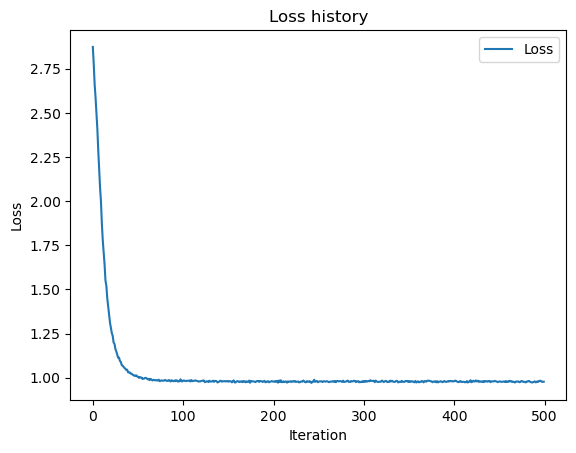

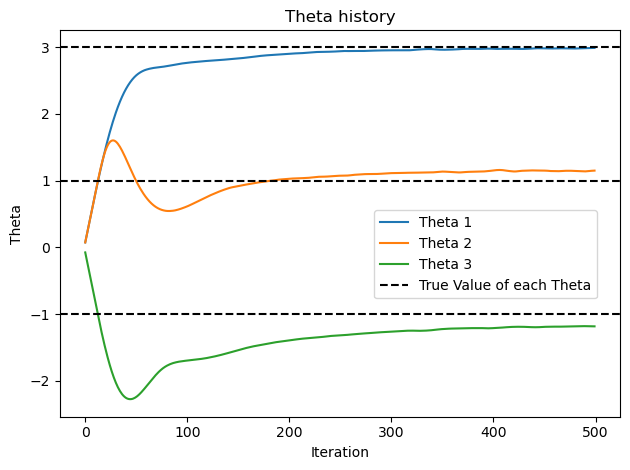

In [56]:
import matplotlib.pyplot as plt

# Convert lists to tensors
theta_historyGLMM1_tensor = torch.stack(theta_historyGLMM1)
loss_historyGLMM1_tensor = torch.tensor(loss_historyGLMM1)

# Plot loss history
plt.figure()
plt.plot(loss_historyGLMM1_tensor.numpy(), label='Loss')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot theta history
plt.figure()
plt.plot(theta_historyGLMM1_tensor[:, 0].numpy(), label='Theta 1')
plt.plot(theta_historyGLMM1_tensor[:, 1].numpy(), label='Theta 2')
plt.plot(theta_historyGLMM1_tensor[:, 2].numpy(), label='Theta 3')

plt.axhline(y=3, color='black', linestyle='--', label='True Value of each Theta')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=-1, color='black', linestyle='--')

plt.title('Theta history')
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.legend(loc='center', bbox_to_anchor=(0.76, 0.42))  

plt.tight_layout()
plt.show()


C:\Users\rikhi\AppData\Local\Temp\ipykernel_34996\3338314655.py:71: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  L = torch.cholesky(covariance_matrix, upper=False)
100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


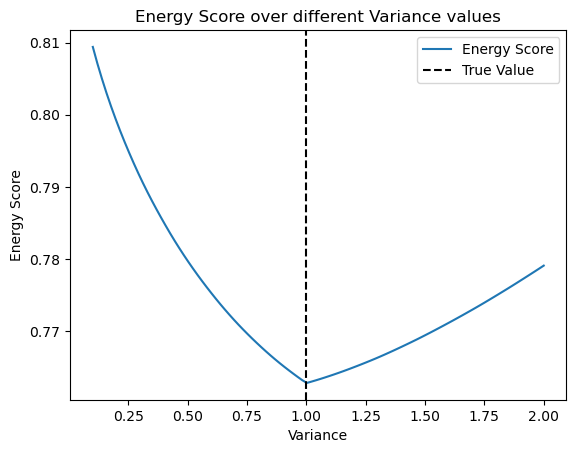

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Poisson, MultivariateNormal
from torch.distributions import constraints
import torch.distributions as dist
import torch.optim as optim
import matplotlib.pyplot as plt

class PoissonDistribution:
    def __init__(self):
        pass
    
    def mean(self, linear_predictor):
        '''
        torch.exp( _ ) where _ should be the linear predictor
        '''
        return torch.exp(linear_predictor)
    
    def log_prob(self, value, linear_predictor):
        mean = self.mean(linear_predictor)
        return Poisson(mean).log_prob(value)


class SpatialGLMM():
    '''
    Poisson Spatial Generalized Linear Mixed Model (GLMM)
    
    Parameters
    ----------
    grid_size : (int) The number of locations in the grid
    variance : (float) The variance of the random effects
    '''
    def __init__(self, grid_size, variance,design_X, design_Z, covariance_matrix=None):
        

        self.grid_size = grid_size
        self.num_locations = grid_size ** 2

        self.num_regression_covariates = 3

        self.variance = variance 

        self.covariance_matrix = covariance_matrix

        self.poisson_dist = PoissonDistribution()

        self.design_X = design_X
        self.design_Z = design_Z

    def linear_predictor(self, beta):
        '''
        Computes the linear predictor (X*Beta).
        '''
        linear_pred = torch.matmul(self.design_X, beta)
        return linear_pred
    
    
    def generate_covariance_matrix(self, variance):
        '''
        Creates a covariance matrix for random effects. Uses the pairwise distances between 
        the locations to get the covariance matrix.
        '''
        grid_coordinates = torch.stack(torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size)))
        grid_coordinates = grid_coordinates.view(2, -1).t().to(torch.float)
        pairwise_distances = torch.cdist(grid_coordinates, grid_coordinates)
        covariance_matrix = variance * torch.exp(-(pairwise_distances))
         # Ensure positive definiteness using Cholesky decomposition
        try:
            L = torch.cholesky(covariance_matrix, upper=False)
        except RuntimeError:
            min_eig = torch.min(torch.linalg.eigvalsh(covariance_matrix))
            covariance_matrix += torch.eye(self.num_locations) * (-min_eig + 1e-6)

        return covariance_matrix
    
    def random_effects(self, covariance_matrix):
        '''
        Computes the random effects (Z*u).
        '''
        # Sample u from a multivariate normal distribution
        u_dist = dist.MultivariateNormal(torch.zeros(self.grid_size**2), covariance_matrix=covariance_matrix)
        u = u_dist.sample()

        # Compute random effects
        rand_effects = torch.matmul(self.design_Z, u)
        return rand_effects

    def forward(self, beta, variance):
        ''' 
        Should be:  X*Beta + Z*u only
        '''
        linear_pred = self.linear_predictor(beta)
        covariance_matrix = self.generate_covariance_matrix(variance)
        random_effects_samples = self.random_effects(covariance_matrix)
        total_effects = linear_pred + random_effects_samples

        return torch.exp(total_effects)
    
    
'''
Fixing true values
'''
choose_beta = torch.tensor((3., 1., -1.))
choose_variance = 1.0
choose_grid_size = 5
choose_design_X = torch.cat((torch.ones(choose_grid_size**2, 1), torch.randn(choose_grid_size**2, 2)), dim=1) 
choose_design_Z = torch.eye(choose_grid_size**2)

spatial_glmm = SpatialGLMM(grid_size=choose_grid_size,
                    variance=choose_variance,
                    design_X=choose_design_X, 
                    design_Z=choose_design_Z)
spatial_glmm.covariance_matrix = spatial_glmm.generate_covariance_matrix(choose_variance)
num_real_samples = 500
num_fake_samples = 500


'''
Scoring Rule Inference. Choice here is Energy Score. Start considering Variogram-Energy Score. 
'''
def Energy_Score(beta, observations_y, simulations_Y):

	m = len(simulations_Y)

	# First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
	diff_Y_y = torch.pow(
		torch.norm(
			(observations_y.unsqueeze(1) -
			simulations_Y.unsqueeze(0)).float(),
			dim=2,keepdim=True).reshape(-1,1),
		beta)

	# Second part |Y-Y'|. 2* because pdist counts only once.
	diff_Y_Y = 2 * torch.pow(
		nn.functional.pdist(simulations_Y),
		beta)
	Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
	return Energy

def SR_eval(energy_beta, real_samples, fake_samples):
    out = 0
    for i in range(len(real_samples)):
        out += Energy_Score(energy_beta, real_samples[i].view(-1,1), fake_samples[i].view(-1,1))
    return out / (len(real_samples) + len(fake_samples)) 

#fix Energy Score Beta
SR_beta = 1.0



'''
real samples from fixed parameters, (original_beta, original_variance) 500 times
'''
torch.manual_seed(42) 
real_samples = [spatial_glmm.forward(choose_beta, variance=choose_variance) for _ in range(num_real_samples)]
    
    
from tqdm import tqdm
SR_E = []
for i in tqdm(torch.linspace(0.1, 2, 100)):
    '''
    real samples from fixed parameters, (original_beta, original_variance) 500 times
    '''
    torch.manual_seed(42)  
    fake_samples = [spatial_glmm.forward(choose_beta, variance=i) for _ in range(num_fake_samples)]
    SR_E.append(SR_eval(SR_beta, real_samples, fake_samples))

plt.plot(torch.linspace(0.1, 2, 100), SR_E , label='Energy Score')

plt.axvline(x=1.0, color='black', linestyle='--', label='True Value')
plt.legend()


plt.xlabel('Variance')
plt.ylabel('Energy Score')
plt.title('Energy Score over different Variance values')


plt.show()
